# Jane Street Market Prediction:

The dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which prediction of an action value: 1 to make the trade and 0 to pass on it is supposed to be done. Each trade has an associated weight and resp, which together represents a return on the trade.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Printing the first 5 rows of the data to get an idea about the structure of the data

In [3]:
df = pd.read_csv("train.csv")
print(df.head())

   date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174378   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292   
1     1.7774

## Data Cleaning

Removing the weights which are zero.

Trades with weight = 0 are included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

In [4]:
indexEmptyWeight = df[ df['weight'] == 0 ].index
df.drop(indexEmptyWeight, inplace=True)
print(df.head())
df.info(memory_usage='deep')

   date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   
6     0   0.190575 -0.001939 -0.002301  0.001088  0.005963  0.000709   
7     0   3.820844  0.017395  0.021361  0.031163  0.036970  0.033473   
8     0   0.116557 -0.005460 -0.007301 -0.009085 -0.003546 -0.001677   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   
6         -1  -3.172026  -3.093182  ...          NaN     0.336873   
7         -1   0.446050  -0.466210  ...          NaN     2.101997   
8          1  -3.172026  -3.093182  ...          NaN     1.537913   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
1     1.777472    -0.915458     2.831612    -1.417010     2.297459   
4     4.1011

Handling NaN values

In [5]:
df = df.fillna(-999)


XGBoosting requires data to be numeric. Therefore we need to ensure all the columns in our data are numeric


In [6]:
print(df.dtypes)

date             int64
weight         float64
resp_1         float64
resp_2         float64
resp_3         float64
                ...   
feature_126    float64
feature_127    float64
feature_128    float64
feature_129    float64
ts_id            int64
Length: 138, dtype: object


Creating the label prediction column which will contain 1 (Favorable outcome)if s resp (return) is positive or 0 if it is negative.

In [7]:
df.loc[df['resp'] > 0, 'label'] = 1
df.loc[df['resp'] <= 0, 'label'] = 0
print(df.head())

   date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   
6     0   0.190575 -0.001939 -0.002301  0.001088  0.005963  0.000709   
7     0   3.820844  0.017395  0.021361  0.031163  0.036970  0.033473   
8     0   0.116557 -0.005460 -0.007301 -0.009085 -0.003546 -0.001677   

   feature_0  feature_1  feature_2  ...  feature_122  feature_123  \
1         -1  -1.349537  -1.704709  ...    -1.178850     1.777472   
4          1  -3.172026  -3.093182  ...     0.344850     4.101145   
6         -1  -3.172026  -3.093182  ...     0.336873     4.076447   
7         -1   0.446050  -0.466210  ...     2.101997     4.846202   
8          1  -3.172026  -3.093182  ...     1.537913     4.785838   

   feature_124  feature_125  feature_126  feature_127  feature_128  \
1    -0.915458     2.831612    -1.417010     2.297459    -1.304614   
4     0.6142

Extracting 'label' column to Y_train:

In [8]:
Y_train = df['label']
print(Y_train.shape)

(1981287,)


Extracting feature columns to X_train:

In [9]:
X_train = df.loc[:, df.columns.str.contains('feature')]
X_train = X_train.fillna(-999)
for column in X_train.columns:
    X_train[column] = pd.to_numeric(X_train[column])
print(X_train.shape)



(1981287, 130)


Splitting the data

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, random_state=42, stratify=Y_train)

Splitting once again for validation set

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, stratify=Y_train)


When doing the split we want to ensure the proprtion of our Y is relatively same. That is why we used sklearn's
train_test_split.

We can confirm that the split is constant by following:

In [12]:
print(sum(Y_val)/len(Y_val))
print(sum(Y_train)/len(Y_train))
print(sum(Y_test)/len(Y_test))

0.5044119388842828
0.5044132966882104
0.5044132907482405


freeing up space for future objects

In [13]:
del df

# Models

## Dummy Classifier

Training

In [33]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)

DummyClassifier(strategy='most_frequent')

Prediction

In [34]:
dummy_y = dummy_clf.predict(X_test)

Comparison of Actual values with predicted values

In [41]:
print(classification_report(Y_test, dummy_y))
print("Accuracy: ", accuracy_score (Y_test, dummy_y))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    245475
         1.0       0.50      1.00      0.67    249847

    accuracy                           0.50    495322
   macro avg       0.25      0.50      0.34    495322
weighted avg       0.25      0.50      0.34    495322

Accuracy:  0.5044132907482405


In [39]:
from sklearn.metrics import confusion_matrix
cm_dummy = confusion_matrix(Y_test, dummy_y)
print(cm_dummy)

[[     0 245475]
 [     0 249847]]


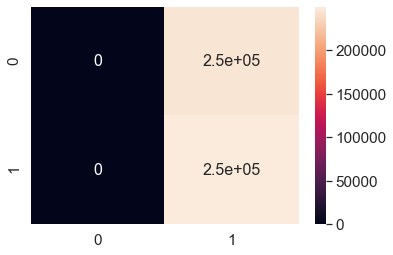

In [40]:
import seaborn as sn
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_dummy, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## XGBoost

Below we will tune our hyperparamters for XGBoost. We will optimize n_estimators, learning_rate, max_depth.

We will be using GridSearchCV

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid ={
    'n_estimators': [600, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.005],
    'max_depth': [6, 11, 15]
}

optimal_param = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', missing=-999, 
                                                         tree_method='gpu_hist', subsample=0.50, colsample_bytree=0.50),
                             param_grid=param_grid, scoring='roc_auc'
                            )

In [26]:
optimal_param.fit(X_train, Y_train, verbose=True, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_val, Y_val)])

[0]	validation_0-auc:0.52322
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53055
[2]	validation_0-auc:0.53338
[3]	validation_0-auc:0.53443
[4]	validation_0-auc:0.53473
[5]	validation_0-auc:0.53615
[6]	validation_0-auc:0.53598
[7]	validation_0-auc:0.53600
[8]	validation_0-auc:0.53631
[9]	validation_0-auc:0.53646
[10]	validation_0-auc:0.53669
[11]	validation_0-auc:0.53829
[12]	validation_0-auc:0.53892
[13]	validation_0-auc:0.53896
[14]	validation_0-auc:0.53927
[15]	validation_0-auc:0.53920
[16]	validation_0-auc:0.53935
[17]	validation_0-auc:0.53967
[18]	validation_0-auc:0.53975
[19]	validation_0-auc:0.53991
[20]	validation_0-auc:0.54033
[21]	validation_0-auc:0.54058
[22]	validation_0-auc:0.54065
[23]	validation_0-auc:0.54077
[24]	validation_0-auc:0.54068
[25]	validation_0-auc:0.54060
[26]	validation_0-auc:0.54061
[27]	validation_0-auc:0.54067
[28]	validation_0-auc:0.54060
[29]	validation_0-auc:0.54093
[30]	validation_0-auc:0.54088
[31]	validation_

[266]	validation_0-auc:0.55060
[267]	validation_0-auc:0.55066
[268]	validation_0-auc:0.55066
[269]	validation_0-auc:0.55065
[270]	validation_0-auc:0.55073
[271]	validation_0-auc:0.55073
[272]	validation_0-auc:0.55074
[273]	validation_0-auc:0.55078
[274]	validation_0-auc:0.55080
[275]	validation_0-auc:0.55080
[276]	validation_0-auc:0.55080
[277]	validation_0-auc:0.55085
[278]	validation_0-auc:0.55090
[279]	validation_0-auc:0.55093
[280]	validation_0-auc:0.55091
[281]	validation_0-auc:0.55093
[282]	validation_0-auc:0.55096
[283]	validation_0-auc:0.55097
[284]	validation_0-auc:0.55100
[285]	validation_0-auc:0.55107
[286]	validation_0-auc:0.55110
[287]	validation_0-auc:0.55113
[288]	validation_0-auc:0.55115
[289]	validation_0-auc:0.55116
[290]	validation_0-auc:0.55119
[291]	validation_0-auc:0.55121
[292]	validation_0-auc:0.55123
[293]	validation_0-auc:0.55124
[294]	validation_0-auc:0.55131
[295]	validation_0-auc:0.55136
[296]	validation_0-auc:0.55137
[297]	validation_0-auc:0.55136
[298]	va

[531]	validation_0-auc:0.55785
[532]	validation_0-auc:0.55785
[533]	validation_0-auc:0.55788
[534]	validation_0-auc:0.55789
[535]	validation_0-auc:0.55790
[536]	validation_0-auc:0.55799
[537]	validation_0-auc:0.55800
[538]	validation_0-auc:0.55804
[539]	validation_0-auc:0.55806
[540]	validation_0-auc:0.55811
[541]	validation_0-auc:0.55816
[542]	validation_0-auc:0.55818
[543]	validation_0-auc:0.55819
[544]	validation_0-auc:0.55819
[545]	validation_0-auc:0.55822
[546]	validation_0-auc:0.55823
[547]	validation_0-auc:0.55824
[548]	validation_0-auc:0.55830
[549]	validation_0-auc:0.55835
[550]	validation_0-auc:0.55835
[551]	validation_0-auc:0.55837
[552]	validation_0-auc:0.55836
[553]	validation_0-auc:0.55837
[554]	validation_0-auc:0.55843
[555]	validation_0-auc:0.55848
[556]	validation_0-auc:0.55848
[557]	validation_0-auc:0.55848
[558]	validation_0-auc:0.55850
[559]	validation_0-auc:0.55857
[560]	validation_0-auc:0.55858
[561]	validation_0-auc:0.55860
[562]	validation_0-auc:0.55860
[563]	va

[197]	validation_0-auc:0.54882
[198]	validation_0-auc:0.54890
[199]	validation_0-auc:0.54897
[200]	validation_0-auc:0.54897
[201]	validation_0-auc:0.54895
[202]	validation_0-auc:0.54898
[203]	validation_0-auc:0.54900
[204]	validation_0-auc:0.54901
[205]	validation_0-auc:0.54905
[206]	validation_0-auc:0.54907
[207]	validation_0-auc:0.54914
[208]	validation_0-auc:0.54913
[209]	validation_0-auc:0.54918
[210]	validation_0-auc:0.54922
[211]	validation_0-auc:0.54922
[212]	validation_0-auc:0.54926
[213]	validation_0-auc:0.54932
[214]	validation_0-auc:0.54936
[215]	validation_0-auc:0.54935
[216]	validation_0-auc:0.54935
[217]	validation_0-auc:0.54934
[218]	validation_0-auc:0.54936
[219]	validation_0-auc:0.54939
[220]	validation_0-auc:0.54945
[221]	validation_0-auc:0.54949
[222]	validation_0-auc:0.54953
[223]	validation_0-auc:0.54957
[224]	validation_0-auc:0.54963
[225]	validation_0-auc:0.54964
[226]	validation_0-auc:0.54971
[227]	validation_0-auc:0.54973
[228]	validation_0-auc:0.54980
[229]	va

[462]	validation_0-auc:0.55639
[463]	validation_0-auc:0.55639
[464]	validation_0-auc:0.55646
[465]	validation_0-auc:0.55648
[466]	validation_0-auc:0.55654
[467]	validation_0-auc:0.55655
[468]	validation_0-auc:0.55656
[469]	validation_0-auc:0.55655
[470]	validation_0-auc:0.55657
[471]	validation_0-auc:0.55659
[472]	validation_0-auc:0.55661
[473]	validation_0-auc:0.55663
[474]	validation_0-auc:0.55662
[475]	validation_0-auc:0.55661
[476]	validation_0-auc:0.55663
[477]	validation_0-auc:0.55666
[478]	validation_0-auc:0.55670
[479]	validation_0-auc:0.55670
[480]	validation_0-auc:0.55678
[481]	validation_0-auc:0.55679
[482]	validation_0-auc:0.55684
[483]	validation_0-auc:0.55685
[484]	validation_0-auc:0.55684
[485]	validation_0-auc:0.55693
[486]	validation_0-auc:0.55696
[487]	validation_0-auc:0.55699
[488]	validation_0-auc:0.55704
[489]	validation_0-auc:0.55708
[490]	validation_0-auc:0.55711
[491]	validation_0-auc:0.55714
[492]	validation_0-auc:0.55715
[493]	validation_0-auc:0.55719
[494]	va

[128]	validation_0-auc:0.54552
[129]	validation_0-auc:0.54556
[130]	validation_0-auc:0.54559
[131]	validation_0-auc:0.54566
[132]	validation_0-auc:0.54566
[133]	validation_0-auc:0.54571
[134]	validation_0-auc:0.54577
[135]	validation_0-auc:0.54585
[136]	validation_0-auc:0.54587
[137]	validation_0-auc:0.54594
[138]	validation_0-auc:0.54599
[139]	validation_0-auc:0.54609
[140]	validation_0-auc:0.54613
[141]	validation_0-auc:0.54615
[142]	validation_0-auc:0.54618
[143]	validation_0-auc:0.54622
[144]	validation_0-auc:0.54627
[145]	validation_0-auc:0.54630
[146]	validation_0-auc:0.54632
[147]	validation_0-auc:0.54636
[148]	validation_0-auc:0.54638
[149]	validation_0-auc:0.54643
[150]	validation_0-auc:0.54646
[151]	validation_0-auc:0.54652
[152]	validation_0-auc:0.54662
[153]	validation_0-auc:0.54664
[154]	validation_0-auc:0.54666
[155]	validation_0-auc:0.54672
[156]	validation_0-auc:0.54674
[157]	validation_0-auc:0.54677
[158]	validation_0-auc:0.54682
[159]	validation_0-auc:0.54683
[160]	va

[393]	validation_0-auc:0.55409
[394]	validation_0-auc:0.55412
[395]	validation_0-auc:0.55416
[396]	validation_0-auc:0.55422
[397]	validation_0-auc:0.55424
[398]	validation_0-auc:0.55427
[399]	validation_0-auc:0.55428
[400]	validation_0-auc:0.55428
[401]	validation_0-auc:0.55429
[402]	validation_0-auc:0.55434
[403]	validation_0-auc:0.55436
[404]	validation_0-auc:0.55438
[405]	validation_0-auc:0.55441
[406]	validation_0-auc:0.55441
[407]	validation_0-auc:0.55447
[408]	validation_0-auc:0.55450
[409]	validation_0-auc:0.55451
[410]	validation_0-auc:0.55456
[411]	validation_0-auc:0.55457
[412]	validation_0-auc:0.55461
[413]	validation_0-auc:0.55461
[414]	validation_0-auc:0.55462
[415]	validation_0-auc:0.55463
[416]	validation_0-auc:0.55464
[417]	validation_0-auc:0.55472
[418]	validation_0-auc:0.55480
[419]	validation_0-auc:0.55480
[420]	validation_0-auc:0.55486
[421]	validation_0-auc:0.55485
[422]	validation_0-auc:0.55486
[423]	validation_0-auc:0.55488
[424]	validation_0-auc:0.55497
[425]	va

[58]	validation_0-auc:0.54194
[59]	validation_0-auc:0.54200
[60]	validation_0-auc:0.54199
[61]	validation_0-auc:0.54198
[62]	validation_0-auc:0.54212
[63]	validation_0-auc:0.54218
[64]	validation_0-auc:0.54221
[65]	validation_0-auc:0.54252
[66]	validation_0-auc:0.54261
[67]	validation_0-auc:0.54281
[68]	validation_0-auc:0.54280
[69]	validation_0-auc:0.54297
[70]	validation_0-auc:0.54302
[71]	validation_0-auc:0.54303
[72]	validation_0-auc:0.54312
[73]	validation_0-auc:0.54317
[74]	validation_0-auc:0.54319
[75]	validation_0-auc:0.54319
[76]	validation_0-auc:0.54322
[77]	validation_0-auc:0.54324
[78]	validation_0-auc:0.54347
[79]	validation_0-auc:0.54345
[80]	validation_0-auc:0.54350
[81]	validation_0-auc:0.54349
[82]	validation_0-auc:0.54351
[83]	validation_0-auc:0.54347
[84]	validation_0-auc:0.54352
[85]	validation_0-auc:0.54351
[86]	validation_0-auc:0.54354
[87]	validation_0-auc:0.54357
[88]	validation_0-auc:0.54359
[89]	validation_0-auc:0.54363
[90]	validation_0-auc:0.54367
[91]	valid

[324]	validation_0-auc:0.55186
[325]	validation_0-auc:0.55195
[326]	validation_0-auc:0.55196
[327]	validation_0-auc:0.55197
[328]	validation_0-auc:0.55199
[329]	validation_0-auc:0.55199
[330]	validation_0-auc:0.55203
[331]	validation_0-auc:0.55209
[332]	validation_0-auc:0.55213
[333]	validation_0-auc:0.55215
[334]	validation_0-auc:0.55217
[335]	validation_0-auc:0.55216
[336]	validation_0-auc:0.55227
[337]	validation_0-auc:0.55228
[338]	validation_0-auc:0.55231
[339]	validation_0-auc:0.55233
[340]	validation_0-auc:0.55233
[341]	validation_0-auc:0.55238
[342]	validation_0-auc:0.55239
[343]	validation_0-auc:0.55245
[344]	validation_0-auc:0.55247
[345]	validation_0-auc:0.55249
[346]	validation_0-auc:0.55251
[347]	validation_0-auc:0.55253
[348]	validation_0-auc:0.55257
[349]	validation_0-auc:0.55257
[350]	validation_0-auc:0.55256
[351]	validation_0-auc:0.55257
[352]	validation_0-auc:0.55260
[353]	validation_0-auc:0.55263
[354]	validation_0-auc:0.55266
[355]	validation_0-auc:0.55267
[356]	va

[589]	validation_0-auc:0.55900
[590]	validation_0-auc:0.55902
[591]	validation_0-auc:0.55902
[592]	validation_0-auc:0.55903
[593]	validation_0-auc:0.55908
[594]	validation_0-auc:0.55910
[595]	validation_0-auc:0.55912
[596]	validation_0-auc:0.55914
[597]	validation_0-auc:0.55914
[598]	validation_0-auc:0.55916
[599]	validation_0-auc:0.55917
[0]	validation_0-auc:0.52292
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53036
[2]	validation_0-auc:0.53199
[3]	validation_0-auc:0.53300
[4]	validation_0-auc:0.53476
[5]	validation_0-auc:0.53674
[6]	validation_0-auc:0.53720
[7]	validation_0-auc:0.53728
[8]	validation_0-auc:0.53742
[9]	validation_0-auc:0.53806
[10]	validation_0-auc:0.53816
[11]	validation_0-auc:0.53811
[12]	validation_0-auc:0.53826
[13]	validation_0-auc:0.53850
[14]	validation_0-auc:0.53858
[15]	validation_0-auc:0.53845
[16]	validation_0-auc:0.53859
[17]	validation_0-auc:0.53891
[18]	validation_0-auc:0.53894
[19]	validation_0-auc:0.53900
[20]	

[255]	validation_0-auc:0.54977
[256]	validation_0-auc:0.54979
[257]	validation_0-auc:0.54981
[258]	validation_0-auc:0.54987
[259]	validation_0-auc:0.54987
[260]	validation_0-auc:0.54990
[261]	validation_0-auc:0.54993
[262]	validation_0-auc:0.54996
[263]	validation_0-auc:0.54995
[264]	validation_0-auc:0.54997
[265]	validation_0-auc:0.54996
[266]	validation_0-auc:0.54996
[267]	validation_0-auc:0.54996
[268]	validation_0-auc:0.55003
[269]	validation_0-auc:0.55007
[270]	validation_0-auc:0.55009
[271]	validation_0-auc:0.55011
[272]	validation_0-auc:0.55018
[273]	validation_0-auc:0.55018
[274]	validation_0-auc:0.55020
[275]	validation_0-auc:0.55020
[276]	validation_0-auc:0.55025
[277]	validation_0-auc:0.55037
[278]	validation_0-auc:0.55037
[279]	validation_0-auc:0.55039
[280]	validation_0-auc:0.55042
[281]	validation_0-auc:0.55043
[282]	validation_0-auc:0.55051
[283]	validation_0-auc:0.55055
[284]	validation_0-auc:0.55057
[285]	validation_0-auc:0.55060
[286]	validation_0-auc:0.55064
[287]	va

[520]	validation_0-auc:0.55718
[521]	validation_0-auc:0.55730
[522]	validation_0-auc:0.55732
[523]	validation_0-auc:0.55734
[524]	validation_0-auc:0.55735
[525]	validation_0-auc:0.55737
[526]	validation_0-auc:0.55739
[527]	validation_0-auc:0.55739
[528]	validation_0-auc:0.55745
[529]	validation_0-auc:0.55745
[530]	validation_0-auc:0.55749
[531]	validation_0-auc:0.55754
[532]	validation_0-auc:0.55754
[533]	validation_0-auc:0.55754
[534]	validation_0-auc:0.55753
[535]	validation_0-auc:0.55754
[536]	validation_0-auc:0.55755
[537]	validation_0-auc:0.55755
[538]	validation_0-auc:0.55758
[539]	validation_0-auc:0.55761
[540]	validation_0-auc:0.55762
[541]	validation_0-auc:0.55764
[542]	validation_0-auc:0.55770
[543]	validation_0-auc:0.55773
[544]	validation_0-auc:0.55777
[545]	validation_0-auc:0.55780
[546]	validation_0-auc:0.55789
[547]	validation_0-auc:0.55793
[548]	validation_0-auc:0.55799
[549]	validation_0-auc:0.55801
[550]	validation_0-auc:0.55803
[551]	validation_0-auc:0.55804
[552]	va

[186]	validation_0-auc:0.54821
[187]	validation_0-auc:0.54822
[188]	validation_0-auc:0.54826
[189]	validation_0-auc:0.54826
[190]	validation_0-auc:0.54829
[191]	validation_0-auc:0.54829
[192]	validation_0-auc:0.54835
[193]	validation_0-auc:0.54835
[194]	validation_0-auc:0.54839
[195]	validation_0-auc:0.54845
[196]	validation_0-auc:0.54851
[197]	validation_0-auc:0.54855
[198]	validation_0-auc:0.54861
[199]	validation_0-auc:0.54862
[200]	validation_0-auc:0.54865
[201]	validation_0-auc:0.54866
[202]	validation_0-auc:0.54867
[203]	validation_0-auc:0.54868
[204]	validation_0-auc:0.54872
[205]	validation_0-auc:0.54872
[206]	validation_0-auc:0.54875
[207]	validation_0-auc:0.54882
[208]	validation_0-auc:0.54884
[209]	validation_0-auc:0.54885
[210]	validation_0-auc:0.54886
[211]	validation_0-auc:0.54888
[212]	validation_0-auc:0.54891
[213]	validation_0-auc:0.54895
[214]	validation_0-auc:0.54895
[215]	validation_0-auc:0.54895
[216]	validation_0-auc:0.54900
[217]	validation_0-auc:0.54902
[218]	va

[451]	validation_0-auc:0.55568
[452]	validation_0-auc:0.55571
[453]	validation_0-auc:0.55573
[454]	validation_0-auc:0.55574
[455]	validation_0-auc:0.55580
[456]	validation_0-auc:0.55590
[457]	validation_0-auc:0.55590
[458]	validation_0-auc:0.55595
[459]	validation_0-auc:0.55596
[460]	validation_0-auc:0.55597
[461]	validation_0-auc:0.55602
[462]	validation_0-auc:0.55604
[463]	validation_0-auc:0.55603
[464]	validation_0-auc:0.55608
[465]	validation_0-auc:0.55610
[466]	validation_0-auc:0.55614
[467]	validation_0-auc:0.55615
[468]	validation_0-auc:0.55623
[469]	validation_0-auc:0.55625
[470]	validation_0-auc:0.55627
[471]	validation_0-auc:0.55628
[472]	validation_0-auc:0.55630
[473]	validation_0-auc:0.55632
[474]	validation_0-auc:0.55632
[475]	validation_0-auc:0.55636
[476]	validation_0-auc:0.55637
[477]	validation_0-auc:0.55637
[478]	validation_0-auc:0.55641
[479]	validation_0-auc:0.55643
[480]	validation_0-auc:0.55647
[481]	validation_0-auc:0.55649
[482]	validation_0-auc:0.55651
[483]	va

[716]	validation_0-auc:0.56246
[717]	validation_0-auc:0.56249
[718]	validation_0-auc:0.56252
[719]	validation_0-auc:0.56259
[720]	validation_0-auc:0.56259
[721]	validation_0-auc:0.56261
[722]	validation_0-auc:0.56264
[723]	validation_0-auc:0.56268
[724]	validation_0-auc:0.56270
[725]	validation_0-auc:0.56271
[726]	validation_0-auc:0.56274
[727]	validation_0-auc:0.56274
[728]	validation_0-auc:0.56278
[729]	validation_0-auc:0.56279
[730]	validation_0-auc:0.56281
[731]	validation_0-auc:0.56281
[732]	validation_0-auc:0.56290
[733]	validation_0-auc:0.56290
[734]	validation_0-auc:0.56292
[735]	validation_0-auc:0.56294
[736]	validation_0-auc:0.56297
[737]	validation_0-auc:0.56301
[738]	validation_0-auc:0.56304
[739]	validation_0-auc:0.56306
[740]	validation_0-auc:0.56308
[741]	validation_0-auc:0.56308
[742]	validation_0-auc:0.56314
[743]	validation_0-auc:0.56316
[744]	validation_0-auc:0.56317
[745]	validation_0-auc:0.56318
[746]	validation_0-auc:0.56320
[747]	validation_0-auc:0.56320
[748]	va

[981]	validation_0-auc:0.56722
[982]	validation_0-auc:0.56723
[983]	validation_0-auc:0.56724
[984]	validation_0-auc:0.56724
[985]	validation_0-auc:0.56724
[986]	validation_0-auc:0.56726
[987]	validation_0-auc:0.56725
[988]	validation_0-auc:0.56726
[989]	validation_0-auc:0.56726
[990]	validation_0-auc:0.56725
[991]	validation_0-auc:0.56725
[992]	validation_0-auc:0.56727
[993]	validation_0-auc:0.56728
[994]	validation_0-auc:0.56729
[995]	validation_0-auc:0.56730
[996]	validation_0-auc:0.56732
[997]	validation_0-auc:0.56732
[998]	validation_0-auc:0.56733
[999]	validation_0-auc:0.56734
[0]	validation_0-auc:0.52375
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53358
[2]	validation_0-auc:0.53556
[3]	validation_0-auc:0.53669
[4]	validation_0-auc:0.53700
[5]	validation_0-auc:0.53882
[6]	validation_0-auc:0.53862
[7]	validation_0-auc:0.53858
[8]	validation_0-auc:0.53871
[9]	validation_0-auc:0.53895
[10]	validation_0-auc:0.53897
[11]	validation_0-auc:0.539

[247]	validation_0-auc:0.55028
[248]	validation_0-auc:0.55031
[249]	validation_0-auc:0.55033
[250]	validation_0-auc:0.55034
[251]	validation_0-auc:0.55035
[252]	validation_0-auc:0.55038
[253]	validation_0-auc:0.55039
[254]	validation_0-auc:0.55045
[255]	validation_0-auc:0.55043
[256]	validation_0-auc:0.55049
[257]	validation_0-auc:0.55049
[258]	validation_0-auc:0.55051
[259]	validation_0-auc:0.55051
[260]	validation_0-auc:0.55053
[261]	validation_0-auc:0.55052
[262]	validation_0-auc:0.55056
[263]	validation_0-auc:0.55056
[264]	validation_0-auc:0.55061
[265]	validation_0-auc:0.55061
[266]	validation_0-auc:0.55064
[267]	validation_0-auc:0.55066
[268]	validation_0-auc:0.55072
[269]	validation_0-auc:0.55073
[270]	validation_0-auc:0.55083
[271]	validation_0-auc:0.55081
[272]	validation_0-auc:0.55085
[273]	validation_0-auc:0.55090
[274]	validation_0-auc:0.55093
[275]	validation_0-auc:0.55093
[276]	validation_0-auc:0.55095
[277]	validation_0-auc:0.55099
[278]	validation_0-auc:0.55108
[279]	va

[512]	validation_0-auc:0.55762
[513]	validation_0-auc:0.55764
[514]	validation_0-auc:0.55768
[515]	validation_0-auc:0.55770
[516]	validation_0-auc:0.55771
[517]	validation_0-auc:0.55771
[518]	validation_0-auc:0.55772
[519]	validation_0-auc:0.55772
[520]	validation_0-auc:0.55774
[521]	validation_0-auc:0.55773
[522]	validation_0-auc:0.55775
[523]	validation_0-auc:0.55785
[524]	validation_0-auc:0.55784
[525]	validation_0-auc:0.55786
[526]	validation_0-auc:0.55789
[527]	validation_0-auc:0.55791
[528]	validation_0-auc:0.55798
[529]	validation_0-auc:0.55800
[530]	validation_0-auc:0.55804
[531]	validation_0-auc:0.55810
[532]	validation_0-auc:0.55810
[533]	validation_0-auc:0.55810
[534]	validation_0-auc:0.55810
[535]	validation_0-auc:0.55813
[536]	validation_0-auc:0.55817
[537]	validation_0-auc:0.55817
[538]	validation_0-auc:0.55817
[539]	validation_0-auc:0.55819
[540]	validation_0-auc:0.55822
[541]	validation_0-auc:0.55823
[542]	validation_0-auc:0.55825
[543]	validation_0-auc:0.55827
[544]	va

[777]	validation_0-auc:0.56346
[778]	validation_0-auc:0.56347
[779]	validation_0-auc:0.56348
[780]	validation_0-auc:0.56351
[781]	validation_0-auc:0.56352
[782]	validation_0-auc:0.56353
[783]	validation_0-auc:0.56356
[784]	validation_0-auc:0.56357
[785]	validation_0-auc:0.56359
[786]	validation_0-auc:0.56360
[787]	validation_0-auc:0.56362
[788]	validation_0-auc:0.56362
[789]	validation_0-auc:0.56366
[790]	validation_0-auc:0.56366
[791]	validation_0-auc:0.56366
[792]	validation_0-auc:0.56367
[793]	validation_0-auc:0.56367
[794]	validation_0-auc:0.56368
[795]	validation_0-auc:0.56371
[796]	validation_0-auc:0.56376
[797]	validation_0-auc:0.56377
[798]	validation_0-auc:0.56378
[799]	validation_0-auc:0.56379
[800]	validation_0-auc:0.56380
[801]	validation_0-auc:0.56386
[802]	validation_0-auc:0.56388
[803]	validation_0-auc:0.56388
[804]	validation_0-auc:0.56388
[805]	validation_0-auc:0.56393
[806]	validation_0-auc:0.56395
[807]	validation_0-auc:0.56402
[808]	validation_0-auc:0.56403
[809]	va

[41]	validation_0-auc:0.54121
[42]	validation_0-auc:0.54122
[43]	validation_0-auc:0.54116
[44]	validation_0-auc:0.54123
[45]	validation_0-auc:0.54148
[46]	validation_0-auc:0.54152
[47]	validation_0-auc:0.54167
[48]	validation_0-auc:0.54172
[49]	validation_0-auc:0.54177
[50]	validation_0-auc:0.54192
[51]	validation_0-auc:0.54197
[52]	validation_0-auc:0.54212
[53]	validation_0-auc:0.54210
[54]	validation_0-auc:0.54221
[55]	validation_0-auc:0.54223
[56]	validation_0-auc:0.54226
[57]	validation_0-auc:0.54226
[58]	validation_0-auc:0.54226
[59]	validation_0-auc:0.54233
[60]	validation_0-auc:0.54239
[61]	validation_0-auc:0.54234
[62]	validation_0-auc:0.54239
[63]	validation_0-auc:0.54249
[64]	validation_0-auc:0.54239
[65]	validation_0-auc:0.54257
[66]	validation_0-auc:0.54257
[67]	validation_0-auc:0.54270
[68]	validation_0-auc:0.54266
[69]	validation_0-auc:0.54267
[70]	validation_0-auc:0.54279
[71]	validation_0-auc:0.54279
[72]	validation_0-auc:0.54276
[73]	validation_0-auc:0.54285
[74]	valid

[308]	validation_0-auc:0.55166
[309]	validation_0-auc:0.55169
[310]	validation_0-auc:0.55174
[311]	validation_0-auc:0.55175
[312]	validation_0-auc:0.55177
[313]	validation_0-auc:0.55179
[314]	validation_0-auc:0.55183
[315]	validation_0-auc:0.55188
[316]	validation_0-auc:0.55192
[317]	validation_0-auc:0.55196
[318]	validation_0-auc:0.55197
[319]	validation_0-auc:0.55200
[320]	validation_0-auc:0.55204
[321]	validation_0-auc:0.55208
[322]	validation_0-auc:0.55215
[323]	validation_0-auc:0.55220
[324]	validation_0-auc:0.55221
[325]	validation_0-auc:0.55220
[326]	validation_0-auc:0.55223
[327]	validation_0-auc:0.55225
[328]	validation_0-auc:0.55233
[329]	validation_0-auc:0.55234
[330]	validation_0-auc:0.55236
[331]	validation_0-auc:0.55238
[332]	validation_0-auc:0.55239
[333]	validation_0-auc:0.55240
[334]	validation_0-auc:0.55243
[335]	validation_0-auc:0.55246
[336]	validation_0-auc:0.55248
[337]	validation_0-auc:0.55246
[338]	validation_0-auc:0.55248
[339]	validation_0-auc:0.55248
[340]	va

[573]	validation_0-auc:0.55945
[574]	validation_0-auc:0.55951
[575]	validation_0-auc:0.55951
[576]	validation_0-auc:0.55954
[577]	validation_0-auc:0.55956
[578]	validation_0-auc:0.55958
[579]	validation_0-auc:0.55960
[580]	validation_0-auc:0.55968
[581]	validation_0-auc:0.55976
[582]	validation_0-auc:0.55978
[583]	validation_0-auc:0.55977
[584]	validation_0-auc:0.55978
[585]	validation_0-auc:0.55978
[586]	validation_0-auc:0.55980
[587]	validation_0-auc:0.55980
[588]	validation_0-auc:0.55988
[589]	validation_0-auc:0.55989
[590]	validation_0-auc:0.55989
[591]	validation_0-auc:0.55992
[592]	validation_0-auc:0.55994
[593]	validation_0-auc:0.55996
[594]	validation_0-auc:0.56001
[595]	validation_0-auc:0.56002
[596]	validation_0-auc:0.56002
[597]	validation_0-auc:0.56004
[598]	validation_0-auc:0.56005
[599]	validation_0-auc:0.56007
[600]	validation_0-auc:0.56009
[601]	validation_0-auc:0.56013
[602]	validation_0-auc:0.56015
[603]	validation_0-auc:0.56014
[604]	validation_0-auc:0.56014
[605]	va

[838]	validation_0-auc:0.56474
[839]	validation_0-auc:0.56474
[840]	validation_0-auc:0.56476
[841]	validation_0-auc:0.56476
[842]	validation_0-auc:0.56477
[843]	validation_0-auc:0.56480
[844]	validation_0-auc:0.56481
[845]	validation_0-auc:0.56486
[846]	validation_0-auc:0.56488
[847]	validation_0-auc:0.56489
[848]	validation_0-auc:0.56493
[849]	validation_0-auc:0.56494
[850]	validation_0-auc:0.56495
[851]	validation_0-auc:0.56499
[852]	validation_0-auc:0.56498
[853]	validation_0-auc:0.56501
[854]	validation_0-auc:0.56502
[855]	validation_0-auc:0.56505
[856]	validation_0-auc:0.56506
[857]	validation_0-auc:0.56507
[858]	validation_0-auc:0.56510
[859]	validation_0-auc:0.56510
[860]	validation_0-auc:0.56512
[861]	validation_0-auc:0.56514
[862]	validation_0-auc:0.56513
[863]	validation_0-auc:0.56514
[864]	validation_0-auc:0.56515
[865]	validation_0-auc:0.56517
[866]	validation_0-auc:0.56518
[867]	validation_0-auc:0.56521
[868]	validation_0-auc:0.56525
[869]	validation_0-auc:0.56526
[870]	va

[104]	validation_0-auc:0.54435
[105]	validation_0-auc:0.54444
[106]	validation_0-auc:0.54446
[107]	validation_0-auc:0.54455
[108]	validation_0-auc:0.54461
[109]	validation_0-auc:0.54468
[110]	validation_0-auc:0.54477
[111]	validation_0-auc:0.54482
[112]	validation_0-auc:0.54484
[113]	validation_0-auc:0.54485
[114]	validation_0-auc:0.54481
[115]	validation_0-auc:0.54485
[116]	validation_0-auc:0.54487
[117]	validation_0-auc:0.54489
[118]	validation_0-auc:0.54487
[119]	validation_0-auc:0.54489
[120]	validation_0-auc:0.54491
[121]	validation_0-auc:0.54504
[122]	validation_0-auc:0.54506
[123]	validation_0-auc:0.54509
[124]	validation_0-auc:0.54511
[125]	validation_0-auc:0.54511
[126]	validation_0-auc:0.54513
[127]	validation_0-auc:0.54519
[128]	validation_0-auc:0.54520
[129]	validation_0-auc:0.54525
[130]	validation_0-auc:0.54529
[131]	validation_0-auc:0.54534
[132]	validation_0-auc:0.54538
[133]	validation_0-auc:0.54540
[134]	validation_0-auc:0.54540
[135]	validation_0-auc:0.54542
[136]	va

[369]	validation_0-auc:0.55313
[370]	validation_0-auc:0.55318
[371]	validation_0-auc:0.55326
[372]	validation_0-auc:0.55325
[373]	validation_0-auc:0.55328
[374]	validation_0-auc:0.55333
[375]	validation_0-auc:0.55334
[376]	validation_0-auc:0.55336
[377]	validation_0-auc:0.55340
[378]	validation_0-auc:0.55341
[379]	validation_0-auc:0.55346
[380]	validation_0-auc:0.55351
[381]	validation_0-auc:0.55354
[382]	validation_0-auc:0.55359
[383]	validation_0-auc:0.55366
[384]	validation_0-auc:0.55370
[385]	validation_0-auc:0.55372
[386]	validation_0-auc:0.55372
[387]	validation_0-auc:0.55378
[388]	validation_0-auc:0.55380
[389]	validation_0-auc:0.55383
[390]	validation_0-auc:0.55387
[391]	validation_0-auc:0.55394
[392]	validation_0-auc:0.55395
[393]	validation_0-auc:0.55397
[394]	validation_0-auc:0.55400
[395]	validation_0-auc:0.55406
[396]	validation_0-auc:0.55410
[397]	validation_0-auc:0.55413
[398]	validation_0-auc:0.55413
[399]	validation_0-auc:0.55414
[400]	validation_0-auc:0.55414
[401]	va

[634]	validation_0-auc:0.56011
[635]	validation_0-auc:0.56014
[636]	validation_0-auc:0.56019
[637]	validation_0-auc:0.56019
[638]	validation_0-auc:0.56018
[639]	validation_0-auc:0.56024
[640]	validation_0-auc:0.56028
[641]	validation_0-auc:0.56034
[642]	validation_0-auc:0.56039
[643]	validation_0-auc:0.56041
[644]	validation_0-auc:0.56042
[645]	validation_0-auc:0.56044
[646]	validation_0-auc:0.56047
[647]	validation_0-auc:0.56050
[648]	validation_0-auc:0.56051
[649]	validation_0-auc:0.56056
[650]	validation_0-auc:0.56058
[651]	validation_0-auc:0.56060
[652]	validation_0-auc:0.56064
[653]	validation_0-auc:0.56067
[654]	validation_0-auc:0.56068
[655]	validation_0-auc:0.56069
[656]	validation_0-auc:0.56070
[657]	validation_0-auc:0.56072
[658]	validation_0-auc:0.56073
[659]	validation_0-auc:0.56077
[660]	validation_0-auc:0.56082
[661]	validation_0-auc:0.56083
[662]	validation_0-auc:0.56087
[663]	validation_0-auc:0.56092
[664]	validation_0-auc:0.56095
[665]	validation_0-auc:0.56099
[666]	va

[899]	validation_0-auc:0.56541
[900]	validation_0-auc:0.56544
[901]	validation_0-auc:0.56544
[902]	validation_0-auc:0.56548
[903]	validation_0-auc:0.56548
[904]	validation_0-auc:0.56554
[905]	validation_0-auc:0.56555
[906]	validation_0-auc:0.56558
[907]	validation_0-auc:0.56561
[908]	validation_0-auc:0.56561
[909]	validation_0-auc:0.56565
[910]	validation_0-auc:0.56568
[911]	validation_0-auc:0.56570
[912]	validation_0-auc:0.56570
[913]	validation_0-auc:0.56570
[914]	validation_0-auc:0.56575
[915]	validation_0-auc:0.56576
[916]	validation_0-auc:0.56577
[917]	validation_0-auc:0.56578
[918]	validation_0-auc:0.56582
[919]	validation_0-auc:0.56583
[920]	validation_0-auc:0.56584
[921]	validation_0-auc:0.56585
[922]	validation_0-auc:0.56588
[923]	validation_0-auc:0.56591
[924]	validation_0-auc:0.56593
[925]	validation_0-auc:0.56597
[926]	validation_0-auc:0.56599
[927]	validation_0-auc:0.56600
[928]	validation_0-auc:0.56602
[929]	validation_0-auc:0.56603
[930]	validation_0-auc:0.56605
[931]	va

[165]	validation_0-auc:0.54702
[166]	validation_0-auc:0.54702
[167]	validation_0-auc:0.54705
[168]	validation_0-auc:0.54704
[169]	validation_0-auc:0.54707
[170]	validation_0-auc:0.54709
[171]	validation_0-auc:0.54712
[172]	validation_0-auc:0.54715
[173]	validation_0-auc:0.54719
[174]	validation_0-auc:0.54726
[175]	validation_0-auc:0.54728
[176]	validation_0-auc:0.54737
[177]	validation_0-auc:0.54746
[178]	validation_0-auc:0.54751
[179]	validation_0-auc:0.54757
[180]	validation_0-auc:0.54762
[181]	validation_0-auc:0.54763
[182]	validation_0-auc:0.54769
[183]	validation_0-auc:0.54766
[184]	validation_0-auc:0.54769
[185]	validation_0-auc:0.54773
[186]	validation_0-auc:0.54774
[187]	validation_0-auc:0.54778
[188]	validation_0-auc:0.54780
[189]	validation_0-auc:0.54788
[190]	validation_0-auc:0.54796
[191]	validation_0-auc:0.54797
[192]	validation_0-auc:0.54801
[193]	validation_0-auc:0.54805
[194]	validation_0-auc:0.54806
[195]	validation_0-auc:0.54807
[196]	validation_0-auc:0.54811
[197]	va

[430]	validation_0-auc:0.55478
[431]	validation_0-auc:0.55481
[432]	validation_0-auc:0.55485
[433]	validation_0-auc:0.55485
[434]	validation_0-auc:0.55484
[435]	validation_0-auc:0.55485
[436]	validation_0-auc:0.55487
[437]	validation_0-auc:0.55487
[438]	validation_0-auc:0.55489
[439]	validation_0-auc:0.55491
[440]	validation_0-auc:0.55495
[441]	validation_0-auc:0.55496
[442]	validation_0-auc:0.55501
[443]	validation_0-auc:0.55507
[444]	validation_0-auc:0.55506
[445]	validation_0-auc:0.55510
[446]	validation_0-auc:0.55513
[447]	validation_0-auc:0.55514
[448]	validation_0-auc:0.55517
[449]	validation_0-auc:0.55518
[450]	validation_0-auc:0.55522
[451]	validation_0-auc:0.55525
[452]	validation_0-auc:0.55534
[453]	validation_0-auc:0.55538
[454]	validation_0-auc:0.55541
[455]	validation_0-auc:0.55545
[456]	validation_0-auc:0.55553
[457]	validation_0-auc:0.55553
[458]	validation_0-auc:0.55556
[459]	validation_0-auc:0.55557
[460]	validation_0-auc:0.55556
[461]	validation_0-auc:0.55558
[462]	va

[695]	validation_0-auc:0.56131
[696]	validation_0-auc:0.56132
[697]	validation_0-auc:0.56135
[698]	validation_0-auc:0.56134
[699]	validation_0-auc:0.56134
[700]	validation_0-auc:0.56139
[701]	validation_0-auc:0.56139
[702]	validation_0-auc:0.56143
[703]	validation_0-auc:0.56144
[704]	validation_0-auc:0.56149
[705]	validation_0-auc:0.56150
[706]	validation_0-auc:0.56151
[707]	validation_0-auc:0.56153
[708]	validation_0-auc:0.56155
[709]	validation_0-auc:0.56161
[710]	validation_0-auc:0.56162
[711]	validation_0-auc:0.56165
[712]	validation_0-auc:0.56169
[713]	validation_0-auc:0.56173
[714]	validation_0-auc:0.56173
[715]	validation_0-auc:0.56175
[716]	validation_0-auc:0.56180
[717]	validation_0-auc:0.56180
[718]	validation_0-auc:0.56181
[719]	validation_0-auc:0.56190
[720]	validation_0-auc:0.56192
[721]	validation_0-auc:0.56194
[722]	validation_0-auc:0.56196
[723]	validation_0-auc:0.56195
[724]	validation_0-auc:0.56198
[725]	validation_0-auc:0.56205
[726]	validation_0-auc:0.56205
[727]	va

[960]	validation_0-auc:0.56651
[961]	validation_0-auc:0.56653
[962]	validation_0-auc:0.56655
[963]	validation_0-auc:0.56658
[964]	validation_0-auc:0.56662
[965]	validation_0-auc:0.56664
[966]	validation_0-auc:0.56666
[967]	validation_0-auc:0.56667
[968]	validation_0-auc:0.56669
[969]	validation_0-auc:0.56672
[970]	validation_0-auc:0.56676
[971]	validation_0-auc:0.56677
[972]	validation_0-auc:0.56678
[973]	validation_0-auc:0.56685
[974]	validation_0-auc:0.56686
[975]	validation_0-auc:0.56686
[976]	validation_0-auc:0.56688
[977]	validation_0-auc:0.56691
[978]	validation_0-auc:0.56695
[979]	validation_0-auc:0.56695
[980]	validation_0-auc:0.56699
[981]	validation_0-auc:0.56699
[982]	validation_0-auc:0.56699
[983]	validation_0-auc:0.56701
[984]	validation_0-auc:0.56705
[985]	validation_0-auc:0.56707
[986]	validation_0-auc:0.56708
[987]	validation_0-auc:0.56709
[988]	validation_0-auc:0.56710
[989]	validation_0-auc:0.56712
[990]	validation_0-auc:0.56714
[991]	validation_0-auc:0.56717
[992]	va

[226]	validation_0-auc:0.54929
[227]	validation_0-auc:0.54929
[228]	validation_0-auc:0.54934
[229]	validation_0-auc:0.54941
[230]	validation_0-auc:0.54949
[231]	validation_0-auc:0.54953
[232]	validation_0-auc:0.54952
[233]	validation_0-auc:0.54953
[234]	validation_0-auc:0.54953
[235]	validation_0-auc:0.54966
[236]	validation_0-auc:0.54968
[237]	validation_0-auc:0.54966
[238]	validation_0-auc:0.54966
[239]	validation_0-auc:0.54972
[240]	validation_0-auc:0.54972
[241]	validation_0-auc:0.54975
[242]	validation_0-auc:0.54978
[243]	validation_0-auc:0.54989
[244]	validation_0-auc:0.54992
[245]	validation_0-auc:0.54994
[246]	validation_0-auc:0.54996
[247]	validation_0-auc:0.55000
[248]	validation_0-auc:0.55001
[249]	validation_0-auc:0.55003
[250]	validation_0-auc:0.55007
[251]	validation_0-auc:0.55011
[252]	validation_0-auc:0.55013
[253]	validation_0-auc:0.55018
[254]	validation_0-auc:0.55023
[255]	validation_0-auc:0.55023
[256]	validation_0-auc:0.55027
[257]	validation_0-auc:0.55027
[258]	va

[491]	validation_0-auc:0.55676
[492]	validation_0-auc:0.55676
[493]	validation_0-auc:0.55679
[494]	validation_0-auc:0.55682
[495]	validation_0-auc:0.55683
[496]	validation_0-auc:0.55686
[497]	validation_0-auc:0.55698
[498]	validation_0-auc:0.55700
[499]	validation_0-auc:0.55707
[500]	validation_0-auc:0.55709
[501]	validation_0-auc:0.55709
[502]	validation_0-auc:0.55711
[503]	validation_0-auc:0.55712
[504]	validation_0-auc:0.55713
[505]	validation_0-auc:0.55713
[506]	validation_0-auc:0.55714
[507]	validation_0-auc:0.55715
[508]	validation_0-auc:0.55717
[509]	validation_0-auc:0.55721
[510]	validation_0-auc:0.55723
[511]	validation_0-auc:0.55724
[512]	validation_0-auc:0.55726
[513]	validation_0-auc:0.55727
[514]	validation_0-auc:0.55729
[515]	validation_0-auc:0.55730
[516]	validation_0-auc:0.55737
[517]	validation_0-auc:0.55741
[518]	validation_0-auc:0.55745
[519]	validation_0-auc:0.55746
[520]	validation_0-auc:0.55747
[521]	validation_0-auc:0.55751
[522]	validation_0-auc:0.55751
[523]	va

[756]	validation_0-auc:0.56340
[757]	validation_0-auc:0.56343
[758]	validation_0-auc:0.56342
[759]	validation_0-auc:0.56344
[760]	validation_0-auc:0.56344
[761]	validation_0-auc:0.56343
[762]	validation_0-auc:0.56341
[763]	validation_0-auc:0.56343
[764]	validation_0-auc:0.56343
[765]	validation_0-auc:0.56344
[766]	validation_0-auc:0.56345
[767]	validation_0-auc:0.56347
[768]	validation_0-auc:0.56348
[769]	validation_0-auc:0.56350
[770]	validation_0-auc:0.56353
[771]	validation_0-auc:0.56355
[772]	validation_0-auc:0.56359
[773]	validation_0-auc:0.56363
[774]	validation_0-auc:0.56366
[775]	validation_0-auc:0.56367
[776]	validation_0-auc:0.56371
[777]	validation_0-auc:0.56372
[778]	validation_0-auc:0.56374
[779]	validation_0-auc:0.56375
[780]	validation_0-auc:0.56378
[781]	validation_0-auc:0.56378
[782]	validation_0-auc:0.56379
[783]	validation_0-auc:0.56380
[784]	validation_0-auc:0.56381
[785]	validation_0-auc:0.56380
[786]	validation_0-auc:0.56381
[787]	validation_0-auc:0.56383
[788]	va

[1020]	validation_0-auc:0.56779
[1021]	validation_0-auc:0.56781
[1022]	validation_0-auc:0.56786
[1023]	validation_0-auc:0.56788
[1024]	validation_0-auc:0.56789
[1025]	validation_0-auc:0.56791
[1026]	validation_0-auc:0.56795
[1027]	validation_0-auc:0.56796
[1028]	validation_0-auc:0.56797
[1029]	validation_0-auc:0.56798
[1030]	validation_0-auc:0.56798
[1031]	validation_0-auc:0.56799
[1032]	validation_0-auc:0.56800
[1033]	validation_0-auc:0.56801
[1034]	validation_0-auc:0.56803
[1035]	validation_0-auc:0.56804
[1036]	validation_0-auc:0.56806
[1037]	validation_0-auc:0.56807
[1038]	validation_0-auc:0.56808
[1039]	validation_0-auc:0.56809
[1040]	validation_0-auc:0.56814
[1041]	validation_0-auc:0.56815
[1042]	validation_0-auc:0.56815
[1043]	validation_0-auc:0.56817
[1044]	validation_0-auc:0.56818
[1045]	validation_0-auc:0.56819
[1046]	validation_0-auc:0.56819
[1047]	validation_0-auc:0.56819
[1048]	validation_0-auc:0.56819
[1049]	validation_0-auc:0.56818
[1050]	validation_0-auc:0.56821
[1051]	v

[80]	validation_0-auc:0.54370
[81]	validation_0-auc:0.54377
[82]	validation_0-auc:0.54389
[83]	validation_0-auc:0.54394
[84]	validation_0-auc:0.54402
[85]	validation_0-auc:0.54420
[86]	validation_0-auc:0.54429
[87]	validation_0-auc:0.54434
[88]	validation_0-auc:0.54436
[89]	validation_0-auc:0.54439
[90]	validation_0-auc:0.54442
[91]	validation_0-auc:0.54445
[92]	validation_0-auc:0.54446
[93]	validation_0-auc:0.54453
[94]	validation_0-auc:0.54459
[95]	validation_0-auc:0.54462
[96]	validation_0-auc:0.54467
[97]	validation_0-auc:0.54472
[98]	validation_0-auc:0.54477
[99]	validation_0-auc:0.54488
[100]	validation_0-auc:0.54487
[101]	validation_0-auc:0.54490
[102]	validation_0-auc:0.54497
[103]	validation_0-auc:0.54501
[104]	validation_0-auc:0.54499
[105]	validation_0-auc:0.54505
[106]	validation_0-auc:0.54505
[107]	validation_0-auc:0.54512
[108]	validation_0-auc:0.54512
[109]	validation_0-auc:0.54521
[110]	validation_0-auc:0.54526
[111]	validation_0-auc:0.54531
[112]	validation_0-auc:0.545

[345]	validation_0-auc:0.55307
[346]	validation_0-auc:0.55309
[347]	validation_0-auc:0.55312
[348]	validation_0-auc:0.55312
[349]	validation_0-auc:0.55316
[350]	validation_0-auc:0.55317
[351]	validation_0-auc:0.55316
[352]	validation_0-auc:0.55319
[353]	validation_0-auc:0.55322
[354]	validation_0-auc:0.55324
[355]	validation_0-auc:0.55324
[356]	validation_0-auc:0.55329
[357]	validation_0-auc:0.55332
[358]	validation_0-auc:0.55332
[359]	validation_0-auc:0.55335
[360]	validation_0-auc:0.55337
[361]	validation_0-auc:0.55341
[362]	validation_0-auc:0.55340
[363]	validation_0-auc:0.55342
[364]	validation_0-auc:0.55352
[365]	validation_0-auc:0.55356
[366]	validation_0-auc:0.55360
[367]	validation_0-auc:0.55362
[368]	validation_0-auc:0.55364
[369]	validation_0-auc:0.55368
[370]	validation_0-auc:0.55371
[371]	validation_0-auc:0.55373
[372]	validation_0-auc:0.55381
[373]	validation_0-auc:0.55385
[374]	validation_0-auc:0.55392
[375]	validation_0-auc:0.55393
[376]	validation_0-auc:0.55396
[377]	va

[610]	validation_0-auc:0.56011
[611]	validation_0-auc:0.56012
[612]	validation_0-auc:0.56015
[613]	validation_0-auc:0.56017
[614]	validation_0-auc:0.56022
[615]	validation_0-auc:0.56032
[616]	validation_0-auc:0.56033
[617]	validation_0-auc:0.56033
[618]	validation_0-auc:0.56034
[619]	validation_0-auc:0.56034
[620]	validation_0-auc:0.56038
[621]	validation_0-auc:0.56043
[622]	validation_0-auc:0.56046
[623]	validation_0-auc:0.56049
[624]	validation_0-auc:0.56055
[625]	validation_0-auc:0.56059
[626]	validation_0-auc:0.56059
[627]	validation_0-auc:0.56060
[628]	validation_0-auc:0.56063
[629]	validation_0-auc:0.56064
[630]	validation_0-auc:0.56063
[631]	validation_0-auc:0.56063
[632]	validation_0-auc:0.56064
[633]	validation_0-auc:0.56067
[634]	validation_0-auc:0.56071
[635]	validation_0-auc:0.56071
[636]	validation_0-auc:0.56075
[637]	validation_0-auc:0.56081
[638]	validation_0-auc:0.56084
[639]	validation_0-auc:0.56085
[640]	validation_0-auc:0.56087
[641]	validation_0-auc:0.56087
[642]	va

[875]	validation_0-auc:0.56523
[876]	validation_0-auc:0.56525
[877]	validation_0-auc:0.56524
[878]	validation_0-auc:0.56524
[879]	validation_0-auc:0.56526
[880]	validation_0-auc:0.56528
[881]	validation_0-auc:0.56530
[882]	validation_0-auc:0.56531
[883]	validation_0-auc:0.56533
[884]	validation_0-auc:0.56534
[885]	validation_0-auc:0.56537
[886]	validation_0-auc:0.56538
[887]	validation_0-auc:0.56541
[888]	validation_0-auc:0.56542
[889]	validation_0-auc:0.56542
[890]	validation_0-auc:0.56545
[891]	validation_0-auc:0.56546
[892]	validation_0-auc:0.56546
[893]	validation_0-auc:0.56546
[894]	validation_0-auc:0.56547
[895]	validation_0-auc:0.56546
[896]	validation_0-auc:0.56547
[897]	validation_0-auc:0.56548
[898]	validation_0-auc:0.56550
[899]	validation_0-auc:0.56555
[900]	validation_0-auc:0.56555
[901]	validation_0-auc:0.56555
[902]	validation_0-auc:0.56557
[903]	validation_0-auc:0.56559
[904]	validation_0-auc:0.56561
[905]	validation_0-auc:0.56561
[906]	validation_0-auc:0.56564
[907]	va

[1135]	validation_0-auc:0.56888
[1136]	validation_0-auc:0.56889
[1137]	validation_0-auc:0.56890
[1138]	validation_0-auc:0.56893
[1139]	validation_0-auc:0.56898
[1140]	validation_0-auc:0.56898
[1141]	validation_0-auc:0.56898
[1142]	validation_0-auc:0.56900
[1143]	validation_0-auc:0.56903
[1144]	validation_0-auc:0.56903
[1145]	validation_0-auc:0.56904
[1146]	validation_0-auc:0.56908
[1147]	validation_0-auc:0.56909
[1148]	validation_0-auc:0.56909
[1149]	validation_0-auc:0.56911
[1150]	validation_0-auc:0.56913
[1151]	validation_0-auc:0.56913
[1152]	validation_0-auc:0.56915
[1153]	validation_0-auc:0.56916
[1154]	validation_0-auc:0.56916
[1155]	validation_0-auc:0.56917
[1156]	validation_0-auc:0.56919
[1157]	validation_0-auc:0.56924
[1158]	validation_0-auc:0.56925
[1159]	validation_0-auc:0.56928
[1160]	validation_0-auc:0.56929
[1161]	validation_0-auc:0.56933
[1162]	validation_0-auc:0.56932
[1163]	validation_0-auc:0.56936
[1164]	validation_0-auc:0.56936
[1165]	validation_0-auc:0.56939
[1166]	v

[199]	validation_0-auc:0.54798
[200]	validation_0-auc:0.54799
[201]	validation_0-auc:0.54800
[202]	validation_0-auc:0.54810
[203]	validation_0-auc:0.54812
[204]	validation_0-auc:0.54815
[205]	validation_0-auc:0.54817
[206]	validation_0-auc:0.54819
[207]	validation_0-auc:0.54823
[208]	validation_0-auc:0.54822
[209]	validation_0-auc:0.54828
[210]	validation_0-auc:0.54832
[211]	validation_0-auc:0.54836
[212]	validation_0-auc:0.54837
[213]	validation_0-auc:0.54842
[214]	validation_0-auc:0.54846
[215]	validation_0-auc:0.54846
[216]	validation_0-auc:0.54850
[217]	validation_0-auc:0.54851
[218]	validation_0-auc:0.54856
[219]	validation_0-auc:0.54862
[220]	validation_0-auc:0.54866
[221]	validation_0-auc:0.54868
[222]	validation_0-auc:0.54871
[223]	validation_0-auc:0.54875
[224]	validation_0-auc:0.54884
[225]	validation_0-auc:0.54887
[226]	validation_0-auc:0.54895
[227]	validation_0-auc:0.54897
[228]	validation_0-auc:0.54902
[229]	validation_0-auc:0.54903
[230]	validation_0-auc:0.54906
[231]	va

[464]	validation_0-auc:0.55628
[465]	validation_0-auc:0.55631
[466]	validation_0-auc:0.55639
[467]	validation_0-auc:0.55639
[468]	validation_0-auc:0.55643
[469]	validation_0-auc:0.55653
[470]	validation_0-auc:0.55657
[471]	validation_0-auc:0.55656
[472]	validation_0-auc:0.55658
[473]	validation_0-auc:0.55659
[474]	validation_0-auc:0.55661
[475]	validation_0-auc:0.55667
[476]	validation_0-auc:0.55669
[477]	validation_0-auc:0.55670
[478]	validation_0-auc:0.55672
[479]	validation_0-auc:0.55675
[480]	validation_0-auc:0.55679
[481]	validation_0-auc:0.55683
[482]	validation_0-auc:0.55687
[483]	validation_0-auc:0.55689
[484]	validation_0-auc:0.55692
[485]	validation_0-auc:0.55696
[486]	validation_0-auc:0.55700
[487]	validation_0-auc:0.55704
[488]	validation_0-auc:0.55707
[489]	validation_0-auc:0.55710
[490]	validation_0-auc:0.55711
[491]	validation_0-auc:0.55713
[492]	validation_0-auc:0.55713
[493]	validation_0-auc:0.55714
[494]	validation_0-auc:0.55714
[495]	validation_0-auc:0.55719
[496]	va

[729]	validation_0-auc:0.56259
[730]	validation_0-auc:0.56263
[731]	validation_0-auc:0.56263
[732]	validation_0-auc:0.56265
[733]	validation_0-auc:0.56265
[734]	validation_0-auc:0.56269
[735]	validation_0-auc:0.56270
[736]	validation_0-auc:0.56270
[737]	validation_0-auc:0.56271
[738]	validation_0-auc:0.56272
[739]	validation_0-auc:0.56278
[740]	validation_0-auc:0.56278
[741]	validation_0-auc:0.56281
[742]	validation_0-auc:0.56282
[743]	validation_0-auc:0.56284
[744]	validation_0-auc:0.56283
[745]	validation_0-auc:0.56283
[746]	validation_0-auc:0.56285
[747]	validation_0-auc:0.56287
[748]	validation_0-auc:0.56288
[749]	validation_0-auc:0.56294
[750]	validation_0-auc:0.56294
[751]	validation_0-auc:0.56295
[752]	validation_0-auc:0.56299
[753]	validation_0-auc:0.56297
[754]	validation_0-auc:0.56302
[755]	validation_0-auc:0.56302
[756]	validation_0-auc:0.56303
[757]	validation_0-auc:0.56305
[758]	validation_0-auc:0.56311
[759]	validation_0-auc:0.56311
[760]	validation_0-auc:0.56312
[761]	va

[994]	validation_0-auc:0.56731
[995]	validation_0-auc:0.56734
[996]	validation_0-auc:0.56737
[997]	validation_0-auc:0.56737
[998]	validation_0-auc:0.56740
[999]	validation_0-auc:0.56742
[1000]	validation_0-auc:0.56742
[1001]	validation_0-auc:0.56744
[1002]	validation_0-auc:0.56745
[1003]	validation_0-auc:0.56746
[1004]	validation_0-auc:0.56747
[1005]	validation_0-auc:0.56747
[1006]	validation_0-auc:0.56749
[1007]	validation_0-auc:0.56749
[1008]	validation_0-auc:0.56748
[1009]	validation_0-auc:0.56750
[1010]	validation_0-auc:0.56751
[1011]	validation_0-auc:0.56751
[1012]	validation_0-auc:0.56751
[1013]	validation_0-auc:0.56754
[1014]	validation_0-auc:0.56755
[1015]	validation_0-auc:0.56755
[1016]	validation_0-auc:0.56758
[1017]	validation_0-auc:0.56762
[1018]	validation_0-auc:0.56763
[1019]	validation_0-auc:0.56764
[1020]	validation_0-auc:0.56765
[1021]	validation_0-auc:0.56767
[1022]	validation_0-auc:0.56769
[1023]	validation_0-auc:0.56770
[1024]	validation_0-auc:0.56770
[1025]	validat

[52]	validation_0-auc:0.54157
[53]	validation_0-auc:0.54164
[54]	validation_0-auc:0.54168
[55]	validation_0-auc:0.54185
[56]	validation_0-auc:0.54191
[57]	validation_0-auc:0.54190
[58]	validation_0-auc:0.54194
[59]	validation_0-auc:0.54200
[60]	validation_0-auc:0.54199
[61]	validation_0-auc:0.54198
[62]	validation_0-auc:0.54212
[63]	validation_0-auc:0.54218
[64]	validation_0-auc:0.54221
[65]	validation_0-auc:0.54252
[66]	validation_0-auc:0.54261
[67]	validation_0-auc:0.54281
[68]	validation_0-auc:0.54280
[69]	validation_0-auc:0.54297
[70]	validation_0-auc:0.54302
[71]	validation_0-auc:0.54303
[72]	validation_0-auc:0.54312
[73]	validation_0-auc:0.54317
[74]	validation_0-auc:0.54319
[75]	validation_0-auc:0.54319
[76]	validation_0-auc:0.54322
[77]	validation_0-auc:0.54324
[78]	validation_0-auc:0.54347
[79]	validation_0-auc:0.54345
[80]	validation_0-auc:0.54350
[81]	validation_0-auc:0.54349
[82]	validation_0-auc:0.54351
[83]	validation_0-auc:0.54347
[84]	validation_0-auc:0.54352
[85]	valid

[318]	validation_0-auc:0.55170
[319]	validation_0-auc:0.55171
[320]	validation_0-auc:0.55177
[321]	validation_0-auc:0.55178
[322]	validation_0-auc:0.55182
[323]	validation_0-auc:0.55184
[324]	validation_0-auc:0.55186
[325]	validation_0-auc:0.55195
[326]	validation_0-auc:0.55196
[327]	validation_0-auc:0.55197
[328]	validation_0-auc:0.55199
[329]	validation_0-auc:0.55199
[330]	validation_0-auc:0.55203
[331]	validation_0-auc:0.55209
[332]	validation_0-auc:0.55213
[333]	validation_0-auc:0.55215
[334]	validation_0-auc:0.55217
[335]	validation_0-auc:0.55216
[336]	validation_0-auc:0.55227
[337]	validation_0-auc:0.55228
[338]	validation_0-auc:0.55231
[339]	validation_0-auc:0.55233
[340]	validation_0-auc:0.55233
[341]	validation_0-auc:0.55238
[342]	validation_0-auc:0.55239
[343]	validation_0-auc:0.55245
[344]	validation_0-auc:0.55247
[345]	validation_0-auc:0.55249
[346]	validation_0-auc:0.55251
[347]	validation_0-auc:0.55253
[348]	validation_0-auc:0.55257
[349]	validation_0-auc:0.55257
[350]	va

[583]	validation_0-auc:0.55877
[584]	validation_0-auc:0.55881
[585]	validation_0-auc:0.55885
[586]	validation_0-auc:0.55888
[587]	validation_0-auc:0.55890
[588]	validation_0-auc:0.55896
[589]	validation_0-auc:0.55900
[590]	validation_0-auc:0.55902
[591]	validation_0-auc:0.55902
[592]	validation_0-auc:0.55903
[593]	validation_0-auc:0.55908
[594]	validation_0-auc:0.55910
[595]	validation_0-auc:0.55912
[596]	validation_0-auc:0.55914
[597]	validation_0-auc:0.55914
[598]	validation_0-auc:0.55916
[599]	validation_0-auc:0.55917
[600]	validation_0-auc:0.55920
[601]	validation_0-auc:0.55923
[602]	validation_0-auc:0.55926
[603]	validation_0-auc:0.55926
[604]	validation_0-auc:0.55927
[605]	validation_0-auc:0.55930
[606]	validation_0-auc:0.55931
[607]	validation_0-auc:0.55931
[608]	validation_0-auc:0.55932
[609]	validation_0-auc:0.55935
[610]	validation_0-auc:0.55935
[611]	validation_0-auc:0.55940
[612]	validation_0-auc:0.55939
[613]	validation_0-auc:0.55946
[614]	validation_0-auc:0.55947
[615]	va

[848]	validation_0-auc:0.56466
[849]	validation_0-auc:0.56467
[850]	validation_0-auc:0.56470
[851]	validation_0-auc:0.56471
[852]	validation_0-auc:0.56472
[853]	validation_0-auc:0.56472
[854]	validation_0-auc:0.56472
[855]	validation_0-auc:0.56473
[856]	validation_0-auc:0.56475
[857]	validation_0-auc:0.56474
[858]	validation_0-auc:0.56477
[859]	validation_0-auc:0.56477
[860]	validation_0-auc:0.56477
[861]	validation_0-auc:0.56478
[862]	validation_0-auc:0.56478
[863]	validation_0-auc:0.56478
[864]	validation_0-auc:0.56480
[865]	validation_0-auc:0.56480
[866]	validation_0-auc:0.56483
[867]	validation_0-auc:0.56483
[868]	validation_0-auc:0.56486
[869]	validation_0-auc:0.56487
[870]	validation_0-auc:0.56491
[871]	validation_0-auc:0.56490
[872]	validation_0-auc:0.56492
[873]	validation_0-auc:0.56495
[874]	validation_0-auc:0.56497
[875]	validation_0-auc:0.56498
[876]	validation_0-auc:0.56504
[877]	validation_0-auc:0.56506
[878]	validation_0-auc:0.56508
[879]	validation_0-auc:0.56510
[880]	va

[1109]	validation_0-auc:0.56903
[1110]	validation_0-auc:0.56905
[1111]	validation_0-auc:0.56907
[1112]	validation_0-auc:0.56909
[1113]	validation_0-auc:0.56911
[1114]	validation_0-auc:0.56912
[1115]	validation_0-auc:0.56913
[1116]	validation_0-auc:0.56914
[1117]	validation_0-auc:0.56919
[1118]	validation_0-auc:0.56919
[1119]	validation_0-auc:0.56919
[1120]	validation_0-auc:0.56919
[1121]	validation_0-auc:0.56918
[1122]	validation_0-auc:0.56919
[1123]	validation_0-auc:0.56920
[1124]	validation_0-auc:0.56921
[1125]	validation_0-auc:0.56923
[1126]	validation_0-auc:0.56925
[1127]	validation_0-auc:0.56929
[1128]	validation_0-auc:0.56929
[1129]	validation_0-auc:0.56929
[1130]	validation_0-auc:0.56930
[1131]	validation_0-auc:0.56933
[1132]	validation_0-auc:0.56933
[1133]	validation_0-auc:0.56934
[1134]	validation_0-auc:0.56934
[1135]	validation_0-auc:0.56935
[1136]	validation_0-auc:0.56937
[1137]	validation_0-auc:0.56937
[1138]	validation_0-auc:0.56938
[1139]	validation_0-auc:0.56939
[1140]	v

[172]	validation_0-auc:0.54715
[173]	validation_0-auc:0.54719
[174]	validation_0-auc:0.54726
[175]	validation_0-auc:0.54728
[176]	validation_0-auc:0.54737
[177]	validation_0-auc:0.54746
[178]	validation_0-auc:0.54751
[179]	validation_0-auc:0.54757
[180]	validation_0-auc:0.54762
[181]	validation_0-auc:0.54763
[182]	validation_0-auc:0.54769
[183]	validation_0-auc:0.54766
[184]	validation_0-auc:0.54769
[185]	validation_0-auc:0.54773
[186]	validation_0-auc:0.54774
[187]	validation_0-auc:0.54778
[188]	validation_0-auc:0.54780
[189]	validation_0-auc:0.54788
[190]	validation_0-auc:0.54796
[191]	validation_0-auc:0.54797
[192]	validation_0-auc:0.54801
[193]	validation_0-auc:0.54805
[194]	validation_0-auc:0.54806
[195]	validation_0-auc:0.54807
[196]	validation_0-auc:0.54811
[197]	validation_0-auc:0.54816
[198]	validation_0-auc:0.54817
[199]	validation_0-auc:0.54820
[200]	validation_0-auc:0.54820
[201]	validation_0-auc:0.54824
[202]	validation_0-auc:0.54834
[203]	validation_0-auc:0.54839
[204]	va

[437]	validation_0-auc:0.55487
[438]	validation_0-auc:0.55489
[439]	validation_0-auc:0.55491
[440]	validation_0-auc:0.55495
[441]	validation_0-auc:0.55496
[442]	validation_0-auc:0.55501
[443]	validation_0-auc:0.55507
[444]	validation_0-auc:0.55506
[445]	validation_0-auc:0.55510
[446]	validation_0-auc:0.55513
[447]	validation_0-auc:0.55514
[448]	validation_0-auc:0.55517
[449]	validation_0-auc:0.55518
[450]	validation_0-auc:0.55522
[451]	validation_0-auc:0.55525
[452]	validation_0-auc:0.55534
[453]	validation_0-auc:0.55538
[454]	validation_0-auc:0.55541
[455]	validation_0-auc:0.55545
[456]	validation_0-auc:0.55553
[457]	validation_0-auc:0.55553
[458]	validation_0-auc:0.55556
[459]	validation_0-auc:0.55557
[460]	validation_0-auc:0.55556
[461]	validation_0-auc:0.55558
[462]	validation_0-auc:0.55561
[463]	validation_0-auc:0.55564
[464]	validation_0-auc:0.55566
[465]	validation_0-auc:0.55572
[466]	validation_0-auc:0.55576
[467]	validation_0-auc:0.55578
[468]	validation_0-auc:0.55582
[469]	va

[702]	validation_0-auc:0.56143
[703]	validation_0-auc:0.56144
[704]	validation_0-auc:0.56149
[705]	validation_0-auc:0.56150
[706]	validation_0-auc:0.56151
[707]	validation_0-auc:0.56153
[708]	validation_0-auc:0.56155
[709]	validation_0-auc:0.56161
[710]	validation_0-auc:0.56162
[711]	validation_0-auc:0.56165
[712]	validation_0-auc:0.56169
[713]	validation_0-auc:0.56173
[714]	validation_0-auc:0.56173
[715]	validation_0-auc:0.56175
[716]	validation_0-auc:0.56180
[717]	validation_0-auc:0.56180
[718]	validation_0-auc:0.56181
[719]	validation_0-auc:0.56190
[720]	validation_0-auc:0.56192
[721]	validation_0-auc:0.56194
[722]	validation_0-auc:0.56196
[723]	validation_0-auc:0.56195
[724]	validation_0-auc:0.56198
[725]	validation_0-auc:0.56205
[726]	validation_0-auc:0.56205
[727]	validation_0-auc:0.56206
[728]	validation_0-auc:0.56206
[729]	validation_0-auc:0.56209
[730]	validation_0-auc:0.56211
[731]	validation_0-auc:0.56212
[732]	validation_0-auc:0.56213
[733]	validation_0-auc:0.56218
[734]	va

[967]	validation_0-auc:0.56667
[968]	validation_0-auc:0.56669
[969]	validation_0-auc:0.56672
[970]	validation_0-auc:0.56676
[971]	validation_0-auc:0.56677
[972]	validation_0-auc:0.56678
[973]	validation_0-auc:0.56685
[974]	validation_0-auc:0.56686
[975]	validation_0-auc:0.56686
[976]	validation_0-auc:0.56688
[977]	validation_0-auc:0.56691
[978]	validation_0-auc:0.56695
[979]	validation_0-auc:0.56695
[980]	validation_0-auc:0.56699
[981]	validation_0-auc:0.56699
[982]	validation_0-auc:0.56699
[983]	validation_0-auc:0.56701
[984]	validation_0-auc:0.56705
[985]	validation_0-auc:0.56707
[986]	validation_0-auc:0.56708
[987]	validation_0-auc:0.56709
[988]	validation_0-auc:0.56710
[989]	validation_0-auc:0.56712
[990]	validation_0-auc:0.56714
[991]	validation_0-auc:0.56717
[992]	validation_0-auc:0.56717
[993]	validation_0-auc:0.56718
[994]	validation_0-auc:0.56722
[995]	validation_0-auc:0.56725
[996]	validation_0-auc:0.56725
[997]	validation_0-auc:0.56726
[998]	validation_0-auc:0.56726
[999]	va

[24]	validation_0-auc:0.56505
[25]	validation_0-auc:0.56550
[26]	validation_0-auc:0.56563
[27]	validation_0-auc:0.56562
[28]	validation_0-auc:0.56564
[29]	validation_0-auc:0.56657
[30]	validation_0-auc:0.56677
[31]	validation_0-auc:0.56695
[32]	validation_0-auc:0.56713
[33]	validation_0-auc:0.56762
[34]	validation_0-auc:0.56785
[35]	validation_0-auc:0.56802
[36]	validation_0-auc:0.56814
[37]	validation_0-auc:0.56800
[38]	validation_0-auc:0.56820
[39]	validation_0-auc:0.56852
[40]	validation_0-auc:0.56850
[41]	validation_0-auc:0.56927
[42]	validation_0-auc:0.56948
[43]	validation_0-auc:0.56969
[44]	validation_0-auc:0.56973
[45]	validation_0-auc:0.57020
[46]	validation_0-auc:0.57036
[47]	validation_0-auc:0.57049
[48]	validation_0-auc:0.57057
[49]	validation_0-auc:0.57080
[50]	validation_0-auc:0.57113
[51]	validation_0-auc:0.57122
[52]	validation_0-auc:0.57178
[53]	validation_0-auc:0.57172
[54]	validation_0-auc:0.57183
[55]	validation_0-auc:0.57231
[56]	validation_0-auc:0.57246
[57]	valid

[291]	validation_0-auc:0.59162
[292]	validation_0-auc:0.59164
[293]	validation_0-auc:0.59165
[294]	validation_0-auc:0.59182
[295]	validation_0-auc:0.59189
[296]	validation_0-auc:0.59191
[297]	validation_0-auc:0.59196
[298]	validation_0-auc:0.59197
[299]	validation_0-auc:0.59202
[300]	validation_0-auc:0.59202
[301]	validation_0-auc:0.59203
[302]	validation_0-auc:0.59208
[303]	validation_0-auc:0.59208
[304]	validation_0-auc:0.59211
[305]	validation_0-auc:0.59213
[306]	validation_0-auc:0.59222
[307]	validation_0-auc:0.59223
[308]	validation_0-auc:0.59227
[309]	validation_0-auc:0.59230
[310]	validation_0-auc:0.59254
[311]	validation_0-auc:0.59253
[312]	validation_0-auc:0.59261
[313]	validation_0-auc:0.59269
[314]	validation_0-auc:0.59276
[315]	validation_0-auc:0.59281
[316]	validation_0-auc:0.59284
[317]	validation_0-auc:0.59283
[318]	validation_0-auc:0.59296
[319]	validation_0-auc:0.59297
[320]	validation_0-auc:0.59303
[321]	validation_0-auc:0.59307
[322]	validation_0-auc:0.59315
[323]	va

[556]	validation_0-auc:0.60400
[557]	validation_0-auc:0.60397
[558]	validation_0-auc:0.60396
[559]	validation_0-auc:0.60406
[560]	validation_0-auc:0.60409
[561]	validation_0-auc:0.60417
[562]	validation_0-auc:0.60418
[563]	validation_0-auc:0.60422
[564]	validation_0-auc:0.60420
[565]	validation_0-auc:0.60422
[566]	validation_0-auc:0.60422
[567]	validation_0-auc:0.60425
[568]	validation_0-auc:0.60427
[569]	validation_0-auc:0.60429
[570]	validation_0-auc:0.60433
[571]	validation_0-auc:0.60439
[572]	validation_0-auc:0.60442
[573]	validation_0-auc:0.60447
[574]	validation_0-auc:0.60448
[575]	validation_0-auc:0.60450
[576]	validation_0-auc:0.60456
[577]	validation_0-auc:0.60458
[578]	validation_0-auc:0.60459
[579]	validation_0-auc:0.60466
[580]	validation_0-auc:0.60468
[581]	validation_0-auc:0.60480
[582]	validation_0-auc:0.60483
[583]	validation_0-auc:0.60487
[584]	validation_0-auc:0.60496
[585]	validation_0-auc:0.60496
[586]	validation_0-auc:0.60497
[587]	validation_0-auc:0.60497
[588]	va

[222]	validation_0-auc:0.58756
[223]	validation_0-auc:0.58774
[224]	validation_0-auc:0.58783
[225]	validation_0-auc:0.58786
[226]	validation_0-auc:0.58797
[227]	validation_0-auc:0.58798
[228]	validation_0-auc:0.58812
[229]	validation_0-auc:0.58809
[230]	validation_0-auc:0.58807
[231]	validation_0-auc:0.58813
[232]	validation_0-auc:0.58815
[233]	validation_0-auc:0.58817
[234]	validation_0-auc:0.58817
[235]	validation_0-auc:0.58824
[236]	validation_0-auc:0.58824
[237]	validation_0-auc:0.58824
[238]	validation_0-auc:0.58827
[239]	validation_0-auc:0.58835
[240]	validation_0-auc:0.58837
[241]	validation_0-auc:0.58840
[242]	validation_0-auc:0.58844
[243]	validation_0-auc:0.58850
[244]	validation_0-auc:0.58852
[245]	validation_0-auc:0.58852
[246]	validation_0-auc:0.58857
[247]	validation_0-auc:0.58855
[248]	validation_0-auc:0.58856
[249]	validation_0-auc:0.58859
[250]	validation_0-auc:0.58860
[251]	validation_0-auc:0.58871
[252]	validation_0-auc:0.58874
[253]	validation_0-auc:0.58881
[254]	va

[487]	validation_0-auc:0.60009
[488]	validation_0-auc:0.60014
[489]	validation_0-auc:0.60012
[490]	validation_0-auc:0.60014
[491]	validation_0-auc:0.60013
[492]	validation_0-auc:0.60016
[493]	validation_0-auc:0.60016
[494]	validation_0-auc:0.60015
[495]	validation_0-auc:0.60025
[496]	validation_0-auc:0.60036
[497]	validation_0-auc:0.60034
[498]	validation_0-auc:0.60029
[499]	validation_0-auc:0.60042
[500]	validation_0-auc:0.60039
[501]	validation_0-auc:0.60049
[502]	validation_0-auc:0.60055
[503]	validation_0-auc:0.60056
[504]	validation_0-auc:0.60058
[505]	validation_0-auc:0.60060
[506]	validation_0-auc:0.60061
[507]	validation_0-auc:0.60060
[508]	validation_0-auc:0.60061
[509]	validation_0-auc:0.60062
[510]	validation_0-auc:0.60066
[511]	validation_0-auc:0.60070
[512]	validation_0-auc:0.60073
[513]	validation_0-auc:0.60076
[514]	validation_0-auc:0.60079
[515]	validation_0-auc:0.60083
[516]	validation_0-auc:0.60086
[517]	validation_0-auc:0.60088
[518]	validation_0-auc:0.60089
[519]	va

[153]	validation_0-auc:0.58161
[154]	validation_0-auc:0.58176
[155]	validation_0-auc:0.58200
[156]	validation_0-auc:0.58204
[157]	validation_0-auc:0.58219
[158]	validation_0-auc:0.58224
[159]	validation_0-auc:0.58227
[160]	validation_0-auc:0.58236
[161]	validation_0-auc:0.58238
[162]	validation_0-auc:0.58250
[163]	validation_0-auc:0.58256
[164]	validation_0-auc:0.58268
[165]	validation_0-auc:0.58268
[166]	validation_0-auc:0.58262
[167]	validation_0-auc:0.58271
[168]	validation_0-auc:0.58268
[169]	validation_0-auc:0.58269
[170]	validation_0-auc:0.58276
[171]	validation_0-auc:0.58281
[172]	validation_0-auc:0.58304
[173]	validation_0-auc:0.58306
[174]	validation_0-auc:0.58322
[175]	validation_0-auc:0.58321
[176]	validation_0-auc:0.58347
[177]	validation_0-auc:0.58351
[178]	validation_0-auc:0.58352
[179]	validation_0-auc:0.58353
[180]	validation_0-auc:0.58358
[181]	validation_0-auc:0.58361
[182]	validation_0-auc:0.58361
[183]	validation_0-auc:0.58361
[184]	validation_0-auc:0.58365
[185]	va

[418]	validation_0-auc:0.59653
[419]	validation_0-auc:0.59653
[420]	validation_0-auc:0.59653
[421]	validation_0-auc:0.59652
[422]	validation_0-auc:0.59659
[423]	validation_0-auc:0.59661
[424]	validation_0-auc:0.59675
[425]	validation_0-auc:0.59688
[426]	validation_0-auc:0.59691
[427]	validation_0-auc:0.59700
[428]	validation_0-auc:0.59706
[429]	validation_0-auc:0.59707
[430]	validation_0-auc:0.59711
[431]	validation_0-auc:0.59712
[432]	validation_0-auc:0.59717
[433]	validation_0-auc:0.59725
[434]	validation_0-auc:0.59735
[435]	validation_0-auc:0.59735
[436]	validation_0-auc:0.59737
[437]	validation_0-auc:0.59742
[438]	validation_0-auc:0.59752
[439]	validation_0-auc:0.59764
[440]	validation_0-auc:0.59763
[441]	validation_0-auc:0.59765
[442]	validation_0-auc:0.59769
[443]	validation_0-auc:0.59772
[444]	validation_0-auc:0.59777
[445]	validation_0-auc:0.59778
[446]	validation_0-auc:0.59781
[447]	validation_0-auc:0.59783
[448]	validation_0-auc:0.59791
[449]	validation_0-auc:0.59791
[450]	va

[84]	validation_0-auc:0.57585
[85]	validation_0-auc:0.57587
[86]	validation_0-auc:0.57589
[87]	validation_0-auc:0.57606
[88]	validation_0-auc:0.57614
[89]	validation_0-auc:0.57609
[90]	validation_0-auc:0.57625
[91]	validation_0-auc:0.57623
[92]	validation_0-auc:0.57640
[93]	validation_0-auc:0.57648
[94]	validation_0-auc:0.57660
[95]	validation_0-auc:0.57655
[96]	validation_0-auc:0.57676
[97]	validation_0-auc:0.57674
[98]	validation_0-auc:0.57678
[99]	validation_0-auc:0.57699
[100]	validation_0-auc:0.57709
[101]	validation_0-auc:0.57714
[102]	validation_0-auc:0.57724
[103]	validation_0-auc:0.57745
[104]	validation_0-auc:0.57757
[105]	validation_0-auc:0.57785
[106]	validation_0-auc:0.57781
[107]	validation_0-auc:0.57808
[108]	validation_0-auc:0.57812
[109]	validation_0-auc:0.57845
[110]	validation_0-auc:0.57862
[111]	validation_0-auc:0.57861
[112]	validation_0-auc:0.57870
[113]	validation_0-auc:0.57878
[114]	validation_0-auc:0.57874
[115]	validation_0-auc:0.57886
[116]	validation_0-auc:0

[349]	validation_0-auc:0.59342
[350]	validation_0-auc:0.59336
[351]	validation_0-auc:0.59344
[352]	validation_0-auc:0.59351
[353]	validation_0-auc:0.59352
[354]	validation_0-auc:0.59358
[355]	validation_0-auc:0.59357
[356]	validation_0-auc:0.59361
[357]	validation_0-auc:0.59366
[358]	validation_0-auc:0.59369
[359]	validation_0-auc:0.59375
[360]	validation_0-auc:0.59374
[361]	validation_0-auc:0.59376
[362]	validation_0-auc:0.59393
[363]	validation_0-auc:0.59397
[364]	validation_0-auc:0.59397
[365]	validation_0-auc:0.59415
[366]	validation_0-auc:0.59427
[367]	validation_0-auc:0.59429
[368]	validation_0-auc:0.59434
[369]	validation_0-auc:0.59432
[370]	validation_0-auc:0.59449
[371]	validation_0-auc:0.59465
[372]	validation_0-auc:0.59464
[373]	validation_0-auc:0.59471
[374]	validation_0-auc:0.59476
[375]	validation_0-auc:0.59475
[376]	validation_0-auc:0.59480
[377]	validation_0-auc:0.59483
[378]	validation_0-auc:0.59484
[379]	validation_0-auc:0.59487
[380]	validation_0-auc:0.59491
[381]	va

[12]	validation_0-auc:0.55835
[13]	validation_0-auc:0.55926
[14]	validation_0-auc:0.55976
[15]	validation_0-auc:0.56036
[16]	validation_0-auc:0.56069
[17]	validation_0-auc:0.56115
[18]	validation_0-auc:0.56115
[19]	validation_0-auc:0.56166
[20]	validation_0-auc:0.56223
[21]	validation_0-auc:0.56286
[22]	validation_0-auc:0.56414
[23]	validation_0-auc:0.56449
[24]	validation_0-auc:0.56527
[25]	validation_0-auc:0.56554
[26]	validation_0-auc:0.56581
[27]	validation_0-auc:0.56608
[28]	validation_0-auc:0.56609
[29]	validation_0-auc:0.56703
[30]	validation_0-auc:0.56701
[31]	validation_0-auc:0.56718
[32]	validation_0-auc:0.56728
[33]	validation_0-auc:0.56730
[34]	validation_0-auc:0.56759
[35]	validation_0-auc:0.56775
[36]	validation_0-auc:0.56756
[37]	validation_0-auc:0.56745
[38]	validation_0-auc:0.56780
[39]	validation_0-auc:0.56806
[40]	validation_0-auc:0.56792
[41]	validation_0-auc:0.56863
[42]	validation_0-auc:0.56863
[43]	validation_0-auc:0.56895
[44]	validation_0-auc:0.56896
[45]	valid

[280]	validation_0-auc:0.58815
[281]	validation_0-auc:0.58820
[282]	validation_0-auc:0.58830
[283]	validation_0-auc:0.58839
[284]	validation_0-auc:0.58838
[285]	validation_0-auc:0.58848
[286]	validation_0-auc:0.58861
[287]	validation_0-auc:0.58863
[288]	validation_0-auc:0.58870
[289]	validation_0-auc:0.58873
[290]	validation_0-auc:0.58873
[291]	validation_0-auc:0.58879
[292]	validation_0-auc:0.58883
[293]	validation_0-auc:0.58910
[294]	validation_0-auc:0.58916
[295]	validation_0-auc:0.58924
[296]	validation_0-auc:0.58937
[297]	validation_0-auc:0.58940
[298]	validation_0-auc:0.58948
[299]	validation_0-auc:0.58948
[300]	validation_0-auc:0.58959
[301]	validation_0-auc:0.58964
[302]	validation_0-auc:0.58963
[303]	validation_0-auc:0.58972
[304]	validation_0-auc:0.58972
[305]	validation_0-auc:0.58977
[306]	validation_0-auc:0.58984
[307]	validation_0-auc:0.58991
[308]	validation_0-auc:0.58991
[309]	validation_0-auc:0.58992
[310]	validation_0-auc:0.58993
[311]	validation_0-auc:0.58993
[312]	va

[545]	validation_0-auc:0.60184
[546]	validation_0-auc:0.60191
[547]	validation_0-auc:0.60192
[548]	validation_0-auc:0.60197
[549]	validation_0-auc:0.60200
[550]	validation_0-auc:0.60198
[551]	validation_0-auc:0.60200
[552]	validation_0-auc:0.60202
[553]	validation_0-auc:0.60205
[554]	validation_0-auc:0.60206
[555]	validation_0-auc:0.60215
[556]	validation_0-auc:0.60220
[557]	validation_0-auc:0.60218
[558]	validation_0-auc:0.60239
[559]	validation_0-auc:0.60253
[560]	validation_0-auc:0.60254
[561]	validation_0-auc:0.60267
[562]	validation_0-auc:0.60268
[563]	validation_0-auc:0.60273
[564]	validation_0-auc:0.60275
[565]	validation_0-auc:0.60276
[566]	validation_0-auc:0.60276
[567]	validation_0-auc:0.60277
[568]	validation_0-auc:0.60280
[569]	validation_0-auc:0.60288
[570]	validation_0-auc:0.60294
[571]	validation_0-auc:0.60297
[572]	validation_0-auc:0.60301
[573]	validation_0-auc:0.60302
[574]	validation_0-auc:0.60301
[575]	validation_0-auc:0.60299
[576]	validation_0-auc:0.60306
[577]	va

[211]	validation_0-auc:0.58720
[212]	validation_0-auc:0.58730
[213]	validation_0-auc:0.58736
[214]	validation_0-auc:0.58739
[215]	validation_0-auc:0.58744
[216]	validation_0-auc:0.58752
[217]	validation_0-auc:0.58758
[218]	validation_0-auc:0.58765
[219]	validation_0-auc:0.58763
[220]	validation_0-auc:0.58768
[221]	validation_0-auc:0.58768
[222]	validation_0-auc:0.58799
[223]	validation_0-auc:0.58803
[224]	validation_0-auc:0.58808
[225]	validation_0-auc:0.58810
[226]	validation_0-auc:0.58825
[227]	validation_0-auc:0.58830
[228]	validation_0-auc:0.58839
[229]	validation_0-auc:0.58846
[230]	validation_0-auc:0.58849
[231]	validation_0-auc:0.58849
[232]	validation_0-auc:0.58848
[233]	validation_0-auc:0.58853
[234]	validation_0-auc:0.58854
[235]	validation_0-auc:0.58868
[236]	validation_0-auc:0.58869
[237]	validation_0-auc:0.58871
[238]	validation_0-auc:0.58871
[239]	validation_0-auc:0.58879
[240]	validation_0-auc:0.58886
[241]	validation_0-auc:0.58893
[242]	validation_0-auc:0.58899
[243]	va

[476]	validation_0-auc:0.60078
[477]	validation_0-auc:0.60085
[478]	validation_0-auc:0.60091
[479]	validation_0-auc:0.60095
[480]	validation_0-auc:0.60105
[481]	validation_0-auc:0.60105
[482]	validation_0-auc:0.60110
[483]	validation_0-auc:0.60109
[484]	validation_0-auc:0.60118
[485]	validation_0-auc:0.60122
[486]	validation_0-auc:0.60121
[487]	validation_0-auc:0.60128
[488]	validation_0-auc:0.60130
[489]	validation_0-auc:0.60144
[490]	validation_0-auc:0.60144
[491]	validation_0-auc:0.60142
[492]	validation_0-auc:0.60140
[493]	validation_0-auc:0.60140
[494]	validation_0-auc:0.60141
[495]	validation_0-auc:0.60143
[496]	validation_0-auc:0.60146
[497]	validation_0-auc:0.60165
[498]	validation_0-auc:0.60166
[499]	validation_0-auc:0.60177
[500]	validation_0-auc:0.60180
[501]	validation_0-auc:0.60181
[502]	validation_0-auc:0.60182
[503]	validation_0-auc:0.60184
[504]	validation_0-auc:0.60190
[505]	validation_0-auc:0.60189
[506]	validation_0-auc:0.60189
[507]	validation_0-auc:0.60191
[508]	va

[741]	validation_0-auc:0.60972
[742]	validation_0-auc:0.60980
[743]	validation_0-auc:0.60983
[744]	validation_0-auc:0.60982
[745]	validation_0-auc:0.60983
[746]	validation_0-auc:0.60989
[747]	validation_0-auc:0.60991
[748]	validation_0-auc:0.60990
[749]	validation_0-auc:0.60999
[750]	validation_0-auc:0.61007
[751]	validation_0-auc:0.61009
[752]	validation_0-auc:0.61011
[753]	validation_0-auc:0.61015
[754]	validation_0-auc:0.61013
[755]	validation_0-auc:0.61014
[756]	validation_0-auc:0.61017
[757]	validation_0-auc:0.61016
[758]	validation_0-auc:0.61015
[759]	validation_0-auc:0.61015
[760]	validation_0-auc:0.61015
[761]	validation_0-auc:0.61011
[762]	validation_0-auc:0.61013
[763]	validation_0-auc:0.61014
[764]	validation_0-auc:0.61015
[765]	validation_0-auc:0.61015
[766]	validation_0-auc:0.61015
Stopping. Best iteration:
[756]	validation_0-auc:0.61017

[0]	validation_0-auc:0.52782
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.54200
[2]	validation

[238]	validation_0-auc:0.58827
[239]	validation_0-auc:0.58835
[240]	validation_0-auc:0.58837
[241]	validation_0-auc:0.58840
[242]	validation_0-auc:0.58844
[243]	validation_0-auc:0.58850
[244]	validation_0-auc:0.58852
[245]	validation_0-auc:0.58852
[246]	validation_0-auc:0.58857
[247]	validation_0-auc:0.58855
[248]	validation_0-auc:0.58856
[249]	validation_0-auc:0.58859
[250]	validation_0-auc:0.58860
[251]	validation_0-auc:0.58871
[252]	validation_0-auc:0.58874
[253]	validation_0-auc:0.58881
[254]	validation_0-auc:0.58882
[255]	validation_0-auc:0.58884
[256]	validation_0-auc:0.58902
[257]	validation_0-auc:0.58904
[258]	validation_0-auc:0.58915
[259]	validation_0-auc:0.58921
[260]	validation_0-auc:0.58923
[261]	validation_0-auc:0.58927
[262]	validation_0-auc:0.58931
[263]	validation_0-auc:0.58929
[264]	validation_0-auc:0.58936
[265]	validation_0-auc:0.58936
[266]	validation_0-auc:0.58939
[267]	validation_0-auc:0.58945
[268]	validation_0-auc:0.58959
[269]	validation_0-auc:0.58959
[270]	va

[503]	validation_0-auc:0.60056
[504]	validation_0-auc:0.60058
[505]	validation_0-auc:0.60060
[506]	validation_0-auc:0.60061
[507]	validation_0-auc:0.60060
[508]	validation_0-auc:0.60061
[509]	validation_0-auc:0.60062
[510]	validation_0-auc:0.60066
[511]	validation_0-auc:0.60070
[512]	validation_0-auc:0.60073
[513]	validation_0-auc:0.60076
[514]	validation_0-auc:0.60079
[515]	validation_0-auc:0.60083
[516]	validation_0-auc:0.60086
[517]	validation_0-auc:0.60088
[518]	validation_0-auc:0.60089
[519]	validation_0-auc:0.60090
[520]	validation_0-auc:0.60092
[521]	validation_0-auc:0.60093
[522]	validation_0-auc:0.60096
[523]	validation_0-auc:0.60109
[524]	validation_0-auc:0.60114
[525]	validation_0-auc:0.60118
[526]	validation_0-auc:0.60123
[527]	validation_0-auc:0.60132
[528]	validation_0-auc:0.60147
[529]	validation_0-auc:0.60152
[530]	validation_0-auc:0.60160
[531]	validation_0-auc:0.60173
[532]	validation_0-auc:0.60173
[533]	validation_0-auc:0.60173
[534]	validation_0-auc:0.60173
[535]	va

[768]	validation_0-auc:0.60868
[769]	validation_0-auc:0.60868
[770]	validation_0-auc:0.60872
[771]	validation_0-auc:0.60873
[772]	validation_0-auc:0.60875
[773]	validation_0-auc:0.60886
[774]	validation_0-auc:0.60885
[775]	validation_0-auc:0.60886
[776]	validation_0-auc:0.60890
[777]	validation_0-auc:0.60888
[778]	validation_0-auc:0.60889
[779]	validation_0-auc:0.60891
[780]	validation_0-auc:0.60895
[781]	validation_0-auc:0.60897
[782]	validation_0-auc:0.60899
[783]	validation_0-auc:0.60902
[784]	validation_0-auc:0.60903
[785]	validation_0-auc:0.60905
[786]	validation_0-auc:0.60908
[787]	validation_0-auc:0.60915
[788]	validation_0-auc:0.60915
[789]	validation_0-auc:0.60920
[790]	validation_0-auc:0.60922
[791]	validation_0-auc:0.60922
[792]	validation_0-auc:0.60925
[793]	validation_0-auc:0.60926
[794]	validation_0-auc:0.60927
[795]	validation_0-auc:0.60926
[796]	validation_0-auc:0.60930
[797]	validation_0-auc:0.60930
[798]	validation_0-auc:0.60934
[799]	validation_0-auc:0.60936
[800]	va

[32]	validation_0-auc:0.56696
[33]	validation_0-auc:0.56715
[34]	validation_0-auc:0.56739
[35]	validation_0-auc:0.56741
[36]	validation_0-auc:0.56746
[37]	validation_0-auc:0.56749
[38]	validation_0-auc:0.56786
[39]	validation_0-auc:0.56810
[40]	validation_0-auc:0.56806
[41]	validation_0-auc:0.56892
[42]	validation_0-auc:0.56892
[43]	validation_0-auc:0.56923
[44]	validation_0-auc:0.56943
[45]	validation_0-auc:0.57014
[46]	validation_0-auc:0.57033
[47]	validation_0-auc:0.57038
[48]	validation_0-auc:0.57050
[49]	validation_0-auc:0.57069
[50]	validation_0-auc:0.57101
[51]	validation_0-auc:0.57095
[52]	validation_0-auc:0.57124
[53]	validation_0-auc:0.57135
[54]	validation_0-auc:0.57159
[55]	validation_0-auc:0.57169
[56]	validation_0-auc:0.57180
[57]	validation_0-auc:0.57183
[58]	validation_0-auc:0.57186
[59]	validation_0-auc:0.57222
[60]	validation_0-auc:0.57219
[61]	validation_0-auc:0.57220
[62]	validation_0-auc:0.57232
[63]	validation_0-auc:0.57242
[64]	validation_0-auc:0.57234
[65]	valid

[299]	validation_0-auc:0.59030
[300]	validation_0-auc:0.59040
[301]	validation_0-auc:0.59044
[302]	validation_0-auc:0.59043
[303]	validation_0-auc:0.59055
[304]	validation_0-auc:0.59058
[305]	validation_0-auc:0.59071
[306]	validation_0-auc:0.59081
[307]	validation_0-auc:0.59086
[308]	validation_0-auc:0.59089
[309]	validation_0-auc:0.59094
[310]	validation_0-auc:0.59103
[311]	validation_0-auc:0.59109
[312]	validation_0-auc:0.59123
[313]	validation_0-auc:0.59136
[314]	validation_0-auc:0.59140
[315]	validation_0-auc:0.59149
[316]	validation_0-auc:0.59153
[317]	validation_0-auc:0.59159
[318]	validation_0-auc:0.59158
[319]	validation_0-auc:0.59162
[320]	validation_0-auc:0.59167
[321]	validation_0-auc:0.59178
[322]	validation_0-auc:0.59189
[323]	validation_0-auc:0.59192
[324]	validation_0-auc:0.59192
[325]	validation_0-auc:0.59200
[326]	validation_0-auc:0.59204
[327]	validation_0-auc:0.59205
[328]	validation_0-auc:0.59211
[329]	validation_0-auc:0.59215
[330]	validation_0-auc:0.59225
[331]	va

[564]	validation_0-auc:0.60378
[565]	validation_0-auc:0.60379
[566]	validation_0-auc:0.60383
[567]	validation_0-auc:0.60385
[568]	validation_0-auc:0.60381
[569]	validation_0-auc:0.60381
[570]	validation_0-auc:0.60385
[571]	validation_0-auc:0.60389
[572]	validation_0-auc:0.60391
[573]	validation_0-auc:0.60390
[574]	validation_0-auc:0.60395
[575]	validation_0-auc:0.60395
[576]	validation_0-auc:0.60399
[577]	validation_0-auc:0.60398
[578]	validation_0-auc:0.60400
[579]	validation_0-auc:0.60399
[580]	validation_0-auc:0.60423
[581]	validation_0-auc:0.60423
[582]	validation_0-auc:0.60428
[583]	validation_0-auc:0.60428
[584]	validation_0-auc:0.60426
[585]	validation_0-auc:0.60429
[586]	validation_0-auc:0.60432
[587]	validation_0-auc:0.60436
[588]	validation_0-auc:0.60449
[589]	validation_0-auc:0.60446
[590]	validation_0-auc:0.60452
[591]	validation_0-auc:0.60464
[592]	validation_0-auc:0.60467
[593]	validation_0-auc:0.60465
[594]	validation_0-auc:0.60472
[595]	validation_0-auc:0.60474
[596]	va

[829]	validation_0-auc:0.61091
[830]	validation_0-auc:0.61093
[831]	validation_0-auc:0.61098
[832]	validation_0-auc:0.61102
[833]	validation_0-auc:0.61105
[834]	validation_0-auc:0.61108
[835]	validation_0-auc:0.61108
[836]	validation_0-auc:0.61108
[837]	validation_0-auc:0.61109
[838]	validation_0-auc:0.61108
[839]	validation_0-auc:0.61107
[840]	validation_0-auc:0.61109
[841]	validation_0-auc:0.61113
[842]	validation_0-auc:0.61118
[843]	validation_0-auc:0.61121
[844]	validation_0-auc:0.61124
[845]	validation_0-auc:0.61125
[846]	validation_0-auc:0.61129
[847]	validation_0-auc:0.61130
[848]	validation_0-auc:0.61132
[849]	validation_0-auc:0.61133
[850]	validation_0-auc:0.61134
[851]	validation_0-auc:0.61134
[852]	validation_0-auc:0.61135
[853]	validation_0-auc:0.61145
[854]	validation_0-auc:0.61147
[855]	validation_0-auc:0.61149
[856]	validation_0-auc:0.61149
[857]	validation_0-auc:0.61150
[858]	validation_0-auc:0.61150
[859]	validation_0-auc:0.61149
[860]	validation_0-auc:0.61155
[861]	va

[95]	validation_0-auc:0.57655
[96]	validation_0-auc:0.57676
[97]	validation_0-auc:0.57674
[98]	validation_0-auc:0.57678
[99]	validation_0-auc:0.57699
[100]	validation_0-auc:0.57709
[101]	validation_0-auc:0.57714
[102]	validation_0-auc:0.57724
[103]	validation_0-auc:0.57745
[104]	validation_0-auc:0.57757
[105]	validation_0-auc:0.57785
[106]	validation_0-auc:0.57781
[107]	validation_0-auc:0.57808
[108]	validation_0-auc:0.57812
[109]	validation_0-auc:0.57845
[110]	validation_0-auc:0.57862
[111]	validation_0-auc:0.57861
[112]	validation_0-auc:0.57870
[113]	validation_0-auc:0.57878
[114]	validation_0-auc:0.57874
[115]	validation_0-auc:0.57886
[116]	validation_0-auc:0.57889
[117]	validation_0-auc:0.57880
[118]	validation_0-auc:0.57882
[119]	validation_0-auc:0.57897
[120]	validation_0-auc:0.57907
[121]	validation_0-auc:0.57922
[122]	validation_0-auc:0.57936
[123]	validation_0-auc:0.57942
[124]	validation_0-auc:0.57953
[125]	validation_0-auc:0.57955
[126]	validation_0-auc:0.57961
[127]	validat

[360]	validation_0-auc:0.59374
[361]	validation_0-auc:0.59376
[362]	validation_0-auc:0.59393
[363]	validation_0-auc:0.59397
[364]	validation_0-auc:0.59397
[365]	validation_0-auc:0.59415
[366]	validation_0-auc:0.59427
[367]	validation_0-auc:0.59429
[368]	validation_0-auc:0.59434
[369]	validation_0-auc:0.59432
[370]	validation_0-auc:0.59449
[371]	validation_0-auc:0.59465
[372]	validation_0-auc:0.59464
[373]	validation_0-auc:0.59471
[374]	validation_0-auc:0.59476
[375]	validation_0-auc:0.59475
[376]	validation_0-auc:0.59480
[377]	validation_0-auc:0.59483
[378]	validation_0-auc:0.59484
[379]	validation_0-auc:0.59487
[380]	validation_0-auc:0.59491
[381]	validation_0-auc:0.59492
[382]	validation_0-auc:0.59505
[383]	validation_0-auc:0.59510
[384]	validation_0-auc:0.59529
[385]	validation_0-auc:0.59532
[386]	validation_0-auc:0.59534
[387]	validation_0-auc:0.59552
[388]	validation_0-auc:0.59552
[389]	validation_0-auc:0.59553
[390]	validation_0-auc:0.59566
[391]	validation_0-auc:0.59585
[392]	va

[625]	validation_0-auc:0.60476
[626]	validation_0-auc:0.60479
[627]	validation_0-auc:0.60485
[628]	validation_0-auc:0.60485
[629]	validation_0-auc:0.60491
[630]	validation_0-auc:0.60494
[631]	validation_0-auc:0.60498
[632]	validation_0-auc:0.60502
[633]	validation_0-auc:0.60516
[634]	validation_0-auc:0.60517
[635]	validation_0-auc:0.60520
[636]	validation_0-auc:0.60524
[637]	validation_0-auc:0.60524
[638]	validation_0-auc:0.60528
[639]	validation_0-auc:0.60536
[640]	validation_0-auc:0.60539
[641]	validation_0-auc:0.60546
[642]	validation_0-auc:0.60551
[643]	validation_0-auc:0.60554
[644]	validation_0-auc:0.60554
[645]	validation_0-auc:0.60572
[646]	validation_0-auc:0.60576
[647]	validation_0-auc:0.60580
[648]	validation_0-auc:0.60581
[649]	validation_0-auc:0.60581
[650]	validation_0-auc:0.60586
[651]	validation_0-auc:0.60592
[652]	validation_0-auc:0.60599
[653]	validation_0-auc:0.60600
[654]	validation_0-auc:0.60605
[655]	validation_0-auc:0.60608
[656]	validation_0-auc:0.60611
[657]	va

[890]	validation_0-auc:0.61273
[891]	validation_0-auc:0.61273
[892]	validation_0-auc:0.61274
[893]	validation_0-auc:0.61273
[894]	validation_0-auc:0.61280
[895]	validation_0-auc:0.61279
[896]	validation_0-auc:0.61279
[897]	validation_0-auc:0.61279
[898]	validation_0-auc:0.61282
[899]	validation_0-auc:0.61286
[900]	validation_0-auc:0.61286
[901]	validation_0-auc:0.61286
[902]	validation_0-auc:0.61291
[903]	validation_0-auc:0.61291
[904]	validation_0-auc:0.61297
[905]	validation_0-auc:0.61297
[906]	validation_0-auc:0.61298
[907]	validation_0-auc:0.61304
[908]	validation_0-auc:0.61312
[909]	validation_0-auc:0.61314
[910]	validation_0-auc:0.61317
[911]	validation_0-auc:0.61317
[912]	validation_0-auc:0.61316
[913]	validation_0-auc:0.61318
[914]	validation_0-auc:0.61320
[915]	validation_0-auc:0.61322
[916]	validation_0-auc:0.61324
[917]	validation_0-auc:0.61325
[918]	validation_0-auc:0.61331
[919]	validation_0-auc:0.61328
[920]	validation_0-auc:0.61332
[921]	validation_0-auc:0.61333
[922]	va

[156]	validation_0-auc:0.58106
[157]	validation_0-auc:0.58109
[158]	validation_0-auc:0.58108
[159]	validation_0-auc:0.58108
[160]	validation_0-auc:0.58115
[161]	validation_0-auc:0.58115
[162]	validation_0-auc:0.58119
[163]	validation_0-auc:0.58115
[164]	validation_0-auc:0.58130
[165]	validation_0-auc:0.58131
[166]	validation_0-auc:0.58133
[167]	validation_0-auc:0.58133
[168]	validation_0-auc:0.58144
[169]	validation_0-auc:0.58145
[170]	validation_0-auc:0.58147
[171]	validation_0-auc:0.58173
[172]	validation_0-auc:0.58188
[173]	validation_0-auc:0.58207
[174]	validation_0-auc:0.58218
[175]	validation_0-auc:0.58220
[176]	validation_0-auc:0.58251
[177]	validation_0-auc:0.58259
[178]	validation_0-auc:0.58265
[179]	validation_0-auc:0.58281
[180]	validation_0-auc:0.58284
[181]	validation_0-auc:0.58291
[182]	validation_0-auc:0.58296
[183]	validation_0-auc:0.58296
[184]	validation_0-auc:0.58302
[185]	validation_0-auc:0.58304
[186]	validation_0-auc:0.58308
[187]	validation_0-auc:0.58310
[188]	va

[421]	validation_0-auc:0.59547
[422]	validation_0-auc:0.59553
[423]	validation_0-auc:0.59559
[424]	validation_0-auc:0.59564
[425]	validation_0-auc:0.59584
[426]	validation_0-auc:0.59592
[427]	validation_0-auc:0.59592
[428]	validation_0-auc:0.59596
[429]	validation_0-auc:0.59596
[430]	validation_0-auc:0.59598
[431]	validation_0-auc:0.59605
[432]	validation_0-auc:0.59619
[433]	validation_0-auc:0.59621
[434]	validation_0-auc:0.59621
[435]	validation_0-auc:0.59621
[436]	validation_0-auc:0.59622
[437]	validation_0-auc:0.59627
[438]	validation_0-auc:0.59632
[439]	validation_0-auc:0.59639
[440]	validation_0-auc:0.59644
[441]	validation_0-auc:0.59645
[442]	validation_0-auc:0.59648
[443]	validation_0-auc:0.59654
[444]	validation_0-auc:0.59659
[445]	validation_0-auc:0.59669
[446]	validation_0-auc:0.59687
[447]	validation_0-auc:0.59694
[448]	validation_0-auc:0.59696
[449]	validation_0-auc:0.59698
[450]	validation_0-auc:0.59702
[451]	validation_0-auc:0.59706
[452]	validation_0-auc:0.59723
[453]	va

[686]	validation_0-auc:0.60650
[687]	validation_0-auc:0.60652
[688]	validation_0-auc:0.60663
[689]	validation_0-auc:0.60670
[690]	validation_0-auc:0.60672
[691]	validation_0-auc:0.60670
[692]	validation_0-auc:0.60676
[693]	validation_0-auc:0.60675
[694]	validation_0-auc:0.60679
[695]	validation_0-auc:0.60683
[696]	validation_0-auc:0.60688
[697]	validation_0-auc:0.60689
[698]	validation_0-auc:0.60687
[699]	validation_0-auc:0.60689
[700]	validation_0-auc:0.60691
[701]	validation_0-auc:0.60693
[702]	validation_0-auc:0.60700
[703]	validation_0-auc:0.60700
[704]	validation_0-auc:0.60711
[705]	validation_0-auc:0.60712
[706]	validation_0-auc:0.60713
[707]	validation_0-auc:0.60716
[708]	validation_0-auc:0.60718
[709]	validation_0-auc:0.60724
[710]	validation_0-auc:0.60726
[711]	validation_0-auc:0.60733
[712]	validation_0-auc:0.60736
[713]	validation_0-auc:0.60737
[714]	validation_0-auc:0.60739
[715]	validation_0-auc:0.60740
[716]	validation_0-auc:0.60746
[717]	validation_0-auc:0.60746
[718]	va

[951]	validation_0-auc:0.61331
[952]	validation_0-auc:0.61335
[953]	validation_0-auc:0.61338
[954]	validation_0-auc:0.61342
[955]	validation_0-auc:0.61340
[956]	validation_0-auc:0.61342
[957]	validation_0-auc:0.61342
[958]	validation_0-auc:0.61343
[959]	validation_0-auc:0.61342
[960]	validation_0-auc:0.61340
[961]	validation_0-auc:0.61339
[962]	validation_0-auc:0.61349
[963]	validation_0-auc:0.61350
[964]	validation_0-auc:0.61353
[965]	validation_0-auc:0.61353
[966]	validation_0-auc:0.61353
[967]	validation_0-auc:0.61353
[968]	validation_0-auc:0.61358
[969]	validation_0-auc:0.61360
[970]	validation_0-auc:0.61360
[971]	validation_0-auc:0.61363
[972]	validation_0-auc:0.61364
[973]	validation_0-auc:0.61381
[974]	validation_0-auc:0.61380
[975]	validation_0-auc:0.61381
[976]	validation_0-auc:0.61381
[977]	validation_0-auc:0.61381
[978]	validation_0-auc:0.61387
[979]	validation_0-auc:0.61388
[980]	validation_0-auc:0.61392
[981]	validation_0-auc:0.61392
[982]	validation_0-auc:0.61394
[983]	va

[217]	validation_0-auc:0.58758
[218]	validation_0-auc:0.58765
[219]	validation_0-auc:0.58763
[220]	validation_0-auc:0.58768
[221]	validation_0-auc:0.58768
[222]	validation_0-auc:0.58799
[223]	validation_0-auc:0.58803
[224]	validation_0-auc:0.58808
[225]	validation_0-auc:0.58810
[226]	validation_0-auc:0.58825
[227]	validation_0-auc:0.58830
[228]	validation_0-auc:0.58839
[229]	validation_0-auc:0.58846
[230]	validation_0-auc:0.58849
[231]	validation_0-auc:0.58849
[232]	validation_0-auc:0.58848
[233]	validation_0-auc:0.58853
[234]	validation_0-auc:0.58854
[235]	validation_0-auc:0.58868
[236]	validation_0-auc:0.58869
[237]	validation_0-auc:0.58871
[238]	validation_0-auc:0.58871
[239]	validation_0-auc:0.58879
[240]	validation_0-auc:0.58886
[241]	validation_0-auc:0.58893
[242]	validation_0-auc:0.58899
[243]	validation_0-auc:0.58901
[244]	validation_0-auc:0.58908
[245]	validation_0-auc:0.58916
[246]	validation_0-auc:0.58918
[247]	validation_0-auc:0.58918
[248]	validation_0-auc:0.58916
[249]	va

[482]	validation_0-auc:0.60110
[483]	validation_0-auc:0.60109
[484]	validation_0-auc:0.60118
[485]	validation_0-auc:0.60122
[486]	validation_0-auc:0.60121
[487]	validation_0-auc:0.60128
[488]	validation_0-auc:0.60130
[489]	validation_0-auc:0.60144
[490]	validation_0-auc:0.60144
[491]	validation_0-auc:0.60142
[492]	validation_0-auc:0.60140
[493]	validation_0-auc:0.60140
[494]	validation_0-auc:0.60141
[495]	validation_0-auc:0.60143
[496]	validation_0-auc:0.60146
[497]	validation_0-auc:0.60165
[498]	validation_0-auc:0.60166
[499]	validation_0-auc:0.60177
[500]	validation_0-auc:0.60180
[501]	validation_0-auc:0.60181
[502]	validation_0-auc:0.60182
[503]	validation_0-auc:0.60184
[504]	validation_0-auc:0.60190
[505]	validation_0-auc:0.60189
[506]	validation_0-auc:0.60189
[507]	validation_0-auc:0.60191
[508]	validation_0-auc:0.60192
[509]	validation_0-auc:0.60203
[510]	validation_0-auc:0.60208
[511]	validation_0-auc:0.60209
[512]	validation_0-auc:0.60211
[513]	validation_0-auc:0.60212
[514]	va

[747]	validation_0-auc:0.60991
[748]	validation_0-auc:0.60990
[749]	validation_0-auc:0.60999
[750]	validation_0-auc:0.61007
[751]	validation_0-auc:0.61009
[752]	validation_0-auc:0.61011
[753]	validation_0-auc:0.61015
[754]	validation_0-auc:0.61013
[755]	validation_0-auc:0.61014
[756]	validation_0-auc:0.61017
[757]	validation_0-auc:0.61016
[758]	validation_0-auc:0.61015
[759]	validation_0-auc:0.61015
[760]	validation_0-auc:0.61015
[761]	validation_0-auc:0.61011
[762]	validation_0-auc:0.61013
[763]	validation_0-auc:0.61014
[764]	validation_0-auc:0.61015
[765]	validation_0-auc:0.61015
[766]	validation_0-auc:0.61015
Stopping. Best iteration:
[756]	validation_0-auc:0.61017

[0]	validation_0-auc:0.52782
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.54200
[2]	validation_0-auc:0.54562
[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55154
[5]	validation_0-auc:0.55408
[6]	validation_0-auc:0.55485
[7]	validation_0-auc:0.55533
[8]	validation_0-auc:0.556

[244]	validation_0-auc:0.58852
[245]	validation_0-auc:0.58852
[246]	validation_0-auc:0.58857
[247]	validation_0-auc:0.58855
[248]	validation_0-auc:0.58856
[249]	validation_0-auc:0.58859
[250]	validation_0-auc:0.58860
[251]	validation_0-auc:0.58871
[252]	validation_0-auc:0.58874
[253]	validation_0-auc:0.58881
[254]	validation_0-auc:0.58882
[255]	validation_0-auc:0.58884
[256]	validation_0-auc:0.58902
[257]	validation_0-auc:0.58904
[258]	validation_0-auc:0.58915
[259]	validation_0-auc:0.58921
[260]	validation_0-auc:0.58923
[261]	validation_0-auc:0.58927
[262]	validation_0-auc:0.58931
[263]	validation_0-auc:0.58929
[264]	validation_0-auc:0.58936
[265]	validation_0-auc:0.58936
[266]	validation_0-auc:0.58939
[267]	validation_0-auc:0.58945
[268]	validation_0-auc:0.58959
[269]	validation_0-auc:0.58959
[270]	validation_0-auc:0.58973
[271]	validation_0-auc:0.58977
[272]	validation_0-auc:0.58984
[273]	validation_0-auc:0.58987
[274]	validation_0-auc:0.58996
[275]	validation_0-auc:0.59004
[276]	va

[509]	validation_0-auc:0.60062
[510]	validation_0-auc:0.60066
[511]	validation_0-auc:0.60070
[512]	validation_0-auc:0.60073
[513]	validation_0-auc:0.60076
[514]	validation_0-auc:0.60079
[515]	validation_0-auc:0.60083
[516]	validation_0-auc:0.60086
[517]	validation_0-auc:0.60088
[518]	validation_0-auc:0.60089
[519]	validation_0-auc:0.60090
[520]	validation_0-auc:0.60092
[521]	validation_0-auc:0.60093
[522]	validation_0-auc:0.60096
[523]	validation_0-auc:0.60109
[524]	validation_0-auc:0.60114
[525]	validation_0-auc:0.60118
[526]	validation_0-auc:0.60123
[527]	validation_0-auc:0.60132
[528]	validation_0-auc:0.60147
[529]	validation_0-auc:0.60152
[530]	validation_0-auc:0.60160
[531]	validation_0-auc:0.60173
[532]	validation_0-auc:0.60173
[533]	validation_0-auc:0.60173
[534]	validation_0-auc:0.60173
[535]	validation_0-auc:0.60175
[536]	validation_0-auc:0.60187
[537]	validation_0-auc:0.60189
[538]	validation_0-auc:0.60190
[539]	validation_0-auc:0.60192
[540]	validation_0-auc:0.60195
[541]	va

[774]	validation_0-auc:0.60885
[775]	validation_0-auc:0.60886
[776]	validation_0-auc:0.60890
[777]	validation_0-auc:0.60888
[778]	validation_0-auc:0.60889
[779]	validation_0-auc:0.60891
[780]	validation_0-auc:0.60895
[781]	validation_0-auc:0.60897
[782]	validation_0-auc:0.60899
[783]	validation_0-auc:0.60902
[784]	validation_0-auc:0.60903
[785]	validation_0-auc:0.60905
[786]	validation_0-auc:0.60908
[787]	validation_0-auc:0.60915
[788]	validation_0-auc:0.60915
[789]	validation_0-auc:0.60920
[790]	validation_0-auc:0.60922
[791]	validation_0-auc:0.60922
[792]	validation_0-auc:0.60925
[793]	validation_0-auc:0.60926
[794]	validation_0-auc:0.60927
[795]	validation_0-auc:0.60926
[796]	validation_0-auc:0.60930
[797]	validation_0-auc:0.60930
[798]	validation_0-auc:0.60934
[799]	validation_0-auc:0.60936
[800]	validation_0-auc:0.60937
[801]	validation_0-auc:0.60941
[802]	validation_0-auc:0.60943
[803]	validation_0-auc:0.60942
[804]	validation_0-auc:0.60944
[805]	validation_0-auc:0.60945
[806]	va

[1038]	validation_0-auc:0.61459
[1039]	validation_0-auc:0.61461
[1040]	validation_0-auc:0.61462
[1041]	validation_0-auc:0.61463
[1042]	validation_0-auc:0.61461
[1043]	validation_0-auc:0.61462
[1044]	validation_0-auc:0.61463
[1045]	validation_0-auc:0.61462
[1046]	validation_0-auc:0.61465
[1047]	validation_0-auc:0.61465
[1048]	validation_0-auc:0.61465
[1049]	validation_0-auc:0.61466
[1050]	validation_0-auc:0.61469
[1051]	validation_0-auc:0.61468
[1052]	validation_0-auc:0.61472
[1053]	validation_0-auc:0.61473
[1054]	validation_0-auc:0.61475
[1055]	validation_0-auc:0.61479
[1056]	validation_0-auc:0.61479
[1057]	validation_0-auc:0.61479
[1058]	validation_0-auc:0.61482
[1059]	validation_0-auc:0.61485
[1060]	validation_0-auc:0.61487
[1061]	validation_0-auc:0.61488
[1062]	validation_0-auc:0.61490
[1063]	validation_0-auc:0.61490
[1064]	validation_0-auc:0.61493
[1065]	validation_0-auc:0.61492
[1066]	validation_0-auc:0.61492
[1067]	validation_0-auc:0.61493
[1068]	validation_0-auc:0.61493
[1069]	v

[99]	validation_0-auc:0.57584
[100]	validation_0-auc:0.57586
[101]	validation_0-auc:0.57593
[102]	validation_0-auc:0.57602
[103]	validation_0-auc:0.57620
[104]	validation_0-auc:0.57614
[105]	validation_0-auc:0.57639
[106]	validation_0-auc:0.57656
[107]	validation_0-auc:0.57671
[108]	validation_0-auc:0.57695
[109]	validation_0-auc:0.57718
[110]	validation_0-auc:0.57725
[111]	validation_0-auc:0.57730
[112]	validation_0-auc:0.57734
[113]	validation_0-auc:0.57736
[114]	validation_0-auc:0.57743
[115]	validation_0-auc:0.57793
[116]	validation_0-auc:0.57808
[117]	validation_0-auc:0.57815
[118]	validation_0-auc:0.57817
[119]	validation_0-auc:0.57828
[120]	validation_0-auc:0.57838
[121]	validation_0-auc:0.57852
[122]	validation_0-auc:0.57855
[123]	validation_0-auc:0.57862
[124]	validation_0-auc:0.57881
[125]	validation_0-auc:0.57886
[126]	validation_0-auc:0.57898
[127]	validation_0-auc:0.57917
[128]	validation_0-auc:0.57932
[129]	validation_0-auc:0.57936
[130]	validation_0-auc:0.57945
[131]	val

[364]	validation_0-auc:0.59427
[365]	validation_0-auc:0.59438
[366]	validation_0-auc:0.59437
[367]	validation_0-auc:0.59437
[368]	validation_0-auc:0.59445
[369]	validation_0-auc:0.59444
[370]	validation_0-auc:0.59451
[371]	validation_0-auc:0.59449
[372]	validation_0-auc:0.59450
[373]	validation_0-auc:0.59455
[374]	validation_0-auc:0.59458
[375]	validation_0-auc:0.59454
[376]	validation_0-auc:0.59459
[377]	validation_0-auc:0.59464
[378]	validation_0-auc:0.59465
[379]	validation_0-auc:0.59470
[380]	validation_0-auc:0.59476
[381]	validation_0-auc:0.59478
[382]	validation_0-auc:0.59478
[383]	validation_0-auc:0.59482
[384]	validation_0-auc:0.59487
[385]	validation_0-auc:0.59499
[386]	validation_0-auc:0.59500
[387]	validation_0-auc:0.59506
[388]	validation_0-auc:0.59508
[389]	validation_0-auc:0.59510
[390]	validation_0-auc:0.59521
[391]	validation_0-auc:0.59525
[392]	validation_0-auc:0.59539
[393]	validation_0-auc:0.59541
[394]	validation_0-auc:0.59545
[395]	validation_0-auc:0.59551
[396]	va

[629]	validation_0-auc:0.60569
[630]	validation_0-auc:0.60572
[631]	validation_0-auc:0.60574
[632]	validation_0-auc:0.60573
[633]	validation_0-auc:0.60574
[634]	validation_0-auc:0.60574
[635]	validation_0-auc:0.60576
[636]	validation_0-auc:0.60580
[637]	validation_0-auc:0.60585
[638]	validation_0-auc:0.60587
[639]	validation_0-auc:0.60590
[640]	validation_0-auc:0.60599
[641]	validation_0-auc:0.60600
[642]	validation_0-auc:0.60603
[643]	validation_0-auc:0.60611
[644]	validation_0-auc:0.60611
[645]	validation_0-auc:0.60616
[646]	validation_0-auc:0.60624
[647]	validation_0-auc:0.60631
[648]	validation_0-auc:0.60630
[649]	validation_0-auc:0.60630
[650]	validation_0-auc:0.60632
[651]	validation_0-auc:0.60639
[652]	validation_0-auc:0.60638
[653]	validation_0-auc:0.60641
[654]	validation_0-auc:0.60646
[655]	validation_0-auc:0.60648
[656]	validation_0-auc:0.60647
[657]	validation_0-auc:0.60648
[658]	validation_0-auc:0.60652
[659]	validation_0-auc:0.60652
[660]	validation_0-auc:0.60654
[661]	va

[894]	validation_0-auc:0.61226
[895]	validation_0-auc:0.61226
[896]	validation_0-auc:0.61227
[897]	validation_0-auc:0.61226
[898]	validation_0-auc:0.61228
[899]	validation_0-auc:0.61230
[900]	validation_0-auc:0.61233
[901]	validation_0-auc:0.61236
[902]	validation_0-auc:0.61239
[903]	validation_0-auc:0.61241
[904]	validation_0-auc:0.61242
[905]	validation_0-auc:0.61242
[906]	validation_0-auc:0.61244
[907]	validation_0-auc:0.61248
[908]	validation_0-auc:0.61254
[909]	validation_0-auc:0.61257
[910]	validation_0-auc:0.61258
[911]	validation_0-auc:0.61262
[912]	validation_0-auc:0.61266
[913]	validation_0-auc:0.61270
[914]	validation_0-auc:0.61270
[915]	validation_0-auc:0.61269
[916]	validation_0-auc:0.61271
[917]	validation_0-auc:0.61274
[918]	validation_0-auc:0.61290
[919]	validation_0-auc:0.61293
[920]	validation_0-auc:0.61299
[921]	validation_0-auc:0.61299
[922]	validation_0-auc:0.61300
[923]	validation_0-auc:0.61301
[924]	validation_0-auc:0.61303
[925]	validation_0-auc:0.61305
[926]	va

[1154]	validation_0-auc:0.61679
[1155]	validation_0-auc:0.61680
[1156]	validation_0-auc:0.61681
[1157]	validation_0-auc:0.61682
[1158]	validation_0-auc:0.61682
[1159]	validation_0-auc:0.61684
[1160]	validation_0-auc:0.61684
[1161]	validation_0-auc:0.61690
[1162]	validation_0-auc:0.61689
[1163]	validation_0-auc:0.61689
[1164]	validation_0-auc:0.61690
[1165]	validation_0-auc:0.61689
[1166]	validation_0-auc:0.61687
[1167]	validation_0-auc:0.61688
[1168]	validation_0-auc:0.61691
[1169]	validation_0-auc:0.61689
[1170]	validation_0-auc:0.61702
[1171]	validation_0-auc:0.61701
[1172]	validation_0-auc:0.61704
[1173]	validation_0-auc:0.61707
[1174]	validation_0-auc:0.61706
[1175]	validation_0-auc:0.61707
[1176]	validation_0-auc:0.61709
[1177]	validation_0-auc:0.61713
[1178]	validation_0-auc:0.61719
[1179]	validation_0-auc:0.61718
[1180]	validation_0-auc:0.61719
[1181]	validation_0-auc:0.61719
[1182]	validation_0-auc:0.61718
[1183]	validation_0-auc:0.61717
[1184]	validation_0-auc:0.61717
[1185]	v

[219]	validation_0-auc:0.58599
[220]	validation_0-auc:0.58605
[221]	validation_0-auc:0.58610
[222]	validation_0-auc:0.58620
[223]	validation_0-auc:0.58623
[224]	validation_0-auc:0.58633
[225]	validation_0-auc:0.58640
[226]	validation_0-auc:0.58645
[227]	validation_0-auc:0.58646
[228]	validation_0-auc:0.58664
[229]	validation_0-auc:0.58663
[230]	validation_0-auc:0.58672
[231]	validation_0-auc:0.58678
[232]	validation_0-auc:0.58680
[233]	validation_0-auc:0.58680
[234]	validation_0-auc:0.58679
[235]	validation_0-auc:0.58686
[236]	validation_0-auc:0.58695
[237]	validation_0-auc:0.58696
[238]	validation_0-auc:0.58696
[239]	validation_0-auc:0.58695
[240]	validation_0-auc:0.58692
[241]	validation_0-auc:0.58697
[242]	validation_0-auc:0.58706
[243]	validation_0-auc:0.58710
[244]	validation_0-auc:0.58717
[245]	validation_0-auc:0.58732
[246]	validation_0-auc:0.58754
[247]	validation_0-auc:0.58757
[248]	validation_0-auc:0.58762
[249]	validation_0-auc:0.58776
[250]	validation_0-auc:0.58776
[251]	va

[484]	validation_0-auc:0.60054
[485]	validation_0-auc:0.60055
[486]	validation_0-auc:0.60053
[487]	validation_0-auc:0.60053
[488]	validation_0-auc:0.60056
[489]	validation_0-auc:0.60069
[490]	validation_0-auc:0.60069
[491]	validation_0-auc:0.60071
[492]	validation_0-auc:0.60072
[493]	validation_0-auc:0.60072
[494]	validation_0-auc:0.60069
[495]	validation_0-auc:0.60073
[496]	validation_0-auc:0.60073
[497]	validation_0-auc:0.60076
[498]	validation_0-auc:0.60076
[499]	validation_0-auc:0.60077
[500]	validation_0-auc:0.60077
[501]	validation_0-auc:0.60076
[502]	validation_0-auc:0.60077
[503]	validation_0-auc:0.60077
[504]	validation_0-auc:0.60081
[505]	validation_0-auc:0.60082
[506]	validation_0-auc:0.60084
[507]	validation_0-auc:0.60085
[508]	validation_0-auc:0.60095
[509]	validation_0-auc:0.60100
[510]	validation_0-auc:0.60113
[511]	validation_0-auc:0.60109
[512]	validation_0-auc:0.60116
[513]	validation_0-auc:0.60118
[514]	validation_0-auc:0.60122
[515]	validation_0-auc:0.60122
[516]	va

[749]	validation_0-auc:0.60918
[750]	validation_0-auc:0.60917
[751]	validation_0-auc:0.60918
[752]	validation_0-auc:0.60923
[753]	validation_0-auc:0.60923
[754]	validation_0-auc:0.60923
[755]	validation_0-auc:0.60929
[756]	validation_0-auc:0.60927
[757]	validation_0-auc:0.60926
[758]	validation_0-auc:0.60927
[759]	validation_0-auc:0.60931
[760]	validation_0-auc:0.60936
[761]	validation_0-auc:0.60937
[762]	validation_0-auc:0.60943
[763]	validation_0-auc:0.60942
[764]	validation_0-auc:0.60943
[765]	validation_0-auc:0.60943
[766]	validation_0-auc:0.60949
[767]	validation_0-auc:0.60949
[768]	validation_0-auc:0.60948
[769]	validation_0-auc:0.60947
[770]	validation_0-auc:0.60949
[771]	validation_0-auc:0.60952
[772]	validation_0-auc:0.60955
[773]	validation_0-auc:0.60961
[774]	validation_0-auc:0.60965
[775]	validation_0-auc:0.60965
[776]	validation_0-auc:0.60967
[777]	validation_0-auc:0.60968
[778]	validation_0-auc:0.60974
[779]	validation_0-auc:0.60978
[780]	validation_0-auc:0.60977
[781]	va

[1013]	validation_0-auc:0.61579
[1014]	validation_0-auc:0.61581
[1015]	validation_0-auc:0.61584
[1016]	validation_0-auc:0.61586
[1017]	validation_0-auc:0.61588
[1018]	validation_0-auc:0.61590
[1019]	validation_0-auc:0.61592
[1020]	validation_0-auc:0.61593
[1021]	validation_0-auc:0.61597
[1022]	validation_0-auc:0.61600
[1023]	validation_0-auc:0.61601
[1024]	validation_0-auc:0.61600
[1025]	validation_0-auc:0.61604
[1026]	validation_0-auc:0.61605
[1027]	validation_0-auc:0.61616
[1028]	validation_0-auc:0.61620
[1029]	validation_0-auc:0.61620
[1030]	validation_0-auc:0.61621
[1031]	validation_0-auc:0.61623
[1032]	validation_0-auc:0.61623
[1033]	validation_0-auc:0.61623
[1034]	validation_0-auc:0.61623
[1035]	validation_0-auc:0.61625
[1036]	validation_0-auc:0.61626
[1037]	validation_0-auc:0.61630
[1038]	validation_0-auc:0.61628
[1039]	validation_0-auc:0.61633
[1040]	validation_0-auc:0.61631
[1041]	validation_0-auc:0.61635
[1042]	validation_0-auc:0.61635
[1043]	validation_0-auc:0.61637
[1044]	v

[72]	validation_0-auc:0.57329
[73]	validation_0-auc:0.57347
[74]	validation_0-auc:0.57392
[75]	validation_0-auc:0.57394
[76]	validation_0-auc:0.57388
[77]	validation_0-auc:0.57386
[78]	validation_0-auc:0.57402
[79]	validation_0-auc:0.57400
[80]	validation_0-auc:0.57398
[81]	validation_0-auc:0.57401
[82]	validation_0-auc:0.57407
[83]	validation_0-auc:0.57414
[84]	validation_0-auc:0.57439
[85]	validation_0-auc:0.57444
[86]	validation_0-auc:0.57446
[87]	validation_0-auc:0.57438
[88]	validation_0-auc:0.57465
[89]	validation_0-auc:0.57471
[90]	validation_0-auc:0.57491
[91]	validation_0-auc:0.57498
[92]	validation_0-auc:0.57510
[93]	validation_0-auc:0.57505
[94]	validation_0-auc:0.57508
[95]	validation_0-auc:0.57525
[96]	validation_0-auc:0.57545
[97]	validation_0-auc:0.57550
[98]	validation_0-auc:0.57558
[99]	validation_0-auc:0.57573
[100]	validation_0-auc:0.57581
[101]	validation_0-auc:0.57588
[102]	validation_0-auc:0.57611
[103]	validation_0-auc:0.57614
[104]	validation_0-auc:0.57620
[105]

[338]	validation_0-auc:0.59156
[339]	validation_0-auc:0.59157
[340]	validation_0-auc:0.59159
[341]	validation_0-auc:0.59169
[342]	validation_0-auc:0.59174
[343]	validation_0-auc:0.59190
[344]	validation_0-auc:0.59192
[345]	validation_0-auc:0.59192
[346]	validation_0-auc:0.59198
[347]	validation_0-auc:0.59206
[348]	validation_0-auc:0.59209
[349]	validation_0-auc:0.59210
[350]	validation_0-auc:0.59214
[351]	validation_0-auc:0.59212
[352]	validation_0-auc:0.59220
[353]	validation_0-auc:0.59222
[354]	validation_0-auc:0.59230
[355]	validation_0-auc:0.59229
[356]	validation_0-auc:0.59230
[357]	validation_0-auc:0.59230
[358]	validation_0-auc:0.59231
[359]	validation_0-auc:0.59232
[360]	validation_0-auc:0.59236
[361]	validation_0-auc:0.59236
[362]	validation_0-auc:0.59256
[363]	validation_0-auc:0.59256
[364]	validation_0-auc:0.59266
[365]	validation_0-auc:0.59285
[366]	validation_0-auc:0.59287
[367]	validation_0-auc:0.59288
[368]	validation_0-auc:0.59298
[369]	validation_0-auc:0.59298
[370]	va

[603]	validation_0-auc:0.60373
[604]	validation_0-auc:0.60373
[605]	validation_0-auc:0.60377
[606]	validation_0-auc:0.60380
[607]	validation_0-auc:0.60379
[608]	validation_0-auc:0.60381
[609]	validation_0-auc:0.60385
[610]	validation_0-auc:0.60383
[611]	validation_0-auc:0.60382
[612]	validation_0-auc:0.60382
[613]	validation_0-auc:0.60398
[614]	validation_0-auc:0.60408
[615]	validation_0-auc:0.60414
[616]	validation_0-auc:0.60414
[617]	validation_0-auc:0.60415
[618]	validation_0-auc:0.60417
[619]	validation_0-auc:0.60419
[620]	validation_0-auc:0.60420
[621]	validation_0-auc:0.60422
[622]	validation_0-auc:0.60422
[623]	validation_0-auc:0.60421
[624]	validation_0-auc:0.60423
[625]	validation_0-auc:0.60425
[626]	validation_0-auc:0.60428
[627]	validation_0-auc:0.60435
[628]	validation_0-auc:0.60442
[629]	validation_0-auc:0.60446
[630]	validation_0-auc:0.60450
[631]	validation_0-auc:0.60450
[632]	validation_0-auc:0.60452
[633]	validation_0-auc:0.60460
[634]	validation_0-auc:0.60466
[635]	va

[868]	validation_0-auc:0.61093
[869]	validation_0-auc:0.61094
[870]	validation_0-auc:0.61099
[871]	validation_0-auc:0.61100
[872]	validation_0-auc:0.61101
[873]	validation_0-auc:0.61105
[874]	validation_0-auc:0.61105
[875]	validation_0-auc:0.61108
[876]	validation_0-auc:0.61110
[877]	validation_0-auc:0.61116
[878]	validation_0-auc:0.61118
[879]	validation_0-auc:0.61127
[880]	validation_0-auc:0.61133
[881]	validation_0-auc:0.61135
[882]	validation_0-auc:0.61141
[883]	validation_0-auc:0.61142
[884]	validation_0-auc:0.61148
[885]	validation_0-auc:0.61152
[886]	validation_0-auc:0.61166
[887]	validation_0-auc:0.61166
[888]	validation_0-auc:0.61169
[889]	validation_0-auc:0.61170
[890]	validation_0-auc:0.61173
[891]	validation_0-auc:0.61173
[892]	validation_0-auc:0.61173
[893]	validation_0-auc:0.61174
[894]	validation_0-auc:0.61178
[895]	validation_0-auc:0.61179
[896]	validation_0-auc:0.61183
[897]	validation_0-auc:0.61184
[898]	validation_0-auc:0.61184
[899]	validation_0-auc:0.61190
[900]	va

[1129]	validation_0-auc:0.61635
[1130]	validation_0-auc:0.61638
[1131]	validation_0-auc:0.61638
[1132]	validation_0-auc:0.61639
[1133]	validation_0-auc:0.61637
[1134]	validation_0-auc:0.61640
[1135]	validation_0-auc:0.61640
[1136]	validation_0-auc:0.61640
[1137]	validation_0-auc:0.61640
[1138]	validation_0-auc:0.61644
[1139]	validation_0-auc:0.61650
[1140]	validation_0-auc:0.61650
[1141]	validation_0-auc:0.61650
[1142]	validation_0-auc:0.61647
[1143]	validation_0-auc:0.61650
[1144]	validation_0-auc:0.61650
[1145]	validation_0-auc:0.61652
[1146]	validation_0-auc:0.61655
[1147]	validation_0-auc:0.61655
[1148]	validation_0-auc:0.61654
[1149]	validation_0-auc:0.61656
[1150]	validation_0-auc:0.61656
[1151]	validation_0-auc:0.61656
[1152]	validation_0-auc:0.61656
[1153]	validation_0-auc:0.61657
[1154]	validation_0-auc:0.61658
[1155]	validation_0-auc:0.61662
[1156]	validation_0-auc:0.61660
[1157]	validation_0-auc:0.61669
[1158]	validation_0-auc:0.61670
[1159]	validation_0-auc:0.61671
[1160]	v

[193]	validation_0-auc:0.60886
[194]	validation_0-auc:0.60893
[195]	validation_0-auc:0.60898
[196]	validation_0-auc:0.60903
[197]	validation_0-auc:0.60911
[198]	validation_0-auc:0.60933
[199]	validation_0-auc:0.60939
[200]	validation_0-auc:0.60943
[201]	validation_0-auc:0.60971
[202]	validation_0-auc:0.60972
[203]	validation_0-auc:0.60964
[204]	validation_0-auc:0.60983
[205]	validation_0-auc:0.60986
[206]	validation_0-auc:0.60996
[207]	validation_0-auc:0.61036
[208]	validation_0-auc:0.61034
[209]	validation_0-auc:0.61055
[210]	validation_0-auc:0.61085
[211]	validation_0-auc:0.61086
[212]	validation_0-auc:0.61096
[213]	validation_0-auc:0.61108
[214]	validation_0-auc:0.61113
[215]	validation_0-auc:0.61118
[216]	validation_0-auc:0.61135
[217]	validation_0-auc:0.61138
[218]	validation_0-auc:0.61145
[219]	validation_0-auc:0.61144
[220]	validation_0-auc:0.61152
[221]	validation_0-auc:0.61155
[222]	validation_0-auc:0.61186
[223]	validation_0-auc:0.61190
[224]	validation_0-auc:0.61192
[225]	va

[458]	validation_0-auc:0.62507
[459]	validation_0-auc:0.62515
[460]	validation_0-auc:0.62511
[461]	validation_0-auc:0.62513
[462]	validation_0-auc:0.62520
[463]	validation_0-auc:0.62518
[464]	validation_0-auc:0.62526
[465]	validation_0-auc:0.62525
[466]	validation_0-auc:0.62529
[467]	validation_0-auc:0.62531
[468]	validation_0-auc:0.62542
[469]	validation_0-auc:0.62547
[470]	validation_0-auc:0.62546
[471]	validation_0-auc:0.62550
[472]	validation_0-auc:0.62548
[473]	validation_0-auc:0.62565
[474]	validation_0-auc:0.62583
[475]	validation_0-auc:0.62593
[476]	validation_0-auc:0.62594
[477]	validation_0-auc:0.62602
[478]	validation_0-auc:0.62608
[479]	validation_0-auc:0.62612
[480]	validation_0-auc:0.62621
[481]	validation_0-auc:0.62621
[482]	validation_0-auc:0.62629
[483]	validation_0-auc:0.62631
[484]	validation_0-auc:0.62652
[485]	validation_0-auc:0.62655
[486]	validation_0-auc:0.62660
[487]	validation_0-auc:0.62665
[488]	validation_0-auc:0.62670
[489]	validation_0-auc:0.62676
[490]	va

[124]	validation_0-auc:0.60145
[125]	validation_0-auc:0.60162
[126]	validation_0-auc:0.60173
[127]	validation_0-auc:0.60191
[128]	validation_0-auc:0.60199
[129]	validation_0-auc:0.60201
[130]	validation_0-auc:0.60216
[131]	validation_0-auc:0.60213
[132]	validation_0-auc:0.60201
[133]	validation_0-auc:0.60237
[134]	validation_0-auc:0.60244
[135]	validation_0-auc:0.60280
[136]	validation_0-auc:0.60311
[137]	validation_0-auc:0.60312
[138]	validation_0-auc:0.60323
[139]	validation_0-auc:0.60349
[140]	validation_0-auc:0.60351
[141]	validation_0-auc:0.60366
[142]	validation_0-auc:0.60374
[143]	validation_0-auc:0.60381
[144]	validation_0-auc:0.60392
[145]	validation_0-auc:0.60410
[146]	validation_0-auc:0.60435
[147]	validation_0-auc:0.60447
[148]	validation_0-auc:0.60450
[149]	validation_0-auc:0.60460
[150]	validation_0-auc:0.60498
[151]	validation_0-auc:0.60498
[152]	validation_0-auc:0.60504
[153]	validation_0-auc:0.60522
[154]	validation_0-auc:0.60532
[155]	validation_0-auc:0.60566
[156]	va

[389]	validation_0-auc:0.62105
[390]	validation_0-auc:0.62127
[391]	validation_0-auc:0.62135
[392]	validation_0-auc:0.62155
[393]	validation_0-auc:0.62155
[394]	validation_0-auc:0.62160
[395]	validation_0-auc:0.62157
[396]	validation_0-auc:0.62165
[397]	validation_0-auc:0.62169
[398]	validation_0-auc:0.62184
[399]	validation_0-auc:0.62186
[400]	validation_0-auc:0.62190
[401]	validation_0-auc:0.62190
[402]	validation_0-auc:0.62212
[403]	validation_0-auc:0.62211
[404]	validation_0-auc:0.62221
[405]	validation_0-auc:0.62220
[406]	validation_0-auc:0.62224
[407]	validation_0-auc:0.62237
[408]	validation_0-auc:0.62241
[409]	validation_0-auc:0.62242
[410]	validation_0-auc:0.62242
[411]	validation_0-auc:0.62240
[412]	validation_0-auc:0.62235
[413]	validation_0-auc:0.62232
[414]	validation_0-auc:0.62251
[415]	validation_0-auc:0.62249
[416]	validation_0-auc:0.62255
[417]	validation_0-auc:0.62261
[418]	validation_0-auc:0.62266
[419]	validation_0-auc:0.62271
[420]	validation_0-auc:0.62273
[421]	va

[54]	validation_0-auc:0.58971
[55]	validation_0-auc:0.58997
[56]	validation_0-auc:0.59019
[57]	validation_0-auc:0.59024
[58]	validation_0-auc:0.59024
[59]	validation_0-auc:0.59087
[60]	validation_0-auc:0.59087
[61]	validation_0-auc:0.59085
[62]	validation_0-auc:0.59104
[63]	validation_0-auc:0.59126
[64]	validation_0-auc:0.59126
[65]	validation_0-auc:0.59153
[66]	validation_0-auc:0.59193
[67]	validation_0-auc:0.59240
[68]	validation_0-auc:0.59233
[69]	validation_0-auc:0.59261
[70]	validation_0-auc:0.59284
[71]	validation_0-auc:0.59295
[72]	validation_0-auc:0.59286
[73]	validation_0-auc:0.59301
[74]	validation_0-auc:0.59342
[75]	validation_0-auc:0.59349
[76]	validation_0-auc:0.59345
[77]	validation_0-auc:0.59347
[78]	validation_0-auc:0.59367
[79]	validation_0-auc:0.59379
[80]	validation_0-auc:0.59391
[81]	validation_0-auc:0.59403
[82]	validation_0-auc:0.59427
[83]	validation_0-auc:0.59460
[84]	validation_0-auc:0.59482
[85]	validation_0-auc:0.59512
[86]	validation_0-auc:0.59521
[87]	valid

[320]	validation_0-auc:0.61701
[321]	validation_0-auc:0.61714
[322]	validation_0-auc:0.61726
[323]	validation_0-auc:0.61727
[324]	validation_0-auc:0.61731
[325]	validation_0-auc:0.61739
[326]	validation_0-auc:0.61741
[327]	validation_0-auc:0.61739
[328]	validation_0-auc:0.61735
[329]	validation_0-auc:0.61734
[330]	validation_0-auc:0.61749
[331]	validation_0-auc:0.61758
[332]	validation_0-auc:0.61761
[333]	validation_0-auc:0.61765
[334]	validation_0-auc:0.61767
[335]	validation_0-auc:0.61765
[336]	validation_0-auc:0.61770
[337]	validation_0-auc:0.61767
[338]	validation_0-auc:0.61771
[339]	validation_0-auc:0.61771
[340]	validation_0-auc:0.61770
[341]	validation_0-auc:0.61781
[342]	validation_0-auc:0.61787
[343]	validation_0-auc:0.61794
[344]	validation_0-auc:0.61797
[345]	validation_0-auc:0.61799
[346]	validation_0-auc:0.61802
[347]	validation_0-auc:0.61807
[348]	validation_0-auc:0.61804
[349]	validation_0-auc:0.61806
[350]	validation_0-auc:0.61802
[351]	validation_0-auc:0.61806
[352]	va

[585]	validation_0-auc:0.62842
[586]	validation_0-auc:0.62840
[587]	validation_0-auc:0.62842
[588]	validation_0-auc:0.62851
[589]	validation_0-auc:0.62852
[590]	validation_0-auc:0.62853
[591]	validation_0-auc:0.62859
[592]	validation_0-auc:0.62862
[593]	validation_0-auc:0.62862
[594]	validation_0-auc:0.62868
[595]	validation_0-auc:0.62869
[596]	validation_0-auc:0.62869
[597]	validation_0-auc:0.62874
[598]	validation_0-auc:0.62872
[599]	validation_0-auc:0.62875
[0]	validation_0-auc:0.52890
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53984
[2]	validation_0-auc:0.54524
[3]	validation_0-auc:0.55026
[4]	validation_0-auc:0.55362
[5]	validation_0-auc:0.55647
[6]	validation_0-auc:0.55721
[7]	validation_0-auc:0.55922
[8]	validation_0-auc:0.56078
[9]	validation_0-auc:0.56290
[10]	validation_0-auc:0.56402
[11]	validation_0-auc:0.56499
[12]	validation_0-auc:0.56620
[13]	validation_0-auc:0.56672
[14]	validation_0-auc:0.56819
[15]	validation_0-auc:0.56902
[

[251]	validation_0-auc:0.61230
[252]	validation_0-auc:0.61238
[253]	validation_0-auc:0.61252
[254]	validation_0-auc:0.61253
[255]	validation_0-auc:0.61257
[256]	validation_0-auc:0.61270
[257]	validation_0-auc:0.61274
[258]	validation_0-auc:0.61300
[259]	validation_0-auc:0.61305
[260]	validation_0-auc:0.61308
[261]	validation_0-auc:0.61301
[262]	validation_0-auc:0.61305
[263]	validation_0-auc:0.61300
[264]	validation_0-auc:0.61304
[265]	validation_0-auc:0.61308
[266]	validation_0-auc:0.61303
[267]	validation_0-auc:0.61309
[268]	validation_0-auc:0.61337
[269]	validation_0-auc:0.61345
[270]	validation_0-auc:0.61345
[271]	validation_0-auc:0.61346
[272]	validation_0-auc:0.61354
[273]	validation_0-auc:0.61364
[274]	validation_0-auc:0.61366
[275]	validation_0-auc:0.61367
[276]	validation_0-auc:0.61376
[277]	validation_0-auc:0.61391
[278]	validation_0-auc:0.61394
[279]	validation_0-auc:0.61415
[280]	validation_0-auc:0.61419
[281]	validation_0-auc:0.61423
[282]	validation_0-auc:0.61428
[283]	va

[516]	validation_0-auc:0.62831
[517]	validation_0-auc:0.62840
[518]	validation_0-auc:0.62845
[519]	validation_0-auc:0.62846
[520]	validation_0-auc:0.62848
[521]	validation_0-auc:0.62854
[522]	validation_0-auc:0.62853
[523]	validation_0-auc:0.62858
[524]	validation_0-auc:0.62854
[525]	validation_0-auc:0.62851
[526]	validation_0-auc:0.62850
[527]	validation_0-auc:0.62850
[528]	validation_0-auc:0.62850
[529]	validation_0-auc:0.62860
[530]	validation_0-auc:0.62877
[531]	validation_0-auc:0.62878
[532]	validation_0-auc:0.62877
[533]	validation_0-auc:0.62876
[534]	validation_0-auc:0.62887
[535]	validation_0-auc:0.62891
[536]	validation_0-auc:0.62895
[537]	validation_0-auc:0.62898
[538]	validation_0-auc:0.62897
[539]	validation_0-auc:0.62898
[540]	validation_0-auc:0.62896
[541]	validation_0-auc:0.62898
[542]	validation_0-auc:0.62910
[543]	validation_0-auc:0.62908
[544]	validation_0-auc:0.62924
[545]	validation_0-auc:0.62935
[546]	validation_0-auc:0.62938
[547]	validation_0-auc:0.62943
[548]	va

[182]	validation_0-auc:0.60567
[183]	validation_0-auc:0.60571
[184]	validation_0-auc:0.60578
[185]	validation_0-auc:0.60572
[186]	validation_0-auc:0.60583
[187]	validation_0-auc:0.60579
[188]	validation_0-auc:0.60584
[189]	validation_0-auc:0.60616
[190]	validation_0-auc:0.60645
[191]	validation_0-auc:0.60643
[192]	validation_0-auc:0.60657
[193]	validation_0-auc:0.60659
[194]	validation_0-auc:0.60672
[195]	validation_0-auc:0.60682
[196]	validation_0-auc:0.60690
[197]	validation_0-auc:0.60697
[198]	validation_0-auc:0.60693
[199]	validation_0-auc:0.60718
[200]	validation_0-auc:0.60717
[201]	validation_0-auc:0.60720
[202]	validation_0-auc:0.60723
[203]	validation_0-auc:0.60716
[204]	validation_0-auc:0.60734
[205]	validation_0-auc:0.60732
[206]	validation_0-auc:0.60743
[207]	validation_0-auc:0.60760
[208]	validation_0-auc:0.60751
[209]	validation_0-auc:0.60755
[210]	validation_0-auc:0.60784
[211]	validation_0-auc:0.60780
[212]	validation_0-auc:0.60788
[213]	validation_0-auc:0.60797
[214]	va

[447]	validation_0-auc:0.62275
[448]	validation_0-auc:0.62281
[449]	validation_0-auc:0.62283
[450]	validation_0-auc:0.62288
[451]	validation_0-auc:0.62296
[452]	validation_0-auc:0.62316
[453]	validation_0-auc:0.62334
[454]	validation_0-auc:0.62346
[455]	validation_0-auc:0.62351
[456]	validation_0-auc:0.62374
[457]	validation_0-auc:0.62370
[458]	validation_0-auc:0.62371
[459]	validation_0-auc:0.62374
[460]	validation_0-auc:0.62378
[461]	validation_0-auc:0.62393
[462]	validation_0-auc:0.62396
[463]	validation_0-auc:0.62395
[464]	validation_0-auc:0.62397
[465]	validation_0-auc:0.62399
[466]	validation_0-auc:0.62401
[467]	validation_0-auc:0.62406
[468]	validation_0-auc:0.62407
[469]	validation_0-auc:0.62418
[470]	validation_0-auc:0.62423
[471]	validation_0-auc:0.62433
[472]	validation_0-auc:0.62435
[473]	validation_0-auc:0.62439
[474]	validation_0-auc:0.62440
[475]	validation_0-auc:0.62450
[476]	validation_0-auc:0.62451
[477]	validation_0-auc:0.62458
[478]	validation_0-auc:0.62463
[479]	va

[113]	validation_0-auc:0.60024
[114]	validation_0-auc:0.60029
[115]	validation_0-auc:0.60063
[116]	validation_0-auc:0.60078
[117]	validation_0-auc:0.60072
[118]	validation_0-auc:0.60095
[119]	validation_0-auc:0.60092
[120]	validation_0-auc:0.60107
[121]	validation_0-auc:0.60135
[122]	validation_0-auc:0.60129
[123]	validation_0-auc:0.60125
[124]	validation_0-auc:0.60144
[125]	validation_0-auc:0.60193
[126]	validation_0-auc:0.60213
[127]	validation_0-auc:0.60215
[128]	validation_0-auc:0.60227
[129]	validation_0-auc:0.60250
[130]	validation_0-auc:0.60265
[131]	validation_0-auc:0.60264
[132]	validation_0-auc:0.60257
[133]	validation_0-auc:0.60288
[134]	validation_0-auc:0.60307
[135]	validation_0-auc:0.60309
[136]	validation_0-auc:0.60346
[137]	validation_0-auc:0.60360
[138]	validation_0-auc:0.60379
[139]	validation_0-auc:0.60389
[140]	validation_0-auc:0.60410
[141]	validation_0-auc:0.60422
[142]	validation_0-auc:0.60421
[143]	validation_0-auc:0.60427
[144]	validation_0-auc:0.60433
[145]	va

[378]	validation_0-auc:0.62088
[379]	validation_0-auc:0.62086
[380]	validation_0-auc:0.62093
[381]	validation_0-auc:0.62110
[382]	validation_0-auc:0.62117
[383]	validation_0-auc:0.62120
[384]	validation_0-auc:0.62139
[385]	validation_0-auc:0.62142
[386]	validation_0-auc:0.62144
[387]	validation_0-auc:0.62162
[388]	validation_0-auc:0.62175
[389]	validation_0-auc:0.62176
[390]	validation_0-auc:0.62177
[391]	validation_0-auc:0.62186
[392]	validation_0-auc:0.62194
[393]	validation_0-auc:0.62193
[394]	validation_0-auc:0.62203
[395]	validation_0-auc:0.62207
[396]	validation_0-auc:0.62209
[397]	validation_0-auc:0.62216
[398]	validation_0-auc:0.62221
[399]	validation_0-auc:0.62221
[400]	validation_0-auc:0.62225
[401]	validation_0-auc:0.62233
[402]	validation_0-auc:0.62248
[403]	validation_0-auc:0.62253
[404]	validation_0-auc:0.62253
[405]	validation_0-auc:0.62264
[406]	validation_0-auc:0.62259
[407]	validation_0-auc:0.62262
[408]	validation_0-auc:0.62266
[409]	validation_0-auc:0.62270
[410]	va

[643]	validation_0-auc:0.63208
[644]	validation_0-auc:0.63209
[645]	validation_0-auc:0.63212
[646]	validation_0-auc:0.63216
[647]	validation_0-auc:0.63218
[648]	validation_0-auc:0.63221
[649]	validation_0-auc:0.63223
[650]	validation_0-auc:0.63231
[651]	validation_0-auc:0.63237
[652]	validation_0-auc:0.63243
[653]	validation_0-auc:0.63241
[654]	validation_0-auc:0.63248
[655]	validation_0-auc:0.63257
[656]	validation_0-auc:0.63255
[657]	validation_0-auc:0.63261
[658]	validation_0-auc:0.63269
[659]	validation_0-auc:0.63280
[660]	validation_0-auc:0.63280
[661]	validation_0-auc:0.63277
[662]	validation_0-auc:0.63285
[663]	validation_0-auc:0.63285
[664]	validation_0-auc:0.63289
[665]	validation_0-auc:0.63301
[666]	validation_0-auc:0.63303
[667]	validation_0-auc:0.63315
[668]	validation_0-auc:0.63320
[669]	validation_0-auc:0.63328
[670]	validation_0-auc:0.63329
[671]	validation_0-auc:0.63333
[672]	validation_0-auc:0.63333
[673]	validation_0-auc:0.63341
[674]	validation_0-auc:0.63344
[675]	va

[908]	validation_0-auc:0.63828
[909]	validation_0-auc:0.63827
[910]	validation_0-auc:0.63831
[911]	validation_0-auc:0.63831
[912]	validation_0-auc:0.63832
[913]	validation_0-auc:0.63833
[914]	validation_0-auc:0.63836
[915]	validation_0-auc:0.63834
[916]	validation_0-auc:0.63839
[917]	validation_0-auc:0.63842
[918]	validation_0-auc:0.63843
[919]	validation_0-auc:0.63844
[920]	validation_0-auc:0.63843
[921]	validation_0-auc:0.63847
[922]	validation_0-auc:0.63846
[923]	validation_0-auc:0.63847
[924]	validation_0-auc:0.63845
[925]	validation_0-auc:0.63848
[926]	validation_0-auc:0.63851
[927]	validation_0-auc:0.63848
[928]	validation_0-auc:0.63848
[929]	validation_0-auc:0.63848
[930]	validation_0-auc:0.63852
[931]	validation_0-auc:0.63854
[932]	validation_0-auc:0.63856
[933]	validation_0-auc:0.63856
[934]	validation_0-auc:0.63854
[935]	validation_0-auc:0.63851
[936]	validation_0-auc:0.63851
[937]	validation_0-auc:0.63855
[938]	validation_0-auc:0.63854
[939]	validation_0-auc:0.63856
[940]	va

[176]	validation_0-auc:0.60769
[177]	validation_0-auc:0.60772
[178]	validation_0-auc:0.60775
[179]	validation_0-auc:0.60799
[180]	validation_0-auc:0.60811
[181]	validation_0-auc:0.60814
[182]	validation_0-auc:0.60811
[183]	validation_0-auc:0.60839
[184]	validation_0-auc:0.60855
[185]	validation_0-auc:0.60855
[186]	validation_0-auc:0.60872
[187]	validation_0-auc:0.60881
[188]	validation_0-auc:0.60892
[189]	validation_0-auc:0.60898
[190]	validation_0-auc:0.60917
[191]	validation_0-auc:0.60925
[192]	validation_0-auc:0.60929
[193]	validation_0-auc:0.60923
[194]	validation_0-auc:0.60924
[195]	validation_0-auc:0.60927
[196]	validation_0-auc:0.60937
[197]	validation_0-auc:0.60946
[198]	validation_0-auc:0.60970
[199]	validation_0-auc:0.60985
[200]	validation_0-auc:0.60982
[201]	validation_0-auc:0.60998
[202]	validation_0-auc:0.61010
[203]	validation_0-auc:0.61005
[204]	validation_0-auc:0.61010
[205]	validation_0-auc:0.61018
[206]	validation_0-auc:0.61012
[207]	validation_0-auc:0.61023
[208]	va

[441]	validation_0-auc:0.62384
[442]	validation_0-auc:0.62380
[443]	validation_0-auc:0.62377
[444]	validation_0-auc:0.62382
[445]	validation_0-auc:0.62384
[446]	validation_0-auc:0.62380
[447]	validation_0-auc:0.62391
[448]	validation_0-auc:0.62399
[449]	validation_0-auc:0.62402
[450]	validation_0-auc:0.62406
[451]	validation_0-auc:0.62421
[452]	validation_0-auc:0.62429
[453]	validation_0-auc:0.62439
[454]	validation_0-auc:0.62439
[455]	validation_0-auc:0.62445
[456]	validation_0-auc:0.62451
[457]	validation_0-auc:0.62456
[458]	validation_0-auc:0.62466
[459]	validation_0-auc:0.62470
[460]	validation_0-auc:0.62471
[461]	validation_0-auc:0.62471
[462]	validation_0-auc:0.62476
[463]	validation_0-auc:0.62479
[464]	validation_0-auc:0.62496
[465]	validation_0-auc:0.62495
[466]	validation_0-auc:0.62496
[467]	validation_0-auc:0.62495
[468]	validation_0-auc:0.62511
[469]	validation_0-auc:0.62520
[470]	validation_0-auc:0.62521
[471]	validation_0-auc:0.62521
[472]	validation_0-auc:0.62528
[473]	va

[706]	validation_0-auc:0.63211
[707]	validation_0-auc:0.63214
[708]	validation_0-auc:0.63210
[709]	validation_0-auc:0.63216
[710]	validation_0-auc:0.63216
[711]	validation_0-auc:0.63215
[712]	validation_0-auc:0.63219
[713]	validation_0-auc:0.63216
[714]	validation_0-auc:0.63228
[715]	validation_0-auc:0.63227
[716]	validation_0-auc:0.63228
[717]	validation_0-auc:0.63224
[718]	validation_0-auc:0.63235
[719]	validation_0-auc:0.63242
[720]	validation_0-auc:0.63245
[721]	validation_0-auc:0.63250
[722]	validation_0-auc:0.63251
[723]	validation_0-auc:0.63254
[724]	validation_0-auc:0.63258
[725]	validation_0-auc:0.63259
[726]	validation_0-auc:0.63263
[727]	validation_0-auc:0.63261
[728]	validation_0-auc:0.63260
[729]	validation_0-auc:0.63262
[730]	validation_0-auc:0.63263
[731]	validation_0-auc:0.63264
[732]	validation_0-auc:0.63275
[733]	validation_0-auc:0.63274
[734]	validation_0-auc:0.63275
[735]	validation_0-auc:0.63277
[736]	validation_0-auc:0.63276
[737]	validation_0-auc:0.63288
[738]	va

[209]	validation_0-auc:0.60912
[210]	validation_0-auc:0.60918
[211]	validation_0-auc:0.60912
[212]	validation_0-auc:0.60926
[213]	validation_0-auc:0.60940
[214]	validation_0-auc:0.60948
[215]	validation_0-auc:0.60949
[216]	validation_0-auc:0.60968
[217]	validation_0-auc:0.60973
[218]	validation_0-auc:0.60986
[219]	validation_0-auc:0.60985
[220]	validation_0-auc:0.60987
[221]	validation_0-auc:0.61000
[222]	validation_0-auc:0.61014
[223]	validation_0-auc:0.61020
[224]	validation_0-auc:0.61038
[225]	validation_0-auc:0.61046
[226]	validation_0-auc:0.61066
[227]	validation_0-auc:0.61062
[228]	validation_0-auc:0.61065
[229]	validation_0-auc:0.61063
[230]	validation_0-auc:0.61077
[231]	validation_0-auc:0.61089
[232]	validation_0-auc:0.61083
[233]	validation_0-auc:0.61099
[234]	validation_0-auc:0.61097
[235]	validation_0-auc:0.61123
[236]	validation_0-auc:0.61135
[237]	validation_0-auc:0.61138
[238]	validation_0-auc:0.61133
[239]	validation_0-auc:0.61136
[240]	validation_0-auc:0.61138
[241]	va

[474]	validation_0-auc:0.62412
[475]	validation_0-auc:0.62425
[476]	validation_0-auc:0.62426
[477]	validation_0-auc:0.62431
[478]	validation_0-auc:0.62438
[479]	validation_0-auc:0.62441
[480]	validation_0-auc:0.62447
[481]	validation_0-auc:0.62451
[482]	validation_0-auc:0.62455
[483]	validation_0-auc:0.62456
[484]	validation_0-auc:0.62460
[485]	validation_0-auc:0.62474
[486]	validation_0-auc:0.62475
[487]	validation_0-auc:0.62480
[488]	validation_0-auc:0.62498
[489]	validation_0-auc:0.62503
[490]	validation_0-auc:0.62501
[491]	validation_0-auc:0.62508
[492]	validation_0-auc:0.62508
[493]	validation_0-auc:0.62513
[494]	validation_0-auc:0.62517
[495]	validation_0-auc:0.62518
[496]	validation_0-auc:0.62524
[497]	validation_0-auc:0.62526
[498]	validation_0-auc:0.62529
[499]	validation_0-auc:0.62531
[500]	validation_0-auc:0.62532
[501]	validation_0-auc:0.62533
[502]	validation_0-auc:0.62533
[503]	validation_0-auc:0.62540
[504]	validation_0-auc:0.62545
[505]	validation_0-auc:0.62544
[506]	va

[739]	validation_0-auc:0.63267
[740]	validation_0-auc:0.63269
[741]	validation_0-auc:0.63270
[742]	validation_0-auc:0.63268
[743]	validation_0-auc:0.63271
[744]	validation_0-auc:0.63270
[745]	validation_0-auc:0.63270
[746]	validation_0-auc:0.63271
[747]	validation_0-auc:0.63272
[748]	validation_0-auc:0.63271
[749]	validation_0-auc:0.63283
[750]	validation_0-auc:0.63283
[751]	validation_0-auc:0.63284
[752]	validation_0-auc:0.63296
[753]	validation_0-auc:0.63299
[754]	validation_0-auc:0.63299
[755]	validation_0-auc:0.63300
[756]	validation_0-auc:0.63302
[757]	validation_0-auc:0.63300
[758]	validation_0-auc:0.63300
[759]	validation_0-auc:0.63298
[760]	validation_0-auc:0.63302
[761]	validation_0-auc:0.63303
[762]	validation_0-auc:0.63305
[763]	validation_0-auc:0.63312
[764]	validation_0-auc:0.63313
[765]	validation_0-auc:0.63313
[766]	validation_0-auc:0.63315
[767]	validation_0-auc:0.63315
[768]	validation_0-auc:0.63323
[769]	validation_0-auc:0.63324
[770]	validation_0-auc:0.63324
[771]	va

[151]	validation_0-auc:0.60408
[152]	validation_0-auc:0.60430
[153]	validation_0-auc:0.60454
[154]	validation_0-auc:0.60474
[155]	validation_0-auc:0.60490
[156]	validation_0-auc:0.60501
[157]	validation_0-auc:0.60529
[158]	validation_0-auc:0.60535
[159]	validation_0-auc:0.60545
[160]	validation_0-auc:0.60538
[161]	validation_0-auc:0.60540
[162]	validation_0-auc:0.60555
[163]	validation_0-auc:0.60555
[164]	validation_0-auc:0.60573
[165]	validation_0-auc:0.60568
[166]	validation_0-auc:0.60574
[167]	validation_0-auc:0.60572
[168]	validation_0-auc:0.60569
[169]	validation_0-auc:0.60565
[170]	validation_0-auc:0.60577
[171]	validation_0-auc:0.60624
[172]	validation_0-auc:0.60636
[173]	validation_0-auc:0.60647
[174]	validation_0-auc:0.60654
[175]	validation_0-auc:0.60650
[176]	validation_0-auc:0.60665
[177]	validation_0-auc:0.60666
[178]	validation_0-auc:0.60672
[179]	validation_0-auc:0.60693
[180]	validation_0-auc:0.60702
[181]	validation_0-auc:0.60714
[182]	validation_0-auc:0.60727
[183]	va

[416]	validation_0-auc:0.62393
[417]	validation_0-auc:0.62400
[418]	validation_0-auc:0.62410
[419]	validation_0-auc:0.62413
[420]	validation_0-auc:0.62414
[421]	validation_0-auc:0.62418
[422]	validation_0-auc:0.62420
[423]	validation_0-auc:0.62424
[424]	validation_0-auc:0.62438
[425]	validation_0-auc:0.62461
[426]	validation_0-auc:0.62461
[427]	validation_0-auc:0.62464
[428]	validation_0-auc:0.62465
[429]	validation_0-auc:0.62467
[430]	validation_0-auc:0.62484
[431]	validation_0-auc:0.62499
[432]	validation_0-auc:0.62498
[433]	validation_0-auc:0.62502
[434]	validation_0-auc:0.62501
[435]	validation_0-auc:0.62502
[436]	validation_0-auc:0.62498
[437]	validation_0-auc:0.62502
[438]	validation_0-auc:0.62512
[439]	validation_0-auc:0.62512
[440]	validation_0-auc:0.62511
[441]	validation_0-auc:0.62515
[442]	validation_0-auc:0.62513
[443]	validation_0-auc:0.62521
[444]	validation_0-auc:0.62528
[445]	validation_0-auc:0.62532
[446]	validation_0-auc:0.62535
[447]	validation_0-auc:0.62531
[448]	va

[681]	validation_0-auc:0.63329
[682]	validation_0-auc:0.63334
[683]	validation_0-auc:0.63332
[684]	validation_0-auc:0.63332
[685]	validation_0-auc:0.63333
[686]	validation_0-auc:0.63333
[687]	validation_0-auc:0.63331
[688]	validation_0-auc:0.63339
[689]	validation_0-auc:0.63338
[690]	validation_0-auc:0.63337
[691]	validation_0-auc:0.63336
[692]	validation_0-auc:0.63339
[693]	validation_0-auc:0.63335
[694]	validation_0-auc:0.63339
[695]	validation_0-auc:0.63346
[696]	validation_0-auc:0.63348
[697]	validation_0-auc:0.63352
[698]	validation_0-auc:0.63353
[699]	validation_0-auc:0.63355
[700]	validation_0-auc:0.63355
[701]	validation_0-auc:0.63362
[702]	validation_0-auc:0.63367
[703]	validation_0-auc:0.63369
[704]	validation_0-auc:0.63398
[705]	validation_0-auc:0.63404
[706]	validation_0-auc:0.63404
[707]	validation_0-auc:0.63404
[708]	validation_0-auc:0.63416
[709]	validation_0-auc:0.63422
[710]	validation_0-auc:0.63427
[711]	validation_0-auc:0.63435
[712]	validation_0-auc:0.63439
[713]	va

[946]	validation_0-auc:0.63933
[947]	validation_0-auc:0.63931
[948]	validation_0-auc:0.63931
[949]	validation_0-auc:0.63937
[950]	validation_0-auc:0.63938
[951]	validation_0-auc:0.63937
[952]	validation_0-auc:0.63943
[953]	validation_0-auc:0.63948
[954]	validation_0-auc:0.63951
[955]	validation_0-auc:0.63953
[956]	validation_0-auc:0.63953
[957]	validation_0-auc:0.63953
[958]	validation_0-auc:0.63958
[959]	validation_0-auc:0.63958
[960]	validation_0-auc:0.63957
[961]	validation_0-auc:0.63960
[962]	validation_0-auc:0.63964
[963]	validation_0-auc:0.63969
[964]	validation_0-auc:0.63973
[965]	validation_0-auc:0.63977
[966]	validation_0-auc:0.63981
[967]	validation_0-auc:0.63982
[968]	validation_0-auc:0.63980
[969]	validation_0-auc:0.63980
[970]	validation_0-auc:0.63983
[971]	validation_0-auc:0.63984
[972]	validation_0-auc:0.63987
[973]	validation_0-auc:0.63989
[974]	validation_0-auc:0.63989
[975]	validation_0-auc:0.63994
[976]	validation_0-auc:0.63997
[977]	validation_0-auc:0.64001
[978]	va

[212]	validation_0-auc:0.60788
[213]	validation_0-auc:0.60797
[214]	validation_0-auc:0.60799
[215]	validation_0-auc:0.60810
[216]	validation_0-auc:0.60820
[217]	validation_0-auc:0.60825
[218]	validation_0-auc:0.60833
[219]	validation_0-auc:0.60828
[220]	validation_0-auc:0.60851
[221]	validation_0-auc:0.60852
[222]	validation_0-auc:0.60894
[223]	validation_0-auc:0.60906
[224]	validation_0-auc:0.60935
[225]	validation_0-auc:0.60943
[226]	validation_0-auc:0.60959
[227]	validation_0-auc:0.60959
[228]	validation_0-auc:0.60965
[229]	validation_0-auc:0.60970
[230]	validation_0-auc:0.60981
[231]	validation_0-auc:0.60982
[232]	validation_0-auc:0.60981
[233]	validation_0-auc:0.60996
[234]	validation_0-auc:0.61003
[235]	validation_0-auc:0.61008
[236]	validation_0-auc:0.61018
[237]	validation_0-auc:0.61022
[238]	validation_0-auc:0.61021
[239]	validation_0-auc:0.61028
[240]	validation_0-auc:0.61026
[241]	validation_0-auc:0.61038
[242]	validation_0-auc:0.61045
[243]	validation_0-auc:0.61043
[244]	va

[477]	validation_0-auc:0.62458
[478]	validation_0-auc:0.62463
[479]	validation_0-auc:0.62464
[480]	validation_0-auc:0.62463
[481]	validation_0-auc:0.62467
[482]	validation_0-auc:0.62470
[483]	validation_0-auc:0.62471
[484]	validation_0-auc:0.62475
[485]	validation_0-auc:0.62481
[486]	validation_0-auc:0.62480
[487]	validation_0-auc:0.62484
[488]	validation_0-auc:0.62487
[489]	validation_0-auc:0.62492
[490]	validation_0-auc:0.62495
[491]	validation_0-auc:0.62498
[492]	validation_0-auc:0.62500
[493]	validation_0-auc:0.62499
[494]	validation_0-auc:0.62497
[495]	validation_0-auc:0.62498
[496]	validation_0-auc:0.62502
[497]	validation_0-auc:0.62505
[498]	validation_0-auc:0.62506
[499]	validation_0-auc:0.62519
[500]	validation_0-auc:0.62519
[501]	validation_0-auc:0.62517
[502]	validation_0-auc:0.62517
[503]	validation_0-auc:0.62516
[504]	validation_0-auc:0.62532
[505]	validation_0-auc:0.62536
[506]	validation_0-auc:0.62542
[507]	validation_0-auc:0.62542
[508]	validation_0-auc:0.62548
[509]	va

[742]	validation_0-auc:0.63329
[743]	validation_0-auc:0.63328
[744]	validation_0-auc:0.63327
[745]	validation_0-auc:0.63326
[746]	validation_0-auc:0.63330
[747]	validation_0-auc:0.63331
[748]	validation_0-auc:0.63328
[749]	validation_0-auc:0.63344
[750]	validation_0-auc:0.63347
[751]	validation_0-auc:0.63344
[752]	validation_0-auc:0.63344
[753]	validation_0-auc:0.63343
[754]	validation_0-auc:0.63348
[755]	validation_0-auc:0.63349
[756]	validation_0-auc:0.63350
[757]	validation_0-auc:0.63352
[758]	validation_0-auc:0.63352
[759]	validation_0-auc:0.63356
[760]	validation_0-auc:0.63356
[761]	validation_0-auc:0.63358
[762]	validation_0-auc:0.63359
[763]	validation_0-auc:0.63361
[764]	validation_0-auc:0.63362
[765]	validation_0-auc:0.63364
[766]	validation_0-auc:0.63371
[767]	validation_0-auc:0.63373
[768]	validation_0-auc:0.63376
[769]	validation_0-auc:0.63381
[770]	validation_0-auc:0.63381
[771]	validation_0-auc:0.63380
[772]	validation_0-auc:0.63384
[773]	validation_0-auc:0.63391
[774]	va

[5]	validation_0-auc:0.55607
[6]	validation_0-auc:0.55831
[7]	validation_0-auc:0.55941
[8]	validation_0-auc:0.56205
[9]	validation_0-auc:0.56307
[10]	validation_0-auc:0.56429
[11]	validation_0-auc:0.56653
[12]	validation_0-auc:0.56809
[13]	validation_0-auc:0.56919
[14]	validation_0-auc:0.57077
[15]	validation_0-auc:0.57158
[16]	validation_0-auc:0.57214
[17]	validation_0-auc:0.57378
[18]	validation_0-auc:0.57422
[19]	validation_0-auc:0.57493
[20]	validation_0-auc:0.57662
[21]	validation_0-auc:0.57737
[22]	validation_0-auc:0.57766
[23]	validation_0-auc:0.57827
[24]	validation_0-auc:0.57845
[25]	validation_0-auc:0.57921
[26]	validation_0-auc:0.57965
[27]	validation_0-auc:0.57992
[28]	validation_0-auc:0.57989
[29]	validation_0-auc:0.58136
[30]	validation_0-auc:0.58159
[31]	validation_0-auc:0.58191
[32]	validation_0-auc:0.58209
[33]	validation_0-auc:0.58295
[34]	validation_0-auc:0.58333
[35]	validation_0-auc:0.58390
[36]	validation_0-auc:0.58369
[37]	validation_0-auc:0.58349
[38]	validation

[273]	validation_0-auc:0.61525
[274]	validation_0-auc:0.61521
[275]	validation_0-auc:0.61524
[276]	validation_0-auc:0.61529
[277]	validation_0-auc:0.61537
[278]	validation_0-auc:0.61556
[279]	validation_0-auc:0.61558
[280]	validation_0-auc:0.61569
[281]	validation_0-auc:0.61574
[282]	validation_0-auc:0.61579
[283]	validation_0-auc:0.61582
[284]	validation_0-auc:0.61588
[285]	validation_0-auc:0.61585
[286]	validation_0-auc:0.61596
[287]	validation_0-auc:0.61595
[288]	validation_0-auc:0.61616
[289]	validation_0-auc:0.61615
[290]	validation_0-auc:0.61623
[291]	validation_0-auc:0.61622
[292]	validation_0-auc:0.61617
[293]	validation_0-auc:0.61626
[294]	validation_0-auc:0.61638
[295]	validation_0-auc:0.61658
[296]	validation_0-auc:0.61665
[297]	validation_0-auc:0.61683
[298]	validation_0-auc:0.61689
[299]	validation_0-auc:0.61694
[300]	validation_0-auc:0.61694
[301]	validation_0-auc:0.61695
[302]	validation_0-auc:0.61703
[303]	validation_0-auc:0.61702
[304]	validation_0-auc:0.61700
[305]	va

[538]	validation_0-auc:0.62870
[539]	validation_0-auc:0.62873
[540]	validation_0-auc:0.62874
[541]	validation_0-auc:0.62877
[542]	validation_0-auc:0.62884
[543]	validation_0-auc:0.62889
[544]	validation_0-auc:0.62893
[545]	validation_0-auc:0.62892
[546]	validation_0-auc:0.62894
[547]	validation_0-auc:0.62894
[548]	validation_0-auc:0.62907
[549]	validation_0-auc:0.62920
[550]	validation_0-auc:0.62923
[551]	validation_0-auc:0.62935
[552]	validation_0-auc:0.62939
[553]	validation_0-auc:0.62944
[554]	validation_0-auc:0.62954
[555]	validation_0-auc:0.62958
[556]	validation_0-auc:0.62958
[557]	validation_0-auc:0.62956
[558]	validation_0-auc:0.62961
[559]	validation_0-auc:0.62969
[560]	validation_0-auc:0.62974
[561]	validation_0-auc:0.62980
[562]	validation_0-auc:0.62979
[563]	validation_0-auc:0.62984
[564]	validation_0-auc:0.62985
[565]	validation_0-auc:0.62993
[566]	validation_0-auc:0.62993
[567]	validation_0-auc:0.62995
[568]	validation_0-auc:0.62997
[569]	validation_0-auc:0.63001
[570]	va

[803]	validation_0-auc:0.63638
[804]	validation_0-auc:0.63636
[805]	validation_0-auc:0.63638
[806]	validation_0-auc:0.63638
[807]	validation_0-auc:0.63641
[808]	validation_0-auc:0.63643
[809]	validation_0-auc:0.63641
[810]	validation_0-auc:0.63641
[811]	validation_0-auc:0.63648
[812]	validation_0-auc:0.63645
[813]	validation_0-auc:0.63645
[814]	validation_0-auc:0.63648
[815]	validation_0-auc:0.63647
[816]	validation_0-auc:0.63655
[817]	validation_0-auc:0.63660
[818]	validation_0-auc:0.63659
[819]	validation_0-auc:0.63661
[820]	validation_0-auc:0.63660
[821]	validation_0-auc:0.63661
[822]	validation_0-auc:0.63663
[823]	validation_0-auc:0.63670
[824]	validation_0-auc:0.63674
[825]	validation_0-auc:0.63675
[826]	validation_0-auc:0.63685
[827]	validation_0-auc:0.63687
[828]	validation_0-auc:0.63687
[829]	validation_0-auc:0.63690
[830]	validation_0-auc:0.63691
[831]	validation_0-auc:0.63693
[832]	validation_0-auc:0.63693
[833]	validation_0-auc:0.63692
[834]	validation_0-auc:0.63701
[835]	va

[70]	validation_0-auc:0.59410
[71]	validation_0-auc:0.59412
[72]	validation_0-auc:0.59432
[73]	validation_0-auc:0.59460
[74]	validation_0-auc:0.59486
[75]	validation_0-auc:0.59483
[76]	validation_0-auc:0.59481
[77]	validation_0-auc:0.59491
[78]	validation_0-auc:0.59508
[79]	validation_0-auc:0.59518
[80]	validation_0-auc:0.59548
[81]	validation_0-auc:0.59579
[82]	validation_0-auc:0.59631
[83]	validation_0-auc:0.59650
[84]	validation_0-auc:0.59659
[85]	validation_0-auc:0.59687
[86]	validation_0-auc:0.59701
[87]	validation_0-auc:0.59713
[88]	validation_0-auc:0.59727
[89]	validation_0-auc:0.59728
[90]	validation_0-auc:0.59750
[91]	validation_0-auc:0.59747
[92]	validation_0-auc:0.59757
[93]	validation_0-auc:0.59760
[94]	validation_0-auc:0.59794
[95]	validation_0-auc:0.59802
[96]	validation_0-auc:0.59808
[97]	validation_0-auc:0.59818
[98]	validation_0-auc:0.59853
[99]	validation_0-auc:0.59867
[100]	validation_0-auc:0.59872
[101]	validation_0-auc:0.59879
[102]	validation_0-auc:0.59911
[103]	v

[336]	validation_0-auc:0.61870
[337]	validation_0-auc:0.61867
[338]	validation_0-auc:0.61862
[339]	validation_0-auc:0.61870
[340]	validation_0-auc:0.61870
[341]	validation_0-auc:0.61882
[342]	validation_0-auc:0.61883
[343]	validation_0-auc:0.61885
[344]	validation_0-auc:0.61890
[345]	validation_0-auc:0.61897
[346]	validation_0-auc:0.61905
[347]	validation_0-auc:0.61904
[348]	validation_0-auc:0.61915
[349]	validation_0-auc:0.61918
[350]	validation_0-auc:0.61921
[351]	validation_0-auc:0.61927
[352]	validation_0-auc:0.61927
[353]	validation_0-auc:0.61929
[354]	validation_0-auc:0.61931
[355]	validation_0-auc:0.61930
[356]	validation_0-auc:0.61930
[357]	validation_0-auc:0.61941
[358]	validation_0-auc:0.61941
[359]	validation_0-auc:0.61947
[360]	validation_0-auc:0.61950
[361]	validation_0-auc:0.61949
[362]	validation_0-auc:0.61959
[363]	validation_0-auc:0.61963
[364]	validation_0-auc:0.61969
[365]	validation_0-auc:0.61975
[366]	validation_0-auc:0.61974
[367]	validation_0-auc:0.61976
[368]	va

[601]	validation_0-auc:0.62920
[602]	validation_0-auc:0.62918
[603]	validation_0-auc:0.62920
[604]	validation_0-auc:0.62922
[605]	validation_0-auc:0.62926
[606]	validation_0-auc:0.62929
[607]	validation_0-auc:0.62934
[608]	validation_0-auc:0.62941
[609]	validation_0-auc:0.62942
[610]	validation_0-auc:0.62947
[611]	validation_0-auc:0.62954
[612]	validation_0-auc:0.62952
[613]	validation_0-auc:0.62952
[614]	validation_0-auc:0.62950
[615]	validation_0-auc:0.62961
[616]	validation_0-auc:0.62963
[617]	validation_0-auc:0.62968
[618]	validation_0-auc:0.62970
[619]	validation_0-auc:0.62974
[620]	validation_0-auc:0.62977
[621]	validation_0-auc:0.62979
[622]	validation_0-auc:0.62997
[623]	validation_0-auc:0.63001
[624]	validation_0-auc:0.63004
[625]	validation_0-auc:0.63006
[626]	validation_0-auc:0.63005
[627]	validation_0-auc:0.63004
[628]	validation_0-auc:0.63003
[629]	validation_0-auc:0.63011
[630]	validation_0-auc:0.63014
[631]	validation_0-auc:0.63017
[632]	validation_0-auc:0.63018
[633]	va

[104]	validation_0-auc:0.59755
[105]	validation_0-auc:0.59792
[106]	validation_0-auc:0.59788
[107]	validation_0-auc:0.59819
[108]	validation_0-auc:0.59852
[109]	validation_0-auc:0.59885
[110]	validation_0-auc:0.59889
[111]	validation_0-auc:0.59887
[112]	validation_0-auc:0.59892
[113]	validation_0-auc:0.59895
[114]	validation_0-auc:0.59906
[115]	validation_0-auc:0.59976
[116]	validation_0-auc:0.59978
[117]	validation_0-auc:0.59967
[118]	validation_0-auc:0.59975
[119]	validation_0-auc:0.59997
[120]	validation_0-auc:0.60015
[121]	validation_0-auc:0.60034
[122]	validation_0-auc:0.60043
[123]	validation_0-auc:0.60041
[124]	validation_0-auc:0.60079
[125]	validation_0-auc:0.60085
[126]	validation_0-auc:0.60105
[127]	validation_0-auc:0.60145
[128]	validation_0-auc:0.60157
[129]	validation_0-auc:0.60161
[130]	validation_0-auc:0.60169
[131]	validation_0-auc:0.60175
[132]	validation_0-auc:0.60181
[133]	validation_0-auc:0.60201
[134]	validation_0-auc:0.60199
[135]	validation_0-auc:0.60234
[136]	va

[369]	validation_0-auc:0.61913
[370]	validation_0-auc:0.61918
[371]	validation_0-auc:0.61917
[372]	validation_0-auc:0.61918
[373]	validation_0-auc:0.61933
[374]	validation_0-auc:0.61935
[375]	validation_0-auc:0.61930
[376]	validation_0-auc:0.61928
[377]	validation_0-auc:0.61935
[378]	validation_0-auc:0.61938
[379]	validation_0-auc:0.61948
[380]	validation_0-auc:0.61974
[381]	validation_0-auc:0.61977
[382]	validation_0-auc:0.61993
[383]	validation_0-auc:0.61998
[384]	validation_0-auc:0.61999
[385]	validation_0-auc:0.62013
[386]	validation_0-auc:0.62019
[387]	validation_0-auc:0.62016
[388]	validation_0-auc:0.62015
[389]	validation_0-auc:0.62020
[390]	validation_0-auc:0.62022
[391]	validation_0-auc:0.62045
[392]	validation_0-auc:0.62053
[393]	validation_0-auc:0.62058
[394]	validation_0-auc:0.62068
[395]	validation_0-auc:0.62076
[396]	validation_0-auc:0.62084
[397]	validation_0-auc:0.62090
[398]	validation_0-auc:0.62090
[399]	validation_0-auc:0.62091
[400]	validation_0-auc:0.62090
[401]	va

[634]	validation_0-auc:0.62975
[635]	validation_0-auc:0.62977
[636]	validation_0-auc:0.62987
[637]	validation_0-auc:0.62985
[638]	validation_0-auc:0.62987
[639]	validation_0-auc:0.62990
[640]	validation_0-auc:0.63003
[641]	validation_0-auc:0.63009
[642]	validation_0-auc:0.63014
[643]	validation_0-auc:0.63021
[644]	validation_0-auc:0.63022
[645]	validation_0-auc:0.63025
[646]	validation_0-auc:0.63025
[647]	validation_0-auc:0.63033
[648]	validation_0-auc:0.63034
[649]	validation_0-auc:0.63039
[650]	validation_0-auc:0.63043
[651]	validation_0-auc:0.63049
[652]	validation_0-auc:0.63055
[653]	validation_0-auc:0.63055
[654]	validation_0-auc:0.63062
[655]	validation_0-auc:0.63063
[656]	validation_0-auc:0.63065
[657]	validation_0-auc:0.63064
[658]	validation_0-auc:0.63066
[659]	validation_0-auc:0.63068
[660]	validation_0-auc:0.63066
[661]	validation_0-auc:0.63066
[662]	validation_0-auc:0.63072
[663]	validation_0-auc:0.63069
[664]	validation_0-auc:0.63075
[665]	validation_0-auc:0.63078
[666]	va

[45]	validation_0-auc:0.58764
[46]	validation_0-auc:0.58790
[47]	validation_0-auc:0.58781
[48]	validation_0-auc:0.58793
[49]	validation_0-auc:0.58801
[50]	validation_0-auc:0.58830
[51]	validation_0-auc:0.58835
[52]	validation_0-auc:0.58907
[53]	validation_0-auc:0.58918
[54]	validation_0-auc:0.58929
[55]	validation_0-auc:0.58938
[56]	validation_0-auc:0.58949
[57]	validation_0-auc:0.58937
[58]	validation_0-auc:0.58956
[59]	validation_0-auc:0.59003
[60]	validation_0-auc:0.58993
[61]	validation_0-auc:0.58988
[62]	validation_0-auc:0.59069
[63]	validation_0-auc:0.59078
[64]	validation_0-auc:0.59089
[65]	validation_0-auc:0.59178
[66]	validation_0-auc:0.59196
[67]	validation_0-auc:0.59257
[68]	validation_0-auc:0.59249
[69]	validation_0-auc:0.59252
[70]	validation_0-auc:0.59314
[71]	validation_0-auc:0.59327
[72]	validation_0-auc:0.59357
[73]	validation_0-auc:0.59374
[74]	validation_0-auc:0.59432
[75]	validation_0-auc:0.59419
[76]	validation_0-auc:0.59418
[77]	validation_0-auc:0.59412
[78]	valid

[312]	validation_0-auc:0.61664
[313]	validation_0-auc:0.61667
[314]	validation_0-auc:0.61685
[315]	validation_0-auc:0.61688
[316]	validation_0-auc:0.61696
[317]	validation_0-auc:0.61721
[318]	validation_0-auc:0.61728
[319]	validation_0-auc:0.61736
[320]	validation_0-auc:0.61770
[321]	validation_0-auc:0.61774
[322]	validation_0-auc:0.61775
[323]	validation_0-auc:0.61775
[324]	validation_0-auc:0.61780
[325]	validation_0-auc:0.61801
[326]	validation_0-auc:0.61812
[327]	validation_0-auc:0.61812
[328]	validation_0-auc:0.61820
[329]	validation_0-auc:0.61820
[330]	validation_0-auc:0.61827
[331]	validation_0-auc:0.61826
[332]	validation_0-auc:0.61827
[333]	validation_0-auc:0.61829
[334]	validation_0-auc:0.61836
[335]	validation_0-auc:0.61835
[336]	validation_0-auc:0.61862
[337]	validation_0-auc:0.61866
[338]	validation_0-auc:0.61867
[339]	validation_0-auc:0.61867
[340]	validation_0-auc:0.61874
[341]	validation_0-auc:0.61887
[342]	validation_0-auc:0.61884
[343]	validation_0-auc:0.61902
[344]	va

[577]	validation_0-auc:0.63038
[578]	validation_0-auc:0.63038
[579]	validation_0-auc:0.63040
[580]	validation_0-auc:0.63041
[581]	validation_0-auc:0.63047
[582]	validation_0-auc:0.63055
[583]	validation_0-auc:0.63056
[584]	validation_0-auc:0.63055
[585]	validation_0-auc:0.63059
[586]	validation_0-auc:0.63059
[587]	validation_0-auc:0.63058
[588]	validation_0-auc:0.63061
[589]	validation_0-auc:0.63064
[590]	validation_0-auc:0.63064
[591]	validation_0-auc:0.63066
[592]	validation_0-auc:0.63069
[593]	validation_0-auc:0.63072
[594]	validation_0-auc:0.63077
[595]	validation_0-auc:0.63077
[596]	validation_0-auc:0.63079
[597]	validation_0-auc:0.63080
[598]	validation_0-auc:0.63081
[599]	validation_0-auc:0.63082
[600]	validation_0-auc:0.63082
[601]	validation_0-auc:0.63092
[602]	validation_0-auc:0.63093
[603]	validation_0-auc:0.63091
[604]	validation_0-auc:0.63094
[605]	validation_0-auc:0.63100
[606]	validation_0-auc:0.63103
[607]	validation_0-auc:0.63103
[608]	validation_0-auc:0.63102
[609]	va

[842]	validation_0-auc:0.63734
[843]	validation_0-auc:0.63736
[844]	validation_0-auc:0.63734
[845]	validation_0-auc:0.63736
[846]	validation_0-auc:0.63738
[847]	validation_0-auc:0.63736
[848]	validation_0-auc:0.63734
[849]	validation_0-auc:0.63737
[850]	validation_0-auc:0.63745
[851]	validation_0-auc:0.63743
[852]	validation_0-auc:0.63744
[853]	validation_0-auc:0.63753
[854]	validation_0-auc:0.63749
[855]	validation_0-auc:0.63749
[856]	validation_0-auc:0.63755
[857]	validation_0-auc:0.63758
[858]	validation_0-auc:0.63756
[859]	validation_0-auc:0.63753
[860]	validation_0-auc:0.63763
[861]	validation_0-auc:0.63763
[862]	validation_0-auc:0.63764
[863]	validation_0-auc:0.63762
[864]	validation_0-auc:0.63759
[865]	validation_0-auc:0.63765
[866]	validation_0-auc:0.63779
[867]	validation_0-auc:0.63782
[868]	validation_0-auc:0.63790
[869]	validation_0-auc:0.63789
[870]	validation_0-auc:0.63795
[871]	validation_0-auc:0.63791
[872]	validation_0-auc:0.63792
[873]	validation_0-auc:0.63796
[874]	va

[1103]	validation_0-auc:0.64247
[1104]	validation_0-auc:0.64245
[1105]	validation_0-auc:0.64246
[1106]	validation_0-auc:0.64247
[1107]	validation_0-auc:0.64247
[1108]	validation_0-auc:0.64250
[1109]	validation_0-auc:0.64250
[1110]	validation_0-auc:0.64253
[1111]	validation_0-auc:0.64252
[1112]	validation_0-auc:0.64259
[1113]	validation_0-auc:0.64259
[1114]	validation_0-auc:0.64260
[1115]	validation_0-auc:0.64265
[1116]	validation_0-auc:0.64265
[1117]	validation_0-auc:0.64271
[1118]	validation_0-auc:0.64274
[1119]	validation_0-auc:0.64272
[1120]	validation_0-auc:0.64273
[1121]	validation_0-auc:0.64274
[1122]	validation_0-auc:0.64279
[1123]	validation_0-auc:0.64279
[1124]	validation_0-auc:0.64283
[1125]	validation_0-auc:0.64286
[1126]	validation_0-auc:0.64287
[1127]	validation_0-auc:0.64288
[1128]	validation_0-auc:0.64290
[1129]	validation_0-auc:0.64289
[1130]	validation_0-auc:0.64292
[1131]	validation_0-auc:0.64290
[1132]	validation_0-auc:0.64290
[1133]	validation_0-auc:0.64290
[1134]	v

[225]	validation_0-auc:0.60943
[226]	validation_0-auc:0.60959
[227]	validation_0-auc:0.60959
[228]	validation_0-auc:0.60965
[229]	validation_0-auc:0.60970
[230]	validation_0-auc:0.60981
[231]	validation_0-auc:0.60982
[232]	validation_0-auc:0.60981
[233]	validation_0-auc:0.60996
[234]	validation_0-auc:0.61003
[235]	validation_0-auc:0.61008
[236]	validation_0-auc:0.61018
[237]	validation_0-auc:0.61022
[238]	validation_0-auc:0.61021
[239]	validation_0-auc:0.61028
[240]	validation_0-auc:0.61026
[241]	validation_0-auc:0.61038
[242]	validation_0-auc:0.61045
[243]	validation_0-auc:0.61043
[244]	validation_0-auc:0.61047
[245]	validation_0-auc:0.61061
[246]	validation_0-auc:0.61063
[247]	validation_0-auc:0.61065
[248]	validation_0-auc:0.61079
[249]	validation_0-auc:0.61107
[250]	validation_0-auc:0.61108
[251]	validation_0-auc:0.61108
[252]	validation_0-auc:0.61104
[253]	validation_0-auc:0.61112
[254]	validation_0-auc:0.61120
[255]	validation_0-auc:0.61129
[256]	validation_0-auc:0.61154
[257]	va

[490]	validation_0-auc:0.62495
[491]	validation_0-auc:0.62498
[492]	validation_0-auc:0.62500
[493]	validation_0-auc:0.62499
[494]	validation_0-auc:0.62497
[495]	validation_0-auc:0.62498
[496]	validation_0-auc:0.62502
[497]	validation_0-auc:0.62505
[498]	validation_0-auc:0.62506
[499]	validation_0-auc:0.62519
[500]	validation_0-auc:0.62519
[501]	validation_0-auc:0.62517
[502]	validation_0-auc:0.62517
[503]	validation_0-auc:0.62516
[504]	validation_0-auc:0.62532
[505]	validation_0-auc:0.62536
[506]	validation_0-auc:0.62542
[507]	validation_0-auc:0.62542
[508]	validation_0-auc:0.62548
[509]	validation_0-auc:0.62552
[510]	validation_0-auc:0.62568
[511]	validation_0-auc:0.62568
[512]	validation_0-auc:0.62572
[513]	validation_0-auc:0.62570
[514]	validation_0-auc:0.62577
[515]	validation_0-auc:0.62595
[516]	validation_0-auc:0.62595
[517]	validation_0-auc:0.62602
[518]	validation_0-auc:0.62600
[519]	validation_0-auc:0.62598
[520]	validation_0-auc:0.62600
[521]	validation_0-auc:0.62616
[522]	va

[755]	validation_0-auc:0.63349
[756]	validation_0-auc:0.63350
[757]	validation_0-auc:0.63352
[758]	validation_0-auc:0.63352
[759]	validation_0-auc:0.63356
[760]	validation_0-auc:0.63356
[761]	validation_0-auc:0.63358
[762]	validation_0-auc:0.63359
[763]	validation_0-auc:0.63361
[764]	validation_0-auc:0.63362
[765]	validation_0-auc:0.63364
[766]	validation_0-auc:0.63371
[767]	validation_0-auc:0.63373
[768]	validation_0-auc:0.63376
[769]	validation_0-auc:0.63381
[770]	validation_0-auc:0.63381
[771]	validation_0-auc:0.63380
[772]	validation_0-auc:0.63384
[773]	validation_0-auc:0.63391
[774]	validation_0-auc:0.63390
[775]	validation_0-auc:0.63394
[776]	validation_0-auc:0.63392
[777]	validation_0-auc:0.63394
[778]	validation_0-auc:0.63402
[779]	validation_0-auc:0.63403
[780]	validation_0-auc:0.63407
[781]	validation_0-auc:0.63405
[782]	validation_0-auc:0.63409
[783]	validation_0-auc:0.63409
[784]	validation_0-auc:0.63413
[785]	validation_0-auc:0.63423
[786]	validation_0-auc:0.63437
[787]	va

[1019]	validation_0-auc:0.63924
[1020]	validation_0-auc:0.63929
[1021]	validation_0-auc:0.63935
[1022]	validation_0-auc:0.63935
[1023]	validation_0-auc:0.63936
[1024]	validation_0-auc:0.63943
[1025]	validation_0-auc:0.63944
[1026]	validation_0-auc:0.63948
[1027]	validation_0-auc:0.63948
[1028]	validation_0-auc:0.63949
[1029]	validation_0-auc:0.63950
[1030]	validation_0-auc:0.63958
[1031]	validation_0-auc:0.63961
[1032]	validation_0-auc:0.63963
[1033]	validation_0-auc:0.63967
[1034]	validation_0-auc:0.63965
[1035]	validation_0-auc:0.63967
[1036]	validation_0-auc:0.63966
[1037]	validation_0-auc:0.63968
[1038]	validation_0-auc:0.63971
[1039]	validation_0-auc:0.63975
[1040]	validation_0-auc:0.63978
[1041]	validation_0-auc:0.63978
[1042]	validation_0-auc:0.63977
[1043]	validation_0-auc:0.63980
[1044]	validation_0-auc:0.63979
[1045]	validation_0-auc:0.63981
[1046]	validation_0-auc:0.63982
[1047]	validation_0-auc:0.63988
[1048]	validation_0-auc:0.63987
[1049]	validation_0-auc:0.63988
[1050]	v

[79]	validation_0-auc:0.55193
[80]	validation_0-auc:0.55193
[81]	validation_0-auc:0.55208
[82]	validation_0-auc:0.55217
[83]	validation_0-auc:0.55220
[84]	validation_0-auc:0.55221
[85]	validation_0-auc:0.55266
[86]	validation_0-auc:0.55277
[87]	validation_0-auc:0.55295
[88]	validation_0-auc:0.55327
[89]	validation_0-auc:0.55340
[90]	validation_0-auc:0.55349
[91]	validation_0-auc:0.55348
[92]	validation_0-auc:0.55367
[93]	validation_0-auc:0.55389
[94]	validation_0-auc:0.55413
[95]	validation_0-auc:0.55416
[96]	validation_0-auc:0.55465
[97]	validation_0-auc:0.55478
[98]	validation_0-auc:0.55494
[99]	validation_0-auc:0.55505
[100]	validation_0-auc:0.55509
[101]	validation_0-auc:0.55515
[102]	validation_0-auc:0.55531
[103]	validation_0-auc:0.55534
[104]	validation_0-auc:0.55544
[105]	validation_0-auc:0.55559
[106]	validation_0-auc:0.55558
[107]	validation_0-auc:0.55591
[108]	validation_0-auc:0.55596
[109]	validation_0-auc:0.55605
[110]	validation_0-auc:0.55604
[111]	validation_0-auc:0.5560

[344]	validation_0-auc:0.57173
[345]	validation_0-auc:0.57174
[346]	validation_0-auc:0.57183
[347]	validation_0-auc:0.57185
[348]	validation_0-auc:0.57184
[349]	validation_0-auc:0.57191
[350]	validation_0-auc:0.57190
[351]	validation_0-auc:0.57193
[352]	validation_0-auc:0.57209
[353]	validation_0-auc:0.57211
[354]	validation_0-auc:0.57213
[355]	validation_0-auc:0.57220
[356]	validation_0-auc:0.57220
[357]	validation_0-auc:0.57220
[358]	validation_0-auc:0.57223
[359]	validation_0-auc:0.57226
[360]	validation_0-auc:0.57235
[361]	validation_0-auc:0.57237
[362]	validation_0-auc:0.57242
[363]	validation_0-auc:0.57245
[364]	validation_0-auc:0.57244
[365]	validation_0-auc:0.57251
[366]	validation_0-auc:0.57256
[367]	validation_0-auc:0.57263
[368]	validation_0-auc:0.57262
[369]	validation_0-auc:0.57267
[370]	validation_0-auc:0.57267
[371]	validation_0-auc:0.57274
[372]	validation_0-auc:0.57277
[373]	validation_0-auc:0.57281
[374]	validation_0-auc:0.57284
[375]	validation_0-auc:0.57283
[376]	va

[7]	validation_0-auc:0.53880
[8]	validation_0-auc:0.53899
[9]	validation_0-auc:0.53893
[10]	validation_0-auc:0.53953
[11]	validation_0-auc:0.54043
[12]	validation_0-auc:0.54092
[13]	validation_0-auc:0.54126
[14]	validation_0-auc:0.54172
[15]	validation_0-auc:0.54202
[16]	validation_0-auc:0.54245
[17]	validation_0-auc:0.54292
[18]	validation_0-auc:0.54300
[19]	validation_0-auc:0.54349
[20]	validation_0-auc:0.54404
[21]	validation_0-auc:0.54453
[22]	validation_0-auc:0.54473
[23]	validation_0-auc:0.54482
[24]	validation_0-auc:0.54488
[25]	validation_0-auc:0.54510
[26]	validation_0-auc:0.54530
[27]	validation_0-auc:0.54524
[28]	validation_0-auc:0.54515
[29]	validation_0-auc:0.54535
[30]	validation_0-auc:0.54538
[31]	validation_0-auc:0.54565
[32]	validation_0-auc:0.54567
[33]	validation_0-auc:0.54577
[34]	validation_0-auc:0.54592
[35]	validation_0-auc:0.54607
[36]	validation_0-auc:0.54607
[37]	validation_0-auc:0.54603
[38]	validation_0-auc:0.54629
[39]	validation_0-auc:0.54626
[40]	validati

[275]	validation_0-auc:0.56948
[276]	validation_0-auc:0.56955
[277]	validation_0-auc:0.56956
[278]	validation_0-auc:0.56970
[279]	validation_0-auc:0.56969
[280]	validation_0-auc:0.56977
[281]	validation_0-auc:0.56979
[282]	validation_0-auc:0.56974
[283]	validation_0-auc:0.56977
[284]	validation_0-auc:0.56984
[285]	validation_0-auc:0.56989
[286]	validation_0-auc:0.56995
[287]	validation_0-auc:0.56995
[288]	validation_0-auc:0.56997
[289]	validation_0-auc:0.56998
[290]	validation_0-auc:0.57000
[291]	validation_0-auc:0.57002
[292]	validation_0-auc:0.57009
[293]	validation_0-auc:0.57026
[294]	validation_0-auc:0.57025
[295]	validation_0-auc:0.57027
[296]	validation_0-auc:0.57029
[297]	validation_0-auc:0.57037
[298]	validation_0-auc:0.57040
[299]	validation_0-auc:0.57046
[300]	validation_0-auc:0.57047
[301]	validation_0-auc:0.57047
[302]	validation_0-auc:0.57049
[303]	validation_0-auc:0.57058
[304]	validation_0-auc:0.57057
[305]	validation_0-auc:0.57062
[306]	validation_0-auc:0.57074
[307]	va

[540]	validation_0-auc:0.57713
[541]	validation_0-auc:0.57712
[542]	validation_0-auc:0.57715
[543]	validation_0-auc:0.57718
[544]	validation_0-auc:0.57727
[545]	validation_0-auc:0.57724
[546]	validation_0-auc:0.57724
[547]	validation_0-auc:0.57729
[548]	validation_0-auc:0.57732
[549]	validation_0-auc:0.57733
[550]	validation_0-auc:0.57734
[551]	validation_0-auc:0.57731
[552]	validation_0-auc:0.57730
[553]	validation_0-auc:0.57732
[554]	validation_0-auc:0.57734
[555]	validation_0-auc:0.57733
[556]	validation_0-auc:0.57737
[557]	validation_0-auc:0.57738
[558]	validation_0-auc:0.57740
[559]	validation_0-auc:0.57751
[560]	validation_0-auc:0.57752
[561]	validation_0-auc:0.57754
[562]	validation_0-auc:0.57756
[563]	validation_0-auc:0.57759
[564]	validation_0-auc:0.57762
[565]	validation_0-auc:0.57771
[566]	validation_0-auc:0.57772
[567]	validation_0-auc:0.57777
[568]	validation_0-auc:0.57780
[569]	validation_0-auc:0.57780
[570]	validation_0-auc:0.57783
[571]	validation_0-auc:0.57782
[572]	va

[206]	validation_0-auc:0.56475
[207]	validation_0-auc:0.56475
[208]	validation_0-auc:0.56478
[209]	validation_0-auc:0.56476
[210]	validation_0-auc:0.56493
[211]	validation_0-auc:0.56495
[212]	validation_0-auc:0.56511
[213]	validation_0-auc:0.56534
[214]	validation_0-auc:0.56549
[215]	validation_0-auc:0.56549
[216]	validation_0-auc:0.56554
[217]	validation_0-auc:0.56553
[218]	validation_0-auc:0.56566
[219]	validation_0-auc:0.56558
[220]	validation_0-auc:0.56559
[221]	validation_0-auc:0.56562
[222]	validation_0-auc:0.56568
[223]	validation_0-auc:0.56568
[224]	validation_0-auc:0.56590
[225]	validation_0-auc:0.56597
[226]	validation_0-auc:0.56600
[227]	validation_0-auc:0.56602
[228]	validation_0-auc:0.56604
[229]	validation_0-auc:0.56603
[230]	validation_0-auc:0.56605
[231]	validation_0-auc:0.56601
[232]	validation_0-auc:0.56603
[233]	validation_0-auc:0.56615
[234]	validation_0-auc:0.56616
[235]	validation_0-auc:0.56620
[236]	validation_0-auc:0.56627
[237]	validation_0-auc:0.56628
[238]	va

[471]	validation_0-auc:0.57460
[472]	validation_0-auc:0.57462
[473]	validation_0-auc:0.57464
[474]	validation_0-auc:0.57464
[475]	validation_0-auc:0.57470
[476]	validation_0-auc:0.57470
[477]	validation_0-auc:0.57472
[478]	validation_0-auc:0.57476
[479]	validation_0-auc:0.57482
[480]	validation_0-auc:0.57487
[481]	validation_0-auc:0.57485
[482]	validation_0-auc:0.57487
[483]	validation_0-auc:0.57491
[484]	validation_0-auc:0.57498
[485]	validation_0-auc:0.57511
[486]	validation_0-auc:0.57516
[487]	validation_0-auc:0.57522
[488]	validation_0-auc:0.57530
[489]	validation_0-auc:0.57534
[490]	validation_0-auc:0.57537
[491]	validation_0-auc:0.57538
[492]	validation_0-auc:0.57538
[493]	validation_0-auc:0.57541
[494]	validation_0-auc:0.57539
[495]	validation_0-auc:0.57541
[496]	validation_0-auc:0.57547
[497]	validation_0-auc:0.57556
[498]	validation_0-auc:0.57558
[499]	validation_0-auc:0.57559
[500]	validation_0-auc:0.57555
[501]	validation_0-auc:0.57563
[502]	validation_0-auc:0.57560
[503]	va

[137]	validation_0-auc:0.55806
[138]	validation_0-auc:0.55829
[139]	validation_0-auc:0.55829
[140]	validation_0-auc:0.55850
[141]	validation_0-auc:0.55853
[142]	validation_0-auc:0.55860
[143]	validation_0-auc:0.55864
[144]	validation_0-auc:0.55877
[145]	validation_0-auc:0.55884
[146]	validation_0-auc:0.55893
[147]	validation_0-auc:0.55910
[148]	validation_0-auc:0.55911
[149]	validation_0-auc:0.55910
[150]	validation_0-auc:0.55927
[151]	validation_0-auc:0.55926
[152]	validation_0-auc:0.55951
[153]	validation_0-auc:0.55953
[154]	validation_0-auc:0.55952
[155]	validation_0-auc:0.55962
[156]	validation_0-auc:0.55964
[157]	validation_0-auc:0.55980
[158]	validation_0-auc:0.55993
[159]	validation_0-auc:0.56001
[160]	validation_0-auc:0.56034
[161]	validation_0-auc:0.56038
[162]	validation_0-auc:0.56043
[163]	validation_0-auc:0.56049
[164]	validation_0-auc:0.56063
[165]	validation_0-auc:0.56067
[166]	validation_0-auc:0.56066
[167]	validation_0-auc:0.56065
[168]	validation_0-auc:0.56066
[169]	va

[402]	validation_0-auc:0.57328
[403]	validation_0-auc:0.57334
[404]	validation_0-auc:0.57338
[405]	validation_0-auc:0.57336
[406]	validation_0-auc:0.57338
[407]	validation_0-auc:0.57349
[408]	validation_0-auc:0.57350
[409]	validation_0-auc:0.57357
[410]	validation_0-auc:0.57359
[411]	validation_0-auc:0.57356
[412]	validation_0-auc:0.57358
[413]	validation_0-auc:0.57357
[414]	validation_0-auc:0.57358
[415]	validation_0-auc:0.57361
[416]	validation_0-auc:0.57360
[417]	validation_0-auc:0.57367
[418]	validation_0-auc:0.57369
[419]	validation_0-auc:0.57371
[420]	validation_0-auc:0.57374
[421]	validation_0-auc:0.57374
[422]	validation_0-auc:0.57372
[423]	validation_0-auc:0.57373
[424]	validation_0-auc:0.57383
[425]	validation_0-auc:0.57400
[426]	validation_0-auc:0.57406
[427]	validation_0-auc:0.57409
[428]	validation_0-auc:0.57413
[429]	validation_0-auc:0.57412
[430]	validation_0-auc:0.57428
[431]	validation_0-auc:0.57436
[432]	validation_0-auc:0.57441
[433]	validation_0-auc:0.57449
[434]	va

[164]	validation_0-auc:0.56102
[165]	validation_0-auc:0.56107
[166]	validation_0-auc:0.56113
[167]	validation_0-auc:0.56120
[168]	validation_0-auc:0.56121
[169]	validation_0-auc:0.56125
[170]	validation_0-auc:0.56128
[171]	validation_0-auc:0.56138
[172]	validation_0-auc:0.56147
[173]	validation_0-auc:0.56171
[174]	validation_0-auc:0.56188
[175]	validation_0-auc:0.56189
[176]	validation_0-auc:0.56197
[177]	validation_0-auc:0.56207
[178]	validation_0-auc:0.56210
[179]	validation_0-auc:0.56239
[180]	validation_0-auc:0.56238
[181]	validation_0-auc:0.56245
[182]	validation_0-auc:0.56257
[183]	validation_0-auc:0.56253
[184]	validation_0-auc:0.56274
[185]	validation_0-auc:0.56275
[186]	validation_0-auc:0.56275
[187]	validation_0-auc:0.56290
[188]	validation_0-auc:0.56289
[189]	validation_0-auc:0.56292
[190]	validation_0-auc:0.56302
[191]	validation_0-auc:0.56312
[192]	validation_0-auc:0.56332
[193]	validation_0-auc:0.56330
[194]	validation_0-auc:0.56337
[195]	validation_0-auc:0.56342
[196]	va

[429]	validation_0-auc:0.57460
[430]	validation_0-auc:0.57460
[431]	validation_0-auc:0.57471
[432]	validation_0-auc:0.57477
[433]	validation_0-auc:0.57479
[434]	validation_0-auc:0.57480
[435]	validation_0-auc:0.57485
[436]	validation_0-auc:0.57482
[437]	validation_0-auc:0.57492
[438]	validation_0-auc:0.57492
[439]	validation_0-auc:0.57494
[440]	validation_0-auc:0.57492
[441]	validation_0-auc:0.57495
[442]	validation_0-auc:0.57497
[443]	validation_0-auc:0.57502
[444]	validation_0-auc:0.57503
[445]	validation_0-auc:0.57503
[446]	validation_0-auc:0.57503
[447]	validation_0-auc:0.57501
[448]	validation_0-auc:0.57505
[449]	validation_0-auc:0.57512
[450]	validation_0-auc:0.57509
[451]	validation_0-auc:0.57510
[452]	validation_0-auc:0.57520
[453]	validation_0-auc:0.57531
[454]	validation_0-auc:0.57537
[455]	validation_0-auc:0.57537
[456]	validation_0-auc:0.57543
[457]	validation_0-auc:0.57547
[458]	validation_0-auc:0.57545
[459]	validation_0-auc:0.57544
[460]	validation_0-auc:0.57542
[461]	va

[112]	validation_0-auc:0.55630
[113]	validation_0-auc:0.55647
[114]	validation_0-auc:0.55661
[115]	validation_0-auc:0.55663
[116]	validation_0-auc:0.55674
[117]	validation_0-auc:0.55672
[118]	validation_0-auc:0.55681
[119]	validation_0-auc:0.55694
[120]	validation_0-auc:0.55698
[121]	validation_0-auc:0.55706
[122]	validation_0-auc:0.55713
[123]	validation_0-auc:0.55727
[124]	validation_0-auc:0.55754
[125]	validation_0-auc:0.55763
[126]	validation_0-auc:0.55789
[127]	validation_0-auc:0.55796
[128]	validation_0-auc:0.55815
[129]	validation_0-auc:0.55825
[130]	validation_0-auc:0.55828
[131]	validation_0-auc:0.55845
[132]	validation_0-auc:0.55848
[133]	validation_0-auc:0.55839
[134]	validation_0-auc:0.55842
[135]	validation_0-auc:0.55854
[136]	validation_0-auc:0.55859
[137]	validation_0-auc:0.55859
[138]	validation_0-auc:0.55861
[139]	validation_0-auc:0.55874
[140]	validation_0-auc:0.55876
[141]	validation_0-auc:0.55882
[142]	validation_0-auc:0.55882
[143]	validation_0-auc:0.55895
[144]	va

[377]	validation_0-auc:0.57295
[378]	validation_0-auc:0.57301
[379]	validation_0-auc:0.57304
[380]	validation_0-auc:0.57314
[381]	validation_0-auc:0.57328
[382]	validation_0-auc:0.57337
[383]	validation_0-auc:0.57339
[384]	validation_0-auc:0.57345
[385]	validation_0-auc:0.57343
[386]	validation_0-auc:0.57342
[387]	validation_0-auc:0.57346
[388]	validation_0-auc:0.57363
[389]	validation_0-auc:0.57366
[390]	validation_0-auc:0.57374
[391]	validation_0-auc:0.57383
[392]	validation_0-auc:0.57385
[393]	validation_0-auc:0.57385
[394]	validation_0-auc:0.57390
[395]	validation_0-auc:0.57387
[396]	validation_0-auc:0.57384
[397]	validation_0-auc:0.57387
[398]	validation_0-auc:0.57393
[399]	validation_0-auc:0.57399
[400]	validation_0-auc:0.57400
[401]	validation_0-auc:0.57415
[402]	validation_0-auc:0.57422
[403]	validation_0-auc:0.57433
[404]	validation_0-auc:0.57436
[405]	validation_0-auc:0.57445
[406]	validation_0-auc:0.57446
[407]	validation_0-auc:0.57452
[408]	validation_0-auc:0.57451
[409]	va

[642]	validation_0-auc:0.58108
[643]	validation_0-auc:0.58111
[644]	validation_0-auc:0.58112
[645]	validation_0-auc:0.58114
[646]	validation_0-auc:0.58119
[647]	validation_0-auc:0.58118
[648]	validation_0-auc:0.58120
[649]	validation_0-auc:0.58117
[650]	validation_0-auc:0.58124
[651]	validation_0-auc:0.58126
[652]	validation_0-auc:0.58126
[653]	validation_0-auc:0.58125
[654]	validation_0-auc:0.58132
[655]	validation_0-auc:0.58136
[656]	validation_0-auc:0.58140
[657]	validation_0-auc:0.58146
[658]	validation_0-auc:0.58148
[659]	validation_0-auc:0.58152
[660]	validation_0-auc:0.58151
[661]	validation_0-auc:0.58149
[662]	validation_0-auc:0.58151
[663]	validation_0-auc:0.58152
[664]	validation_0-auc:0.58152
[665]	validation_0-auc:0.58167
[666]	validation_0-auc:0.58168
[667]	validation_0-auc:0.58173
[668]	validation_0-auc:0.58169
[669]	validation_0-auc:0.58171
[670]	validation_0-auc:0.58170
[671]	validation_0-auc:0.58170
[672]	validation_0-auc:0.58170
[673]	validation_0-auc:0.58174
[674]	va

[907]	validation_0-auc:0.58523
[908]	validation_0-auc:0.58527
[909]	validation_0-auc:0.58526
[910]	validation_0-auc:0.58529
[911]	validation_0-auc:0.58532
[912]	validation_0-auc:0.58535
[913]	validation_0-auc:0.58536
[914]	validation_0-auc:0.58535
[915]	validation_0-auc:0.58536
[916]	validation_0-auc:0.58537
[917]	validation_0-auc:0.58541
[918]	validation_0-auc:0.58545
[919]	validation_0-auc:0.58543
[920]	validation_0-auc:0.58544
[921]	validation_0-auc:0.58545
[922]	validation_0-auc:0.58547
[923]	validation_0-auc:0.58547
[924]	validation_0-auc:0.58549
[925]	validation_0-auc:0.58552
[926]	validation_0-auc:0.58549
[927]	validation_0-auc:0.58548
[928]	validation_0-auc:0.58554
[929]	validation_0-auc:0.58553
[930]	validation_0-auc:0.58552
[931]	validation_0-auc:0.58553
[932]	validation_0-auc:0.58555
[933]	validation_0-auc:0.58552
[934]	validation_0-auc:0.58554
[935]	validation_0-auc:0.58556
[936]	validation_0-auc:0.58559
[937]	validation_0-auc:0.58558
[938]	validation_0-auc:0.58557
[939]	va

[215]	validation_0-auc:0.56584
[216]	validation_0-auc:0.56598
[217]	validation_0-auc:0.56599
[218]	validation_0-auc:0.56606
[219]	validation_0-auc:0.56610
[220]	validation_0-auc:0.56615
[221]	validation_0-auc:0.56627
[222]	validation_0-auc:0.56660
[223]	validation_0-auc:0.56682
[224]	validation_0-auc:0.56695
[225]	validation_0-auc:0.56706
[226]	validation_0-auc:0.56717
[227]	validation_0-auc:0.56715
[228]	validation_0-auc:0.56720
[229]	validation_0-auc:0.56727
[230]	validation_0-auc:0.56729
[231]	validation_0-auc:0.56733
[232]	validation_0-auc:0.56746
[233]	validation_0-auc:0.56751
[234]	validation_0-auc:0.56756
[235]	validation_0-auc:0.56756
[236]	validation_0-auc:0.56760
[237]	validation_0-auc:0.56761
[238]	validation_0-auc:0.56761
[239]	validation_0-auc:0.56769
[240]	validation_0-auc:0.56766
[241]	validation_0-auc:0.56768
[242]	validation_0-auc:0.56772
[243]	validation_0-auc:0.56785
[244]	validation_0-auc:0.56796
[245]	validation_0-auc:0.56802
[246]	validation_0-auc:0.56804
[247]	va

[480]	validation_0-auc:0.57572
[481]	validation_0-auc:0.57573
[482]	validation_0-auc:0.57571
[483]	validation_0-auc:0.57574
[484]	validation_0-auc:0.57574
[485]	validation_0-auc:0.57587
[486]	validation_0-auc:0.57592
[487]	validation_0-auc:0.57598
[488]	validation_0-auc:0.57600
[489]	validation_0-auc:0.57603
[490]	validation_0-auc:0.57606
[491]	validation_0-auc:0.57611
[492]	validation_0-auc:0.57611
[493]	validation_0-auc:0.57608
[494]	validation_0-auc:0.57610
[495]	validation_0-auc:0.57617
[496]	validation_0-auc:0.57619
[497]	validation_0-auc:0.57618
[498]	validation_0-auc:0.57617
[499]	validation_0-auc:0.57619
[500]	validation_0-auc:0.57618
[501]	validation_0-auc:0.57627
[502]	validation_0-auc:0.57629
[503]	validation_0-auc:0.57626
[504]	validation_0-auc:0.57629
[505]	validation_0-auc:0.57630
[506]	validation_0-auc:0.57629
[507]	validation_0-auc:0.57629
[508]	validation_0-auc:0.57635
[509]	validation_0-auc:0.57641
[510]	validation_0-auc:0.57644
[511]	validation_0-auc:0.57644
[512]	va

[745]	validation_0-auc:0.58160
[746]	validation_0-auc:0.58159
[747]	validation_0-auc:0.58163
[748]	validation_0-auc:0.58162
[749]	validation_0-auc:0.58166
[750]	validation_0-auc:0.58166
[751]	validation_0-auc:0.58164
[752]	validation_0-auc:0.58166
Stopping. Best iteration:
[742]	validation_0-auc:0.58166

[0]	validation_0-auc:0.52336
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53011
[2]	validation_0-auc:0.53226
[3]	validation_0-auc:0.53310
[4]	validation_0-auc:0.53480
[5]	validation_0-auc:0.53692
[6]	validation_0-auc:0.53703
[7]	validation_0-auc:0.53760
[8]	validation_0-auc:0.53799
[9]	validation_0-auc:0.53908
[10]	validation_0-auc:0.53934
[11]	validation_0-auc:0.53960
[12]	validation_0-auc:0.54000
[13]	validation_0-auc:0.53989
[14]	validation_0-auc:0.54045
[15]	validation_0-auc:0.54079
[16]	validation_0-auc:0.54115
[17]	validation_0-auc:0.54126
[18]	validation_0-auc:0.54132
[19]	validation_0-auc:0.54153
[20]	validation_0-auc:0.54236
[21]	valid

[256]	validation_0-auc:0.56743
[257]	validation_0-auc:0.56741
[258]	validation_0-auc:0.56756
[259]	validation_0-auc:0.56772
[260]	validation_0-auc:0.56778
[261]	validation_0-auc:0.56779
[262]	validation_0-auc:0.56776
[263]	validation_0-auc:0.56778
[264]	validation_0-auc:0.56777
[265]	validation_0-auc:0.56787
[266]	validation_0-auc:0.56790
[267]	validation_0-auc:0.56794
[268]	validation_0-auc:0.56813
[269]	validation_0-auc:0.56813
[270]	validation_0-auc:0.56819
[271]	validation_0-auc:0.56825
[272]	validation_0-auc:0.56830
[273]	validation_0-auc:0.56838
[274]	validation_0-auc:0.56847
[275]	validation_0-auc:0.56851
[276]	validation_0-auc:0.56856
[277]	validation_0-auc:0.56870
[278]	validation_0-auc:0.56879
[279]	validation_0-auc:0.56881
[280]	validation_0-auc:0.56881
[281]	validation_0-auc:0.56878
[282]	validation_0-auc:0.56879
[283]	validation_0-auc:0.56881
[284]	validation_0-auc:0.56887
[285]	validation_0-auc:0.56890
[286]	validation_0-auc:0.56894
[287]	validation_0-auc:0.56908
[288]	va

[521]	validation_0-auc:0.57598
[522]	validation_0-auc:0.57602
[523]	validation_0-auc:0.57604
[524]	validation_0-auc:0.57608
[525]	validation_0-auc:0.57615
[526]	validation_0-auc:0.57617
[527]	validation_0-auc:0.57623
[528]	validation_0-auc:0.57632
[529]	validation_0-auc:0.57633
[530]	validation_0-auc:0.57637
[531]	validation_0-auc:0.57637
[532]	validation_0-auc:0.57636
[533]	validation_0-auc:0.57634
[534]	validation_0-auc:0.57641
[535]	validation_0-auc:0.57646
[536]	validation_0-auc:0.57649
[537]	validation_0-auc:0.57649
[538]	validation_0-auc:0.57646
[539]	validation_0-auc:0.57650
[540]	validation_0-auc:0.57660
[541]	validation_0-auc:0.57662
[542]	validation_0-auc:0.57666
[543]	validation_0-auc:0.57665
[544]	validation_0-auc:0.57665
[545]	validation_0-auc:0.57665
[546]	validation_0-auc:0.57664
[547]	validation_0-auc:0.57669
[548]	validation_0-auc:0.57672
[549]	validation_0-auc:0.57672
[550]	validation_0-auc:0.57671
[551]	validation_0-auc:0.57674
[552]	validation_0-auc:0.57675
[553]	va

[786]	validation_0-auc:0.58099
[787]	validation_0-auc:0.58105
[788]	validation_0-auc:0.58103
[789]	validation_0-auc:0.58106
[790]	validation_0-auc:0.58107
[791]	validation_0-auc:0.58112
[792]	validation_0-auc:0.58111
[793]	validation_0-auc:0.58111
[794]	validation_0-auc:0.58110
[795]	validation_0-auc:0.58107
[796]	validation_0-auc:0.58107
[797]	validation_0-auc:0.58118
[798]	validation_0-auc:0.58118
[799]	validation_0-auc:0.58117
[800]	validation_0-auc:0.58116
[801]	validation_0-auc:0.58125
[802]	validation_0-auc:0.58126
[803]	validation_0-auc:0.58129
[804]	validation_0-auc:0.58128
[805]	validation_0-auc:0.58134
[806]	validation_0-auc:0.58138
[807]	validation_0-auc:0.58152
[808]	validation_0-auc:0.58154
[809]	validation_0-auc:0.58157
[810]	validation_0-auc:0.58164
[811]	validation_0-auc:0.58165
[812]	validation_0-auc:0.58164
[813]	validation_0-auc:0.58163
[814]	validation_0-auc:0.58163
[815]	validation_0-auc:0.58163
[816]	validation_0-auc:0.58164
[817]	validation_0-auc:0.58166
[818]	va

[154]	validation_0-auc:0.55952
[155]	validation_0-auc:0.55962
[156]	validation_0-auc:0.55964
[157]	validation_0-auc:0.55980
[158]	validation_0-auc:0.55993
[159]	validation_0-auc:0.56001
[160]	validation_0-auc:0.56034
[161]	validation_0-auc:0.56038
[162]	validation_0-auc:0.56043
[163]	validation_0-auc:0.56049
[164]	validation_0-auc:0.56063
[165]	validation_0-auc:0.56067
[166]	validation_0-auc:0.56066
[167]	validation_0-auc:0.56065
[168]	validation_0-auc:0.56066
[169]	validation_0-auc:0.56075
[170]	validation_0-auc:0.56075
[171]	validation_0-auc:0.56104
[172]	validation_0-auc:0.56112
[173]	validation_0-auc:0.56122
[174]	validation_0-auc:0.56122
[175]	validation_0-auc:0.56132
[176]	validation_0-auc:0.56143
[177]	validation_0-auc:0.56152
[178]	validation_0-auc:0.56152
[179]	validation_0-auc:0.56163
[180]	validation_0-auc:0.56184
[181]	validation_0-auc:0.56192
[182]	validation_0-auc:0.56192
[183]	validation_0-auc:0.56202
[184]	validation_0-auc:0.56209
[185]	validation_0-auc:0.56213
[186]	va

[419]	validation_0-auc:0.57371
[420]	validation_0-auc:0.57374
[421]	validation_0-auc:0.57374
[422]	validation_0-auc:0.57372
[423]	validation_0-auc:0.57373
[424]	validation_0-auc:0.57383
[425]	validation_0-auc:0.57400
[426]	validation_0-auc:0.57406
[427]	validation_0-auc:0.57409
[428]	validation_0-auc:0.57413
[429]	validation_0-auc:0.57412
[430]	validation_0-auc:0.57428
[431]	validation_0-auc:0.57436
[432]	validation_0-auc:0.57441
[433]	validation_0-auc:0.57449
[434]	validation_0-auc:0.57454
[435]	validation_0-auc:0.57452
[436]	validation_0-auc:0.57455
[437]	validation_0-auc:0.57459
[438]	validation_0-auc:0.57458
[439]	validation_0-auc:0.57459
[440]	validation_0-auc:0.57461
[441]	validation_0-auc:0.57464
[442]	validation_0-auc:0.57468
[443]	validation_0-auc:0.57467
[444]	validation_0-auc:0.57466
[445]	validation_0-auc:0.57471
[446]	validation_0-auc:0.57475
[447]	validation_0-auc:0.57478
[448]	validation_0-auc:0.57484
[449]	validation_0-auc:0.57487
[450]	validation_0-auc:0.57485
[451]	va

[181]	validation_0-auc:0.56245
[182]	validation_0-auc:0.56257
[183]	validation_0-auc:0.56253
[184]	validation_0-auc:0.56274
[185]	validation_0-auc:0.56275
[186]	validation_0-auc:0.56275
[187]	validation_0-auc:0.56290
[188]	validation_0-auc:0.56289
[189]	validation_0-auc:0.56292
[190]	validation_0-auc:0.56302
[191]	validation_0-auc:0.56312
[192]	validation_0-auc:0.56332
[193]	validation_0-auc:0.56330
[194]	validation_0-auc:0.56337
[195]	validation_0-auc:0.56342
[196]	validation_0-auc:0.56335
[197]	validation_0-auc:0.56332
[198]	validation_0-auc:0.56341
[199]	validation_0-auc:0.56353
[200]	validation_0-auc:0.56362
[201]	validation_0-auc:0.56380
[202]	validation_0-auc:0.56399
[203]	validation_0-auc:0.56406
[204]	validation_0-auc:0.56414
[205]	validation_0-auc:0.56427
[206]	validation_0-auc:0.56442
[207]	validation_0-auc:0.56451
[208]	validation_0-auc:0.56460
[209]	validation_0-auc:0.56465
[210]	validation_0-auc:0.56469
[211]	validation_0-auc:0.56467
[212]	validation_0-auc:0.56470
[213]	va

[446]	validation_0-auc:0.57503
[447]	validation_0-auc:0.57501
[448]	validation_0-auc:0.57505
[449]	validation_0-auc:0.57512
[450]	validation_0-auc:0.57509
[451]	validation_0-auc:0.57510
[452]	validation_0-auc:0.57520
[453]	validation_0-auc:0.57531
[454]	validation_0-auc:0.57537
[455]	validation_0-auc:0.57537
[456]	validation_0-auc:0.57543
[457]	validation_0-auc:0.57547
[458]	validation_0-auc:0.57545
[459]	validation_0-auc:0.57544
[460]	validation_0-auc:0.57542
[461]	validation_0-auc:0.57545
[462]	validation_0-auc:0.57546
[463]	validation_0-auc:0.57547
[464]	validation_0-auc:0.57546
[465]	validation_0-auc:0.57547
[466]	validation_0-auc:0.57550
[467]	validation_0-auc:0.57552
[468]	validation_0-auc:0.57567
[469]	validation_0-auc:0.57568
[470]	validation_0-auc:0.57582
[471]	validation_0-auc:0.57587
[472]	validation_0-auc:0.57590
[473]	validation_0-auc:0.57591
[474]	validation_0-auc:0.57596
[475]	validation_0-auc:0.57604
[476]	validation_0-auc:0.57605
[477]	validation_0-auc:0.57612
[478]	va

[129]	validation_0-auc:0.55825
[130]	validation_0-auc:0.55828
[131]	validation_0-auc:0.55845
[132]	validation_0-auc:0.55848
[133]	validation_0-auc:0.55839
[134]	validation_0-auc:0.55842
[135]	validation_0-auc:0.55854
[136]	validation_0-auc:0.55859
[137]	validation_0-auc:0.55859
[138]	validation_0-auc:0.55861
[139]	validation_0-auc:0.55874
[140]	validation_0-auc:0.55876
[141]	validation_0-auc:0.55882
[142]	validation_0-auc:0.55882
[143]	validation_0-auc:0.55895
[144]	validation_0-auc:0.55904
[145]	validation_0-auc:0.55926
[146]	validation_0-auc:0.55954
[147]	validation_0-auc:0.55968
[148]	validation_0-auc:0.55975
[149]	validation_0-auc:0.55983
[150]	validation_0-auc:0.55988
[151]	validation_0-auc:0.55984
[152]	validation_0-auc:0.55995
[153]	validation_0-auc:0.55999
[154]	validation_0-auc:0.56012
[155]	validation_0-auc:0.56009
[156]	validation_0-auc:0.56013
[157]	validation_0-auc:0.56032
[158]	validation_0-auc:0.56031
[159]	validation_0-auc:0.56054
[160]	validation_0-auc:0.56056
[161]	va

[394]	validation_0-auc:0.57390
[395]	validation_0-auc:0.57387
[396]	validation_0-auc:0.57384
[397]	validation_0-auc:0.57387
[398]	validation_0-auc:0.57393
[399]	validation_0-auc:0.57399
[400]	validation_0-auc:0.57400
[401]	validation_0-auc:0.57415
[402]	validation_0-auc:0.57422
[403]	validation_0-auc:0.57433
[404]	validation_0-auc:0.57436
[405]	validation_0-auc:0.57445
[406]	validation_0-auc:0.57446
[407]	validation_0-auc:0.57452
[408]	validation_0-auc:0.57451
[409]	validation_0-auc:0.57451
[410]	validation_0-auc:0.57452
[411]	validation_0-auc:0.57454
[412]	validation_0-auc:0.57452
[413]	validation_0-auc:0.57447
[414]	validation_0-auc:0.57451
[415]	validation_0-auc:0.57459
[416]	validation_0-auc:0.57467
[417]	validation_0-auc:0.57469
[418]	validation_0-auc:0.57477
[419]	validation_0-auc:0.57485
[420]	validation_0-auc:0.57490
[421]	validation_0-auc:0.57491
[422]	validation_0-auc:0.57496
[423]	validation_0-auc:0.57506
[424]	validation_0-auc:0.57505
[425]	validation_0-auc:0.57504
[426]	va

[659]	validation_0-auc:0.58152
[660]	validation_0-auc:0.58151
[661]	validation_0-auc:0.58149
[662]	validation_0-auc:0.58151
[663]	validation_0-auc:0.58152
[664]	validation_0-auc:0.58152
[665]	validation_0-auc:0.58167
[666]	validation_0-auc:0.58168
[667]	validation_0-auc:0.58173
[668]	validation_0-auc:0.58169
[669]	validation_0-auc:0.58171
[670]	validation_0-auc:0.58170
[671]	validation_0-auc:0.58170
[672]	validation_0-auc:0.58170
[673]	validation_0-auc:0.58174
[674]	validation_0-auc:0.58185
[675]	validation_0-auc:0.58186
[676]	validation_0-auc:0.58187
[677]	validation_0-auc:0.58190
[678]	validation_0-auc:0.58191
[679]	validation_0-auc:0.58195
[680]	validation_0-auc:0.58191
[681]	validation_0-auc:0.58196
[682]	validation_0-auc:0.58195
[683]	validation_0-auc:0.58193
[684]	validation_0-auc:0.58192
[685]	validation_0-auc:0.58190
[686]	validation_0-auc:0.58191
[687]	validation_0-auc:0.58192
[688]	validation_0-auc:0.58195
[689]	validation_0-auc:0.58194
[690]	validation_0-auc:0.58197
[691]	va

[924]	validation_0-auc:0.58549
[925]	validation_0-auc:0.58552
[926]	validation_0-auc:0.58549
[927]	validation_0-auc:0.58548
[928]	validation_0-auc:0.58554
[929]	validation_0-auc:0.58553
[930]	validation_0-auc:0.58552
[931]	validation_0-auc:0.58553
[932]	validation_0-auc:0.58555
[933]	validation_0-auc:0.58552
[934]	validation_0-auc:0.58554
[935]	validation_0-auc:0.58556
[936]	validation_0-auc:0.58559
[937]	validation_0-auc:0.58558
[938]	validation_0-auc:0.58557
[939]	validation_0-auc:0.58562
[940]	validation_0-auc:0.58563
[941]	validation_0-auc:0.58566
[942]	validation_0-auc:0.58569
[943]	validation_0-auc:0.58569
[944]	validation_0-auc:0.58573
[945]	validation_0-auc:0.58576
[946]	validation_0-auc:0.58575
[947]	validation_0-auc:0.58574
[948]	validation_0-auc:0.58575
[949]	validation_0-auc:0.58571
[950]	validation_0-auc:0.58568
[951]	validation_0-auc:0.58571
[952]	validation_0-auc:0.58574
[953]	validation_0-auc:0.58572
[954]	validation_0-auc:0.58571
[955]	validation_0-auc:0.58573
Stopping

[232]	validation_0-auc:0.56746
[233]	validation_0-auc:0.56751
[234]	validation_0-auc:0.56756
[235]	validation_0-auc:0.56756
[236]	validation_0-auc:0.56760
[237]	validation_0-auc:0.56761
[238]	validation_0-auc:0.56761
[239]	validation_0-auc:0.56769
[240]	validation_0-auc:0.56766
[241]	validation_0-auc:0.56768
[242]	validation_0-auc:0.56772
[243]	validation_0-auc:0.56785
[244]	validation_0-auc:0.56796
[245]	validation_0-auc:0.56802
[246]	validation_0-auc:0.56804
[247]	validation_0-auc:0.56804
[248]	validation_0-auc:0.56812
[249]	validation_0-auc:0.56829
[250]	validation_0-auc:0.56838
[251]	validation_0-auc:0.56839
[252]	validation_0-auc:0.56843
[253]	validation_0-auc:0.56851
[254]	validation_0-auc:0.56859
[255]	validation_0-auc:0.56859
[256]	validation_0-auc:0.56880
[257]	validation_0-auc:0.56881
[258]	validation_0-auc:0.56886
[259]	validation_0-auc:0.56896
[260]	validation_0-auc:0.56898
[261]	validation_0-auc:0.56896
[262]	validation_0-auc:0.56902
[263]	validation_0-auc:0.56906
[264]	va

[497]	validation_0-auc:0.57618
[498]	validation_0-auc:0.57617
[499]	validation_0-auc:0.57619
[500]	validation_0-auc:0.57618
[501]	validation_0-auc:0.57627
[502]	validation_0-auc:0.57629
[503]	validation_0-auc:0.57626
[504]	validation_0-auc:0.57629
[505]	validation_0-auc:0.57630
[506]	validation_0-auc:0.57629
[507]	validation_0-auc:0.57629
[508]	validation_0-auc:0.57635
[509]	validation_0-auc:0.57641
[510]	validation_0-auc:0.57644
[511]	validation_0-auc:0.57644
[512]	validation_0-auc:0.57649
[513]	validation_0-auc:0.57650
[514]	validation_0-auc:0.57652
[515]	validation_0-auc:0.57653
[516]	validation_0-auc:0.57659
[517]	validation_0-auc:0.57662
[518]	validation_0-auc:0.57661
[519]	validation_0-auc:0.57665
[520]	validation_0-auc:0.57666
[521]	validation_0-auc:0.57665
[522]	validation_0-auc:0.57664
[523]	validation_0-auc:0.57667
[524]	validation_0-auc:0.57666
[525]	validation_0-auc:0.57668
[526]	validation_0-auc:0.57663
[527]	validation_0-auc:0.57668
[528]	validation_0-auc:0.57680
[529]	va

[5]	validation_0-auc:0.53692
[6]	validation_0-auc:0.53703
[7]	validation_0-auc:0.53760
[8]	validation_0-auc:0.53799
[9]	validation_0-auc:0.53908
[10]	validation_0-auc:0.53934
[11]	validation_0-auc:0.53960
[12]	validation_0-auc:0.54000
[13]	validation_0-auc:0.53989
[14]	validation_0-auc:0.54045
[15]	validation_0-auc:0.54079
[16]	validation_0-auc:0.54115
[17]	validation_0-auc:0.54126
[18]	validation_0-auc:0.54132
[19]	validation_0-auc:0.54153
[20]	validation_0-auc:0.54236
[21]	validation_0-auc:0.54278
[22]	validation_0-auc:0.54305
[23]	validation_0-auc:0.54346
[24]	validation_0-auc:0.54363
[25]	validation_0-auc:0.54366
[26]	validation_0-auc:0.54379
[27]	validation_0-auc:0.54410
[28]	validation_0-auc:0.54429
[29]	validation_0-auc:0.54441
[30]	validation_0-auc:0.54463
[31]	validation_0-auc:0.54492
[32]	validation_0-auc:0.54497
[33]	validation_0-auc:0.54502
[34]	validation_0-auc:0.54506
[35]	validation_0-auc:0.54518
[36]	validation_0-auc:0.54524
[37]	validation_0-auc:0.54529
[38]	validation

[273]	validation_0-auc:0.56838
[274]	validation_0-auc:0.56847
[275]	validation_0-auc:0.56851
[276]	validation_0-auc:0.56856
[277]	validation_0-auc:0.56870
[278]	validation_0-auc:0.56879
[279]	validation_0-auc:0.56881
[280]	validation_0-auc:0.56881
[281]	validation_0-auc:0.56878
[282]	validation_0-auc:0.56879
[283]	validation_0-auc:0.56881
[284]	validation_0-auc:0.56887
[285]	validation_0-auc:0.56890
[286]	validation_0-auc:0.56894
[287]	validation_0-auc:0.56908
[288]	validation_0-auc:0.56907
[289]	validation_0-auc:0.56913
[290]	validation_0-auc:0.56916
[291]	validation_0-auc:0.56916
[292]	validation_0-auc:0.56918
[293]	validation_0-auc:0.56928
[294]	validation_0-auc:0.56930
[295]	validation_0-auc:0.56936
[296]	validation_0-auc:0.56941
[297]	validation_0-auc:0.56950
[298]	validation_0-auc:0.56951
[299]	validation_0-auc:0.56950
[300]	validation_0-auc:0.56953
[301]	validation_0-auc:0.56953
[302]	validation_0-auc:0.56960
[303]	validation_0-auc:0.56966
[304]	validation_0-auc:0.56967
[305]	va

[538]	validation_0-auc:0.57646
[539]	validation_0-auc:0.57650
[540]	validation_0-auc:0.57660
[541]	validation_0-auc:0.57662
[542]	validation_0-auc:0.57666
[543]	validation_0-auc:0.57665
[544]	validation_0-auc:0.57665
[545]	validation_0-auc:0.57665
[546]	validation_0-auc:0.57664
[547]	validation_0-auc:0.57669
[548]	validation_0-auc:0.57672
[549]	validation_0-auc:0.57672
[550]	validation_0-auc:0.57671
[551]	validation_0-auc:0.57674
[552]	validation_0-auc:0.57675
[553]	validation_0-auc:0.57679
[554]	validation_0-auc:0.57682
[555]	validation_0-auc:0.57680
[556]	validation_0-auc:0.57680
[557]	validation_0-auc:0.57686
[558]	validation_0-auc:0.57701
[559]	validation_0-auc:0.57707
[560]	validation_0-auc:0.57717
[561]	validation_0-auc:0.57714
[562]	validation_0-auc:0.57719
[563]	validation_0-auc:0.57721
[564]	validation_0-auc:0.57724
[565]	validation_0-auc:0.57728
[566]	validation_0-auc:0.57727
[567]	validation_0-auc:0.57731
[568]	validation_0-auc:0.57734
[569]	validation_0-auc:0.57731
[570]	va

[803]	validation_0-auc:0.58129
[804]	validation_0-auc:0.58128
[805]	validation_0-auc:0.58134
[806]	validation_0-auc:0.58138
[807]	validation_0-auc:0.58152
[808]	validation_0-auc:0.58154
[809]	validation_0-auc:0.58157
[810]	validation_0-auc:0.58164
[811]	validation_0-auc:0.58165
[812]	validation_0-auc:0.58164
[813]	validation_0-auc:0.58163
[814]	validation_0-auc:0.58163
[815]	validation_0-auc:0.58163
[816]	validation_0-auc:0.58164
[817]	validation_0-auc:0.58166
[818]	validation_0-auc:0.58169
[819]	validation_0-auc:0.58168
[820]	validation_0-auc:0.58168
[821]	validation_0-auc:0.58172
[822]	validation_0-auc:0.58173
[823]	validation_0-auc:0.58175
[824]	validation_0-auc:0.58175
[825]	validation_0-auc:0.58174
[826]	validation_0-auc:0.58176
[827]	validation_0-auc:0.58176
[828]	validation_0-auc:0.58175
[829]	validation_0-auc:0.58177
[830]	validation_0-auc:0.58180
[831]	validation_0-auc:0.58186
[832]	validation_0-auc:0.58186
[833]	validation_0-auc:0.58188
[834]	validation_0-auc:0.58191
[835]	va

[171]	validation_0-auc:0.56104
[172]	validation_0-auc:0.56112
[173]	validation_0-auc:0.56122
[174]	validation_0-auc:0.56122
[175]	validation_0-auc:0.56132
[176]	validation_0-auc:0.56143
[177]	validation_0-auc:0.56152
[178]	validation_0-auc:0.56152
[179]	validation_0-auc:0.56163
[180]	validation_0-auc:0.56184
[181]	validation_0-auc:0.56192
[182]	validation_0-auc:0.56192
[183]	validation_0-auc:0.56202
[184]	validation_0-auc:0.56209
[185]	validation_0-auc:0.56213
[186]	validation_0-auc:0.56224
[187]	validation_0-auc:0.56237
[188]	validation_0-auc:0.56239
[189]	validation_0-auc:0.56246
[190]	validation_0-auc:0.56255
[191]	validation_0-auc:0.56255
[192]	validation_0-auc:0.56268
[193]	validation_0-auc:0.56270
[194]	validation_0-auc:0.56277
[195]	validation_0-auc:0.56277
[196]	validation_0-auc:0.56282
[197]	validation_0-auc:0.56298
[198]	validation_0-auc:0.56298
[199]	validation_0-auc:0.56322
[200]	validation_0-auc:0.56327
[201]	validation_0-auc:0.56332
[202]	validation_0-auc:0.56339
[203]	va

[436]	validation_0-auc:0.57455
[437]	validation_0-auc:0.57459
[438]	validation_0-auc:0.57458
[439]	validation_0-auc:0.57459
[440]	validation_0-auc:0.57461
[441]	validation_0-auc:0.57464
[442]	validation_0-auc:0.57468
[443]	validation_0-auc:0.57467
[444]	validation_0-auc:0.57466
[445]	validation_0-auc:0.57471
[446]	validation_0-auc:0.57475
[447]	validation_0-auc:0.57478
[448]	validation_0-auc:0.57484
[449]	validation_0-auc:0.57487
[450]	validation_0-auc:0.57485
[451]	validation_0-auc:0.57488
[452]	validation_0-auc:0.57501
[453]	validation_0-auc:0.57512
[454]	validation_0-auc:0.57517
[455]	validation_0-auc:0.57523
[456]	validation_0-auc:0.57521
[457]	validation_0-auc:0.57521
[458]	validation_0-auc:0.57518
[459]	validation_0-auc:0.57521
[460]	validation_0-auc:0.57520
[461]	validation_0-auc:0.57523
[462]	validation_0-auc:0.57526
[463]	validation_0-auc:0.57527
[464]	validation_0-auc:0.57536
[465]	validation_0-auc:0.57537
[466]	validation_0-auc:0.57542
[467]	validation_0-auc:0.57538
[468]	va

[198]	validation_0-auc:0.56341
[199]	validation_0-auc:0.56353
[200]	validation_0-auc:0.56362
[201]	validation_0-auc:0.56380
[202]	validation_0-auc:0.56399
[203]	validation_0-auc:0.56406
[204]	validation_0-auc:0.56414
[205]	validation_0-auc:0.56427
[206]	validation_0-auc:0.56442
[207]	validation_0-auc:0.56451
[208]	validation_0-auc:0.56460
[209]	validation_0-auc:0.56465
[210]	validation_0-auc:0.56469
[211]	validation_0-auc:0.56467
[212]	validation_0-auc:0.56470
[213]	validation_0-auc:0.56488
[214]	validation_0-auc:0.56488
[215]	validation_0-auc:0.56491
[216]	validation_0-auc:0.56497
[217]	validation_0-auc:0.56506
[218]	validation_0-auc:0.56511
[219]	validation_0-auc:0.56514
[220]	validation_0-auc:0.56519
[221]	validation_0-auc:0.56524
[222]	validation_0-auc:0.56528
[223]	validation_0-auc:0.56547
[224]	validation_0-auc:0.56561
[225]	validation_0-auc:0.56565
[226]	validation_0-auc:0.56573
[227]	validation_0-auc:0.56576
[228]	validation_0-auc:0.56574
[229]	validation_0-auc:0.56578
[230]	va

[463]	validation_0-auc:0.57547
[464]	validation_0-auc:0.57546
[465]	validation_0-auc:0.57547
[466]	validation_0-auc:0.57550
[467]	validation_0-auc:0.57552
[468]	validation_0-auc:0.57567
[469]	validation_0-auc:0.57568
[470]	validation_0-auc:0.57582
[471]	validation_0-auc:0.57587
[472]	validation_0-auc:0.57590
[473]	validation_0-auc:0.57591
[474]	validation_0-auc:0.57596
[475]	validation_0-auc:0.57604
[476]	validation_0-auc:0.57605
[477]	validation_0-auc:0.57612
[478]	validation_0-auc:0.57621
[479]	validation_0-auc:0.57620
[480]	validation_0-auc:0.57621
[481]	validation_0-auc:0.57621
[482]	validation_0-auc:0.57638
[483]	validation_0-auc:0.57638
[484]	validation_0-auc:0.57651
[485]	validation_0-auc:0.57653
[486]	validation_0-auc:0.57654
[487]	validation_0-auc:0.57653
[488]	validation_0-auc:0.57654
[489]	validation_0-auc:0.57656
[490]	validation_0-auc:0.57658
[491]	validation_0-auc:0.57659
[492]	validation_0-auc:0.57659
[493]	validation_0-auc:0.57657
[494]	validation_0-auc:0.57653
[495]	va

[146]	validation_0-auc:0.59362
[147]	validation_0-auc:0.59374
[148]	validation_0-auc:0.59381
[149]	validation_0-auc:0.59383
[150]	validation_0-auc:0.59402
[151]	validation_0-auc:0.59400
[152]	validation_0-auc:0.59393
[153]	validation_0-auc:0.59412
[154]	validation_0-auc:0.59410
[155]	validation_0-auc:0.59411
[156]	validation_0-auc:0.59414
[157]	validation_0-auc:0.59420
[158]	validation_0-auc:0.59412
[159]	validation_0-auc:0.59406
[160]	validation_0-auc:0.59420
[161]	validation_0-auc:0.59416
[162]	validation_0-auc:0.59418
[163]	validation_0-auc:0.59435
[164]	validation_0-auc:0.59444
[165]	validation_0-auc:0.59429
[166]	validation_0-auc:0.59419
[167]	validation_0-auc:0.59415
[168]	validation_0-auc:0.59418
[169]	validation_0-auc:0.59410
[170]	validation_0-auc:0.59419
[171]	validation_0-auc:0.59428
[172]	validation_0-auc:0.59437
[173]	validation_0-auc:0.59438
[174]	validation_0-auc:0.59436
Stopping. Best iteration:
[164]	validation_0-auc:0.59444

[0]	validation_0-auc:0.52782
Will train unt

[235]	validation_0-auc:0.60201
[236]	validation_0-auc:0.60199
[237]	validation_0-auc:0.60197
[238]	validation_0-auc:0.60183
[239]	validation_0-auc:0.60193
[240]	validation_0-auc:0.60195
[241]	validation_0-auc:0.60195
[242]	validation_0-auc:0.60196
[243]	validation_0-auc:0.60204
[244]	validation_0-auc:0.60215
[245]	validation_0-auc:0.60224
[246]	validation_0-auc:0.60224
[247]	validation_0-auc:0.60220
[248]	validation_0-auc:0.60234
[249]	validation_0-auc:0.60237
[250]	validation_0-auc:0.60251
[251]	validation_0-auc:0.60257
[252]	validation_0-auc:0.60260
[253]	validation_0-auc:0.60273
[254]	validation_0-auc:0.60283
[255]	validation_0-auc:0.60280
[256]	validation_0-auc:0.60299
[257]	validation_0-auc:0.60309
[258]	validation_0-auc:0.60315
[259]	validation_0-auc:0.60315
[260]	validation_0-auc:0.60326
[261]	validation_0-auc:0.60319
[262]	validation_0-auc:0.60324
[263]	validation_0-auc:0.60332
[264]	validation_0-auc:0.60329
[265]	validation_0-auc:0.60336
[266]	validation_0-auc:0.60344
[267]	va

[167]	validation_0-auc:0.59407
[168]	validation_0-auc:0.59413
[169]	validation_0-auc:0.59423
[170]	validation_0-auc:0.59413
[171]	validation_0-auc:0.59454
[172]	validation_0-auc:0.59465
[173]	validation_0-auc:0.59484
[174]	validation_0-auc:0.59540
[175]	validation_0-auc:0.59541
[176]	validation_0-auc:0.59556
[177]	validation_0-auc:0.59553
[178]	validation_0-auc:0.59570
[179]	validation_0-auc:0.59583
[180]	validation_0-auc:0.59579
[181]	validation_0-auc:0.59575
[182]	validation_0-auc:0.59573
[183]	validation_0-auc:0.59583
[184]	validation_0-auc:0.59603
[185]	validation_0-auc:0.59603
[186]	validation_0-auc:0.59614
[187]	validation_0-auc:0.59623
[188]	validation_0-auc:0.59641
[189]	validation_0-auc:0.59639
[190]	validation_0-auc:0.59646
[191]	validation_0-auc:0.59652
[192]	validation_0-auc:0.59656
[193]	validation_0-auc:0.59659
[194]	validation_0-auc:0.59681
[195]	validation_0-auc:0.59700
[196]	validation_0-auc:0.59713
[197]	validation_0-auc:0.59725
[198]	validation_0-auc:0.59767
[199]	va

[96]	validation_0-auc:0.58762
[97]	validation_0-auc:0.58769
[98]	validation_0-auc:0.58823
[99]	validation_0-auc:0.58821
[100]	validation_0-auc:0.58850
[101]	validation_0-auc:0.58879
[102]	validation_0-auc:0.58900
[103]	validation_0-auc:0.58946
[104]	validation_0-auc:0.58979
[105]	validation_0-auc:0.58976
[106]	validation_0-auc:0.58991
[107]	validation_0-auc:0.58984
[108]	validation_0-auc:0.58981
[109]	validation_0-auc:0.58987
[110]	validation_0-auc:0.59005
[111]	validation_0-auc:0.59015
[112]	validation_0-auc:0.59007
[113]	validation_0-auc:0.58997
[114]	validation_0-auc:0.59007
[115]	validation_0-auc:0.59012
[116]	validation_0-auc:0.59033
[117]	validation_0-auc:0.59029
[118]	validation_0-auc:0.59038
[119]	validation_0-auc:0.59031
[120]	validation_0-auc:0.59067
[121]	validation_0-auc:0.59067
[122]	validation_0-auc:0.59071
[123]	validation_0-auc:0.59073
[124]	validation_0-auc:0.59100
[125]	validation_0-auc:0.59106
[126]	validation_0-auc:0.59116
[127]	validation_0-auc:0.59171
[128]	valida

[361]	validation_0-auc:0.60704
[362]	validation_0-auc:0.60723
[363]	validation_0-auc:0.60735
[364]	validation_0-auc:0.60739
[365]	validation_0-auc:0.60759
[366]	validation_0-auc:0.60763
[367]	validation_0-auc:0.60772
[368]	validation_0-auc:0.60773
[369]	validation_0-auc:0.60764
[370]	validation_0-auc:0.60787
[371]	validation_0-auc:0.60800
[372]	validation_0-auc:0.60801
[373]	validation_0-auc:0.60822
[374]	validation_0-auc:0.60818
[375]	validation_0-auc:0.60820
[376]	validation_0-auc:0.60824
[377]	validation_0-auc:0.60825
[378]	validation_0-auc:0.60831
[379]	validation_0-auc:0.60832
[380]	validation_0-auc:0.60838
[381]	validation_0-auc:0.60858
[382]	validation_0-auc:0.60862
[383]	validation_0-auc:0.60865
[384]	validation_0-auc:0.60865
[385]	validation_0-auc:0.60867
[386]	validation_0-auc:0.60867
[387]	validation_0-auc:0.60879
[388]	validation_0-auc:0.60878
[389]	validation_0-auc:0.60872
[390]	validation_0-auc:0.60885
[391]	validation_0-auc:0.60898
[392]	validation_0-auc:0.60904
[393]	va

[159]	validation_0-auc:0.59341
[160]	validation_0-auc:0.59348
[161]	validation_0-auc:0.59347
[162]	validation_0-auc:0.59370
[163]	validation_0-auc:0.59372
[164]	validation_0-auc:0.59387
[165]	validation_0-auc:0.59383
[166]	validation_0-auc:0.59388
[167]	validation_0-auc:0.59411
[168]	validation_0-auc:0.59418
[169]	validation_0-auc:0.59425
[170]	validation_0-auc:0.59430
[171]	validation_0-auc:0.59445
[172]	validation_0-auc:0.59444
[173]	validation_0-auc:0.59442
[174]	validation_0-auc:0.59451
[175]	validation_0-auc:0.59454
[176]	validation_0-auc:0.59457
[177]	validation_0-auc:0.59471
[178]	validation_0-auc:0.59470
[179]	validation_0-auc:0.59486
[180]	validation_0-auc:0.59508
[181]	validation_0-auc:0.59511
[182]	validation_0-auc:0.59530
[183]	validation_0-auc:0.59525
[184]	validation_0-auc:0.59560
[185]	validation_0-auc:0.59559
[186]	validation_0-auc:0.59558
[187]	validation_0-auc:0.59573
[188]	validation_0-auc:0.59576
[189]	validation_0-auc:0.59577
[190]	validation_0-auc:0.59589
[191]	va

[424]	validation_0-auc:0.60873
[425]	validation_0-auc:0.60871
[426]	validation_0-auc:0.60869
[427]	validation_0-auc:0.60855
[428]	validation_0-auc:0.60864
Stopping. Best iteration:
[418]	validation_0-auc:0.60879

[0]	validation_0-auc:0.52507
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53770
[2]	validation_0-auc:0.54196
[3]	validation_0-auc:0.54572
[4]	validation_0-auc:0.54814
[5]	validation_0-auc:0.55061
[6]	validation_0-auc:0.55185
[7]	validation_0-auc:0.55327
[8]	validation_0-auc:0.55504
[9]	validation_0-auc:0.55693
[10]	validation_0-auc:0.55779
[11]	validation_0-auc:0.55881
[12]	validation_0-auc:0.56054
[13]	validation_0-auc:0.56166
[14]	validation_0-auc:0.56264
[15]	validation_0-auc:0.56421
[16]	validation_0-auc:0.56470
[17]	validation_0-auc:0.56594
[18]	validation_0-auc:0.56597
[19]	validation_0-auc:0.56646
[20]	validation_0-auc:0.56749
[21]	validation_0-auc:0.56859
[22]	validation_0-auc:0.56948
[23]	validation_0-auc:0.57005
[24]	validati

[83]	validation_0-auc:0.58510
[84]	validation_0-auc:0.58539
[85]	validation_0-auc:0.58627
[86]	validation_0-auc:0.58659
[87]	validation_0-auc:0.58699
[88]	validation_0-auc:0.58725
[89]	validation_0-auc:0.58734
[90]	validation_0-auc:0.58743
[91]	validation_0-auc:0.58722
[92]	validation_0-auc:0.58739
[93]	validation_0-auc:0.58770
[94]	validation_0-auc:0.58780
[95]	validation_0-auc:0.58791
[96]	validation_0-auc:0.58804
[97]	validation_0-auc:0.58830
[98]	validation_0-auc:0.58862
[99]	validation_0-auc:0.58871
[100]	validation_0-auc:0.58876
[101]	validation_0-auc:0.58884
[102]	validation_0-auc:0.58914
[103]	validation_0-auc:0.58926
[104]	validation_0-auc:0.58944
[105]	validation_0-auc:0.58944
[106]	validation_0-auc:0.58973
[107]	validation_0-auc:0.59028
[108]	validation_0-auc:0.59020
[109]	validation_0-auc:0.59038
[110]	validation_0-auc:0.59071
[111]	validation_0-auc:0.59078
[112]	validation_0-auc:0.59073
[113]	validation_0-auc:0.59125
[114]	validation_0-auc:0.59152
[115]	validation_0-auc:0.

[13]	validation_0-auc:0.55947
[14]	validation_0-auc:0.56020
[15]	validation_0-auc:0.56079
[16]	validation_0-auc:0.56146
[17]	validation_0-auc:0.56314
[18]	validation_0-auc:0.56337
[19]	validation_0-auc:0.56379
[20]	validation_0-auc:0.56675
[21]	validation_0-auc:0.56764
[22]	validation_0-auc:0.56864
[23]	validation_0-auc:0.56913
[24]	validation_0-auc:0.56943
[25]	validation_0-auc:0.56979
[26]	validation_0-auc:0.56998
[27]	validation_0-auc:0.57018
[28]	validation_0-auc:0.57027
[29]	validation_0-auc:0.57082
[30]	validation_0-auc:0.57112
[31]	validation_0-auc:0.57157
[32]	validation_0-auc:0.57170
[33]	validation_0-auc:0.57247
[34]	validation_0-auc:0.57256
[35]	validation_0-auc:0.57295
[36]	validation_0-auc:0.57326
[37]	validation_0-auc:0.57316
[38]	validation_0-auc:0.57368
[39]	validation_0-auc:0.57431
[40]	validation_0-auc:0.57449
[41]	validation_0-auc:0.57490
[42]	validation_0-auc:0.57524
[43]	validation_0-auc:0.57552
[44]	validation_0-auc:0.57583
[45]	validation_0-auc:0.57600
[46]	valid

[281]	validation_0-auc:0.60324
[282]	validation_0-auc:0.60319
[283]	validation_0-auc:0.60319
[284]	validation_0-auc:0.60346
[285]	validation_0-auc:0.60349
[286]	validation_0-auc:0.60355
[287]	validation_0-auc:0.60367
[288]	validation_0-auc:0.60366
[289]	validation_0-auc:0.60371
[290]	validation_0-auc:0.60377
[291]	validation_0-auc:0.60376
[292]	validation_0-auc:0.60370
[293]	validation_0-auc:0.60372
[294]	validation_0-auc:0.60373
[295]	validation_0-auc:0.60372
[296]	validation_0-auc:0.60379
[297]	validation_0-auc:0.60373
[298]	validation_0-auc:0.60370
[299]	validation_0-auc:0.60354
[300]	validation_0-auc:0.60368
[301]	validation_0-auc:0.60367
[302]	validation_0-auc:0.60363
[303]	validation_0-auc:0.60372
[304]	validation_0-auc:0.60368
[305]	validation_0-auc:0.60376
[306]	validation_0-auc:0.60399
[307]	validation_0-auc:0.60398
[308]	validation_0-auc:0.60399
[309]	validation_0-auc:0.60388
[310]	validation_0-auc:0.60399
[311]	validation_0-auc:0.60399
[312]	validation_0-auc:0.60421
[313]	va

[210]	validation_0-auc:0.59882
[211]	validation_0-auc:0.59883
[212]	validation_0-auc:0.59891
[213]	validation_0-auc:0.59920
[214]	validation_0-auc:0.59922
[215]	validation_0-auc:0.59934
[216]	validation_0-auc:0.59944
[217]	validation_0-auc:0.59949
[218]	validation_0-auc:0.59967
[219]	validation_0-auc:0.59971
[220]	validation_0-auc:0.59982
[221]	validation_0-auc:0.59982
[222]	validation_0-auc:0.59981
[223]	validation_0-auc:0.60031
[224]	validation_0-auc:0.60059
[225]	validation_0-auc:0.60040
[226]	validation_0-auc:0.60054
[227]	validation_0-auc:0.60056
[228]	validation_0-auc:0.60074
[229]	validation_0-auc:0.60070
[230]	validation_0-auc:0.60088
[231]	validation_0-auc:0.60087
[232]	validation_0-auc:0.60122
[233]	validation_0-auc:0.60129
[234]	validation_0-auc:0.60129
[235]	validation_0-auc:0.60151
[236]	validation_0-auc:0.60156
[237]	validation_0-auc:0.60148
[238]	validation_0-auc:0.60148
[239]	validation_0-auc:0.60137
[240]	validation_0-auc:0.60135
[241]	validation_0-auc:0.60139
[242]	va

[5]	validation_0-auc:0.55115
[6]	validation_0-auc:0.55220
[7]	validation_0-auc:0.55318
[8]	validation_0-auc:0.55567
[9]	validation_0-auc:0.55671
[10]	validation_0-auc:0.55826
[11]	validation_0-auc:0.55913
[12]	validation_0-auc:0.55974
[13]	validation_0-auc:0.56090
[14]	validation_0-auc:0.56225
[15]	validation_0-auc:0.56270
[16]	validation_0-auc:0.56405
[17]	validation_0-auc:0.56493
[18]	validation_0-auc:0.56546
[19]	validation_0-auc:0.56597
[20]	validation_0-auc:0.56600
[21]	validation_0-auc:0.56640
[22]	validation_0-auc:0.56762
[23]	validation_0-auc:0.56768
[24]	validation_0-auc:0.56911
[25]	validation_0-auc:0.56911
[26]	validation_0-auc:0.56916
[27]	validation_0-auc:0.56953
[28]	validation_0-auc:0.56953
[29]	validation_0-auc:0.57034
[30]	validation_0-auc:0.57051
[31]	validation_0-auc:0.57078
[32]	validation_0-auc:0.57112
[33]	validation_0-auc:0.57181
[34]	validation_0-auc:0.57213
[35]	validation_0-auc:0.57243
[36]	validation_0-auc:0.57247
[37]	validation_0-auc:0.57244
[38]	validation

[273]	validation_0-auc:0.60172
[274]	validation_0-auc:0.60172
[275]	validation_0-auc:0.60172
[276]	validation_0-auc:0.60170
[277]	validation_0-auc:0.60166
[278]	validation_0-auc:0.60190
[279]	validation_0-auc:0.60213
[280]	validation_0-auc:0.60208
[281]	validation_0-auc:0.60217
[282]	validation_0-auc:0.60217
[283]	validation_0-auc:0.60220
[284]	validation_0-auc:0.60228
[285]	validation_0-auc:0.60230
[286]	validation_0-auc:0.60225
[287]	validation_0-auc:0.60224
[288]	validation_0-auc:0.60230
[289]	validation_0-auc:0.60229
[290]	validation_0-auc:0.60224
[291]	validation_0-auc:0.60225
[292]	validation_0-auc:0.60227
[293]	validation_0-auc:0.60244
[294]	validation_0-auc:0.60249
[295]	validation_0-auc:0.60272
[296]	validation_0-auc:0.60283
[297]	validation_0-auc:0.60286
[298]	validation_0-auc:0.60284
[299]	validation_0-auc:0.60290
[300]	validation_0-auc:0.60299
[301]	validation_0-auc:0.60315
[302]	validation_0-auc:0.60321
[303]	validation_0-auc:0.60323
[304]	validation_0-auc:0.60317
[305]	va

[108]	validation_0-auc:0.58925
[109]	validation_0-auc:0.58970
[110]	validation_0-auc:0.58984
[111]	validation_0-auc:0.58981
[112]	validation_0-auc:0.59001
[113]	validation_0-auc:0.59026
[114]	validation_0-auc:0.59032
[115]	validation_0-auc:0.59036
[116]	validation_0-auc:0.59060
[117]	validation_0-auc:0.59067
[118]	validation_0-auc:0.59062
[119]	validation_0-auc:0.59074
[120]	validation_0-auc:0.59075
[121]	validation_0-auc:0.59077
[122]	validation_0-auc:0.59090
[123]	validation_0-auc:0.59090
[124]	validation_0-auc:0.59138
[125]	validation_0-auc:0.59132
[126]	validation_0-auc:0.59152
[127]	validation_0-auc:0.59213
[128]	validation_0-auc:0.59220
[129]	validation_0-auc:0.59220
[130]	validation_0-auc:0.59231
[131]	validation_0-auc:0.59229
[132]	validation_0-auc:0.59224
[133]	validation_0-auc:0.59235
[134]	validation_0-auc:0.59226
[135]	validation_0-auc:0.59233
[136]	validation_0-auc:0.59239
[137]	validation_0-auc:0.59241
[138]	validation_0-auc:0.59241
[139]	validation_0-auc:0.59269
[140]	va

[197]	validation_0-auc:0.59897
[198]	validation_0-auc:0.59938
[199]	validation_0-auc:0.59941
[200]	validation_0-auc:0.59931
[201]	validation_0-auc:0.59958
[202]	validation_0-auc:0.59958
[203]	validation_0-auc:0.59956
[204]	validation_0-auc:0.59958
[205]	validation_0-auc:0.59974
[206]	validation_0-auc:0.59985
[207]	validation_0-auc:0.59989
[208]	validation_0-auc:0.59979
[209]	validation_0-auc:0.59997
[210]	validation_0-auc:0.60029
[211]	validation_0-auc:0.60032
[212]	validation_0-auc:0.60040
[213]	validation_0-auc:0.60038
[214]	validation_0-auc:0.60050
[215]	validation_0-auc:0.60050
[216]	validation_0-auc:0.60075
[217]	validation_0-auc:0.60065
[218]	validation_0-auc:0.60065
[219]	validation_0-auc:0.60065
[220]	validation_0-auc:0.60069
[221]	validation_0-auc:0.60070
[222]	validation_0-auc:0.60069
[223]	validation_0-auc:0.60106
[224]	validation_0-auc:0.60115
[225]	validation_0-auc:0.60112
[226]	validation_0-auc:0.60113
[227]	validation_0-auc:0.60104
[228]	validation_0-auc:0.60126
[229]	va

[129]	validation_0-auc:0.59086
[130]	validation_0-auc:0.59123
[131]	validation_0-auc:0.59120
[132]	validation_0-auc:0.59123
[133]	validation_0-auc:0.59140
[134]	validation_0-auc:0.59138
[135]	validation_0-auc:0.59130
[136]	validation_0-auc:0.59128
[137]	validation_0-auc:0.59132
[138]	validation_0-auc:0.59139
[139]	validation_0-auc:0.59140
[140]	validation_0-auc:0.59164
[141]	validation_0-auc:0.59163
[142]	validation_0-auc:0.59164
[143]	validation_0-auc:0.59183
[144]	validation_0-auc:0.59218
[145]	validation_0-auc:0.59221
[146]	validation_0-auc:0.59235
[147]	validation_0-auc:0.59227
[148]	validation_0-auc:0.59230
[149]	validation_0-auc:0.59235
[150]	validation_0-auc:0.59295
[151]	validation_0-auc:0.59299
[152]	validation_0-auc:0.59302
[153]	validation_0-auc:0.59304
[154]	validation_0-auc:0.59315
[155]	validation_0-auc:0.59333
[156]	validation_0-auc:0.59337
[157]	validation_0-auc:0.59333
[158]	validation_0-auc:0.59322
[159]	validation_0-auc:0.59333
[160]	validation_0-auc:0.59338
[161]	va

[57]	validation_0-auc:0.57915
[58]	validation_0-auc:0.57949
[59]	validation_0-auc:0.58014
[60]	validation_0-auc:0.58007
[61]	validation_0-auc:0.58024
[62]	validation_0-auc:0.58031
[63]	validation_0-auc:0.58007
[64]	validation_0-auc:0.58025
[65]	validation_0-auc:0.58042
[66]	validation_0-auc:0.58102
[67]	validation_0-auc:0.58140
[68]	validation_0-auc:0.58138
[69]	validation_0-auc:0.58200
[70]	validation_0-auc:0.58270
[71]	validation_0-auc:0.58291
[72]	validation_0-auc:0.58291
[73]	validation_0-auc:0.58298
[74]	validation_0-auc:0.58324
[75]	validation_0-auc:0.58312
[76]	validation_0-auc:0.58323
[77]	validation_0-auc:0.58319
[78]	validation_0-auc:0.58392
[79]	validation_0-auc:0.58402
[80]	validation_0-auc:0.58456
[81]	validation_0-auc:0.58456
[82]	validation_0-auc:0.58509
[83]	validation_0-auc:0.58511
[84]	validation_0-auc:0.58567
[85]	validation_0-auc:0.58589
[86]	validation_0-auc:0.58604
[87]	validation_0-auc:0.58622
[88]	validation_0-auc:0.58690
[89]	validation_0-auc:0.58688
[90]	valid

[323]	validation_0-auc:0.60504
[324]	validation_0-auc:0.60519
[325]	validation_0-auc:0.60530
[326]	validation_0-auc:0.60530
[327]	validation_0-auc:0.60527
[328]	validation_0-auc:0.60527
[329]	validation_0-auc:0.60530
[330]	validation_0-auc:0.60544
[331]	validation_0-auc:0.60541
[332]	validation_0-auc:0.60541
[333]	validation_0-auc:0.60550
[334]	validation_0-auc:0.60553
[335]	validation_0-auc:0.60557
[336]	validation_0-auc:0.60582
[337]	validation_0-auc:0.60581
[338]	validation_0-auc:0.60584
[339]	validation_0-auc:0.60584
[340]	validation_0-auc:0.60577
[341]	validation_0-auc:0.60577
[342]	validation_0-auc:0.60579
[343]	validation_0-auc:0.60583
[344]	validation_0-auc:0.60585
[345]	validation_0-auc:0.60585
[346]	validation_0-auc:0.60588
[347]	validation_0-auc:0.60599
[348]	validation_0-auc:0.60612
[349]	validation_0-auc:0.60607
[350]	validation_0-auc:0.60606
[351]	validation_0-auc:0.60632
[352]	validation_0-auc:0.60640
[353]	validation_0-auc:0.60640
[354]	validation_0-auc:0.60654
[355]	va

[121]	validation_0-auc:0.58781
[122]	validation_0-auc:0.58817
[123]	validation_0-auc:0.58829
[124]	validation_0-auc:0.58847
[125]	validation_0-auc:0.58851
[126]	validation_0-auc:0.58856
[127]	validation_0-auc:0.58915
[128]	validation_0-auc:0.58915
[129]	validation_0-auc:0.58948
[130]	validation_0-auc:0.58975
[131]	validation_0-auc:0.58981
[132]	validation_0-auc:0.58992
[133]	validation_0-auc:0.58986
[134]	validation_0-auc:0.59000
[135]	validation_0-auc:0.59044
[136]	validation_0-auc:0.59059
[137]	validation_0-auc:0.59071
[138]	validation_0-auc:0.59096
[139]	validation_0-auc:0.59114
[140]	validation_0-auc:0.59118
[141]	validation_0-auc:0.59126
[142]	validation_0-auc:0.59162
[143]	validation_0-auc:0.59195
[144]	validation_0-auc:0.59194
[145]	validation_0-auc:0.59217
[146]	validation_0-auc:0.59245
[147]	validation_0-auc:0.59267
[148]	validation_0-auc:0.59253
[149]	validation_0-auc:0.59254
[150]	validation_0-auc:0.59278
[151]	validation_0-auc:0.59288
[152]	validation_0-auc:0.59280
[153]	va

[386]	validation_0-auc:0.60690
[387]	validation_0-auc:0.60698
[388]	validation_0-auc:0.60708
[389]	validation_0-auc:0.60712
[390]	validation_0-auc:0.60722
[391]	validation_0-auc:0.60728
[392]	validation_0-auc:0.60745
[393]	validation_0-auc:0.60749
[394]	validation_0-auc:0.60745
[395]	validation_0-auc:0.60749
[396]	validation_0-auc:0.60756
[397]	validation_0-auc:0.60762
[398]	validation_0-auc:0.60764
[399]	validation_0-auc:0.60762
[400]	validation_0-auc:0.60766
[401]	validation_0-auc:0.60776
[402]	validation_0-auc:0.60780
[403]	validation_0-auc:0.60794
[404]	validation_0-auc:0.60809
[405]	validation_0-auc:0.60834
[406]	validation_0-auc:0.60835
[407]	validation_0-auc:0.60838
[408]	validation_0-auc:0.60835
[409]	validation_0-auc:0.60836
[410]	validation_0-auc:0.60843
[411]	validation_0-auc:0.60843
[412]	validation_0-auc:0.60844
[413]	validation_0-auc:0.60854
[414]	validation_0-auc:0.60876
[415]	validation_0-auc:0.60873
[416]	validation_0-auc:0.60867
[417]	validation_0-auc:0.60866
[418]	va

[59]	validation_0-auc:0.59544
[60]	validation_0-auc:0.59527
[61]	validation_0-auc:0.59527
[62]	validation_0-auc:0.59534
[63]	validation_0-auc:0.59552
[64]	validation_0-auc:0.59572
[65]	validation_0-auc:0.59644
[66]	validation_0-auc:0.59631
[67]	validation_0-auc:0.59648
[68]	validation_0-auc:0.59629
[69]	validation_0-auc:0.59626
[70]	validation_0-auc:0.59624
[71]	validation_0-auc:0.59635
[72]	validation_0-auc:0.59614
[73]	validation_0-auc:0.59629
[74]	validation_0-auc:0.59634
[75]	validation_0-auc:0.59614
[76]	validation_0-auc:0.59620
[77]	validation_0-auc:0.59618
Stopping. Best iteration:
[67]	validation_0-auc:0.59648

[0]	validation_0-auc:0.52610
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53868
[2]	validation_0-auc:0.54310
[3]	validation_0-auc:0.54845
[4]	validation_0-auc:0.55261
[5]	validation_0-auc:0.55609
[6]	validation_0-auc:0.55736
[7]	validation_0-auc:0.55763
[8]	validation_0-auc:0.56144
[9]	validation_0-auc:0.56211
[10]	validation_0-a

[246]	validation_0-auc:0.61045
[247]	validation_0-auc:0.61040
[248]	validation_0-auc:0.61041
[249]	validation_0-auc:0.61039
[250]	validation_0-auc:0.61046
[251]	validation_0-auc:0.61047
[252]	validation_0-auc:0.61051
[253]	validation_0-auc:0.61059
[254]	validation_0-auc:0.61080
[255]	validation_0-auc:0.61072
[256]	validation_0-auc:0.61091
[257]	validation_0-auc:0.61080
[258]	validation_0-auc:0.61094
[259]	validation_0-auc:0.61094
[260]	validation_0-auc:0.61108
[261]	validation_0-auc:0.61100
[262]	validation_0-auc:0.61104
[263]	validation_0-auc:0.61108
[264]	validation_0-auc:0.61117
[265]	validation_0-auc:0.61120
[266]	validation_0-auc:0.61123
[267]	validation_0-auc:0.61135
[268]	validation_0-auc:0.61147
[269]	validation_0-auc:0.61153
[270]	validation_0-auc:0.61146
[271]	validation_0-auc:0.61162
[272]	validation_0-auc:0.61173
[273]	validation_0-auc:0.61182
[274]	validation_0-auc:0.61209
[275]	validation_0-auc:0.61206
[276]	validation_0-auc:0.61212
[277]	validation_0-auc:0.61211
[278]	va

[132]	validation_0-auc:0.60366
[133]	validation_0-auc:0.60356
[134]	validation_0-auc:0.60352
[135]	validation_0-auc:0.60360
[136]	validation_0-auc:0.60357
[137]	validation_0-auc:0.60394
[138]	validation_0-auc:0.60408
[139]	validation_0-auc:0.60416
[140]	validation_0-auc:0.60428
[141]	validation_0-auc:0.60457
[142]	validation_0-auc:0.60449
[143]	validation_0-auc:0.60453
[144]	validation_0-auc:0.60457
[145]	validation_0-auc:0.60486
[146]	validation_0-auc:0.60488
[147]	validation_0-auc:0.60500
[148]	validation_0-auc:0.60494
[149]	validation_0-auc:0.60486
[150]	validation_0-auc:0.60498
[151]	validation_0-auc:0.60499
[152]	validation_0-auc:0.60553
[153]	validation_0-auc:0.60549
[154]	validation_0-auc:0.60561
[155]	validation_0-auc:0.60569
[156]	validation_0-auc:0.60573
[157]	validation_0-auc:0.60568
[158]	validation_0-auc:0.60563
[159]	validation_0-auc:0.60571
[160]	validation_0-auc:0.60581
[161]	validation_0-auc:0.60589
[162]	validation_0-auc:0.60614
[163]	validation_0-auc:0.60610
[164]	va

[397]	validation_0-auc:0.61933
[398]	validation_0-auc:0.61935
[399]	validation_0-auc:0.61934
[400]	validation_0-auc:0.61937
[401]	validation_0-auc:0.61936
[402]	validation_0-auc:0.61939
[403]	validation_0-auc:0.61954
[404]	validation_0-auc:0.61953
[405]	validation_0-auc:0.61956
[406]	validation_0-auc:0.61962
[407]	validation_0-auc:0.61981
[408]	validation_0-auc:0.61978
[409]	validation_0-auc:0.61974
[410]	validation_0-auc:0.61978
[411]	validation_0-auc:0.61980
[412]	validation_0-auc:0.61977
[413]	validation_0-auc:0.61975
[414]	validation_0-auc:0.61982
[415]	validation_0-auc:0.61976
[416]	validation_0-auc:0.61973
[417]	validation_0-auc:0.61976
[418]	validation_0-auc:0.61983
[419]	validation_0-auc:0.61984
[420]	validation_0-auc:0.61985
[421]	validation_0-auc:0.61980
[422]	validation_0-auc:0.61985
[423]	validation_0-auc:0.61985
[424]	validation_0-auc:0.61990
[425]	validation_0-auc:0.62009
[426]	validation_0-auc:0.62009
[427]	validation_0-auc:0.62004
[428]	validation_0-auc:0.62007
[429]	va

[62]	validation_0-auc:0.58852
[63]	validation_0-auc:0.58869
[64]	validation_0-auc:0.58858
[65]	validation_0-auc:0.58872
[66]	validation_0-auc:0.58873
[67]	validation_0-auc:0.58917
[68]	validation_0-auc:0.58942
[69]	validation_0-auc:0.58947
[70]	validation_0-auc:0.59045
[71]	validation_0-auc:0.59056
[72]	validation_0-auc:0.59050
[73]	validation_0-auc:0.59061
[74]	validation_0-auc:0.59203
[75]	validation_0-auc:0.59196
[76]	validation_0-auc:0.59180
[77]	validation_0-auc:0.59162
[78]	validation_0-auc:0.59239
[79]	validation_0-auc:0.59229
[80]	validation_0-auc:0.59252
[81]	validation_0-auc:0.59251
[82]	validation_0-auc:0.59275
[83]	validation_0-auc:0.59325
[84]	validation_0-auc:0.59378
[85]	validation_0-auc:0.59411
[86]	validation_0-auc:0.59428
[87]	validation_0-auc:0.59437
[88]	validation_0-auc:0.59489
[89]	validation_0-auc:0.59520
[90]	validation_0-auc:0.59529
[91]	validation_0-auc:0.59556
[92]	validation_0-auc:0.59554
[93]	validation_0-auc:0.59594
[94]	validation_0-auc:0.59651
[95]	valid

[328]	validation_0-auc:0.61308
[329]	validation_0-auc:0.61304
[330]	validation_0-auc:0.61308
[331]	validation_0-auc:0.61308
[332]	validation_0-auc:0.61309
[333]	validation_0-auc:0.61307
[334]	validation_0-auc:0.61311
[335]	validation_0-auc:0.61308
[336]	validation_0-auc:0.61306
[337]	validation_0-auc:0.61307
[338]	validation_0-auc:0.61306
[339]	validation_0-auc:0.61313
[340]	validation_0-auc:0.61312
[341]	validation_0-auc:0.61316
[342]	validation_0-auc:0.61333
[343]	validation_0-auc:0.61331
[344]	validation_0-auc:0.61336
[345]	validation_0-auc:0.61328
[346]	validation_0-auc:0.61336
[347]	validation_0-auc:0.61330
[348]	validation_0-auc:0.61336
[349]	validation_0-auc:0.61327
[350]	validation_0-auc:0.61333
[351]	validation_0-auc:0.61335
[352]	validation_0-auc:0.61336
[353]	validation_0-auc:0.61339
[354]	validation_0-auc:0.61336
[355]	validation_0-auc:0.61331
[356]	validation_0-auc:0.61332
[357]	validation_0-auc:0.61333
[358]	validation_0-auc:0.61342
[359]	validation_0-auc:0.61347
[360]	va

[40]	validation_0-auc:0.58793
[41]	validation_0-auc:0.58829
[42]	validation_0-auc:0.58857
[43]	validation_0-auc:0.59016
[44]	validation_0-auc:0.59074
[45]	validation_0-auc:0.59120
[46]	validation_0-auc:0.59166
[47]	validation_0-auc:0.59177
[48]	validation_0-auc:0.59184
[49]	validation_0-auc:0.59335
[50]	validation_0-auc:0.59338
[51]	validation_0-auc:0.59323
[52]	validation_0-auc:0.59368
[53]	validation_0-auc:0.59380
[54]	validation_0-auc:0.59426
[55]	validation_0-auc:0.59420
[56]	validation_0-auc:0.59444
[57]	validation_0-auc:0.59442
[58]	validation_0-auc:0.59459
[59]	validation_0-auc:0.59544
[60]	validation_0-auc:0.59527
[61]	validation_0-auc:0.59527
[62]	validation_0-auc:0.59534
[63]	validation_0-auc:0.59552
[64]	validation_0-auc:0.59572
[65]	validation_0-auc:0.59644
[66]	validation_0-auc:0.59631
[67]	validation_0-auc:0.59648
[68]	validation_0-auc:0.59629
[69]	validation_0-auc:0.59626
[70]	validation_0-auc:0.59624
[71]	validation_0-auc:0.59635
[72]	validation_0-auc:0.59614
[73]	valid

[228]	validation_0-auc:0.60990
[229]	validation_0-auc:0.60991
[230]	validation_0-auc:0.61001
[231]	validation_0-auc:0.61004
[232]	validation_0-auc:0.61004
[233]	validation_0-auc:0.61009
[234]	validation_0-auc:0.61017
[235]	validation_0-auc:0.61026
[236]	validation_0-auc:0.61022
[237]	validation_0-auc:0.61018
[238]	validation_0-auc:0.61019
[239]	validation_0-auc:0.61029
[240]	validation_0-auc:0.61033
[241]	validation_0-auc:0.61047
[242]	validation_0-auc:0.61047
[243]	validation_0-auc:0.61055
[244]	validation_0-auc:0.61050
[245]	validation_0-auc:0.61044
[246]	validation_0-auc:0.61045
[247]	validation_0-auc:0.61040
[248]	validation_0-auc:0.61041
[249]	validation_0-auc:0.61039
[250]	validation_0-auc:0.61046
[251]	validation_0-auc:0.61047
[252]	validation_0-auc:0.61051
[253]	validation_0-auc:0.61059
[254]	validation_0-auc:0.61080
[255]	validation_0-auc:0.61072
[256]	validation_0-auc:0.61091
[257]	validation_0-auc:0.61080
[258]	validation_0-auc:0.61094
[259]	validation_0-auc:0.61094
[260]	va

[114]	validation_0-auc:0.60132
[115]	validation_0-auc:0.60138
[116]	validation_0-auc:0.60164
[117]	validation_0-auc:0.60178
[118]	validation_0-auc:0.60196
[119]	validation_0-auc:0.60184
[120]	validation_0-auc:0.60240
[121]	validation_0-auc:0.60248
[122]	validation_0-auc:0.60240
[123]	validation_0-auc:0.60256
[124]	validation_0-auc:0.60276
[125]	validation_0-auc:0.60265
[126]	validation_0-auc:0.60281
[127]	validation_0-auc:0.60355
[128]	validation_0-auc:0.60348
[129]	validation_0-auc:0.60379
[130]	validation_0-auc:0.60395
[131]	validation_0-auc:0.60384
[132]	validation_0-auc:0.60366
[133]	validation_0-auc:0.60356
[134]	validation_0-auc:0.60352
[135]	validation_0-auc:0.60360
[136]	validation_0-auc:0.60357
[137]	validation_0-auc:0.60394
[138]	validation_0-auc:0.60408
[139]	validation_0-auc:0.60416
[140]	validation_0-auc:0.60428
[141]	validation_0-auc:0.60457
[142]	validation_0-auc:0.60449
[143]	validation_0-auc:0.60453
[144]	validation_0-auc:0.60457
[145]	validation_0-auc:0.60486
[146]	va

[379]	validation_0-auc:0.61850
[380]	validation_0-auc:0.61852
[381]	validation_0-auc:0.61874
[382]	validation_0-auc:0.61883
[383]	validation_0-auc:0.61883
[384]	validation_0-auc:0.61891
[385]	validation_0-auc:0.61899
[386]	validation_0-auc:0.61892
[387]	validation_0-auc:0.61893
[388]	validation_0-auc:0.61895
[389]	validation_0-auc:0.61901
[390]	validation_0-auc:0.61909
[391]	validation_0-auc:0.61915
[392]	validation_0-auc:0.61916
[393]	validation_0-auc:0.61913
[394]	validation_0-auc:0.61916
[395]	validation_0-auc:0.61915
[396]	validation_0-auc:0.61930
[397]	validation_0-auc:0.61933
[398]	validation_0-auc:0.61935
[399]	validation_0-auc:0.61934
[400]	validation_0-auc:0.61937
[401]	validation_0-auc:0.61936
[402]	validation_0-auc:0.61939
[403]	validation_0-auc:0.61954
[404]	validation_0-auc:0.61953
[405]	validation_0-auc:0.61956
[406]	validation_0-auc:0.61962
[407]	validation_0-auc:0.61981
[408]	validation_0-auc:0.61978
[409]	validation_0-auc:0.61974
[410]	validation_0-auc:0.61978
[411]	va

[14]	validation_0-auc:0.56796
[15]	validation_0-auc:0.56803
[16]	validation_0-auc:0.56970
[17]	validation_0-auc:0.57064
[18]	validation_0-auc:0.57132
[19]	validation_0-auc:0.57211
[20]	validation_0-auc:0.57255
[21]	validation_0-auc:0.57276
[22]	validation_0-auc:0.57478
[23]	validation_0-auc:0.57506
[24]	validation_0-auc:0.57650
[25]	validation_0-auc:0.57680
[26]	validation_0-auc:0.57798
[27]	validation_0-auc:0.57857
[28]	validation_0-auc:0.57862
[29]	validation_0-auc:0.57905
[30]	validation_0-auc:0.57937
[31]	validation_0-auc:0.57947
[32]	validation_0-auc:0.57978
[33]	validation_0-auc:0.58093
[34]	validation_0-auc:0.58109
[35]	validation_0-auc:0.58153
[36]	validation_0-auc:0.58193
[37]	validation_0-auc:0.58175
[38]	validation_0-auc:0.58233
[39]	validation_0-auc:0.58291
[40]	validation_0-auc:0.58292
[41]	validation_0-auc:0.58352
[42]	validation_0-auc:0.58374
[43]	validation_0-auc:0.58427
[44]	validation_0-auc:0.58466
[45]	validation_0-auc:0.58512
[46]	validation_0-auc:0.58530
[47]	valid

[282]	validation_0-auc:0.61067
[283]	validation_0-auc:0.61064
[284]	validation_0-auc:0.61069
[285]	validation_0-auc:0.61066
[286]	validation_0-auc:0.61066
[287]	validation_0-auc:0.61089
[288]	validation_0-auc:0.61097
[289]	validation_0-auc:0.61096
[290]	validation_0-auc:0.61091
[291]	validation_0-auc:0.61088
[292]	validation_0-auc:0.61085
[293]	validation_0-auc:0.61101
[294]	validation_0-auc:0.61099
[295]	validation_0-auc:0.61128
[296]	validation_0-auc:0.61151
[297]	validation_0-auc:0.61161
[298]	validation_0-auc:0.61163
[299]	validation_0-auc:0.61163
[300]	validation_0-auc:0.61165
[301]	validation_0-auc:0.61169
[302]	validation_0-auc:0.61170
[303]	validation_0-auc:0.61181
[304]	validation_0-auc:0.61188
[305]	validation_0-auc:0.61197
[306]	validation_0-auc:0.61203
[307]	validation_0-auc:0.61202
[308]	validation_0-auc:0.61206
[309]	validation_0-auc:0.61208
[310]	validation_0-auc:0.61216
[311]	validation_0-auc:0.61206
[312]	validation_0-auc:0.61205
[313]	validation_0-auc:0.61210
[314]	va

[157]	validation_0-auc:0.60965
[158]	validation_0-auc:0.60958
[159]	validation_0-auc:0.60940
[160]	validation_0-auc:0.60951
Stopping. Best iteration:
[150]	validation_0-auc:0.60969

[0]	validation_0-auc:0.52853
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.54432
[2]	validation_0-auc:0.54892
[3]	validation_0-auc:0.55319
[4]	validation_0-auc:0.55656
[5]	validation_0-auc:0.55842
[6]	validation_0-auc:0.56002
[7]	validation_0-auc:0.56029
[8]	validation_0-auc:0.56408
[9]	validation_0-auc:0.56485
[10]	validation_0-auc:0.56594
[11]	validation_0-auc:0.56778
[12]	validation_0-auc:0.56849
[13]	validation_0-auc:0.56968
[14]	validation_0-auc:0.57127
[15]	validation_0-auc:0.57214
[16]	validation_0-auc:0.57283
[17]	validation_0-auc:0.57435
[18]	validation_0-auc:0.57462
[19]	validation_0-auc:0.57520
[20]	validation_0-auc:0.57831
[21]	validation_0-auc:0.57941
[22]	validation_0-auc:0.58054
[23]	validation_0-auc:0.58143
[24]	validation_0-auc:0.58274
[25]	validatio

[181]	validation_0-auc:0.60665
[182]	validation_0-auc:0.60664
[183]	validation_0-auc:0.60671
[184]	validation_0-auc:0.60694
[185]	validation_0-auc:0.60704
[186]	validation_0-auc:0.60700
[187]	validation_0-auc:0.60711
[188]	validation_0-auc:0.60737
[189]	validation_0-auc:0.60749
[190]	validation_0-auc:0.60749
[191]	validation_0-auc:0.60748
[192]	validation_0-auc:0.60745
[193]	validation_0-auc:0.60754
[194]	validation_0-auc:0.60758
[195]	validation_0-auc:0.60781
[196]	validation_0-auc:0.60794
[197]	validation_0-auc:0.60808
[198]	validation_0-auc:0.60837
[199]	validation_0-auc:0.60838
[200]	validation_0-auc:0.60826
[201]	validation_0-auc:0.60831
[202]	validation_0-auc:0.60822
[203]	validation_0-auc:0.60811
[204]	validation_0-auc:0.60826
[205]	validation_0-auc:0.60813
[206]	validation_0-auc:0.60840
[207]	validation_0-auc:0.60846
[208]	validation_0-auc:0.60840
[209]	validation_0-auc:0.60845
[210]	validation_0-auc:0.60848
[211]	validation_0-auc:0.60852
[212]	validation_0-auc:0.60872
[213]	va

[66]	validation_0-auc:0.59213
[67]	validation_0-auc:0.59251
[68]	validation_0-auc:0.59268
[69]	validation_0-auc:0.59309
[70]	validation_0-auc:0.59449
[71]	validation_0-auc:0.59409
[72]	validation_0-auc:0.59403
[73]	validation_0-auc:0.59399
[74]	validation_0-auc:0.59448
[75]	validation_0-auc:0.59462
[76]	validation_0-auc:0.59460
[77]	validation_0-auc:0.59463
[78]	validation_0-auc:0.59526
[79]	validation_0-auc:0.59539
[80]	validation_0-auc:0.59563
[81]	validation_0-auc:0.59573
[82]	validation_0-auc:0.59656
[83]	validation_0-auc:0.59672
[84]	validation_0-auc:0.59739
[85]	validation_0-auc:0.59729
[86]	validation_0-auc:0.59733
[87]	validation_0-auc:0.59752
[88]	validation_0-auc:0.59787
[89]	validation_0-auc:0.59775
[90]	validation_0-auc:0.59762
[91]	validation_0-auc:0.59776
[92]	validation_0-auc:0.59785
[93]	validation_0-auc:0.59800
[94]	validation_0-auc:0.59833
[95]	validation_0-auc:0.59867
[96]	validation_0-auc:0.59873
[97]	validation_0-auc:0.59852
[98]	validation_0-auc:0.59901
[99]	valid

[332]	validation_0-auc:0.61671
[333]	validation_0-auc:0.61684
[334]	validation_0-auc:0.61682
[335]	validation_0-auc:0.61693
[336]	validation_0-auc:0.61699
[337]	validation_0-auc:0.61699
[338]	validation_0-auc:0.61700
[339]	validation_0-auc:0.61704
[340]	validation_0-auc:0.61702
[341]	validation_0-auc:0.61704
[342]	validation_0-auc:0.61707
[343]	validation_0-auc:0.61701
[344]	validation_0-auc:0.61711
[345]	validation_0-auc:0.61698
[346]	validation_0-auc:0.61701
[347]	validation_0-auc:0.61699
[348]	validation_0-auc:0.61705
[349]	validation_0-auc:0.61694
[350]	validation_0-auc:0.61684
[351]	validation_0-auc:0.61698
[352]	validation_0-auc:0.61704
[353]	validation_0-auc:0.61704
[354]	validation_0-auc:0.61718
[355]	validation_0-auc:0.61711
[356]	validation_0-auc:0.61708
[357]	validation_0-auc:0.61721
[358]	validation_0-auc:0.61736
[359]	validation_0-auc:0.61732
[360]	validation_0-auc:0.61741
[361]	validation_0-auc:0.61740
[362]	validation_0-auc:0.61762
[363]	validation_0-auc:0.61771
[364]	va

[597]	validation_0-auc:0.62477
[598]	validation_0-auc:0.62478
[599]	validation_0-auc:0.62471
[600]	validation_0-auc:0.62471
[601]	validation_0-auc:0.62474
[602]	validation_0-auc:0.62475
[603]	validation_0-auc:0.62479
[604]	validation_0-auc:0.62482
[605]	validation_0-auc:0.62484
[606]	validation_0-auc:0.62484
[607]	validation_0-auc:0.62484
[608]	validation_0-auc:0.62481
[609]	validation_0-auc:0.62479
[610]	validation_0-auc:0.62482
[611]	validation_0-auc:0.62487
[612]	validation_0-auc:0.62485
[613]	validation_0-auc:0.62489
[614]	validation_0-auc:0.62489
[615]	validation_0-auc:0.62490
[616]	validation_0-auc:0.62491
[617]	validation_0-auc:0.62490
[618]	validation_0-auc:0.62485
[619]	validation_0-auc:0.62485
[620]	validation_0-auc:0.62486
[621]	validation_0-auc:0.62487
[622]	validation_0-auc:0.62487
[623]	validation_0-auc:0.62489
[624]	validation_0-auc:0.62486
[625]	validation_0-auc:0.62484
[626]	validation_0-auc:0.62485
Stopping. Best iteration:
[616]	validation_0-auc:0.62491

[0]	validati

[234]	validation_0-auc:0.60884
[235]	validation_0-auc:0.60883
[236]	validation_0-auc:0.60891
[237]	validation_0-auc:0.60889
[238]	validation_0-auc:0.60889
[239]	validation_0-auc:0.60893
[240]	validation_0-auc:0.60896
[241]	validation_0-auc:0.60907
[242]	validation_0-auc:0.60916
[243]	validation_0-auc:0.60905
[244]	validation_0-auc:0.60904
[245]	validation_0-auc:0.60906
[246]	validation_0-auc:0.60899
[247]	validation_0-auc:0.60891
[248]	validation_0-auc:0.60892
[249]	validation_0-auc:0.60890
[250]	validation_0-auc:0.60925
[251]	validation_0-auc:0.60919
[252]	validation_0-auc:0.60936
[253]	validation_0-auc:0.60934
[254]	validation_0-auc:0.60940
[255]	validation_0-auc:0.60942
[256]	validation_0-auc:0.60937
[257]	validation_0-auc:0.60955
[258]	validation_0-auc:0.60963
[259]	validation_0-auc:0.60960
[260]	validation_0-auc:0.60970
[261]	validation_0-auc:0.60968
[262]	validation_0-auc:0.60973
[263]	validation_0-auc:0.60969
[264]	validation_0-auc:0.60974
[265]	validation_0-auc:0.60976
[266]	va

[109]	validation_0-auc:0.54286
[110]	validation_0-auc:0.54289
[111]	validation_0-auc:0.54290
[112]	validation_0-auc:0.54291
[113]	validation_0-auc:0.54295
[114]	validation_0-auc:0.54299
[115]	validation_0-auc:0.54302
[116]	validation_0-auc:0.54307
[117]	validation_0-auc:0.54312
[118]	validation_0-auc:0.54316
[119]	validation_0-auc:0.54315
[120]	validation_0-auc:0.54316
[121]	validation_0-auc:0.54325
[122]	validation_0-auc:0.54329
[123]	validation_0-auc:0.54331
[124]	validation_0-auc:0.54337
[125]	validation_0-auc:0.54344
[126]	validation_0-auc:0.54352
[127]	validation_0-auc:0.54352
[128]	validation_0-auc:0.54357
[129]	validation_0-auc:0.54360
[130]	validation_0-auc:0.54360
[131]	validation_0-auc:0.54364
[132]	validation_0-auc:0.54368
[133]	validation_0-auc:0.54367
[134]	validation_0-auc:0.54375
[135]	validation_0-auc:0.54378
[136]	validation_0-auc:0.54391
[137]	validation_0-auc:0.54392
[138]	validation_0-auc:0.54394
[139]	validation_0-auc:0.54396
[140]	validation_0-auc:0.54396
[141]	va

[374]	validation_0-auc:0.54867
[375]	validation_0-auc:0.54867
[376]	validation_0-auc:0.54868
[377]	validation_0-auc:0.54870
[378]	validation_0-auc:0.54871
[379]	validation_0-auc:0.54872
[380]	validation_0-auc:0.54876
[381]	validation_0-auc:0.54878
[382]	validation_0-auc:0.54882
[383]	validation_0-auc:0.54883
[384]	validation_0-auc:0.54886
[385]	validation_0-auc:0.54885
[386]	validation_0-auc:0.54885
[387]	validation_0-auc:0.54886
[388]	validation_0-auc:0.54887
[389]	validation_0-auc:0.54888
[390]	validation_0-auc:0.54889
[391]	validation_0-auc:0.54890
[392]	validation_0-auc:0.54893
[393]	validation_0-auc:0.54896
[394]	validation_0-auc:0.54898
[395]	validation_0-auc:0.54898
[396]	validation_0-auc:0.54898
[397]	validation_0-auc:0.54899
[398]	validation_0-auc:0.54900
[399]	validation_0-auc:0.54902
[400]	validation_0-auc:0.54902
[401]	validation_0-auc:0.54905
[402]	validation_0-auc:0.54905
[403]	validation_0-auc:0.54907
[404]	validation_0-auc:0.54909
[405]	validation_0-auc:0.54909
[406]	va

[38]	validation_0-auc:0.54098
[39]	validation_0-auc:0.54109
[40]	validation_0-auc:0.54097
[41]	validation_0-auc:0.54110
[42]	validation_0-auc:0.54115
[43]	validation_0-auc:0.54125
[44]	validation_0-auc:0.54126
[45]	validation_0-auc:0.54119
[46]	validation_0-auc:0.54124
[47]	validation_0-auc:0.54132
[48]	validation_0-auc:0.54137
[49]	validation_0-auc:0.54134
[50]	validation_0-auc:0.54144
[51]	validation_0-auc:0.54154
[52]	validation_0-auc:0.54165
[53]	validation_0-auc:0.54176
[54]	validation_0-auc:0.54178
[55]	validation_0-auc:0.54177
[56]	validation_0-auc:0.54176
[57]	validation_0-auc:0.54180
[58]	validation_0-auc:0.54191
[59]	validation_0-auc:0.54193
[60]	validation_0-auc:0.54202
[61]	validation_0-auc:0.54196
[62]	validation_0-auc:0.54197
[63]	validation_0-auc:0.54199
[64]	validation_0-auc:0.54200
[65]	validation_0-auc:0.54206
[66]	validation_0-auc:0.54209
[67]	validation_0-auc:0.54213
[68]	validation_0-auc:0.54206
[69]	validation_0-auc:0.54199
[70]	validation_0-auc:0.54209
[71]	valid

[305]	validation_0-auc:0.54715
[306]	validation_0-auc:0.54716
[307]	validation_0-auc:0.54717
[308]	validation_0-auc:0.54719
[309]	validation_0-auc:0.54721
[310]	validation_0-auc:0.54722
[311]	validation_0-auc:0.54723
[312]	validation_0-auc:0.54726
[313]	validation_0-auc:0.54726
[314]	validation_0-auc:0.54729
[315]	validation_0-auc:0.54737
[316]	validation_0-auc:0.54738
[317]	validation_0-auc:0.54741
[318]	validation_0-auc:0.54743
[319]	validation_0-auc:0.54743
[320]	validation_0-auc:0.54747
[321]	validation_0-auc:0.54748
[322]	validation_0-auc:0.54749
[323]	validation_0-auc:0.54751
[324]	validation_0-auc:0.54752
[325]	validation_0-auc:0.54753
[326]	validation_0-auc:0.54755
[327]	validation_0-auc:0.54757
[328]	validation_0-auc:0.54758
[329]	validation_0-auc:0.54760
[330]	validation_0-auc:0.54761
[331]	validation_0-auc:0.54763
[332]	validation_0-auc:0.54763
[333]	validation_0-auc:0.54764
[334]	validation_0-auc:0.54764
[335]	validation_0-auc:0.54765
[336]	validation_0-auc:0.54766
[337]	va

[570]	validation_0-auc:0.55129
[571]	validation_0-auc:0.55130
[572]	validation_0-auc:0.55131
[573]	validation_0-auc:0.55131
[574]	validation_0-auc:0.55133
[575]	validation_0-auc:0.55132
[576]	validation_0-auc:0.55134
[577]	validation_0-auc:0.55137
[578]	validation_0-auc:0.55137
[579]	validation_0-auc:0.55138
[580]	validation_0-auc:0.55140
[581]	validation_0-auc:0.55143
[582]	validation_0-auc:0.55144
[583]	validation_0-auc:0.55148
[584]	validation_0-auc:0.55149
[585]	validation_0-auc:0.55150
[586]	validation_0-auc:0.55151
[587]	validation_0-auc:0.55153
[588]	validation_0-auc:0.55157
[589]	validation_0-auc:0.55161
[590]	validation_0-auc:0.55162
[591]	validation_0-auc:0.55166
[592]	validation_0-auc:0.55167
[593]	validation_0-auc:0.55167
[594]	validation_0-auc:0.55170
[595]	validation_0-auc:0.55171
[596]	validation_0-auc:0.55176
[597]	validation_0-auc:0.55180
[598]	validation_0-auc:0.55180
[599]	validation_0-auc:0.55180
[0]	validation_0-auc:0.52336
Will train until validation_0-auc hasn't 

[236]	validation_0-auc:0.54518
[237]	validation_0-auc:0.54516
[238]	validation_0-auc:0.54516
[239]	validation_0-auc:0.54520
[240]	validation_0-auc:0.54518
[241]	validation_0-auc:0.54524
[242]	validation_0-auc:0.54526
[243]	validation_0-auc:0.54529
[244]	validation_0-auc:0.54530
[245]	validation_0-auc:0.54531
[246]	validation_0-auc:0.54533
[247]	validation_0-auc:0.54535
[248]	validation_0-auc:0.54538
[249]	validation_0-auc:0.54539
[250]	validation_0-auc:0.54544
[251]	validation_0-auc:0.54547
[252]	validation_0-auc:0.54549
[253]	validation_0-auc:0.54555
[254]	validation_0-auc:0.54559
[255]	validation_0-auc:0.54559
[256]	validation_0-auc:0.54561
[257]	validation_0-auc:0.54561
[258]	validation_0-auc:0.54563
[259]	validation_0-auc:0.54563
[260]	validation_0-auc:0.54567
[261]	validation_0-auc:0.54570
[262]	validation_0-auc:0.54570
[263]	validation_0-auc:0.54573
[264]	validation_0-auc:0.54574
[265]	validation_0-auc:0.54579
[266]	validation_0-auc:0.54581
[267]	validation_0-auc:0.54582
[268]	va

[501]	validation_0-auc:0.54991
[502]	validation_0-auc:0.54991
[503]	validation_0-auc:0.54992
[504]	validation_0-auc:0.54991
[505]	validation_0-auc:0.54991
[506]	validation_0-auc:0.54992
[507]	validation_0-auc:0.54992
[508]	validation_0-auc:0.54994
[509]	validation_0-auc:0.54995
[510]	validation_0-auc:0.54995
[511]	validation_0-auc:0.54995
[512]	validation_0-auc:0.54995
[513]	validation_0-auc:0.54997
[514]	validation_0-auc:0.55004
[515]	validation_0-auc:0.55006
[516]	validation_0-auc:0.55009
[517]	validation_0-auc:0.55012
[518]	validation_0-auc:0.55013
[519]	validation_0-auc:0.55013
[520]	validation_0-auc:0.55014
[521]	validation_0-auc:0.55015
[522]	validation_0-auc:0.55016
[523]	validation_0-auc:0.55018
[524]	validation_0-auc:0.55018
[525]	validation_0-auc:0.55021
[526]	validation_0-auc:0.55023
[527]	validation_0-auc:0.55023
[528]	validation_0-auc:0.55026
[529]	validation_0-auc:0.55028
[530]	validation_0-auc:0.55033
[531]	validation_0-auc:0.55034
[532]	validation_0-auc:0.55036
[533]	va

[167]	validation_0-auc:0.54375
[168]	validation_0-auc:0.54375
[169]	validation_0-auc:0.54375
[170]	validation_0-auc:0.54380
[171]	validation_0-auc:0.54386
[172]	validation_0-auc:0.54387
[173]	validation_0-auc:0.54391
[174]	validation_0-auc:0.54396
[175]	validation_0-auc:0.54397
[176]	validation_0-auc:0.54405
[177]	validation_0-auc:0.54409
[178]	validation_0-auc:0.54408
[179]	validation_0-auc:0.54412
[180]	validation_0-auc:0.54413
[181]	validation_0-auc:0.54417
[182]	validation_0-auc:0.54420
[183]	validation_0-auc:0.54420
[184]	validation_0-auc:0.54421
[185]	validation_0-auc:0.54421
[186]	validation_0-auc:0.54426
[187]	validation_0-auc:0.54425
[188]	validation_0-auc:0.54426
[189]	validation_0-auc:0.54428
[190]	validation_0-auc:0.54434
[191]	validation_0-auc:0.54434
[192]	validation_0-auc:0.54433
[193]	validation_0-auc:0.54434
[194]	validation_0-auc:0.54433
[195]	validation_0-auc:0.54434
[196]	validation_0-auc:0.54435
[197]	validation_0-auc:0.54443
[198]	validation_0-auc:0.54443
[199]	va

[432]	validation_0-auc:0.54846
[433]	validation_0-auc:0.54847
[434]	validation_0-auc:0.54848
[435]	validation_0-auc:0.54847
[436]	validation_0-auc:0.54849
[437]	validation_0-auc:0.54849
[438]	validation_0-auc:0.54852
[439]	validation_0-auc:0.54854
[440]	validation_0-auc:0.54855
[441]	validation_0-auc:0.54856
[442]	validation_0-auc:0.54859
[443]	validation_0-auc:0.54860
[444]	validation_0-auc:0.54860
[445]	validation_0-auc:0.54862
[446]	validation_0-auc:0.54864
[447]	validation_0-auc:0.54866
[448]	validation_0-auc:0.54867
[449]	validation_0-auc:0.54868
[450]	validation_0-auc:0.54871
[451]	validation_0-auc:0.54874
[452]	validation_0-auc:0.54876
[453]	validation_0-auc:0.54877
[454]	validation_0-auc:0.54877
[455]	validation_0-auc:0.54883
[456]	validation_0-auc:0.54885
[457]	validation_0-auc:0.54886
[458]	validation_0-auc:0.54888
[459]	validation_0-auc:0.54888
[460]	validation_0-auc:0.54888
[461]	validation_0-auc:0.54890
[462]	validation_0-auc:0.54892
[463]	validation_0-auc:0.54892
[464]	va

[28]	validation_0-auc:0.54011
[29]	validation_0-auc:0.54034
[30]	validation_0-auc:0.54028
[31]	validation_0-auc:0.54049
[32]	validation_0-auc:0.54051
[33]	validation_0-auc:0.54041
[34]	validation_0-auc:0.54045
[35]	validation_0-auc:0.54050
[36]	validation_0-auc:0.54042
[37]	validation_0-auc:0.54049
[38]	validation_0-auc:0.54063
[39]	validation_0-auc:0.54080
[40]	validation_0-auc:0.54071
[41]	validation_0-auc:0.54090
[42]	validation_0-auc:0.54100
[43]	validation_0-auc:0.54099
[44]	validation_0-auc:0.54106
[45]	validation_0-auc:0.54119
[46]	validation_0-auc:0.54122
[47]	validation_0-auc:0.54136
[48]	validation_0-auc:0.54131
[49]	validation_0-auc:0.54123
[50]	validation_0-auc:0.54131
[51]	validation_0-auc:0.54137
[52]	validation_0-auc:0.54155
[53]	validation_0-auc:0.54155
[54]	validation_0-auc:0.54151
[55]	validation_0-auc:0.54155
[56]	validation_0-auc:0.54152
[57]	validation_0-auc:0.54156
[58]	validation_0-auc:0.54157
[59]	validation_0-auc:0.54167
[60]	validation_0-auc:0.54170
[61]	valid

[295]	validation_0-auc:0.54706
[296]	validation_0-auc:0.54709
[297]	validation_0-auc:0.54710
[298]	validation_0-auc:0.54709
[299]	validation_0-auc:0.54712
[300]	validation_0-auc:0.54716
[301]	validation_0-auc:0.54717
[302]	validation_0-auc:0.54719
[303]	validation_0-auc:0.54721
[304]	validation_0-auc:0.54722
[305]	validation_0-auc:0.54727
[306]	validation_0-auc:0.54726
[307]	validation_0-auc:0.54728
[308]	validation_0-auc:0.54729
[309]	validation_0-auc:0.54734
[310]	validation_0-auc:0.54737
[311]	validation_0-auc:0.54737
[312]	validation_0-auc:0.54740
[313]	validation_0-auc:0.54741
[314]	validation_0-auc:0.54746
[315]	validation_0-auc:0.54752
[316]	validation_0-auc:0.54754
[317]	validation_0-auc:0.54755
[318]	validation_0-auc:0.54756
[319]	validation_0-auc:0.54761
[320]	validation_0-auc:0.54765
[321]	validation_0-auc:0.54764
[322]	validation_0-auc:0.54765
[323]	validation_0-auc:0.54766
[324]	validation_0-auc:0.54769
[325]	validation_0-auc:0.54772
[326]	validation_0-auc:0.54775
[327]	va

[560]	validation_0-auc:0.55136
[561]	validation_0-auc:0.55140
[562]	validation_0-auc:0.55141
[563]	validation_0-auc:0.55143
[564]	validation_0-auc:0.55145
[565]	validation_0-auc:0.55147
[566]	validation_0-auc:0.55148
[567]	validation_0-auc:0.55149
[568]	validation_0-auc:0.55149
[569]	validation_0-auc:0.55151
[570]	validation_0-auc:0.55151
[571]	validation_0-auc:0.55152
[572]	validation_0-auc:0.55154
[573]	validation_0-auc:0.55155
[574]	validation_0-auc:0.55156
[575]	validation_0-auc:0.55156
[576]	validation_0-auc:0.55158
[577]	validation_0-auc:0.55158
[578]	validation_0-auc:0.55158
[579]	validation_0-auc:0.55159
[580]	validation_0-auc:0.55160
[581]	validation_0-auc:0.55163
[582]	validation_0-auc:0.55165
[583]	validation_0-auc:0.55166
[584]	validation_0-auc:0.55169
[585]	validation_0-auc:0.55170
[586]	validation_0-auc:0.55170
[587]	validation_0-auc:0.55172
[588]	validation_0-auc:0.55175
[589]	validation_0-auc:0.55177
[590]	validation_0-auc:0.55178
[591]	validation_0-auc:0.55178
[592]	va

[825]	validation_0-auc:0.55529
[826]	validation_0-auc:0.55533
[827]	validation_0-auc:0.55536
[828]	validation_0-auc:0.55538
[829]	validation_0-auc:0.55540
[830]	validation_0-auc:0.55542
[831]	validation_0-auc:0.55543
[832]	validation_0-auc:0.55544
[833]	validation_0-auc:0.55548
[834]	validation_0-auc:0.55552
[835]	validation_0-auc:0.55553
[836]	validation_0-auc:0.55552
[837]	validation_0-auc:0.55552
[838]	validation_0-auc:0.55553
[839]	validation_0-auc:0.55554
[840]	validation_0-auc:0.55554
[841]	validation_0-auc:0.55556
[842]	validation_0-auc:0.55559
[843]	validation_0-auc:0.55561
[844]	validation_0-auc:0.55562
[845]	validation_0-auc:0.55562
[846]	validation_0-auc:0.55564
[847]	validation_0-auc:0.55566
[848]	validation_0-auc:0.55567
[849]	validation_0-auc:0.55568
[850]	validation_0-auc:0.55570
[851]	validation_0-auc:0.55571
[852]	validation_0-auc:0.55572
[853]	validation_0-auc:0.55573
[854]	validation_0-auc:0.55575
[855]	validation_0-auc:0.55577
[856]	validation_0-auc:0.55580
[857]	va

[91]	validation_0-auc:0.54276
[92]	validation_0-auc:0.54277
[93]	validation_0-auc:0.54278
[94]	validation_0-auc:0.54285
[95]	validation_0-auc:0.54280
[96]	validation_0-auc:0.54280
[97]	validation_0-auc:0.54279
[98]	validation_0-auc:0.54279
[99]	validation_0-auc:0.54285
[100]	validation_0-auc:0.54282
[101]	validation_0-auc:0.54285
[102]	validation_0-auc:0.54292
[103]	validation_0-auc:0.54290
[104]	validation_0-auc:0.54292
[105]	validation_0-auc:0.54290
[106]	validation_0-auc:0.54292
[107]	validation_0-auc:0.54297
[108]	validation_0-auc:0.54297
[109]	validation_0-auc:0.54300
[110]	validation_0-auc:0.54305
[111]	validation_0-auc:0.54304
[112]	validation_0-auc:0.54305
[113]	validation_0-auc:0.54313
[114]	validation_0-auc:0.54315
[115]	validation_0-auc:0.54318
[116]	validation_0-auc:0.54314
[117]	validation_0-auc:0.54314
[118]	validation_0-auc:0.54315
[119]	validation_0-auc:0.54319
[120]	validation_0-auc:0.54318
[121]	validation_0-auc:0.54319
[122]	validation_0-auc:0.54317
[123]	validation_

[356]	validation_0-auc:0.54793
[357]	validation_0-auc:0.54794
[358]	validation_0-auc:0.54797
[359]	validation_0-auc:0.54799
[360]	validation_0-auc:0.54801
[361]	validation_0-auc:0.54803
[362]	validation_0-auc:0.54804
[363]	validation_0-auc:0.54804
[364]	validation_0-auc:0.54809
[365]	validation_0-auc:0.54810
[366]	validation_0-auc:0.54812
[367]	validation_0-auc:0.54812
[368]	validation_0-auc:0.54812
[369]	validation_0-auc:0.54814
[370]	validation_0-auc:0.54817
[371]	validation_0-auc:0.54819
[372]	validation_0-auc:0.54824
[373]	validation_0-auc:0.54826
[374]	validation_0-auc:0.54829
[375]	validation_0-auc:0.54829
[376]	validation_0-auc:0.54833
[377]	validation_0-auc:0.54838
[378]	validation_0-auc:0.54838
[379]	validation_0-auc:0.54840
[380]	validation_0-auc:0.54842
[381]	validation_0-auc:0.54843
[382]	validation_0-auc:0.54844
[383]	validation_0-auc:0.54847
[384]	validation_0-auc:0.54850
[385]	validation_0-auc:0.54853
[386]	validation_0-auc:0.54853
[387]	validation_0-auc:0.54853
[388]	va

[621]	validation_0-auc:0.55222
[622]	validation_0-auc:0.55225
[623]	validation_0-auc:0.55227
[624]	validation_0-auc:0.55230
[625]	validation_0-auc:0.55232
[626]	validation_0-auc:0.55232
[627]	validation_0-auc:0.55232
[628]	validation_0-auc:0.55233
[629]	validation_0-auc:0.55233
[630]	validation_0-auc:0.55234
[631]	validation_0-auc:0.55235
[632]	validation_0-auc:0.55236
[633]	validation_0-auc:0.55238
[634]	validation_0-auc:0.55238
[635]	validation_0-auc:0.55239
[636]	validation_0-auc:0.55242
[637]	validation_0-auc:0.55242
[638]	validation_0-auc:0.55247
[639]	validation_0-auc:0.55247
[640]	validation_0-auc:0.55249
[641]	validation_0-auc:0.55250
[642]	validation_0-auc:0.55254
[643]	validation_0-auc:0.55256
[644]	validation_0-auc:0.55256
[645]	validation_0-auc:0.55256
[646]	validation_0-auc:0.55258
[647]	validation_0-auc:0.55260
[648]	validation_0-auc:0.55261
[649]	validation_0-auc:0.55264
[650]	validation_0-auc:0.55266
[651]	validation_0-auc:0.55269
[652]	validation_0-auc:0.55270
[653]	va

[886]	validation_0-auc:0.55621
[887]	validation_0-auc:0.55624
[888]	validation_0-auc:0.55624
[889]	validation_0-auc:0.55625
[890]	validation_0-auc:0.55627
[891]	validation_0-auc:0.55627
[892]	validation_0-auc:0.55628
[893]	validation_0-auc:0.55629
[894]	validation_0-auc:0.55633
[895]	validation_0-auc:0.55635
[896]	validation_0-auc:0.55636
[897]	validation_0-auc:0.55635
[898]	validation_0-auc:0.55638
[899]	validation_0-auc:0.55640
[900]	validation_0-auc:0.55641
[901]	validation_0-auc:0.55642
[902]	validation_0-auc:0.55645
[903]	validation_0-auc:0.55648
[904]	validation_0-auc:0.55652
[905]	validation_0-auc:0.55652
[906]	validation_0-auc:0.55653
[907]	validation_0-auc:0.55655
[908]	validation_0-auc:0.55657
[909]	validation_0-auc:0.55659
[910]	validation_0-auc:0.55660
[911]	validation_0-auc:0.55662
[912]	validation_0-auc:0.55666
[913]	validation_0-auc:0.55669
[914]	validation_0-auc:0.55670
[915]	validation_0-auc:0.55670
[916]	validation_0-auc:0.55673
[917]	validation_0-auc:0.55673
[918]	va

[152]	validation_0-auc:0.54343
[153]	validation_0-auc:0.54346
[154]	validation_0-auc:0.54347
[155]	validation_0-auc:0.54353
[156]	validation_0-auc:0.54356
[157]	validation_0-auc:0.54358
[158]	validation_0-auc:0.54362
[159]	validation_0-auc:0.54361
[160]	validation_0-auc:0.54364
[161]	validation_0-auc:0.54366
[162]	validation_0-auc:0.54368
[163]	validation_0-auc:0.54370
[164]	validation_0-auc:0.54371
[165]	validation_0-auc:0.54370
[166]	validation_0-auc:0.54372
[167]	validation_0-auc:0.54376
[168]	validation_0-auc:0.54377
[169]	validation_0-auc:0.54377
[170]	validation_0-auc:0.54378
[171]	validation_0-auc:0.54379
[172]	validation_0-auc:0.54383
[173]	validation_0-auc:0.54388
[174]	validation_0-auc:0.54395
[175]	validation_0-auc:0.54398
[176]	validation_0-auc:0.54405
[177]	validation_0-auc:0.54408
[178]	validation_0-auc:0.54408
[179]	validation_0-auc:0.54410
[180]	validation_0-auc:0.54410
[181]	validation_0-auc:0.54414
[182]	validation_0-auc:0.54416
[183]	validation_0-auc:0.54416
[184]	va

[417]	validation_0-auc:0.54836
[418]	validation_0-auc:0.54840
[419]	validation_0-auc:0.54841
[420]	validation_0-auc:0.54843
[421]	validation_0-auc:0.54844
[422]	validation_0-auc:0.54845
[423]	validation_0-auc:0.54848
[424]	validation_0-auc:0.54849
[425]	validation_0-auc:0.54857
[426]	validation_0-auc:0.54859
[427]	validation_0-auc:0.54864
[428]	validation_0-auc:0.54867
[429]	validation_0-auc:0.54868
[430]	validation_0-auc:0.54870
[431]	validation_0-auc:0.54870
[432]	validation_0-auc:0.54870
[433]	validation_0-auc:0.54871
[434]	validation_0-auc:0.54871
[435]	validation_0-auc:0.54871
[436]	validation_0-auc:0.54872
[437]	validation_0-auc:0.54876
[438]	validation_0-auc:0.54877
[439]	validation_0-auc:0.54881
[440]	validation_0-auc:0.54881
[441]	validation_0-auc:0.54883
[442]	validation_0-auc:0.54882
[443]	validation_0-auc:0.54884
[444]	validation_0-auc:0.54885
[445]	validation_0-auc:0.54885
[446]	validation_0-auc:0.54888
[447]	validation_0-auc:0.54890
[448]	validation_0-auc:0.54891
[449]	va

[682]	validation_0-auc:0.55268
[683]	validation_0-auc:0.55269
[684]	validation_0-auc:0.55270
[685]	validation_0-auc:0.55272
[686]	validation_0-auc:0.55272
[687]	validation_0-auc:0.55275
[688]	validation_0-auc:0.55278
[689]	validation_0-auc:0.55278
[690]	validation_0-auc:0.55278
[691]	validation_0-auc:0.55278
[692]	validation_0-auc:0.55279
[693]	validation_0-auc:0.55281
[694]	validation_0-auc:0.55282
[695]	validation_0-auc:0.55283
[696]	validation_0-auc:0.55285
[697]	validation_0-auc:0.55288
[698]	validation_0-auc:0.55288
[699]	validation_0-auc:0.55289
[700]	validation_0-auc:0.55290
[701]	validation_0-auc:0.55291
[702]	validation_0-auc:0.55294
[703]	validation_0-auc:0.55293
[704]	validation_0-auc:0.55295
[705]	validation_0-auc:0.55295
[706]	validation_0-auc:0.55295
[707]	validation_0-auc:0.55296
[708]	validation_0-auc:0.55296
[709]	validation_0-auc:0.55299
[710]	validation_0-auc:0.55300
[711]	validation_0-auc:0.55303
[712]	validation_0-auc:0.55303
[713]	validation_0-auc:0.55302
[714]	va

[947]	validation_0-auc:0.55673
[948]	validation_0-auc:0.55675
[949]	validation_0-auc:0.55678
[950]	validation_0-auc:0.55679
[951]	validation_0-auc:0.55680
[952]	validation_0-auc:0.55681
[953]	validation_0-auc:0.55687
[954]	validation_0-auc:0.55690
[955]	validation_0-auc:0.55690
[956]	validation_0-auc:0.55692
[957]	validation_0-auc:0.55695
[958]	validation_0-auc:0.55696
[959]	validation_0-auc:0.55697
[960]	validation_0-auc:0.55699
[961]	validation_0-auc:0.55701
[962]	validation_0-auc:0.55706
[963]	validation_0-auc:0.55709
[964]	validation_0-auc:0.55708
[965]	validation_0-auc:0.55708
[966]	validation_0-auc:0.55709
[967]	validation_0-auc:0.55711
[968]	validation_0-auc:0.55714
[969]	validation_0-auc:0.55717
[970]	validation_0-auc:0.55718
[971]	validation_0-auc:0.55719
[972]	validation_0-auc:0.55720
[973]	validation_0-auc:0.55722
[974]	validation_0-auc:0.55722
[975]	validation_0-auc:0.55725
[976]	validation_0-auc:0.55726
[977]	validation_0-auc:0.55727
[978]	validation_0-auc:0.55727
[979]	va

[213]	validation_0-auc:0.54465
[214]	validation_0-auc:0.54468
[215]	validation_0-auc:0.54470
[216]	validation_0-auc:0.54475
[217]	validation_0-auc:0.54477
[218]	validation_0-auc:0.54479
[219]	validation_0-auc:0.54483
[220]	validation_0-auc:0.54486
[221]	validation_0-auc:0.54488
[222]	validation_0-auc:0.54492
[223]	validation_0-auc:0.54495
[224]	validation_0-auc:0.54497
[225]	validation_0-auc:0.54500
[226]	validation_0-auc:0.54503
[227]	validation_0-auc:0.54502
[228]	validation_0-auc:0.54506
[229]	validation_0-auc:0.54506
[230]	validation_0-auc:0.54508
[231]	validation_0-auc:0.54509
[232]	validation_0-auc:0.54511
[233]	validation_0-auc:0.54513
[234]	validation_0-auc:0.54514
[235]	validation_0-auc:0.54515
[236]	validation_0-auc:0.54520
[237]	validation_0-auc:0.54521
[238]	validation_0-auc:0.54522
[239]	validation_0-auc:0.54523
[240]	validation_0-auc:0.54523
[241]	validation_0-auc:0.54527
[242]	validation_0-auc:0.54530
[243]	validation_0-auc:0.54530
[244]	validation_0-auc:0.54532
[245]	va

[478]	validation_0-auc:0.54919
[479]	validation_0-auc:0.54920
[480]	validation_0-auc:0.54921
[481]	validation_0-auc:0.54921
[482]	validation_0-auc:0.54924
[483]	validation_0-auc:0.54924
[484]	validation_0-auc:0.54929
[485]	validation_0-auc:0.54932
[486]	validation_0-auc:0.54933
[487]	validation_0-auc:0.54933
[488]	validation_0-auc:0.54936
[489]	validation_0-auc:0.54938
[490]	validation_0-auc:0.54939
[491]	validation_0-auc:0.54943
[492]	validation_0-auc:0.54943
[493]	validation_0-auc:0.54945
[494]	validation_0-auc:0.54945
[495]	validation_0-auc:0.54948
[496]	validation_0-auc:0.54950
[497]	validation_0-auc:0.54953
[498]	validation_0-auc:0.54956
[499]	validation_0-auc:0.54961
[500]	validation_0-auc:0.54963
[501]	validation_0-auc:0.54963
[502]	validation_0-auc:0.54963
[503]	validation_0-auc:0.54965
[504]	validation_0-auc:0.54965
[505]	validation_0-auc:0.54968
[506]	validation_0-auc:0.54968
[507]	validation_0-auc:0.54969
[508]	validation_0-auc:0.54970
[509]	validation_0-auc:0.54971
[510]	va

[743]	validation_0-auc:0.55318
[744]	validation_0-auc:0.55317
[745]	validation_0-auc:0.55317
[746]	validation_0-auc:0.55319
[747]	validation_0-auc:0.55319
[748]	validation_0-auc:0.55321
[749]	validation_0-auc:0.55323
[750]	validation_0-auc:0.55325
[751]	validation_0-auc:0.55325
[752]	validation_0-auc:0.55327
[753]	validation_0-auc:0.55328
[754]	validation_0-auc:0.55332
[755]	validation_0-auc:0.55334
[756]	validation_0-auc:0.55336
[757]	validation_0-auc:0.55337
[758]	validation_0-auc:0.55341
[759]	validation_0-auc:0.55344
[760]	validation_0-auc:0.55345
[761]	validation_0-auc:0.55344
[762]	validation_0-auc:0.55346
[763]	validation_0-auc:0.55347
[764]	validation_0-auc:0.55349
[765]	validation_0-auc:0.55351
[766]	validation_0-auc:0.55356
[767]	validation_0-auc:0.55357
[768]	validation_0-auc:0.55358
[769]	validation_0-auc:0.55359
[770]	validation_0-auc:0.55360
[771]	validation_0-auc:0.55362
[772]	validation_0-auc:0.55363
[773]	validation_0-auc:0.55363
[774]	validation_0-auc:0.55366
[775]	va

[6]	validation_0-auc:0.53692
[7]	validation_0-auc:0.53696
[8]	validation_0-auc:0.53716
[9]	validation_0-auc:0.53780
[10]	validation_0-auc:0.53782
[11]	validation_0-auc:0.53780
[12]	validation_0-auc:0.53778
[13]	validation_0-auc:0.53800
[14]	validation_0-auc:0.53810
[15]	validation_0-auc:0.53800
[16]	validation_0-auc:0.53812
[17]	validation_0-auc:0.53825
[18]	validation_0-auc:0.53828
[19]	validation_0-auc:0.53829
[20]	validation_0-auc:0.53850
[21]	validation_0-auc:0.53889
[22]	validation_0-auc:0.53955
[23]	validation_0-auc:0.53966
[24]	validation_0-auc:0.53975
[25]	validation_0-auc:0.53992
[26]	validation_0-auc:0.53990
[27]	validation_0-auc:0.53990
[28]	validation_0-auc:0.53977
[29]	validation_0-auc:0.54004
[30]	validation_0-auc:0.54003
[31]	validation_0-auc:0.54006
[32]	validation_0-auc:0.54002
[33]	validation_0-auc:0.53989
[34]	validation_0-auc:0.53989
[35]	validation_0-auc:0.53997
[36]	validation_0-auc:0.54000
[37]	validation_0-auc:0.53994
[38]	validation_0-auc:0.53999
[39]	validatio

[206]	validation_0-auc:0.54533
[207]	validation_0-auc:0.54538
[208]	validation_0-auc:0.54536
[209]	validation_0-auc:0.54539
[210]	validation_0-auc:0.54543
[211]	validation_0-auc:0.54546
[212]	validation_0-auc:0.54548
[213]	validation_0-auc:0.54549
[214]	validation_0-auc:0.54551
[215]	validation_0-auc:0.54553
[216]	validation_0-auc:0.54555
[217]	validation_0-auc:0.54556
[218]	validation_0-auc:0.54559
[219]	validation_0-auc:0.54560
[220]	validation_0-auc:0.54560
[221]	validation_0-auc:0.54562
[222]	validation_0-auc:0.54567
[223]	validation_0-auc:0.54573
[224]	validation_0-auc:0.54573
[225]	validation_0-auc:0.54572
[226]	validation_0-auc:0.54573
[227]	validation_0-auc:0.54574
[228]	validation_0-auc:0.54575
[229]	validation_0-auc:0.54578
[230]	validation_0-auc:0.54584
[231]	validation_0-auc:0.54586
[232]	validation_0-auc:0.54588
[233]	validation_0-auc:0.54588
[234]	validation_0-auc:0.54586
[235]	validation_0-auc:0.54591
[236]	validation_0-auc:0.54594
[237]	validation_0-auc:0.54595
[238]	va

[471]	validation_0-auc:0.55025
[472]	validation_0-auc:0.55025
[473]	validation_0-auc:0.55026
[474]	validation_0-auc:0.55028
[475]	validation_0-auc:0.55029
[476]	validation_0-auc:0.55030
[477]	validation_0-auc:0.55030
[478]	validation_0-auc:0.55036
[479]	validation_0-auc:0.55038
[480]	validation_0-auc:0.55039
[481]	validation_0-auc:0.55042
[482]	validation_0-auc:0.55044
[483]	validation_0-auc:0.55043
[484]	validation_0-auc:0.55047
[485]	validation_0-auc:0.55049
[486]	validation_0-auc:0.55050
[487]	validation_0-auc:0.55051
[488]	validation_0-auc:0.55052
[489]	validation_0-auc:0.55053
[490]	validation_0-auc:0.55056
[491]	validation_0-auc:0.55058
[492]	validation_0-auc:0.55059
[493]	validation_0-auc:0.55062
[494]	validation_0-auc:0.55064
[495]	validation_0-auc:0.55066
[496]	validation_0-auc:0.55068
[497]	validation_0-auc:0.55071
[498]	validation_0-auc:0.55073
[499]	validation_0-auc:0.55073
[500]	validation_0-auc:0.55072
[501]	validation_0-auc:0.55072
[502]	validation_0-auc:0.55073
[503]	va

[736]	validation_0-auc:0.55402
[737]	validation_0-auc:0.55407
[738]	validation_0-auc:0.55409
[739]	validation_0-auc:0.55412
[740]	validation_0-auc:0.55412
[741]	validation_0-auc:0.55413
[742]	validation_0-auc:0.55417
[743]	validation_0-auc:0.55418
[744]	validation_0-auc:0.55420
[745]	validation_0-auc:0.55419
[746]	validation_0-auc:0.55422
[747]	validation_0-auc:0.55422
[748]	validation_0-auc:0.55422
[749]	validation_0-auc:0.55424
[750]	validation_0-auc:0.55427
[751]	validation_0-auc:0.55429
[752]	validation_0-auc:0.55430
[753]	validation_0-auc:0.55431
[754]	validation_0-auc:0.55433
[755]	validation_0-auc:0.55434
[756]	validation_0-auc:0.55437
[757]	validation_0-auc:0.55439
[758]	validation_0-auc:0.55441
[759]	validation_0-auc:0.55440
[760]	validation_0-auc:0.55441
[761]	validation_0-auc:0.55441
[762]	validation_0-auc:0.55440
[763]	validation_0-auc:0.55442
[764]	validation_0-auc:0.55443
[765]	validation_0-auc:0.55444
[766]	validation_0-auc:0.55445
[767]	validation_0-auc:0.55445
[768]	va

[1001]	validation_0-auc:0.55762
[1002]	validation_0-auc:0.55762
[1003]	validation_0-auc:0.55763
[1004]	validation_0-auc:0.55763
[1005]	validation_0-auc:0.55764
[1006]	validation_0-auc:0.55768
[1007]	validation_0-auc:0.55771
[1008]	validation_0-auc:0.55773
[1009]	validation_0-auc:0.55774
[1010]	validation_0-auc:0.55774
[1011]	validation_0-auc:0.55778
[1012]	validation_0-auc:0.55782
[1013]	validation_0-auc:0.55784
[1014]	validation_0-auc:0.55785
[1015]	validation_0-auc:0.55785
[1016]	validation_0-auc:0.55787
[1017]	validation_0-auc:0.55789
[1018]	validation_0-auc:0.55790
[1019]	validation_0-auc:0.55792
[1020]	validation_0-auc:0.55796
[1021]	validation_0-auc:0.55796
[1022]	validation_0-auc:0.55797
[1023]	validation_0-auc:0.55798
[1024]	validation_0-auc:0.55799
[1025]	validation_0-auc:0.55801
[1026]	validation_0-auc:0.55803
[1027]	validation_0-auc:0.55805
[1028]	validation_0-auc:0.55806
[1029]	validation_0-auc:0.55807
[1030]	validation_0-auc:0.55807
[1031]	validation_0-auc:0.55809
[1032]	v

[60]	validation_0-auc:0.54202
[61]	validation_0-auc:0.54196
[62]	validation_0-auc:0.54197
[63]	validation_0-auc:0.54199
[64]	validation_0-auc:0.54200
[65]	validation_0-auc:0.54206
[66]	validation_0-auc:0.54209
[67]	validation_0-auc:0.54213
[68]	validation_0-auc:0.54206
[69]	validation_0-auc:0.54199
[70]	validation_0-auc:0.54209
[71]	validation_0-auc:0.54213
[72]	validation_0-auc:0.54226
[73]	validation_0-auc:0.54233
[74]	validation_0-auc:0.54232
[75]	validation_0-auc:0.54233
[76]	validation_0-auc:0.54233
[77]	validation_0-auc:0.54236
[78]	validation_0-auc:0.54245
[79]	validation_0-auc:0.54246
[80]	validation_0-auc:0.54245
[81]	validation_0-auc:0.54243
[82]	validation_0-auc:0.54241
[83]	validation_0-auc:0.54244
[84]	validation_0-auc:0.54240
[85]	validation_0-auc:0.54247
[86]	validation_0-auc:0.54256
[87]	validation_0-auc:0.54259
[88]	validation_0-auc:0.54258
[89]	validation_0-auc:0.54265
[90]	validation_0-auc:0.54273
[91]	validation_0-auc:0.54276
[92]	validation_0-auc:0.54277
[93]	valid

[326]	validation_0-auc:0.54755
[327]	validation_0-auc:0.54757
[328]	validation_0-auc:0.54758
[329]	validation_0-auc:0.54760
[330]	validation_0-auc:0.54761
[331]	validation_0-auc:0.54763
[332]	validation_0-auc:0.54763
[333]	validation_0-auc:0.54764
[334]	validation_0-auc:0.54764
[335]	validation_0-auc:0.54765
[336]	validation_0-auc:0.54766
[337]	validation_0-auc:0.54767
[338]	validation_0-auc:0.54769
[339]	validation_0-auc:0.54769
[340]	validation_0-auc:0.54769
[341]	validation_0-auc:0.54772
[342]	validation_0-auc:0.54774
[343]	validation_0-auc:0.54776
[344]	validation_0-auc:0.54780
[345]	validation_0-auc:0.54780
[346]	validation_0-auc:0.54783
[347]	validation_0-auc:0.54784
[348]	validation_0-auc:0.54786
[349]	validation_0-auc:0.54786
[350]	validation_0-auc:0.54787
[351]	validation_0-auc:0.54787
[352]	validation_0-auc:0.54787
[353]	validation_0-auc:0.54790
[354]	validation_0-auc:0.54790
[355]	validation_0-auc:0.54789
[356]	validation_0-auc:0.54793
[357]	validation_0-auc:0.54794
[358]	va

[591]	validation_0-auc:0.55166
[592]	validation_0-auc:0.55167
[593]	validation_0-auc:0.55167
[594]	validation_0-auc:0.55170
[595]	validation_0-auc:0.55171
[596]	validation_0-auc:0.55176
[597]	validation_0-auc:0.55180
[598]	validation_0-auc:0.55180
[599]	validation_0-auc:0.55180
[600]	validation_0-auc:0.55182
[601]	validation_0-auc:0.55183
[602]	validation_0-auc:0.55186
[603]	validation_0-auc:0.55186
[604]	validation_0-auc:0.55187
[605]	validation_0-auc:0.55188
[606]	validation_0-auc:0.55195
[607]	validation_0-auc:0.55200
[608]	validation_0-auc:0.55200
[609]	validation_0-auc:0.55200
[610]	validation_0-auc:0.55202
[611]	validation_0-auc:0.55203
[612]	validation_0-auc:0.55205
[613]	validation_0-auc:0.55207
[614]	validation_0-auc:0.55210
[615]	validation_0-auc:0.55216
[616]	validation_0-auc:0.55216
[617]	validation_0-auc:0.55216
[618]	validation_0-auc:0.55217
[619]	validation_0-auc:0.55220
[620]	validation_0-auc:0.55220
[621]	validation_0-auc:0.55222
[622]	validation_0-auc:0.55225
[623]	va

[856]	validation_0-auc:0.55587
[857]	validation_0-auc:0.55588
[858]	validation_0-auc:0.55588
[859]	validation_0-auc:0.55589
[860]	validation_0-auc:0.55592
[861]	validation_0-auc:0.55593
[862]	validation_0-auc:0.55593
[863]	validation_0-auc:0.55593
[864]	validation_0-auc:0.55593
[865]	validation_0-auc:0.55594
[866]	validation_0-auc:0.55597
[867]	validation_0-auc:0.55598
[868]	validation_0-auc:0.55600
[869]	validation_0-auc:0.55601
[870]	validation_0-auc:0.55602
[871]	validation_0-auc:0.55603
[872]	validation_0-auc:0.55603
[873]	validation_0-auc:0.55604
[874]	validation_0-auc:0.55604
[875]	validation_0-auc:0.55605
[876]	validation_0-auc:0.55606
[877]	validation_0-auc:0.55606
[878]	validation_0-auc:0.55607
[879]	validation_0-auc:0.55607
[880]	validation_0-auc:0.55609
[881]	validation_0-auc:0.55611
[882]	validation_0-auc:0.55612
[883]	validation_0-auc:0.55614
[884]	validation_0-auc:0.55616
[885]	validation_0-auc:0.55620
[886]	validation_0-auc:0.55621
[887]	validation_0-auc:0.55624
[888]	va

[1117]	validation_0-auc:0.55934
[1118]	validation_0-auc:0.55939
[1119]	validation_0-auc:0.55940
[1120]	validation_0-auc:0.55940
[1121]	validation_0-auc:0.55941
[1122]	validation_0-auc:0.55941
[1123]	validation_0-auc:0.55942
[1124]	validation_0-auc:0.55942
[1125]	validation_0-auc:0.55944
[1126]	validation_0-auc:0.55945
[1127]	validation_0-auc:0.55946
[1128]	validation_0-auc:0.55950
[1129]	validation_0-auc:0.55952
[1130]	validation_0-auc:0.55956
[1131]	validation_0-auc:0.55958
[1132]	validation_0-auc:0.55959
[1133]	validation_0-auc:0.55960
[1134]	validation_0-auc:0.55962
[1135]	validation_0-auc:0.55964
[1136]	validation_0-auc:0.55964
[1137]	validation_0-auc:0.55964
[1138]	validation_0-auc:0.55964
[1139]	validation_0-auc:0.55967
[1140]	validation_0-auc:0.55968
[1141]	validation_0-auc:0.55968
[1142]	validation_0-auc:0.55971
[1143]	validation_0-auc:0.55974
[1144]	validation_0-auc:0.55974
[1145]	validation_0-auc:0.55975
[1146]	validation_0-auc:0.55979
[1147]	validation_0-auc:0.55979
[1148]	v

[181]	validation_0-auc:0.54414
[182]	validation_0-auc:0.54416
[183]	validation_0-auc:0.54416
[184]	validation_0-auc:0.54417
[185]	validation_0-auc:0.54419
[186]	validation_0-auc:0.54422
[187]	validation_0-auc:0.54423
[188]	validation_0-auc:0.54426
[189]	validation_0-auc:0.54426
[190]	validation_0-auc:0.54429
[191]	validation_0-auc:0.54431
[192]	validation_0-auc:0.54433
[193]	validation_0-auc:0.54434
[194]	validation_0-auc:0.54437
[195]	validation_0-auc:0.54439
[196]	validation_0-auc:0.54443
[197]	validation_0-auc:0.54445
[198]	validation_0-auc:0.54446
[199]	validation_0-auc:0.54454
[200]	validation_0-auc:0.54455
[201]	validation_0-auc:0.54458
[202]	validation_0-auc:0.54460
[203]	validation_0-auc:0.54459
[204]	validation_0-auc:0.54460
[205]	validation_0-auc:0.54460
[206]	validation_0-auc:0.54462
[207]	validation_0-auc:0.54467
[208]	validation_0-auc:0.54467
[209]	validation_0-auc:0.54470
[210]	validation_0-auc:0.54473
[211]	validation_0-auc:0.54475
[212]	validation_0-auc:0.54474
[213]	va

[446]	validation_0-auc:0.54888
[447]	validation_0-auc:0.54890
[448]	validation_0-auc:0.54891
[449]	validation_0-auc:0.54892
[450]	validation_0-auc:0.54896
[451]	validation_0-auc:0.54897
[452]	validation_0-auc:0.54899
[453]	validation_0-auc:0.54901
[454]	validation_0-auc:0.54905
[455]	validation_0-auc:0.54909
[456]	validation_0-auc:0.54913
[457]	validation_0-auc:0.54915
[458]	validation_0-auc:0.54919
[459]	validation_0-auc:0.54920
[460]	validation_0-auc:0.54921
[461]	validation_0-auc:0.54920
[462]	validation_0-auc:0.54923
[463]	validation_0-auc:0.54926
[464]	validation_0-auc:0.54928
[465]	validation_0-auc:0.54929
[466]	validation_0-auc:0.54930
[467]	validation_0-auc:0.54931
[468]	validation_0-auc:0.54931
[469]	validation_0-auc:0.54936
[470]	validation_0-auc:0.54938
[471]	validation_0-auc:0.54938
[472]	validation_0-auc:0.54940
[473]	validation_0-auc:0.54940
[474]	validation_0-auc:0.54941
[475]	validation_0-auc:0.54943
[476]	validation_0-auc:0.54950
[477]	validation_0-auc:0.54952
[478]	va

[711]	validation_0-auc:0.55303
[712]	validation_0-auc:0.55303
[713]	validation_0-auc:0.55302
[714]	validation_0-auc:0.55305
[715]	validation_0-auc:0.55307
[716]	validation_0-auc:0.55307
[717]	validation_0-auc:0.55311
[718]	validation_0-auc:0.55313
[719]	validation_0-auc:0.55320
[720]	validation_0-auc:0.55322
[721]	validation_0-auc:0.55323
[722]	validation_0-auc:0.55325
[723]	validation_0-auc:0.55326
[724]	validation_0-auc:0.55329
[725]	validation_0-auc:0.55332
[726]	validation_0-auc:0.55335
[727]	validation_0-auc:0.55336
[728]	validation_0-auc:0.55337
[729]	validation_0-auc:0.55338
[730]	validation_0-auc:0.55340
[731]	validation_0-auc:0.55340
[732]	validation_0-auc:0.55342
[733]	validation_0-auc:0.55344
[734]	validation_0-auc:0.55348
[735]	validation_0-auc:0.55348
[736]	validation_0-auc:0.55348
[737]	validation_0-auc:0.55353
[738]	validation_0-auc:0.55354
[739]	validation_0-auc:0.55359
[740]	validation_0-auc:0.55360
[741]	validation_0-auc:0.55360
[742]	validation_0-auc:0.55362
[743]	va

[976]	validation_0-auc:0.55726
[977]	validation_0-auc:0.55727
[978]	validation_0-auc:0.55727
[979]	validation_0-auc:0.55727
[980]	validation_0-auc:0.55730
[981]	validation_0-auc:0.55730
[982]	validation_0-auc:0.55731
[983]	validation_0-auc:0.55731
[984]	validation_0-auc:0.55732
[985]	validation_0-auc:0.55733
[986]	validation_0-auc:0.55735
[987]	validation_0-auc:0.55735
[988]	validation_0-auc:0.55736
[989]	validation_0-auc:0.55736
[990]	validation_0-auc:0.55737
[991]	validation_0-auc:0.55739
[992]	validation_0-auc:0.55739
[993]	validation_0-auc:0.55739
[994]	validation_0-auc:0.55740
[995]	validation_0-auc:0.55743
[996]	validation_0-auc:0.55744
[997]	validation_0-auc:0.55745
[998]	validation_0-auc:0.55744
[999]	validation_0-auc:0.55745
[1000]	validation_0-auc:0.55747
[1001]	validation_0-auc:0.55749
[1002]	validation_0-auc:0.55750
[1003]	validation_0-auc:0.55751
[1004]	validation_0-auc:0.55752
[1005]	validation_0-auc:0.55752
[1006]	validation_0-auc:0.55751
[1007]	validation_0-auc:0.55752


[34]	validation_0-auc:0.53983
[35]	validation_0-auc:0.53978
[36]	validation_0-auc:0.53975
[37]	validation_0-auc:0.53970
[38]	validation_0-auc:0.53973
[39]	validation_0-auc:0.53983
[40]	validation_0-auc:0.53989
[41]	validation_0-auc:0.54004
[42]	validation_0-auc:0.53997
[43]	validation_0-auc:0.53997
[44]	validation_0-auc:0.53999
[45]	validation_0-auc:0.53995
[46]	validation_0-auc:0.54006
[47]	validation_0-auc:0.54006
[48]	validation_0-auc:0.54003
[49]	validation_0-auc:0.54006
[50]	validation_0-auc:0.54013
[51]	validation_0-auc:0.54021
[52]	validation_0-auc:0.54040
[53]	validation_0-auc:0.54044
[54]	validation_0-auc:0.54053
[55]	validation_0-auc:0.54059
[56]	validation_0-auc:0.54061
[57]	validation_0-auc:0.54064
[58]	validation_0-auc:0.54066
[59]	validation_0-auc:0.54072
[60]	validation_0-auc:0.54067
[61]	validation_0-auc:0.54065
[62]	validation_0-auc:0.54074
[63]	validation_0-auc:0.54076
[64]	validation_0-auc:0.54077
[65]	validation_0-auc:0.54092
[66]	validation_0-auc:0.54103
[67]	valid

[301]	validation_0-auc:0.54634
[302]	validation_0-auc:0.54637
[303]	validation_0-auc:0.54643
[304]	validation_0-auc:0.54643
[305]	validation_0-auc:0.54645
[306]	validation_0-auc:0.54646
[307]	validation_0-auc:0.54648
[308]	validation_0-auc:0.54649
[309]	validation_0-auc:0.54650
[310]	validation_0-auc:0.54654
[311]	validation_0-auc:0.54654
[312]	validation_0-auc:0.54655
[313]	validation_0-auc:0.54656
[314]	validation_0-auc:0.54658
[315]	validation_0-auc:0.54660
[316]	validation_0-auc:0.54662
[317]	validation_0-auc:0.54665
[318]	validation_0-auc:0.54666
[319]	validation_0-auc:0.54668
[320]	validation_0-auc:0.54671
[321]	validation_0-auc:0.54671
[322]	validation_0-auc:0.54675
[323]	validation_0-auc:0.54676
[324]	validation_0-auc:0.54678
[325]	validation_0-auc:0.54680
[326]	validation_0-auc:0.54680
[327]	validation_0-auc:0.54681
[328]	validation_0-auc:0.54683
[329]	validation_0-auc:0.54684
[330]	validation_0-auc:0.54685
[331]	validation_0-auc:0.54687
[332]	validation_0-auc:0.54688
[333]	va

[566]	validation_0-auc:0.55057
[567]	validation_0-auc:0.55058
[568]	validation_0-auc:0.55061
[569]	validation_0-auc:0.55061
[570]	validation_0-auc:0.55061
[571]	validation_0-auc:0.55063
[572]	validation_0-auc:0.55066
[573]	validation_0-auc:0.55068
[574]	validation_0-auc:0.55070
[575]	validation_0-auc:0.55069
[576]	validation_0-auc:0.55071
[577]	validation_0-auc:0.55072
[578]	validation_0-auc:0.55074
[579]	validation_0-auc:0.55076
[580]	validation_0-auc:0.55078
[581]	validation_0-auc:0.55082
[582]	validation_0-auc:0.55085
[583]	validation_0-auc:0.55087
[584]	validation_0-auc:0.55088
[585]	validation_0-auc:0.55088
[586]	validation_0-auc:0.55088
[587]	validation_0-auc:0.55089
[588]	validation_0-auc:0.55092
[589]	validation_0-auc:0.55096
[590]	validation_0-auc:0.55097
[591]	validation_0-auc:0.55097
[592]	validation_0-auc:0.55097
[593]	validation_0-auc:0.55099
[594]	validation_0-auc:0.55101
[595]	validation_0-auc:0.55102
[596]	validation_0-auc:0.55104
[597]	validation_0-auc:0.55106
[598]	va

[831]	validation_0-auc:0.55444
[832]	validation_0-auc:0.55445
[833]	validation_0-auc:0.55449
[834]	validation_0-auc:0.55451
[835]	validation_0-auc:0.55452
[836]	validation_0-auc:0.55452
[837]	validation_0-auc:0.55455
[838]	validation_0-auc:0.55456
[839]	validation_0-auc:0.55458
[840]	validation_0-auc:0.55458
[841]	validation_0-auc:0.55461
[842]	validation_0-auc:0.55461
[843]	validation_0-auc:0.55462
[844]	validation_0-auc:0.55463
[845]	validation_0-auc:0.55464
[846]	validation_0-auc:0.55467
[847]	validation_0-auc:0.55468
[848]	validation_0-auc:0.55468
[849]	validation_0-auc:0.55468
[850]	validation_0-auc:0.55469
[851]	validation_0-auc:0.55470
[852]	validation_0-auc:0.55470
[853]	validation_0-auc:0.55471
[854]	validation_0-auc:0.55474
[855]	validation_0-auc:0.55474
[856]	validation_0-auc:0.55474
[857]	validation_0-auc:0.55474
[858]	validation_0-auc:0.55475
[859]	validation_0-auc:0.55475
[860]	validation_0-auc:0.55476
[861]	validation_0-auc:0.55476
[862]	validation_0-auc:0.55475
[863]	va

[1093]	validation_0-auc:0.55814
[1094]	validation_0-auc:0.55815
[1095]	validation_0-auc:0.55816
[1096]	validation_0-auc:0.55817
[1097]	validation_0-auc:0.55818
[1098]	validation_0-auc:0.55819
[1099]	validation_0-auc:0.55821
[1100]	validation_0-auc:0.55822
[1101]	validation_0-auc:0.55825
[1102]	validation_0-auc:0.55825
[1103]	validation_0-auc:0.55825
[1104]	validation_0-auc:0.55825
[1105]	validation_0-auc:0.55827
[1106]	validation_0-auc:0.55829
[1107]	validation_0-auc:0.55830
[1108]	validation_0-auc:0.55832
[1109]	validation_0-auc:0.55833
[1110]	validation_0-auc:0.55834
[1111]	validation_0-auc:0.55841
[1112]	validation_0-auc:0.55841
[1113]	validation_0-auc:0.55843
[1114]	validation_0-auc:0.55844
[1115]	validation_0-auc:0.55843
[1116]	validation_0-auc:0.55845
[1117]	validation_0-auc:0.55848
[1118]	validation_0-auc:0.55849
[1119]	validation_0-auc:0.55849
[1120]	validation_0-auc:0.55850
[1121]	validation_0-auc:0.55851
[1122]	validation_0-auc:0.55851
[1123]	validation_0-auc:0.55851
[1124]	v

[88]	validation_0-auc:0.57230
[89]	validation_0-auc:0.57229
[90]	validation_0-auc:0.57256
[91]	validation_0-auc:0.57249
[92]	validation_0-auc:0.57255
[93]	validation_0-auc:0.57251
[94]	validation_0-auc:0.57251
[95]	validation_0-auc:0.57252
[96]	validation_0-auc:0.57259
[97]	validation_0-auc:0.57260
[98]	validation_0-auc:0.57310
[99]	validation_0-auc:0.57338
[100]	validation_0-auc:0.57340
[101]	validation_0-auc:0.57342
[102]	validation_0-auc:0.57352
[103]	validation_0-auc:0.57355
[104]	validation_0-auc:0.57357
[105]	validation_0-auc:0.57367
[106]	validation_0-auc:0.57362
[107]	validation_0-auc:0.57382
[108]	validation_0-auc:0.57392
[109]	validation_0-auc:0.57394
[110]	validation_0-auc:0.57396
[111]	validation_0-auc:0.57389
[112]	validation_0-auc:0.57389
[113]	validation_0-auc:0.57401
[114]	validation_0-auc:0.57413
[115]	validation_0-auc:0.57451
[116]	validation_0-auc:0.57448
[117]	validation_0-auc:0.57450
[118]	validation_0-auc:0.57457
[119]	validation_0-auc:0.57457
[120]	validation_0-a

[353]	validation_0-auc:0.58603
[354]	validation_0-auc:0.58604
[355]	validation_0-auc:0.58602
[356]	validation_0-auc:0.58601
[357]	validation_0-auc:0.58607
[358]	validation_0-auc:0.58610
[359]	validation_0-auc:0.58610
[360]	validation_0-auc:0.58616
[361]	validation_0-auc:0.58618
[362]	validation_0-auc:0.58623
[363]	validation_0-auc:0.58625
[364]	validation_0-auc:0.58635
[365]	validation_0-auc:0.58641
[366]	validation_0-auc:0.58646
[367]	validation_0-auc:0.58653
[368]	validation_0-auc:0.58656
[369]	validation_0-auc:0.58654
[370]	validation_0-auc:0.58661
[371]	validation_0-auc:0.58665
[372]	validation_0-auc:0.58670
[373]	validation_0-auc:0.58672
[374]	validation_0-auc:0.58675
[375]	validation_0-auc:0.58673
[376]	validation_0-auc:0.58680
[377]	validation_0-auc:0.58688
[378]	validation_0-auc:0.58687
[379]	validation_0-auc:0.58687
[380]	validation_0-auc:0.58693
[381]	validation_0-auc:0.58696
[382]	validation_0-auc:0.58703
[383]	validation_0-auc:0.58705
[384]	validation_0-auc:0.58712
[385]	va

[17]	validation_0-auc:0.56296
[18]	validation_0-auc:0.56313
[19]	validation_0-auc:0.56375
[20]	validation_0-auc:0.56406
[21]	validation_0-auc:0.56504
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.56581
[24]	validation_0-auc:0.56644
[25]	validation_0-auc:0.56697
[26]	validation_0-auc:0.56700
[27]	validation_0-auc:0.56721
[28]	validation_0-auc:0.56714
[29]	validation_0-auc:0.56769
[30]	validation_0-auc:0.56769
[31]	validation_0-auc:0.56775
[32]	validation_0-auc:0.56754
[33]	validation_0-auc:0.56786
[34]	validation_0-auc:0.56802
[35]	validation_0-auc:0.56822
[36]	validation_0-auc:0.56815
[37]	validation_0-auc:0.56808
[38]	validation_0-auc:0.56825
[39]	validation_0-auc:0.56871
[40]	validation_0-auc:0.56867
[41]	validation_0-auc:0.56929
[42]	validation_0-auc:0.56949
[43]	validation_0-auc:0.56990
[44]	validation_0-auc:0.56986
[45]	validation_0-auc:0.57008
[46]	validation_0-auc:0.57022
[47]	validation_0-auc:0.57022
[48]	validation_0-auc:0.57021
[49]	validation_0-auc:0.57034
[50]	valid

[284]	validation_0-auc:0.58293
[285]	validation_0-auc:0.58298
[286]	validation_0-auc:0.58300
[287]	validation_0-auc:0.58306
[288]	validation_0-auc:0.58310
[289]	validation_0-auc:0.58314
[290]	validation_0-auc:0.58321
[291]	validation_0-auc:0.58324
[292]	validation_0-auc:0.58326
[293]	validation_0-auc:0.58329
[294]	validation_0-auc:0.58330
[295]	validation_0-auc:0.58340
[296]	validation_0-auc:0.58350
[297]	validation_0-auc:0.58356
[298]	validation_0-auc:0.58358
[299]	validation_0-auc:0.58357
[300]	validation_0-auc:0.58371
[301]	validation_0-auc:0.58369
[302]	validation_0-auc:0.58369
[303]	validation_0-auc:0.58371
[304]	validation_0-auc:0.58372
[305]	validation_0-auc:0.58374
[306]	validation_0-auc:0.58375
[307]	validation_0-auc:0.58374
[308]	validation_0-auc:0.58376
[309]	validation_0-auc:0.58380
[310]	validation_0-auc:0.58391
[311]	validation_0-auc:0.58393
[312]	validation_0-auc:0.58400
[313]	validation_0-auc:0.58406
[314]	validation_0-auc:0.58412
[315]	validation_0-auc:0.58421
[316]	va

[549]	validation_0-auc:0.59083
[550]	validation_0-auc:0.59084
[551]	validation_0-auc:0.59085
[552]	validation_0-auc:0.59086
[553]	validation_0-auc:0.59087
[554]	validation_0-auc:0.59094
[555]	validation_0-auc:0.59095
[556]	validation_0-auc:0.59099
[557]	validation_0-auc:0.59105
[558]	validation_0-auc:0.59106
[559]	validation_0-auc:0.59117
[560]	validation_0-auc:0.59123
[561]	validation_0-auc:0.59131
[562]	validation_0-auc:0.59133
[563]	validation_0-auc:0.59135
[564]	validation_0-auc:0.59137
[565]	validation_0-auc:0.59138
[566]	validation_0-auc:0.59137
[567]	validation_0-auc:0.59137
[568]	validation_0-auc:0.59140
[569]	validation_0-auc:0.59141
[570]	validation_0-auc:0.59141
[571]	validation_0-auc:0.59144
[572]	validation_0-auc:0.59153
[573]	validation_0-auc:0.59157
[574]	validation_0-auc:0.59160
[575]	validation_0-auc:0.59162
[576]	validation_0-auc:0.59164
[577]	validation_0-auc:0.59169
[578]	validation_0-auc:0.59168
[579]	validation_0-auc:0.59169
[580]	validation_0-auc:0.59177
[581]	va

[215]	validation_0-auc:0.57961
[216]	validation_0-auc:0.57979
[217]	validation_0-auc:0.57982
[218]	validation_0-auc:0.57988
[219]	validation_0-auc:0.57988
[220]	validation_0-auc:0.57987
[221]	validation_0-auc:0.57993
[222]	validation_0-auc:0.58001
[223]	validation_0-auc:0.58004
[224]	validation_0-auc:0.58014
[225]	validation_0-auc:0.58016
[226]	validation_0-auc:0.58023
[227]	validation_0-auc:0.58024
[228]	validation_0-auc:0.58026
[229]	validation_0-auc:0.58024
[230]	validation_0-auc:0.58027
[231]	validation_0-auc:0.58040
[232]	validation_0-auc:0.58038
[233]	validation_0-auc:0.58043
[234]	validation_0-auc:0.58041
[235]	validation_0-auc:0.58053
[236]	validation_0-auc:0.58055
[237]	validation_0-auc:0.58055
[238]	validation_0-auc:0.58055
[239]	validation_0-auc:0.58062
[240]	validation_0-auc:0.58062
[241]	validation_0-auc:0.58095
[242]	validation_0-auc:0.58096
[243]	validation_0-auc:0.58102
[244]	validation_0-auc:0.58101
[245]	validation_0-auc:0.58107
[246]	validation_0-auc:0.58113
[247]	va

[480]	validation_0-auc:0.58913
[481]	validation_0-auc:0.58917
[482]	validation_0-auc:0.58921
[483]	validation_0-auc:0.58919
[484]	validation_0-auc:0.58924
[485]	validation_0-auc:0.58927
[486]	validation_0-auc:0.58928
[487]	validation_0-auc:0.58933
[488]	validation_0-auc:0.58943
[489]	validation_0-auc:0.58945
[490]	validation_0-auc:0.58945
[491]	validation_0-auc:0.58947
[492]	validation_0-auc:0.58952
[493]	validation_0-auc:0.58952
[494]	validation_0-auc:0.58953
[495]	validation_0-auc:0.58958
[496]	validation_0-auc:0.58964
[497]	validation_0-auc:0.58970
[498]	validation_0-auc:0.58974
[499]	validation_0-auc:0.58984
[500]	validation_0-auc:0.58981
[501]	validation_0-auc:0.58982
[502]	validation_0-auc:0.58983
[503]	validation_0-auc:0.58983
[504]	validation_0-auc:0.58991
[505]	validation_0-auc:0.58993
[506]	validation_0-auc:0.58998
[507]	validation_0-auc:0.58999
[508]	validation_0-auc:0.59002
[509]	validation_0-auc:0.59003
[510]	validation_0-auc:0.59004
[511]	validation_0-auc:0.59012
[512]	va

[146]	validation_0-auc:0.57637
[147]	validation_0-auc:0.57646
[148]	validation_0-auc:0.57644
[149]	validation_0-auc:0.57657
[150]	validation_0-auc:0.57667
[151]	validation_0-auc:0.57669
[152]	validation_0-auc:0.57681
[153]	validation_0-auc:0.57688
[154]	validation_0-auc:0.57693
[155]	validation_0-auc:0.57697
[156]	validation_0-auc:0.57694
[157]	validation_0-auc:0.57723
[158]	validation_0-auc:0.57721
[159]	validation_0-auc:0.57717
[160]	validation_0-auc:0.57722
[161]	validation_0-auc:0.57724
[162]	validation_0-auc:0.57723
[163]	validation_0-auc:0.57721
[164]	validation_0-auc:0.57726
[165]	validation_0-auc:0.57722
[166]	validation_0-auc:0.57725
[167]	validation_0-auc:0.57739
[168]	validation_0-auc:0.57740
[169]	validation_0-auc:0.57739
[170]	validation_0-auc:0.57750
[171]	validation_0-auc:0.57766
[172]	validation_0-auc:0.57766
[173]	validation_0-auc:0.57791
[174]	validation_0-auc:0.57802
[175]	validation_0-auc:0.57803
[176]	validation_0-auc:0.57820
[177]	validation_0-auc:0.57819
[178]	va

[411]	validation_0-auc:0.58700
[412]	validation_0-auc:0.58709
[413]	validation_0-auc:0.58709
[414]	validation_0-auc:0.58719
[415]	validation_0-auc:0.58719
[416]	validation_0-auc:0.58720
[417]	validation_0-auc:0.58724
[418]	validation_0-auc:0.58727
[419]	validation_0-auc:0.58731
[420]	validation_0-auc:0.58729
[421]	validation_0-auc:0.58733
[422]	validation_0-auc:0.58736
[423]	validation_0-auc:0.58742
[424]	validation_0-auc:0.58742
[425]	validation_0-auc:0.58751
[426]	validation_0-auc:0.58750
[427]	validation_0-auc:0.58758
[428]	validation_0-auc:0.58762
[429]	validation_0-auc:0.58773
[430]	validation_0-auc:0.58775
[431]	validation_0-auc:0.58781
[432]	validation_0-auc:0.58783
[433]	validation_0-auc:0.58784
[434]	validation_0-auc:0.58785
[435]	validation_0-auc:0.58784
[436]	validation_0-auc:0.58787
[437]	validation_0-auc:0.58789
[438]	validation_0-auc:0.58792
[439]	validation_0-auc:0.58794
[440]	validation_0-auc:0.58797
[441]	validation_0-auc:0.58801
[442]	validation_0-auc:0.58805
[443]	va

[76]	validation_0-auc:0.57069
[77]	validation_0-auc:0.57075
[78]	validation_0-auc:0.57088
[79]	validation_0-auc:0.57084
[80]	validation_0-auc:0.57088
[81]	validation_0-auc:0.57084
[82]	validation_0-auc:0.57098
[83]	validation_0-auc:0.57097
[84]	validation_0-auc:0.57104
[85]	validation_0-auc:0.57115
[86]	validation_0-auc:0.57124
[87]	validation_0-auc:0.57128
[88]	validation_0-auc:0.57141
[89]	validation_0-auc:0.57139
[90]	validation_0-auc:0.57162
[91]	validation_0-auc:0.57157
[92]	validation_0-auc:0.57162
[93]	validation_0-auc:0.57155
[94]	validation_0-auc:0.57164
[95]	validation_0-auc:0.57163
[96]	validation_0-auc:0.57172
[97]	validation_0-auc:0.57169
[98]	validation_0-auc:0.57181
[99]	validation_0-auc:0.57190
[100]	validation_0-auc:0.57182
[101]	validation_0-auc:0.57178
[102]	validation_0-auc:0.57196
[103]	validation_0-auc:0.57209
[104]	validation_0-auc:0.57213
[105]	validation_0-auc:0.57245
[106]	validation_0-auc:0.57242
[107]	validation_0-auc:0.57253
[108]	validation_0-auc:0.57254
[

[342]	validation_0-auc:0.58463
[343]	validation_0-auc:0.58472
[344]	validation_0-auc:0.58478
[345]	validation_0-auc:0.58486
[346]	validation_0-auc:0.58488
[347]	validation_0-auc:0.58489
[348]	validation_0-auc:0.58489
[349]	validation_0-auc:0.58485
[350]	validation_0-auc:0.58487
[351]	validation_0-auc:0.58488
[352]	validation_0-auc:0.58499
[353]	validation_0-auc:0.58503
[354]	validation_0-auc:0.58504
[355]	validation_0-auc:0.58501
[356]	validation_0-auc:0.58500
[357]	validation_0-auc:0.58506
[358]	validation_0-auc:0.58508
[359]	validation_0-auc:0.58508
[360]	validation_0-auc:0.58508
[361]	validation_0-auc:0.58509
[362]	validation_0-auc:0.58514
[363]	validation_0-auc:0.58518
[364]	validation_0-auc:0.58529
[365]	validation_0-auc:0.58537
[366]	validation_0-auc:0.58537
[367]	validation_0-auc:0.58548
[368]	validation_0-auc:0.58552
[369]	validation_0-auc:0.58554
[370]	validation_0-auc:0.58561
[371]	validation_0-auc:0.58565
[372]	validation_0-auc:0.58567
[373]	validation_0-auc:0.58574
[374]	va

[5]	validation_0-auc:0.55046
[6]	validation_0-auc:0.55204
[7]	validation_0-auc:0.55286
[8]	validation_0-auc:0.55488
[9]	validation_0-auc:0.55541
[10]	validation_0-auc:0.55615
[11]	validation_0-auc:0.55797
[12]	validation_0-auc:0.55905
[13]	validation_0-auc:0.55968
[14]	validation_0-auc:0.56012
[15]	validation_0-auc:0.56019
[16]	validation_0-auc:0.56028
[17]	validation_0-auc:0.56130
[18]	validation_0-auc:0.56158
[19]	validation_0-auc:0.56209
[20]	validation_0-auc:0.56310
[21]	validation_0-auc:0.56369
[22]	validation_0-auc:0.56382
[23]	validation_0-auc:0.56408
[24]	validation_0-auc:0.56418
[25]	validation_0-auc:0.56442
[26]	validation_0-auc:0.56464
[27]	validation_0-auc:0.56487
[28]	validation_0-auc:0.56487
[29]	validation_0-auc:0.56551
[30]	validation_0-auc:0.56566
[31]	validation_0-auc:0.56585
[32]	validation_0-auc:0.56596
[33]	validation_0-auc:0.56633
[34]	validation_0-auc:0.56658
[35]	validation_0-auc:0.56696
[36]	validation_0-auc:0.56691
[37]	validation_0-auc:0.56682
[38]	validation

[273]	validation_0-auc:0.58304
[274]	validation_0-auc:0.58308
[275]	validation_0-auc:0.58310
[276]	validation_0-auc:0.58312
[277]	validation_0-auc:0.58315
[278]	validation_0-auc:0.58315
[279]	validation_0-auc:0.58318
[280]	validation_0-auc:0.58323
[281]	validation_0-auc:0.58324
[282]	validation_0-auc:0.58326
[283]	validation_0-auc:0.58327
[284]	validation_0-auc:0.58336
[285]	validation_0-auc:0.58339
[286]	validation_0-auc:0.58342
[287]	validation_0-auc:0.58341
[288]	validation_0-auc:0.58345
[289]	validation_0-auc:0.58348
[290]	validation_0-auc:0.58350
[291]	validation_0-auc:0.58352
[292]	validation_0-auc:0.58351
[293]	validation_0-auc:0.58356
[294]	validation_0-auc:0.58357
[295]	validation_0-auc:0.58360
[296]	validation_0-auc:0.58369
[297]	validation_0-auc:0.58370
[298]	validation_0-auc:0.58375
[299]	validation_0-auc:0.58377
[300]	validation_0-auc:0.58387
[301]	validation_0-auc:0.58387
[302]	validation_0-auc:0.58390
[303]	validation_0-auc:0.58396
[304]	validation_0-auc:0.58397
[305]	va

[538]	validation_0-auc:0.59166
[539]	validation_0-auc:0.59169
[540]	validation_0-auc:0.59170
[541]	validation_0-auc:0.59172
[542]	validation_0-auc:0.59176
[543]	validation_0-auc:0.59177
[544]	validation_0-auc:0.59177
[545]	validation_0-auc:0.59180
[546]	validation_0-auc:0.59179
[547]	validation_0-auc:0.59180
[548]	validation_0-auc:0.59180
[549]	validation_0-auc:0.59186
[550]	validation_0-auc:0.59187
[551]	validation_0-auc:0.59190
[552]	validation_0-auc:0.59191
[553]	validation_0-auc:0.59192
[554]	validation_0-auc:0.59192
[555]	validation_0-auc:0.59197
[556]	validation_0-auc:0.59197
[557]	validation_0-auc:0.59197
[558]	validation_0-auc:0.59200
[559]	validation_0-auc:0.59206
[560]	validation_0-auc:0.59208
[561]	validation_0-auc:0.59215
[562]	validation_0-auc:0.59217
[563]	validation_0-auc:0.59221
[564]	validation_0-auc:0.59226
[565]	validation_0-auc:0.59226
[566]	validation_0-auc:0.59227
[567]	validation_0-auc:0.59227
[568]	validation_0-auc:0.59227
[569]	validation_0-auc:0.59227
[570]	va

[803]	validation_0-auc:0.59867
[804]	validation_0-auc:0.59868
[805]	validation_0-auc:0.59876
[806]	validation_0-auc:0.59876
[807]	validation_0-auc:0.59878
[808]	validation_0-auc:0.59882
[809]	validation_0-auc:0.59883
[810]	validation_0-auc:0.59883
[811]	validation_0-auc:0.59889
[812]	validation_0-auc:0.59890
[813]	validation_0-auc:0.59889
[814]	validation_0-auc:0.59890
[815]	validation_0-auc:0.59891
[816]	validation_0-auc:0.59894
[817]	validation_0-auc:0.59896
[818]	validation_0-auc:0.59897
[819]	validation_0-auc:0.59899
[820]	validation_0-auc:0.59901
[821]	validation_0-auc:0.59904
[822]	validation_0-auc:0.59906
[823]	validation_0-auc:0.59907
[824]	validation_0-auc:0.59910
[825]	validation_0-auc:0.59909
[826]	validation_0-auc:0.59916
[827]	validation_0-auc:0.59918
[828]	validation_0-auc:0.59922
[829]	validation_0-auc:0.59928
[830]	validation_0-auc:0.59929
[831]	validation_0-auc:0.59932
[832]	validation_0-auc:0.59932
[833]	validation_0-auc:0.59941
[834]	validation_0-auc:0.59947
[835]	va

[68]	validation_0-auc:0.57237
[69]	validation_0-auc:0.57229
[70]	validation_0-auc:0.57247
[71]	validation_0-auc:0.57253
[72]	validation_0-auc:0.57263
[73]	validation_0-auc:0.57268
[74]	validation_0-auc:0.57277
[75]	validation_0-auc:0.57283
[76]	validation_0-auc:0.57281
[77]	validation_0-auc:0.57277
[78]	validation_0-auc:0.57312
[79]	validation_0-auc:0.57315
[80]	validation_0-auc:0.57327
[81]	validation_0-auc:0.57330
[82]	validation_0-auc:0.57327
[83]	validation_0-auc:0.57333
[84]	validation_0-auc:0.57332
[85]	validation_0-auc:0.57349
[86]	validation_0-auc:0.57365
[87]	validation_0-auc:0.57364
[88]	validation_0-auc:0.57370
[89]	validation_0-auc:0.57378
[90]	validation_0-auc:0.57402
[91]	validation_0-auc:0.57405
[92]	validation_0-auc:0.57408
[93]	validation_0-auc:0.57404
[94]	validation_0-auc:0.57432
[95]	validation_0-auc:0.57431
[96]	validation_0-auc:0.57436
[97]	validation_0-auc:0.57433
[98]	validation_0-auc:0.57435
[99]	validation_0-auc:0.57430
[100]	validation_0-auc:0.57430
[101]	val

[334]	validation_0-auc:0.58486
[335]	validation_0-auc:0.58484
[336]	validation_0-auc:0.58486
[337]	validation_0-auc:0.58485
[338]	validation_0-auc:0.58485
[339]	validation_0-auc:0.58485
[340]	validation_0-auc:0.58484
[341]	validation_0-auc:0.58487
[342]	validation_0-auc:0.58492
[343]	validation_0-auc:0.58500
[344]	validation_0-auc:0.58511
[345]	validation_0-auc:0.58513
[346]	validation_0-auc:0.58516
[347]	validation_0-auc:0.58520
[348]	validation_0-auc:0.58527
[349]	validation_0-auc:0.58529
[350]	validation_0-auc:0.58529
[351]	validation_0-auc:0.58535
[352]	validation_0-auc:0.58552
[353]	validation_0-auc:0.58556
[354]	validation_0-auc:0.58558
[355]	validation_0-auc:0.58557
[356]	validation_0-auc:0.58560
[357]	validation_0-auc:0.58561
[358]	validation_0-auc:0.58565
[359]	validation_0-auc:0.58565
[360]	validation_0-auc:0.58569
[361]	validation_0-auc:0.58567
[362]	validation_0-auc:0.58569
[363]	validation_0-auc:0.58568
[364]	validation_0-auc:0.58578
[365]	validation_0-auc:0.58581
[366]	va

[599]	validation_0-auc:0.59227
[600]	validation_0-auc:0.59230
[601]	validation_0-auc:0.59237
[602]	validation_0-auc:0.59238
[603]	validation_0-auc:0.59242
[604]	validation_0-auc:0.59245
[605]	validation_0-auc:0.59248
[606]	validation_0-auc:0.59256
[607]	validation_0-auc:0.59262
[608]	validation_0-auc:0.59265
[609]	validation_0-auc:0.59269
[610]	validation_0-auc:0.59275
[611]	validation_0-auc:0.59276
[612]	validation_0-auc:0.59276
[613]	validation_0-auc:0.59281
[614]	validation_0-auc:0.59286
[615]	validation_0-auc:0.59295
[616]	validation_0-auc:0.59302
[617]	validation_0-auc:0.59302
[618]	validation_0-auc:0.59302
[619]	validation_0-auc:0.59304
[620]	validation_0-auc:0.59310
[621]	validation_0-auc:0.59318
[622]	validation_0-auc:0.59327
[623]	validation_0-auc:0.59330
[624]	validation_0-auc:0.59338
[625]	validation_0-auc:0.59340
[626]	validation_0-auc:0.59339
[627]	validation_0-auc:0.59341
[628]	validation_0-auc:0.59344
[629]	validation_0-auc:0.59353
[630]	validation_0-auc:0.59354
[631]	va

[864]	validation_0-auc:0.59971
[865]	validation_0-auc:0.59976
[866]	validation_0-auc:0.59981
[867]	validation_0-auc:0.59989
[868]	validation_0-auc:0.59996
[869]	validation_0-auc:0.59999
[870]	validation_0-auc:0.60001
[871]	validation_0-auc:0.60002
[872]	validation_0-auc:0.60003
[873]	validation_0-auc:0.60006
[874]	validation_0-auc:0.60010
[875]	validation_0-auc:0.60010
[876]	validation_0-auc:0.60014
[877]	validation_0-auc:0.60015
[878]	validation_0-auc:0.60015
[879]	validation_0-auc:0.60016
[880]	validation_0-auc:0.60020
[881]	validation_0-auc:0.60024
[882]	validation_0-auc:0.60025
[883]	validation_0-auc:0.60031
[884]	validation_0-auc:0.60035
[885]	validation_0-auc:0.60041
[886]	validation_0-auc:0.60044
[887]	validation_0-auc:0.60046
[888]	validation_0-auc:0.60046
[889]	validation_0-auc:0.60048
[890]	validation_0-auc:0.60050
[891]	validation_0-auc:0.60051
[892]	validation_0-auc:0.60051
[893]	validation_0-auc:0.60052
[894]	validation_0-auc:0.60051
[895]	validation_0-auc:0.60053
[896]	va

[130]	validation_0-auc:0.57562
[131]	validation_0-auc:0.57571
[132]	validation_0-auc:0.57566
[133]	validation_0-auc:0.57581
[134]	validation_0-auc:0.57588
[135]	validation_0-auc:0.57618
[136]	validation_0-auc:0.57624
[137]	validation_0-auc:0.57627
[138]	validation_0-auc:0.57627
[139]	validation_0-auc:0.57644
[140]	validation_0-auc:0.57652
[141]	validation_0-auc:0.57657
[142]	validation_0-auc:0.57657
[143]	validation_0-auc:0.57663
[144]	validation_0-auc:0.57668
[145]	validation_0-auc:0.57676
[146]	validation_0-auc:0.57687
[147]	validation_0-auc:0.57688
[148]	validation_0-auc:0.57686
[149]	validation_0-auc:0.57691
[150]	validation_0-auc:0.57706
[151]	validation_0-auc:0.57708
[152]	validation_0-auc:0.57717
[153]	validation_0-auc:0.57726
[154]	validation_0-auc:0.57733
[155]	validation_0-auc:0.57749
[156]	validation_0-auc:0.57747
[157]	validation_0-auc:0.57748
[158]	validation_0-auc:0.57743
[159]	validation_0-auc:0.57735
[160]	validation_0-auc:0.57740
[161]	validation_0-auc:0.57742
[162]	va

[395]	validation_0-auc:0.58628
[396]	validation_0-auc:0.58636
[397]	validation_0-auc:0.58637
[398]	validation_0-auc:0.58640
[399]	validation_0-auc:0.58641
[400]	validation_0-auc:0.58644
[401]	validation_0-auc:0.58646
[402]	validation_0-auc:0.58652
[403]	validation_0-auc:0.58655
[404]	validation_0-auc:0.58661
[405]	validation_0-auc:0.58663
[406]	validation_0-auc:0.58665
[407]	validation_0-auc:0.58667
[408]	validation_0-auc:0.58667
[409]	validation_0-auc:0.58668
[410]	validation_0-auc:0.58672
[411]	validation_0-auc:0.58670
[412]	validation_0-auc:0.58674
[413]	validation_0-auc:0.58674
[414]	validation_0-auc:0.58677
[415]	validation_0-auc:0.58676
[416]	validation_0-auc:0.58676
[417]	validation_0-auc:0.58679
[418]	validation_0-auc:0.58687
[419]	validation_0-auc:0.58690
[420]	validation_0-auc:0.58694
[421]	validation_0-auc:0.58693
[422]	validation_0-auc:0.58696
[423]	validation_0-auc:0.58698
[424]	validation_0-auc:0.58697
[425]	validation_0-auc:0.58723
[426]	validation_0-auc:0.58728
[427]	va

[660]	validation_0-auc:0.59503
[661]	validation_0-auc:0.59505
[662]	validation_0-auc:0.59509
[663]	validation_0-auc:0.59513
[664]	validation_0-auc:0.59518
[665]	validation_0-auc:0.59524
[666]	validation_0-auc:0.59524
[667]	validation_0-auc:0.59526
[668]	validation_0-auc:0.59527
[669]	validation_0-auc:0.59526
[670]	validation_0-auc:0.59527
[671]	validation_0-auc:0.59528
[672]	validation_0-auc:0.59531
[673]	validation_0-auc:0.59534
[674]	validation_0-auc:0.59540
[675]	validation_0-auc:0.59540
[676]	validation_0-auc:0.59539
[677]	validation_0-auc:0.59548
[678]	validation_0-auc:0.59550
[679]	validation_0-auc:0.59559
[680]	validation_0-auc:0.59560
[681]	validation_0-auc:0.59564
[682]	validation_0-auc:0.59571
[683]	validation_0-auc:0.59570
[684]	validation_0-auc:0.59571
[685]	validation_0-auc:0.59571
[686]	validation_0-auc:0.59573
[687]	validation_0-auc:0.59575
[688]	validation_0-auc:0.59586
[689]	validation_0-auc:0.59588
[690]	validation_0-auc:0.59588
[691]	validation_0-auc:0.59586
[692]	va

[925]	validation_0-auc:0.60136
[926]	validation_0-auc:0.60140
[927]	validation_0-auc:0.60140
[928]	validation_0-auc:0.60142
[929]	validation_0-auc:0.60148
[930]	validation_0-auc:0.60152
[931]	validation_0-auc:0.60153
[932]	validation_0-auc:0.60154
[933]	validation_0-auc:0.60154
[934]	validation_0-auc:0.60154
[935]	validation_0-auc:0.60155
[936]	validation_0-auc:0.60156
[937]	validation_0-auc:0.60157
[938]	validation_0-auc:0.60163
[939]	validation_0-auc:0.60167
[940]	validation_0-auc:0.60167
[941]	validation_0-auc:0.60169
[942]	validation_0-auc:0.60169
[943]	validation_0-auc:0.60174
[944]	validation_0-auc:0.60175
[945]	validation_0-auc:0.60177
[946]	validation_0-auc:0.60182
[947]	validation_0-auc:0.60183
[948]	validation_0-auc:0.60184
[949]	validation_0-auc:0.60187
[950]	validation_0-auc:0.60187
[951]	validation_0-auc:0.60190
[952]	validation_0-auc:0.60193
[953]	validation_0-auc:0.60198
[954]	validation_0-auc:0.60199
[955]	validation_0-auc:0.60202
[956]	validation_0-auc:0.60204
[957]	va

[191]	validation_0-auc:0.57890
[192]	validation_0-auc:0.57898
[193]	validation_0-auc:0.57903
[194]	validation_0-auc:0.57903
[195]	validation_0-auc:0.57900
[196]	validation_0-auc:0.57907
[197]	validation_0-auc:0.57922
[198]	validation_0-auc:0.57929
[199]	validation_0-auc:0.57945
[200]	validation_0-auc:0.57949
[201]	validation_0-auc:0.57954
[202]	validation_0-auc:0.57958
[203]	validation_0-auc:0.57958
[204]	validation_0-auc:0.57960
[205]	validation_0-auc:0.57957
[206]	validation_0-auc:0.57962
[207]	validation_0-auc:0.57966
[208]	validation_0-auc:0.57963
[209]	validation_0-auc:0.57966
[210]	validation_0-auc:0.57970
[211]	validation_0-auc:0.57970
[212]	validation_0-auc:0.57970
[213]	validation_0-auc:0.57969
[214]	validation_0-auc:0.57971
[215]	validation_0-auc:0.57974
[216]	validation_0-auc:0.57998
[217]	validation_0-auc:0.58007
[218]	validation_0-auc:0.58012
[219]	validation_0-auc:0.58008
[220]	validation_0-auc:0.58017
[221]	validation_0-auc:0.58021
[222]	validation_0-auc:0.58035
[223]	va

[456]	validation_0-auc:0.58882
[457]	validation_0-auc:0.58883
[458]	validation_0-auc:0.58886
[459]	validation_0-auc:0.58889
[460]	validation_0-auc:0.58892
[461]	validation_0-auc:0.58896
[462]	validation_0-auc:0.58906
[463]	validation_0-auc:0.58913
[464]	validation_0-auc:0.58921
[465]	validation_0-auc:0.58924
[466]	validation_0-auc:0.58925
[467]	validation_0-auc:0.58924
[468]	validation_0-auc:0.58923
[469]	validation_0-auc:0.58923
[470]	validation_0-auc:0.58932
[471]	validation_0-auc:0.58931
[472]	validation_0-auc:0.58935
[473]	validation_0-auc:0.58937
[474]	validation_0-auc:0.58938
[475]	validation_0-auc:0.58938
[476]	validation_0-auc:0.58940
[477]	validation_0-auc:0.58942
[478]	validation_0-auc:0.58947
[479]	validation_0-auc:0.58949
[480]	validation_0-auc:0.58948
[481]	validation_0-auc:0.58949
[482]	validation_0-auc:0.58956
[483]	validation_0-auc:0.58956
[484]	validation_0-auc:0.58958
[485]	validation_0-auc:0.58962
[486]	validation_0-auc:0.58967
[487]	validation_0-auc:0.58969
[488]	va

[721]	validation_0-auc:0.59587
[722]	validation_0-auc:0.59591
[723]	validation_0-auc:0.59594
[724]	validation_0-auc:0.59603
[725]	validation_0-auc:0.59611
[726]	validation_0-auc:0.59615
[727]	validation_0-auc:0.59617
[728]	validation_0-auc:0.59618
[729]	validation_0-auc:0.59622
[730]	validation_0-auc:0.59624
[731]	validation_0-auc:0.59627
[732]	validation_0-auc:0.59629
[733]	validation_0-auc:0.59630
[734]	validation_0-auc:0.59632
[735]	validation_0-auc:0.59632
[736]	validation_0-auc:0.59633
[737]	validation_0-auc:0.59637
[738]	validation_0-auc:0.59638
[739]	validation_0-auc:0.59643
[740]	validation_0-auc:0.59643
[741]	validation_0-auc:0.59646
[742]	validation_0-auc:0.59646
[743]	validation_0-auc:0.59648
[744]	validation_0-auc:0.59648
[745]	validation_0-auc:0.59649
[746]	validation_0-auc:0.59661
[747]	validation_0-auc:0.59662
[748]	validation_0-auc:0.59661
[749]	validation_0-auc:0.59674
[750]	validation_0-auc:0.59675
[751]	validation_0-auc:0.59674
[752]	validation_0-auc:0.59675
[753]	va

[986]	validation_0-auc:0.60300
[987]	validation_0-auc:0.60301
[988]	validation_0-auc:0.60304
[989]	validation_0-auc:0.60310
[990]	validation_0-auc:0.60309
[991]	validation_0-auc:0.60312
[992]	validation_0-auc:0.60313
[993]	validation_0-auc:0.60316
[994]	validation_0-auc:0.60324
[995]	validation_0-auc:0.60330
[996]	validation_0-auc:0.60331
[997]	validation_0-auc:0.60337
[998]	validation_0-auc:0.60337
[999]	validation_0-auc:0.60339
[0]	validation_0-auc:0.52690
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53822
[2]	validation_0-auc:0.54205
[3]	validation_0-auc:0.54692
[4]	validation_0-auc:0.55023
[5]	validation_0-auc:0.55275
[6]	validation_0-auc:0.55349
[7]	validation_0-auc:0.55445
[8]	validation_0-auc:0.55603
[9]	validation_0-auc:0.55673
[10]	validation_0-auc:0.55762
[11]	validation_0-auc:0.55799
[12]	validation_0-auc:0.55847
[13]	validation_0-auc:0.55935
[14]	validation_0-auc:0.55972
[15]	validation_0-auc:0.56019
[16]	validation_0-auc:0.56048
[1

[252]	validation_0-auc:0.58086
[253]	validation_0-auc:0.58087
[254]	validation_0-auc:0.58090
[255]	validation_0-auc:0.58094
[256]	validation_0-auc:0.58103
[257]	validation_0-auc:0.58105
[258]	validation_0-auc:0.58115
[259]	validation_0-auc:0.58114
[260]	validation_0-auc:0.58116
[261]	validation_0-auc:0.58117
[262]	validation_0-auc:0.58116
[263]	validation_0-auc:0.58122
[264]	validation_0-auc:0.58124
[265]	validation_0-auc:0.58123
[266]	validation_0-auc:0.58143
[267]	validation_0-auc:0.58148
[268]	validation_0-auc:0.58154
[269]	validation_0-auc:0.58158
[270]	validation_0-auc:0.58158
[271]	validation_0-auc:0.58159
[272]	validation_0-auc:0.58161
[273]	validation_0-auc:0.58161
[274]	validation_0-auc:0.58166
[275]	validation_0-auc:0.58177
[276]	validation_0-auc:0.58186
[277]	validation_0-auc:0.58195
[278]	validation_0-auc:0.58199
[279]	validation_0-auc:0.58208
[280]	validation_0-auc:0.58215
[281]	validation_0-auc:0.58217
[282]	validation_0-auc:0.58220
[283]	validation_0-auc:0.58220
[284]	va

[517]	validation_0-auc:0.59048
[518]	validation_0-auc:0.59051
[519]	validation_0-auc:0.59052
[520]	validation_0-auc:0.59052
[521]	validation_0-auc:0.59055
[522]	validation_0-auc:0.59058
[523]	validation_0-auc:0.59062
[524]	validation_0-auc:0.59063
[525]	validation_0-auc:0.59063
[526]	validation_0-auc:0.59066
[527]	validation_0-auc:0.59072
[528]	validation_0-auc:0.59084
[529]	validation_0-auc:0.59086
[530]	validation_0-auc:0.59094
[531]	validation_0-auc:0.59098
[532]	validation_0-auc:0.59098
[533]	validation_0-auc:0.59097
[534]	validation_0-auc:0.59100
[535]	validation_0-auc:0.59101
[536]	validation_0-auc:0.59102
[537]	validation_0-auc:0.59106
[538]	validation_0-auc:0.59105
[539]	validation_0-auc:0.59106
[540]	validation_0-auc:0.59108
[541]	validation_0-auc:0.59109
[542]	validation_0-auc:0.59116
[543]	validation_0-auc:0.59117
[544]	validation_0-auc:0.59125
[545]	validation_0-auc:0.59125
[546]	validation_0-auc:0.59132
[547]	validation_0-auc:0.59134
[548]	validation_0-auc:0.59143
[549]	va

[782]	validation_0-auc:0.59780
[783]	validation_0-auc:0.59783
[784]	validation_0-auc:0.59787
[785]	validation_0-auc:0.59797
[786]	validation_0-auc:0.59799
[787]	validation_0-auc:0.59801
[788]	validation_0-auc:0.59804
[789]	validation_0-auc:0.59806
[790]	validation_0-auc:0.59808
[791]	validation_0-auc:0.59810
[792]	validation_0-auc:0.59811
[793]	validation_0-auc:0.59815
[794]	validation_0-auc:0.59820
[795]	validation_0-auc:0.59824
[796]	validation_0-auc:0.59828
[797]	validation_0-auc:0.59833
[798]	validation_0-auc:0.59845
[799]	validation_0-auc:0.59845
[800]	validation_0-auc:0.59852
[801]	validation_0-auc:0.59856
[802]	validation_0-auc:0.59860
[803]	validation_0-auc:0.59862
[804]	validation_0-auc:0.59864
[805]	validation_0-auc:0.59865
[806]	validation_0-auc:0.59867
[807]	validation_0-auc:0.59872
[808]	validation_0-auc:0.59873
[809]	validation_0-auc:0.59872
[810]	validation_0-auc:0.59877
[811]	validation_0-auc:0.59882
[812]	validation_0-auc:0.59884
[813]	validation_0-auc:0.59886
[814]	va

[47]	validation_0-auc:0.56884
[48]	validation_0-auc:0.56885
[49]	validation_0-auc:0.56893
[50]	validation_0-auc:0.56912
[51]	validation_0-auc:0.56908
[52]	validation_0-auc:0.56945
[53]	validation_0-auc:0.56945
[54]	validation_0-auc:0.56952
[55]	validation_0-auc:0.56975
[56]	validation_0-auc:0.56980
[57]	validation_0-auc:0.57005
[58]	validation_0-auc:0.57019
[59]	validation_0-auc:0.57022
[60]	validation_0-auc:0.57030
[61]	validation_0-auc:0.57023
[62]	validation_0-auc:0.57021
[63]	validation_0-auc:0.57028
[64]	validation_0-auc:0.57025
[65]	validation_0-auc:0.57049
[66]	validation_0-auc:0.57051
[67]	validation_0-auc:0.57086
[68]	validation_0-auc:0.57087
[69]	validation_0-auc:0.57093
[70]	validation_0-auc:0.57123
[71]	validation_0-auc:0.57120
[72]	validation_0-auc:0.57120
[73]	validation_0-auc:0.57125
[74]	validation_0-auc:0.57144
[75]	validation_0-auc:0.57147
[76]	validation_0-auc:0.57153
[77]	validation_0-auc:0.57147
[78]	validation_0-auc:0.57156
[79]	validation_0-auc:0.57158
[80]	valid

[313]	validation_0-auc:0.58450
[314]	validation_0-auc:0.58454
[315]	validation_0-auc:0.58468
[316]	validation_0-auc:0.58474
[317]	validation_0-auc:0.58478
[318]	validation_0-auc:0.58483
[319]	validation_0-auc:0.58492
[320]	validation_0-auc:0.58496
[321]	validation_0-auc:0.58496
[322]	validation_0-auc:0.58498
[323]	validation_0-auc:0.58495
[324]	validation_0-auc:0.58497
[325]	validation_0-auc:0.58503
[326]	validation_0-auc:0.58503
[327]	validation_0-auc:0.58507
[328]	validation_0-auc:0.58511
[329]	validation_0-auc:0.58514
[330]	validation_0-auc:0.58518
[331]	validation_0-auc:0.58527
[332]	validation_0-auc:0.58525
[333]	validation_0-auc:0.58529
[334]	validation_0-auc:0.58530
[335]	validation_0-auc:0.58533
[336]	validation_0-auc:0.58545
[337]	validation_0-auc:0.58545
[338]	validation_0-auc:0.58553
[339]	validation_0-auc:0.58552
[340]	validation_0-auc:0.58549
[341]	validation_0-auc:0.58552
[342]	validation_0-auc:0.58560
[343]	validation_0-auc:0.58568
[344]	validation_0-auc:0.58584
[345]	va

[578]	validation_0-auc:0.59249
[579]	validation_0-auc:0.59253
[580]	validation_0-auc:0.59255
[581]	validation_0-auc:0.59263
[582]	validation_0-auc:0.59265
[583]	validation_0-auc:0.59265
[584]	validation_0-auc:0.59267
[585]	validation_0-auc:0.59274
[586]	validation_0-auc:0.59273
[587]	validation_0-auc:0.59274
[588]	validation_0-auc:0.59277
[589]	validation_0-auc:0.59282
[590]	validation_0-auc:0.59284
[591]	validation_0-auc:0.59286
[592]	validation_0-auc:0.59287
[593]	validation_0-auc:0.59286
[594]	validation_0-auc:0.59291
[595]	validation_0-auc:0.59295
[596]	validation_0-auc:0.59300
[597]	validation_0-auc:0.59302
[598]	validation_0-auc:0.59302
[599]	validation_0-auc:0.59304
[600]	validation_0-auc:0.59309
[601]	validation_0-auc:0.59314
[602]	validation_0-auc:0.59314
[603]	validation_0-auc:0.59314
[604]	validation_0-auc:0.59314
[605]	validation_0-auc:0.59316
[606]	validation_0-auc:0.59323
[607]	validation_0-auc:0.59333
[608]	validation_0-auc:0.59335
[609]	validation_0-auc:0.59346
[610]	va

[843]	validation_0-auc:0.59950
[844]	validation_0-auc:0.59950
[845]	validation_0-auc:0.59952
[846]	validation_0-auc:0.59954
[847]	validation_0-auc:0.59955
[848]	validation_0-auc:0.59954
[849]	validation_0-auc:0.59955
[850]	validation_0-auc:0.59958
[851]	validation_0-auc:0.59959
[852]	validation_0-auc:0.59959
[853]	validation_0-auc:0.59959
[854]	validation_0-auc:0.59959
[855]	validation_0-auc:0.59964
[856]	validation_0-auc:0.59965
[857]	validation_0-auc:0.59964
[858]	validation_0-auc:0.59968
[859]	validation_0-auc:0.59968
[860]	validation_0-auc:0.59971
[861]	validation_0-auc:0.59980
[862]	validation_0-auc:0.59980
[863]	validation_0-auc:0.59981
[864]	validation_0-auc:0.59981
[865]	validation_0-auc:0.59982
[866]	validation_0-auc:0.59981
[867]	validation_0-auc:0.59982
[868]	validation_0-auc:0.59986
[869]	validation_0-auc:0.59987
[870]	validation_0-auc:0.59991
[871]	validation_0-auc:0.59994
[872]	validation_0-auc:0.59997
[873]	validation_0-auc:0.59999
[874]	validation_0-auc:0.60001
[875]	va

[1104]	validation_0-auc:0.60493
[1105]	validation_0-auc:0.60494
[1106]	validation_0-auc:0.60495
[1107]	validation_0-auc:0.60497
[1108]	validation_0-auc:0.60498
[1109]	validation_0-auc:0.60498
[1110]	validation_0-auc:0.60499
[1111]	validation_0-auc:0.60502
[1112]	validation_0-auc:0.60503
[1113]	validation_0-auc:0.60507
[1114]	validation_0-auc:0.60506
[1115]	validation_0-auc:0.60510
[1116]	validation_0-auc:0.60511
[1117]	validation_0-auc:0.60514
[1118]	validation_0-auc:0.60515
[1119]	validation_0-auc:0.60515
[1120]	validation_0-auc:0.60515
[1121]	validation_0-auc:0.60518
[1122]	validation_0-auc:0.60522
[1123]	validation_0-auc:0.60523
[1124]	validation_0-auc:0.60524
[1125]	validation_0-auc:0.60526
[1126]	validation_0-auc:0.60526
[1127]	validation_0-auc:0.60528
[1128]	validation_0-auc:0.60528
[1129]	validation_0-auc:0.60528
[1130]	validation_0-auc:0.60531
[1131]	validation_0-auc:0.60532
[1132]	validation_0-auc:0.60532
[1133]	validation_0-auc:0.60533
[1134]	validation_0-auc:0.60535
[1135]	v

[167]	validation_0-auc:0.57840
[168]	validation_0-auc:0.57833
[169]	validation_0-auc:0.57839
[170]	validation_0-auc:0.57844
[171]	validation_0-auc:0.57846
[172]	validation_0-auc:0.57851
[173]	validation_0-auc:0.57855
[174]	validation_0-auc:0.57866
[175]	validation_0-auc:0.57869
[176]	validation_0-auc:0.57886
[177]	validation_0-auc:0.57886
[178]	validation_0-auc:0.57895
[179]	validation_0-auc:0.57903
[180]	validation_0-auc:0.57914
[181]	validation_0-auc:0.57914
[182]	validation_0-auc:0.57909
[183]	validation_0-auc:0.57911
[184]	validation_0-auc:0.57920
[185]	validation_0-auc:0.57920
[186]	validation_0-auc:0.57926
[187]	validation_0-auc:0.57932
[188]	validation_0-auc:0.57944
[189]	validation_0-auc:0.57951
[190]	validation_0-auc:0.57948
[191]	validation_0-auc:0.57950
[192]	validation_0-auc:0.57956
[193]	validation_0-auc:0.57957
[194]	validation_0-auc:0.57968
[195]	validation_0-auc:0.57970
[196]	validation_0-auc:0.57973
[197]	validation_0-auc:0.57988
[198]	validation_0-auc:0.58002
[199]	va

[432]	validation_0-auc:0.58746
[433]	validation_0-auc:0.58747
[434]	validation_0-auc:0.58749
[435]	validation_0-auc:0.58749
[436]	validation_0-auc:0.58748
[437]	validation_0-auc:0.58748
[438]	validation_0-auc:0.58752
[439]	validation_0-auc:0.58754
[440]	validation_0-auc:0.58756
[441]	validation_0-auc:0.58758
[442]	validation_0-auc:0.58757
[443]	validation_0-auc:0.58757
[444]	validation_0-auc:0.58754
[445]	validation_0-auc:0.58755
[446]	validation_0-auc:0.58761
[447]	validation_0-auc:0.58762
[448]	validation_0-auc:0.58763
[449]	validation_0-auc:0.58765
[450]	validation_0-auc:0.58771
[451]	validation_0-auc:0.58775
[452]	validation_0-auc:0.58780
[453]	validation_0-auc:0.58781
[454]	validation_0-auc:0.58784
[455]	validation_0-auc:0.58790
[456]	validation_0-auc:0.58803
[457]	validation_0-auc:0.58807
[458]	validation_0-auc:0.58818
[459]	validation_0-auc:0.58821
[460]	validation_0-auc:0.58822
[461]	validation_0-auc:0.58823
[462]	validation_0-auc:0.58830
[463]	validation_0-auc:0.58832
[464]	va

[697]	validation_0-auc:0.59572
[698]	validation_0-auc:0.59573
[699]	validation_0-auc:0.59575
[700]	validation_0-auc:0.59578
[701]	validation_0-auc:0.59578
[702]	validation_0-auc:0.59581
[703]	validation_0-auc:0.59583
[704]	validation_0-auc:0.59585
[705]	validation_0-auc:0.59586
[706]	validation_0-auc:0.59586
[707]	validation_0-auc:0.59590
[708]	validation_0-auc:0.59589
[709]	validation_0-auc:0.59588
[710]	validation_0-auc:0.59590
[711]	validation_0-auc:0.59593
[712]	validation_0-auc:0.59593
[713]	validation_0-auc:0.59593
[714]	validation_0-auc:0.59596
[715]	validation_0-auc:0.59601
[716]	validation_0-auc:0.59601
[717]	validation_0-auc:0.59602
[718]	validation_0-auc:0.59608
[719]	validation_0-auc:0.59614
[720]	validation_0-auc:0.59614
[721]	validation_0-auc:0.59614
[722]	validation_0-auc:0.59615
[723]	validation_0-auc:0.59627
[724]	validation_0-auc:0.59637
[725]	validation_0-auc:0.59638
[726]	validation_0-auc:0.59640
[727]	validation_0-auc:0.59639
[728]	validation_0-auc:0.59643
[729]	va

[962]	validation_0-auc:0.60199
[963]	validation_0-auc:0.60201
[964]	validation_0-auc:0.60206
[965]	validation_0-auc:0.60209
[966]	validation_0-auc:0.60209
[967]	validation_0-auc:0.60212
[968]	validation_0-auc:0.60214
[969]	validation_0-auc:0.60215
[970]	validation_0-auc:0.60217
[971]	validation_0-auc:0.60218
[972]	validation_0-auc:0.60219
[973]	validation_0-auc:0.60223
[974]	validation_0-auc:0.60225
[975]	validation_0-auc:0.60227
[976]	validation_0-auc:0.60228
[977]	validation_0-auc:0.60229
[978]	validation_0-auc:0.60229
[979]	validation_0-auc:0.60230
[980]	validation_0-auc:0.60232
[981]	validation_0-auc:0.60232
[982]	validation_0-auc:0.60233
[983]	validation_0-auc:0.60235
[984]	validation_0-auc:0.60236
[985]	validation_0-auc:0.60238
[986]	validation_0-auc:0.60238
[987]	validation_0-auc:0.60242
[988]	validation_0-auc:0.60244
[989]	validation_0-auc:0.60245
[990]	validation_0-auc:0.60246
[991]	validation_0-auc:0.60248
[992]	validation_0-auc:0.60250
[993]	validation_0-auc:0.60250
[994]	va

[19]	validation_0-auc:0.56151
[20]	validation_0-auc:0.56332
[21]	validation_0-auc:0.56449
[22]	validation_0-auc:0.56458
[23]	validation_0-auc:0.56445
[24]	validation_0-auc:0.56469
[25]	validation_0-auc:0.56498
[26]	validation_0-auc:0.56523
[27]	validation_0-auc:0.56552
[28]	validation_0-auc:0.56590
[29]	validation_0-auc:0.56650
[30]	validation_0-auc:0.56680
[31]	validation_0-auc:0.56680
[32]	validation_0-auc:0.56666
[33]	validation_0-auc:0.56688
[34]	validation_0-auc:0.56698
[35]	validation_0-auc:0.56693
[36]	validation_0-auc:0.56709
[37]	validation_0-auc:0.56716
[38]	validation_0-auc:0.56759
[39]	validation_0-auc:0.56770
[40]	validation_0-auc:0.56772
[41]	validation_0-auc:0.56827
[42]	validation_0-auc:0.56839
[43]	validation_0-auc:0.56863
[44]	validation_0-auc:0.56886
[45]	validation_0-auc:0.56895
[46]	validation_0-auc:0.56922
[47]	validation_0-auc:0.56912
[48]	validation_0-auc:0.56909
[49]	validation_0-auc:0.56920
[50]	validation_0-auc:0.56928
[51]	validation_0-auc:0.56921
[52]	valid

[286]	validation_0-auc:0.58271
[287]	validation_0-auc:0.58276
[288]	validation_0-auc:0.58279
[289]	validation_0-auc:0.58279
[290]	validation_0-auc:0.58279
[291]	validation_0-auc:0.58275
[292]	validation_0-auc:0.58278
[293]	validation_0-auc:0.58279
[294]	validation_0-auc:0.58283
[295]	validation_0-auc:0.58288
[296]	validation_0-auc:0.58301
[297]	validation_0-auc:0.58303
[298]	validation_0-auc:0.58305
[299]	validation_0-auc:0.58313
[300]	validation_0-auc:0.58324
[301]	validation_0-auc:0.58321
[302]	validation_0-auc:0.58320
[303]	validation_0-auc:0.58322
[304]	validation_0-auc:0.58322
[305]	validation_0-auc:0.58327
[306]	validation_0-auc:0.58332
[307]	validation_0-auc:0.58340
[308]	validation_0-auc:0.58343
[309]	validation_0-auc:0.58343
[310]	validation_0-auc:0.58350
[311]	validation_0-auc:0.58347
[312]	validation_0-auc:0.58351
[313]	validation_0-auc:0.58355
[314]	validation_0-auc:0.58358
[315]	validation_0-auc:0.58366
[316]	validation_0-auc:0.58370
[317]	validation_0-auc:0.58377
[318]	va

[551]	validation_0-auc:0.59149
[552]	validation_0-auc:0.59152
[553]	validation_0-auc:0.59153
[554]	validation_0-auc:0.59155
[555]	validation_0-auc:0.59162
[556]	validation_0-auc:0.59166
[557]	validation_0-auc:0.59171
[558]	validation_0-auc:0.59181
[559]	validation_0-auc:0.59187
[560]	validation_0-auc:0.59189
[561]	validation_0-auc:0.59194
[562]	validation_0-auc:0.59196
[563]	validation_0-auc:0.59208
[564]	validation_0-auc:0.59212
[565]	validation_0-auc:0.59219
[566]	validation_0-auc:0.59220
[567]	validation_0-auc:0.59223
[568]	validation_0-auc:0.59224
[569]	validation_0-auc:0.59230
[570]	validation_0-auc:0.59232
[571]	validation_0-auc:0.59235
[572]	validation_0-auc:0.59237
[573]	validation_0-auc:0.59241
[574]	validation_0-auc:0.59244
[575]	validation_0-auc:0.59247
[576]	validation_0-auc:0.59254
[577]	validation_0-auc:0.59259
[578]	validation_0-auc:0.59258
[579]	validation_0-auc:0.59261
[580]	validation_0-auc:0.59275
[581]	validation_0-auc:0.59285
[582]	validation_0-auc:0.59290
[583]	va

[816]	validation_0-auc:0.59883
[817]	validation_0-auc:0.59884
[818]	validation_0-auc:0.59886
[819]	validation_0-auc:0.59885
[820]	validation_0-auc:0.59889
[821]	validation_0-auc:0.59890
[822]	validation_0-auc:0.59891
[823]	validation_0-auc:0.59894
[824]	validation_0-auc:0.59895
[825]	validation_0-auc:0.59897
[826]	validation_0-auc:0.59897
[827]	validation_0-auc:0.59900
[828]	validation_0-auc:0.59903
[829]	validation_0-auc:0.59908
[830]	validation_0-auc:0.59913
[831]	validation_0-auc:0.59918
[832]	validation_0-auc:0.59921
[833]	validation_0-auc:0.59923
[834]	validation_0-auc:0.59927
[835]	validation_0-auc:0.59927
[836]	validation_0-auc:0.59935
[837]	validation_0-auc:0.59936
[838]	validation_0-auc:0.59937
[839]	validation_0-auc:0.59937
[840]	validation_0-auc:0.59941
[841]	validation_0-auc:0.59940
[842]	validation_0-auc:0.59942
[843]	validation_0-auc:0.59945
[844]	validation_0-auc:0.59945
[845]	validation_0-auc:0.59948
[846]	validation_0-auc:0.59952
[847]	validation_0-auc:0.59951
[848]	va

[1078]	validation_0-auc:0.60438
[1079]	validation_0-auc:0.60439
[1080]	validation_0-auc:0.60440
[1081]	validation_0-auc:0.60441
[1082]	validation_0-auc:0.60445
[1083]	validation_0-auc:0.60447
[1084]	validation_0-auc:0.60453
[1085]	validation_0-auc:0.60454
[1086]	validation_0-auc:0.60458
[1087]	validation_0-auc:0.60471
[1088]	validation_0-auc:0.60472
[1089]	validation_0-auc:0.60474
[1090]	validation_0-auc:0.60474
[1091]	validation_0-auc:0.60474
[1092]	validation_0-auc:0.60475
[1093]	validation_0-auc:0.60476
[1094]	validation_0-auc:0.60482
[1095]	validation_0-auc:0.60484
[1096]	validation_0-auc:0.60489
[1097]	validation_0-auc:0.60492
[1098]	validation_0-auc:0.60496
[1099]	validation_0-auc:0.60499
[1100]	validation_0-auc:0.60501
[1101]	validation_0-auc:0.60507
[1102]	validation_0-auc:0.60508
[1103]	validation_0-auc:0.60511
[1104]	validation_0-auc:0.60516
[1105]	validation_0-auc:0.60516
[1106]	validation_0-auc:0.60515
[1107]	validation_0-auc:0.60516
[1108]	validation_0-auc:0.60517
[1109]	v

[140]	validation_0-auc:0.57613
[141]	validation_0-auc:0.57618
[142]	validation_0-auc:0.57630
[143]	validation_0-auc:0.57630
[144]	validation_0-auc:0.57631
[145]	validation_0-auc:0.57630
[146]	validation_0-auc:0.57637
[147]	validation_0-auc:0.57646
[148]	validation_0-auc:0.57644
[149]	validation_0-auc:0.57657
[150]	validation_0-auc:0.57667
[151]	validation_0-auc:0.57669
[152]	validation_0-auc:0.57681
[153]	validation_0-auc:0.57688
[154]	validation_0-auc:0.57693
[155]	validation_0-auc:0.57697
[156]	validation_0-auc:0.57694
[157]	validation_0-auc:0.57723
[158]	validation_0-auc:0.57721
[159]	validation_0-auc:0.57717
[160]	validation_0-auc:0.57722
[161]	validation_0-auc:0.57724
[162]	validation_0-auc:0.57723
[163]	validation_0-auc:0.57721
[164]	validation_0-auc:0.57726
[165]	validation_0-auc:0.57722
[166]	validation_0-auc:0.57725
[167]	validation_0-auc:0.57739
[168]	validation_0-auc:0.57740
[169]	validation_0-auc:0.57739
[170]	validation_0-auc:0.57750
[171]	validation_0-auc:0.57766
[172]	va

[405]	validation_0-auc:0.58678
[406]	validation_0-auc:0.58678
[407]	validation_0-auc:0.58689
[408]	validation_0-auc:0.58689
[409]	validation_0-auc:0.58694
[410]	validation_0-auc:0.58701
[411]	validation_0-auc:0.58700
[412]	validation_0-auc:0.58709
[413]	validation_0-auc:0.58709
[414]	validation_0-auc:0.58719
[415]	validation_0-auc:0.58719
[416]	validation_0-auc:0.58720
[417]	validation_0-auc:0.58724
[418]	validation_0-auc:0.58727
[419]	validation_0-auc:0.58731
[420]	validation_0-auc:0.58729
[421]	validation_0-auc:0.58733
[422]	validation_0-auc:0.58736
[423]	validation_0-auc:0.58742
[424]	validation_0-auc:0.58742
[425]	validation_0-auc:0.58751
[426]	validation_0-auc:0.58750
[427]	validation_0-auc:0.58758
[428]	validation_0-auc:0.58762
[429]	validation_0-auc:0.58773
[430]	validation_0-auc:0.58775
[431]	validation_0-auc:0.58781
[432]	validation_0-auc:0.58783
[433]	validation_0-auc:0.58784
[434]	validation_0-auc:0.58785
[435]	validation_0-auc:0.58784
[436]	validation_0-auc:0.58787
[437]	va

[670]	validation_0-auc:0.59482
[671]	validation_0-auc:0.59481
[672]	validation_0-auc:0.59482
[673]	validation_0-auc:0.59483
[674]	validation_0-auc:0.59489
[675]	validation_0-auc:0.59493
[676]	validation_0-auc:0.59495
[677]	validation_0-auc:0.59498
[678]	validation_0-auc:0.59499
[679]	validation_0-auc:0.59500
[680]	validation_0-auc:0.59504
[681]	validation_0-auc:0.59504
[682]	validation_0-auc:0.59508
[683]	validation_0-auc:0.59507
[684]	validation_0-auc:0.59509
[685]	validation_0-auc:0.59508
[686]	validation_0-auc:0.59509
[687]	validation_0-auc:0.59509
[688]	validation_0-auc:0.59513
[689]	validation_0-auc:0.59514
[690]	validation_0-auc:0.59514
[691]	validation_0-auc:0.59512
[692]	validation_0-auc:0.59519
[693]	validation_0-auc:0.59517
[694]	validation_0-auc:0.59525
[695]	validation_0-auc:0.59525
[696]	validation_0-auc:0.59527
[697]	validation_0-auc:0.59530
[698]	validation_0-auc:0.59530
[699]	validation_0-auc:0.59529
[700]	validation_0-auc:0.59532
[701]	validation_0-auc:0.59533
[702]	va

[935]	validation_0-auc:0.60133
[936]	validation_0-auc:0.60134
[937]	validation_0-auc:0.60141
[938]	validation_0-auc:0.60152
[939]	validation_0-auc:0.60152
[940]	validation_0-auc:0.60155
[941]	validation_0-auc:0.60156
[942]	validation_0-auc:0.60157
[943]	validation_0-auc:0.60162
[944]	validation_0-auc:0.60161
[945]	validation_0-auc:0.60164
[946]	validation_0-auc:0.60170
[947]	validation_0-auc:0.60170
[948]	validation_0-auc:0.60170
[949]	validation_0-auc:0.60176
[950]	validation_0-auc:0.60176
[951]	validation_0-auc:0.60176
[952]	validation_0-auc:0.60179
[953]	validation_0-auc:0.60181
[954]	validation_0-auc:0.60185
[955]	validation_0-auc:0.60187
[956]	validation_0-auc:0.60193
[957]	validation_0-auc:0.60200
[958]	validation_0-auc:0.60204
[959]	validation_0-auc:0.60205
[960]	validation_0-auc:0.60209
[961]	validation_0-auc:0.60210
[962]	validation_0-auc:0.60220
[963]	validation_0-auc:0.60223
[964]	validation_0-auc:0.60226
[965]	validation_0-auc:0.60230
[966]	validation_0-auc:0.60230
[967]	va

[1194]	validation_0-auc:0.60715
[1195]	validation_0-auc:0.60716
[1196]	validation_0-auc:0.60716
[1197]	validation_0-auc:0.60723
[1198]	validation_0-auc:0.60722
[1199]	validation_0-auc:0.60727
[0]	validation_0-auc:0.52690
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53822
[2]	validation_0-auc:0.54205
[3]	validation_0-auc:0.54692
[4]	validation_0-auc:0.55023
[5]	validation_0-auc:0.55275
[6]	validation_0-auc:0.55349
[7]	validation_0-auc:0.55445
[8]	validation_0-auc:0.55603
[9]	validation_0-auc:0.55673
[10]	validation_0-auc:0.55762
[11]	validation_0-auc:0.55799
[12]	validation_0-auc:0.55847
[13]	validation_0-auc:0.55935
[14]	validation_0-auc:0.55972
[15]	validation_0-auc:0.56019
[16]	validation_0-auc:0.56048
[17]	validation_0-auc:0.56117
[18]	validation_0-auc:0.56122
[19]	validation_0-auc:0.56163
[20]	validation_0-auc:0.56254
[21]	validation_0-auc:0.56310
[22]	validation_0-auc:0.56402
[23]	validation_0-auc:0.56408
[24]	validation_0-auc:0.56468
[25]

[260]	validation_0-auc:0.58116
[261]	validation_0-auc:0.58117
[262]	validation_0-auc:0.58116
[263]	validation_0-auc:0.58122
[264]	validation_0-auc:0.58124
[265]	validation_0-auc:0.58123
[266]	validation_0-auc:0.58143
[267]	validation_0-auc:0.58148
[268]	validation_0-auc:0.58154
[269]	validation_0-auc:0.58158
[270]	validation_0-auc:0.58158
[271]	validation_0-auc:0.58159
[272]	validation_0-auc:0.58161
[273]	validation_0-auc:0.58161
[274]	validation_0-auc:0.58166
[275]	validation_0-auc:0.58177
[276]	validation_0-auc:0.58186
[277]	validation_0-auc:0.58195
[278]	validation_0-auc:0.58199
[279]	validation_0-auc:0.58208
[280]	validation_0-auc:0.58215
[281]	validation_0-auc:0.58217
[282]	validation_0-auc:0.58220
[283]	validation_0-auc:0.58220
[284]	validation_0-auc:0.58226
[285]	validation_0-auc:0.58231
[286]	validation_0-auc:0.58234
[287]	validation_0-auc:0.58243
[288]	validation_0-auc:0.58247
[289]	validation_0-auc:0.58248
[290]	validation_0-auc:0.58255
[291]	validation_0-auc:0.58254
[292]	va

[525]	validation_0-auc:0.59063
[526]	validation_0-auc:0.59066
[527]	validation_0-auc:0.59072
[528]	validation_0-auc:0.59084
[529]	validation_0-auc:0.59086
[530]	validation_0-auc:0.59094
[531]	validation_0-auc:0.59098
[532]	validation_0-auc:0.59098
[533]	validation_0-auc:0.59097
[534]	validation_0-auc:0.59100
[535]	validation_0-auc:0.59101
[536]	validation_0-auc:0.59102
[537]	validation_0-auc:0.59106
[538]	validation_0-auc:0.59105
[539]	validation_0-auc:0.59106
[540]	validation_0-auc:0.59108
[541]	validation_0-auc:0.59109
[542]	validation_0-auc:0.59116
[543]	validation_0-auc:0.59117
[544]	validation_0-auc:0.59125
[545]	validation_0-auc:0.59125
[546]	validation_0-auc:0.59132
[547]	validation_0-auc:0.59134
[548]	validation_0-auc:0.59143
[549]	validation_0-auc:0.59146
[550]	validation_0-auc:0.59145
[551]	validation_0-auc:0.59152
[552]	validation_0-auc:0.59150
[553]	validation_0-auc:0.59149
[554]	validation_0-auc:0.59150
[555]	validation_0-auc:0.59152
[556]	validation_0-auc:0.59152
[557]	va

[790]	validation_0-auc:0.59808
[791]	validation_0-auc:0.59810
[792]	validation_0-auc:0.59811
[793]	validation_0-auc:0.59815
[794]	validation_0-auc:0.59820
[795]	validation_0-auc:0.59824
[796]	validation_0-auc:0.59828
[797]	validation_0-auc:0.59833
[798]	validation_0-auc:0.59845
[799]	validation_0-auc:0.59845
[800]	validation_0-auc:0.59852
[801]	validation_0-auc:0.59856
[802]	validation_0-auc:0.59860
[803]	validation_0-auc:0.59862
[804]	validation_0-auc:0.59864
[805]	validation_0-auc:0.59865
[806]	validation_0-auc:0.59867
[807]	validation_0-auc:0.59872
[808]	validation_0-auc:0.59873
[809]	validation_0-auc:0.59872
[810]	validation_0-auc:0.59877
[811]	validation_0-auc:0.59882
[812]	validation_0-auc:0.59884
[813]	validation_0-auc:0.59886
[814]	validation_0-auc:0.59890
[815]	validation_0-auc:0.59891
[816]	validation_0-auc:0.59894
[817]	validation_0-auc:0.59895
[818]	validation_0-auc:0.59896
[819]	validation_0-auc:0.59896
[820]	validation_0-auc:0.59898
[821]	validation_0-auc:0.59901
[822]	va

[1053]	validation_0-auc:0.60383
[1054]	validation_0-auc:0.60386
[1055]	validation_0-auc:0.60388
[1056]	validation_0-auc:0.60389
[1057]	validation_0-auc:0.60390
[1058]	validation_0-auc:0.60389
[1059]	validation_0-auc:0.60391
[1060]	validation_0-auc:0.60393
[1061]	validation_0-auc:0.60395
[1062]	validation_0-auc:0.60396
[1063]	validation_0-auc:0.60401
[1064]	validation_0-auc:0.60403
[1065]	validation_0-auc:0.60404
[1066]	validation_0-auc:0.60404
[1067]	validation_0-auc:0.60404
[1068]	validation_0-auc:0.60408
[1069]	validation_0-auc:0.60407
[1070]	validation_0-auc:0.60408
[1071]	validation_0-auc:0.60415
[1072]	validation_0-auc:0.60418
[1073]	validation_0-auc:0.60420
[1074]	validation_0-auc:0.60421
[1075]	validation_0-auc:0.60426
[1076]	validation_0-auc:0.60429
[1077]	validation_0-auc:0.60429
[1078]	validation_0-auc:0.60430
[1079]	validation_0-auc:0.60433
[1080]	validation_0-auc:0.60436
[1081]	validation_0-auc:0.60445
[1082]	validation_0-auc:0.60447
[1083]	validation_0-auc:0.60451
[1084]	v

[115]	validation_0-auc:0.59691
[116]	validation_0-auc:0.59693
[117]	validation_0-auc:0.59693
[118]	validation_0-auc:0.59708
[119]	validation_0-auc:0.59706
[120]	validation_0-auc:0.59704
[121]	validation_0-auc:0.59718
[122]	validation_0-auc:0.59726
[123]	validation_0-auc:0.59724
[124]	validation_0-auc:0.59750
[125]	validation_0-auc:0.59801
[126]	validation_0-auc:0.59821
[127]	validation_0-auc:0.59821
[128]	validation_0-auc:0.59826
[129]	validation_0-auc:0.59836
[130]	validation_0-auc:0.59842
[131]	validation_0-auc:0.59833
[132]	validation_0-auc:0.59824
[133]	validation_0-auc:0.59835
[134]	validation_0-auc:0.59834
[135]	validation_0-auc:0.59861
[136]	validation_0-auc:0.59904
[137]	validation_0-auc:0.59906
[138]	validation_0-auc:0.59911
[139]	validation_0-auc:0.59921
[140]	validation_0-auc:0.59924
[141]	validation_0-auc:0.59937
[142]	validation_0-auc:0.59944
[143]	validation_0-auc:0.59955
[144]	validation_0-auc:0.59959
[145]	validation_0-auc:0.59969
[146]	validation_0-auc:0.59981
[147]	va

[380]	validation_0-auc:0.61404
[381]	validation_0-auc:0.61406
[382]	validation_0-auc:0.61411
[383]	validation_0-auc:0.61415
[384]	validation_0-auc:0.61430
[385]	validation_0-auc:0.61446
[386]	validation_0-auc:0.61445
[387]	validation_0-auc:0.61454
[388]	validation_0-auc:0.61454
[389]	validation_0-auc:0.61455
[390]	validation_0-auc:0.61458
[391]	validation_0-auc:0.61464
[392]	validation_0-auc:0.61477
[393]	validation_0-auc:0.61480
[394]	validation_0-auc:0.61486
[395]	validation_0-auc:0.61486
[396]	validation_0-auc:0.61489
[397]	validation_0-auc:0.61493
[398]	validation_0-auc:0.61506
[399]	validation_0-auc:0.61508
[400]	validation_0-auc:0.61507
[401]	validation_0-auc:0.61511
[402]	validation_0-auc:0.61518
[403]	validation_0-auc:0.61525
[404]	validation_0-auc:0.61530
[405]	validation_0-auc:0.61534
[406]	validation_0-auc:0.61532
[407]	validation_0-auc:0.61533
[408]	validation_0-auc:0.61530
[409]	validation_0-auc:0.61532
[410]	validation_0-auc:0.61545
[411]	validation_0-auc:0.61548
[412]	va

[44]	validation_0-auc:0.58804
[45]	validation_0-auc:0.58859
[46]	validation_0-auc:0.58875
[47]	validation_0-auc:0.58891
[48]	validation_0-auc:0.58909
[49]	validation_0-auc:0.58931
[50]	validation_0-auc:0.58979
[51]	validation_0-auc:0.58975
[52]	validation_0-auc:0.59028
[53]	validation_0-auc:0.59056
[54]	validation_0-auc:0.59075
[55]	validation_0-auc:0.59116
[56]	validation_0-auc:0.59144
[57]	validation_0-auc:0.59149
[58]	validation_0-auc:0.59211
[59]	validation_0-auc:0.59245
[60]	validation_0-auc:0.59243
[61]	validation_0-auc:0.59246
[62]	validation_0-auc:0.59261
[63]	validation_0-auc:0.59260
[64]	validation_0-auc:0.59246
[65]	validation_0-auc:0.59290
[66]	validation_0-auc:0.59292
[67]	validation_0-auc:0.59330
[68]	validation_0-auc:0.59322
[69]	validation_0-auc:0.59323
[70]	validation_0-auc:0.59340
[71]	validation_0-auc:0.59351
[72]	validation_0-auc:0.59366
[73]	validation_0-auc:0.59374
[74]	validation_0-auc:0.59397
[75]	validation_0-auc:0.59401
[76]	validation_0-auc:0.59416
[77]	valid

[311]	validation_0-auc:0.61042
[312]	validation_0-auc:0.61050
[313]	validation_0-auc:0.61058
[314]	validation_0-auc:0.61070
[315]	validation_0-auc:0.61086
[316]	validation_0-auc:0.61103
[317]	validation_0-auc:0.61114
[318]	validation_0-auc:0.61119
[319]	validation_0-auc:0.61123
[320]	validation_0-auc:0.61126
[321]	validation_0-auc:0.61123
[322]	validation_0-auc:0.61123
[323]	validation_0-auc:0.61124
[324]	validation_0-auc:0.61128
[325]	validation_0-auc:0.61133
[326]	validation_0-auc:0.61131
[327]	validation_0-auc:0.61133
[328]	validation_0-auc:0.61143
[329]	validation_0-auc:0.61141
[330]	validation_0-auc:0.61156
[331]	validation_0-auc:0.61159
[332]	validation_0-auc:0.61158
[333]	validation_0-auc:0.61169
[334]	validation_0-auc:0.61171
[335]	validation_0-auc:0.61172
[336]	validation_0-auc:0.61180
[337]	validation_0-auc:0.61179
[338]	validation_0-auc:0.61178
[339]	validation_0-auc:0.61176
[340]	validation_0-auc:0.61178
[341]	validation_0-auc:0.61184
[342]	validation_0-auc:0.61190
[343]	va

[132]	validation_0-auc:0.59756
[133]	validation_0-auc:0.59776
[134]	validation_0-auc:0.59782
[135]	validation_0-auc:0.59817
[136]	validation_0-auc:0.59828
[137]	validation_0-auc:0.59840
[138]	validation_0-auc:0.59835
[139]	validation_0-auc:0.59867
[140]	validation_0-auc:0.59887
[141]	validation_0-auc:0.59891
[142]	validation_0-auc:0.59889
[143]	validation_0-auc:0.59891
[144]	validation_0-auc:0.59902
[145]	validation_0-auc:0.59908
[146]	validation_0-auc:0.59928
[147]	validation_0-auc:0.59928
[148]	validation_0-auc:0.59931
[149]	validation_0-auc:0.59947
[150]	validation_0-auc:0.59964
[151]	validation_0-auc:0.59958
[152]	validation_0-auc:0.59969
[153]	validation_0-auc:0.59989
[154]	validation_0-auc:0.60001
[155]	validation_0-auc:0.60023
[156]	validation_0-auc:0.60026
[157]	validation_0-auc:0.60054
[158]	validation_0-auc:0.60059
[159]	validation_0-auc:0.60053
[160]	validation_0-auc:0.60063
[161]	validation_0-auc:0.60058
[162]	validation_0-auc:0.60076
[163]	validation_0-auc:0.60080
[164]	va

[397]	validation_0-auc:0.61370
[398]	validation_0-auc:0.61375
[399]	validation_0-auc:0.61377
[400]	validation_0-auc:0.61381
[401]	validation_0-auc:0.61386
[402]	validation_0-auc:0.61395
[403]	validation_0-auc:0.61394
[404]	validation_0-auc:0.61394
[405]	validation_0-auc:0.61396
[406]	validation_0-auc:0.61395
[407]	validation_0-auc:0.61401
[408]	validation_0-auc:0.61401
[409]	validation_0-auc:0.61400
[410]	validation_0-auc:0.61406
[411]	validation_0-auc:0.61410
[412]	validation_0-auc:0.61421
[413]	validation_0-auc:0.61425
[414]	validation_0-auc:0.61423
[415]	validation_0-auc:0.61421
[416]	validation_0-auc:0.61422
[417]	validation_0-auc:0.61430
[418]	validation_0-auc:0.61438
[419]	validation_0-auc:0.61447
[420]	validation_0-auc:0.61447
[421]	validation_0-auc:0.61446
[422]	validation_0-auc:0.61450
[423]	validation_0-auc:0.61448
[424]	validation_0-auc:0.61447
[425]	validation_0-auc:0.61480
[426]	validation_0-auc:0.61485
[427]	validation_0-auc:0.61495
[428]	validation_0-auc:0.61501
[429]	va

[62]	validation_0-auc:0.58753
[63]	validation_0-auc:0.58767
[64]	validation_0-auc:0.58763
[65]	validation_0-auc:0.58799
[66]	validation_0-auc:0.58822
[67]	validation_0-auc:0.58872
[68]	validation_0-auc:0.58865
[69]	validation_0-auc:0.58883
[70]	validation_0-auc:0.58944
[71]	validation_0-auc:0.58949
[72]	validation_0-auc:0.58967
[73]	validation_0-auc:0.58977
[74]	validation_0-auc:0.59030
[75]	validation_0-auc:0.59032
[76]	validation_0-auc:0.59031
[77]	validation_0-auc:0.59035
[78]	validation_0-auc:0.59117
[79]	validation_0-auc:0.59115
[80]	validation_0-auc:0.59130
[81]	validation_0-auc:0.59132
[82]	validation_0-auc:0.59131
[83]	validation_0-auc:0.59150
[84]	validation_0-auc:0.59155
[85]	validation_0-auc:0.59181
[86]	validation_0-auc:0.59183
[87]	validation_0-auc:0.59196
[88]	validation_0-auc:0.59218
[89]	validation_0-auc:0.59222
[90]	validation_0-auc:0.59257
[91]	validation_0-auc:0.59254
[92]	validation_0-auc:0.59267
[93]	validation_0-auc:0.59263
[94]	validation_0-auc:0.59285
[95]	valid

[328]	validation_0-auc:0.61023
[329]	validation_0-auc:0.61021
[330]	validation_0-auc:0.61025
[331]	validation_0-auc:0.61026
[332]	validation_0-auc:0.61024
[333]	validation_0-auc:0.61027
[334]	validation_0-auc:0.61039
[335]	validation_0-auc:0.61036
[336]	validation_0-auc:0.61037
[337]	validation_0-auc:0.61036
[338]	validation_0-auc:0.61034
[339]	validation_0-auc:0.61038
[340]	validation_0-auc:0.61039
[341]	validation_0-auc:0.61053
[342]	validation_0-auc:0.61057
[343]	validation_0-auc:0.61076
[344]	validation_0-auc:0.61079
[345]	validation_0-auc:0.61084
[346]	validation_0-auc:0.61083
[347]	validation_0-auc:0.61089
[348]	validation_0-auc:0.61102
[349]	validation_0-auc:0.61103
[350]	validation_0-auc:0.61103
[351]	validation_0-auc:0.61103
[352]	validation_0-auc:0.61105
[353]	validation_0-auc:0.61103
[354]	validation_0-auc:0.61108
[355]	validation_0-auc:0.61108
[356]	validation_0-auc:0.61112
[357]	validation_0-auc:0.61128
[358]	validation_0-auc:0.61129
[359]	validation_0-auc:0.61127
[360]	va

[593]	validation_0-auc:0.62020
[594]	validation_0-auc:0.62018
[595]	validation_0-auc:0.62023
[596]	validation_0-auc:0.62023
[597]	validation_0-auc:0.62023
[598]	validation_0-auc:0.62027
[599]	validation_0-auc:0.62026
[0]	validation_0-auc:0.52716
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53853
[2]	validation_0-auc:0.54306
[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55335
[5]	validation_0-auc:0.55560
[6]	validation_0-auc:0.55721
[7]	validation_0-auc:0.55896
[8]	validation_0-auc:0.56186
[9]	validation_0-auc:0.56349
[10]	validation_0-auc:0.56482
[11]	validation_0-auc:0.56537
[12]	validation_0-auc:0.56632
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.56849
[15]	validation_0-auc:0.56969
[16]	validation_0-auc:0.57027
[17]	validation_0-auc:0.57118
[18]	validation_0-auc:0.57167
[19]	validation_0-auc:0.57264
[20]	validation_0-auc:0.57347
[21]	validation_0-auc:0.57452
[22]	validation_0-auc:0.57574
[23]	validation_0-auc:0.57581
[24]	vali

[259]	validation_0-auc:0.60560
[260]	validation_0-auc:0.60556
[261]	validation_0-auc:0.60561
[262]	validation_0-auc:0.60558
[263]	validation_0-auc:0.60565
[264]	validation_0-auc:0.60570
[265]	validation_0-auc:0.60572
[266]	validation_0-auc:0.60583
[267]	validation_0-auc:0.60587
[268]	validation_0-auc:0.60591
[269]	validation_0-auc:0.60594
[270]	validation_0-auc:0.60607
[271]	validation_0-auc:0.60609
[272]	validation_0-auc:0.60611
[273]	validation_0-auc:0.60619
[274]	validation_0-auc:0.60623
[275]	validation_0-auc:0.60637
[276]	validation_0-auc:0.60652
[277]	validation_0-auc:0.60661
[278]	validation_0-auc:0.60665
[279]	validation_0-auc:0.60679
[280]	validation_0-auc:0.60681
[281]	validation_0-auc:0.60686
[282]	validation_0-auc:0.60689
[283]	validation_0-auc:0.60689
[284]	validation_0-auc:0.60701
[285]	validation_0-auc:0.60699
[286]	validation_0-auc:0.60698
[287]	validation_0-auc:0.60705
[288]	validation_0-auc:0.60712
[289]	validation_0-auc:0.60713
[290]	validation_0-auc:0.60723
[291]	va

[524]	validation_0-auc:0.61823
[525]	validation_0-auc:0.61825
[526]	validation_0-auc:0.61833
[527]	validation_0-auc:0.61839
[528]	validation_0-auc:0.61848
[529]	validation_0-auc:0.61856
[530]	validation_0-auc:0.61866
[531]	validation_0-auc:0.61869
[532]	validation_0-auc:0.61870
[533]	validation_0-auc:0.61869
[534]	validation_0-auc:0.61869
[535]	validation_0-auc:0.61870
[536]	validation_0-auc:0.61874
[537]	validation_0-auc:0.61878
[538]	validation_0-auc:0.61878
[539]	validation_0-auc:0.61877
[540]	validation_0-auc:0.61881
[541]	validation_0-auc:0.61882
[542]	validation_0-auc:0.61889
[543]	validation_0-auc:0.61891
[544]	validation_0-auc:0.61901
[545]	validation_0-auc:0.61903
[546]	validation_0-auc:0.61912
[547]	validation_0-auc:0.61909
[548]	validation_0-auc:0.61923
[549]	validation_0-auc:0.61924
[550]	validation_0-auc:0.61922
[551]	validation_0-auc:0.61927
[552]	validation_0-auc:0.61929
[553]	validation_0-auc:0.61931
[554]	validation_0-auc:0.61932
[555]	validation_0-auc:0.61933
[556]	va

[190]	validation_0-auc:0.60362
[191]	validation_0-auc:0.60362
[192]	validation_0-auc:0.60370
[193]	validation_0-auc:0.60373
[194]	validation_0-auc:0.60370
[195]	validation_0-auc:0.60374
[196]	validation_0-auc:0.60377
[197]	validation_0-auc:0.60375
[198]	validation_0-auc:0.60382
[199]	validation_0-auc:0.60398
[200]	validation_0-auc:0.60405
[201]	validation_0-auc:0.60429
[202]	validation_0-auc:0.60433
[203]	validation_0-auc:0.60427
[204]	validation_0-auc:0.60452
[205]	validation_0-auc:0.60445
[206]	validation_0-auc:0.60463
[207]	validation_0-auc:0.60471
[208]	validation_0-auc:0.60464
[209]	validation_0-auc:0.60477
[210]	validation_0-auc:0.60491
[211]	validation_0-auc:0.60498
[212]	validation_0-auc:0.60499
[213]	validation_0-auc:0.60506
[214]	validation_0-auc:0.60515
[215]	validation_0-auc:0.60520
[216]	validation_0-auc:0.60530
[217]	validation_0-auc:0.60530
[218]	validation_0-auc:0.60534
[219]	validation_0-auc:0.60533
[220]	validation_0-auc:0.60532
[221]	validation_0-auc:0.60535
[222]	va

[455]	validation_0-auc:0.61685
[456]	validation_0-auc:0.61691
[457]	validation_0-auc:0.61692
[458]	validation_0-auc:0.61701
[459]	validation_0-auc:0.61706
[460]	validation_0-auc:0.61708
[461]	validation_0-auc:0.61711
[462]	validation_0-auc:0.61719
[463]	validation_0-auc:0.61718
[464]	validation_0-auc:0.61730
[465]	validation_0-auc:0.61731
[466]	validation_0-auc:0.61745
[467]	validation_0-auc:0.61756
[468]	validation_0-auc:0.61762
[469]	validation_0-auc:0.61770
[470]	validation_0-auc:0.61768
[471]	validation_0-auc:0.61768
[472]	validation_0-auc:0.61770
[473]	validation_0-auc:0.61781
[474]	validation_0-auc:0.61778
[475]	validation_0-auc:0.61782
[476]	validation_0-auc:0.61787
[477]	validation_0-auc:0.61790
[478]	validation_0-auc:0.61796
[479]	validation_0-auc:0.61799
[480]	validation_0-auc:0.61806
[481]	validation_0-auc:0.61808
[482]	validation_0-auc:0.61809
[483]	validation_0-auc:0.61811
[484]	validation_0-auc:0.61816
[485]	validation_0-auc:0.61820
[486]	validation_0-auc:0.61820
[487]	va

[720]	validation_0-auc:0.62569
[721]	validation_0-auc:0.62567
[722]	validation_0-auc:0.62571
[723]	validation_0-auc:0.62579
[724]	validation_0-auc:0.62580
[725]	validation_0-auc:0.62586
[726]	validation_0-auc:0.62587
[727]	validation_0-auc:0.62592
[728]	validation_0-auc:0.62596
[729]	validation_0-auc:0.62596
[730]	validation_0-auc:0.62602
[731]	validation_0-auc:0.62601
[732]	validation_0-auc:0.62617
[733]	validation_0-auc:0.62618
[734]	validation_0-auc:0.62619
[735]	validation_0-auc:0.62619
[736]	validation_0-auc:0.62623
[737]	validation_0-auc:0.62635
[738]	validation_0-auc:0.62639
[739]	validation_0-auc:0.62647
[740]	validation_0-auc:0.62652
[741]	validation_0-auc:0.62655
[742]	validation_0-auc:0.62661
[743]	validation_0-auc:0.62662
[744]	validation_0-auc:0.62664
[745]	validation_0-auc:0.62666
[746]	validation_0-auc:0.62673
[747]	validation_0-auc:0.62676
[748]	validation_0-auc:0.62675
[749]	validation_0-auc:0.62682
[750]	validation_0-auc:0.62693
[751]	validation_0-auc:0.62695
[752]	va

[985]	validation_0-auc:0.63199
[986]	validation_0-auc:0.63199
[987]	validation_0-auc:0.63199
[988]	validation_0-auc:0.63202
[989]	validation_0-auc:0.63203
[990]	validation_0-auc:0.63202
[991]	validation_0-auc:0.63202
[992]	validation_0-auc:0.63203
[993]	validation_0-auc:0.63203
[994]	validation_0-auc:0.63203
[995]	validation_0-auc:0.63205
[996]	validation_0-auc:0.63210
[997]	validation_0-auc:0.63215
[998]	validation_0-auc:0.63213
[999]	validation_0-auc:0.63214
[0]	validation_0-auc:0.52853
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.54473
[2]	validation_0-auc:0.54982
[3]	validation_0-auc:0.55487
[4]	validation_0-auc:0.55783
[5]	validation_0-auc:0.55930
[6]	validation_0-auc:0.56078
[7]	validation_0-auc:0.56217
[8]	validation_0-auc:0.56358
[9]	validation_0-auc:0.56509
[10]	validation_0-auc:0.56600
[11]	validation_0-auc:0.56655
[12]	validation_0-auc:0.56750
[13]	validation_0-auc:0.56857
[14]	validation_0-auc:0.56921
[15]	validation_0-auc:0.57117
[

[251]	validation_0-auc:0.60733
[252]	validation_0-auc:0.60742
[253]	validation_0-auc:0.60748
[254]	validation_0-auc:0.60749
[255]	validation_0-auc:0.60747
[256]	validation_0-auc:0.60773
[257]	validation_0-auc:0.60779
[258]	validation_0-auc:0.60781
[259]	validation_0-auc:0.60776
[260]	validation_0-auc:0.60781
[261]	validation_0-auc:0.60784
[262]	validation_0-auc:0.60780
[263]	validation_0-auc:0.60773
[264]	validation_0-auc:0.60781
[265]	validation_0-auc:0.60792
[266]	validation_0-auc:0.60792
[267]	validation_0-auc:0.60800
[268]	validation_0-auc:0.60818
[269]	validation_0-auc:0.60817
[270]	validation_0-auc:0.60826
[271]	validation_0-auc:0.60826
[272]	validation_0-auc:0.60825
[273]	validation_0-auc:0.60832
[274]	validation_0-auc:0.60842
[275]	validation_0-auc:0.60859
[276]	validation_0-auc:0.60854
[277]	validation_0-auc:0.60853
[278]	validation_0-auc:0.60860
[279]	validation_0-auc:0.60872
[280]	validation_0-auc:0.60880
[281]	validation_0-auc:0.60880
[282]	validation_0-auc:0.60882
[283]	va

[71]	validation_0-auc:0.59170
[72]	validation_0-auc:0.59180
[73]	validation_0-auc:0.59194
[74]	validation_0-auc:0.59219
[75]	validation_0-auc:0.59208
[76]	validation_0-auc:0.59210
[77]	validation_0-auc:0.59207
[78]	validation_0-auc:0.59218
[79]	validation_0-auc:0.59229
[80]	validation_0-auc:0.59223
[81]	validation_0-auc:0.59237
[82]	validation_0-auc:0.59255
[83]	validation_0-auc:0.59264
[84]	validation_0-auc:0.59274
[85]	validation_0-auc:0.59316
[86]	validation_0-auc:0.59320
[87]	validation_0-auc:0.59332
[88]	validation_0-auc:0.59332
[89]	validation_0-auc:0.59324
[90]	validation_0-auc:0.59344
[91]	validation_0-auc:0.59342
[92]	validation_0-auc:0.59347
[93]	validation_0-auc:0.59339
[94]	validation_0-auc:0.59368
[95]	validation_0-auc:0.59361
[96]	validation_0-auc:0.59374
[97]	validation_0-auc:0.59363
[98]	validation_0-auc:0.59390
[99]	validation_0-auc:0.59424
[100]	validation_0-auc:0.59422
[101]	validation_0-auc:0.59430
[102]	validation_0-auc:0.59450
[103]	validation_0-auc:0.59459
[104]	

[337]	validation_0-auc:0.61118
[338]	validation_0-auc:0.61119
[339]	validation_0-auc:0.61124
[340]	validation_0-auc:0.61122
[341]	validation_0-auc:0.61126
[342]	validation_0-auc:0.61136
[343]	validation_0-auc:0.61149
[344]	validation_0-auc:0.61166
[345]	validation_0-auc:0.61165
[346]	validation_0-auc:0.61167
[347]	validation_0-auc:0.61169
[348]	validation_0-auc:0.61180
[349]	validation_0-auc:0.61182
[350]	validation_0-auc:0.61184
[351]	validation_0-auc:0.61185
[352]	validation_0-auc:0.61191
[353]	validation_0-auc:0.61191
[354]	validation_0-auc:0.61191
[355]	validation_0-auc:0.61194
[356]	validation_0-auc:0.61201
[357]	validation_0-auc:0.61209
[358]	validation_0-auc:0.61213
[359]	validation_0-auc:0.61213
[360]	validation_0-auc:0.61212
[361]	validation_0-auc:0.61212
[362]	validation_0-auc:0.61217
[363]	validation_0-auc:0.61219
[364]	validation_0-auc:0.61231
[365]	validation_0-auc:0.61251
[366]	validation_0-auc:0.61257
[367]	validation_0-auc:0.61259
[368]	validation_0-auc:0.61263
[369]	va

[602]	validation_0-auc:0.62204
[603]	validation_0-auc:0.62207
[604]	validation_0-auc:0.62205
[605]	validation_0-auc:0.62208
[606]	validation_0-auc:0.62219
[607]	validation_0-auc:0.62222
[608]	validation_0-auc:0.62224
[609]	validation_0-auc:0.62227
[610]	validation_0-auc:0.62231
[611]	validation_0-auc:0.62239
[612]	validation_0-auc:0.62239
[613]	validation_0-auc:0.62243
[614]	validation_0-auc:0.62245
[615]	validation_0-auc:0.62252
[616]	validation_0-auc:0.62250
[617]	validation_0-auc:0.62252
[618]	validation_0-auc:0.62250
[619]	validation_0-auc:0.62252
[620]	validation_0-auc:0.62253
[621]	validation_0-auc:0.62259
[622]	validation_0-auc:0.62263
[623]	validation_0-auc:0.62265
[624]	validation_0-auc:0.62265
[625]	validation_0-auc:0.62268
[626]	validation_0-auc:0.62272
[627]	validation_0-auc:0.62282
[628]	validation_0-auc:0.62283
[629]	validation_0-auc:0.62299
[630]	validation_0-auc:0.62301
[631]	validation_0-auc:0.62300
[632]	validation_0-auc:0.62298
[633]	validation_0-auc:0.62302
[634]	va

[867]	validation_0-auc:0.62949
[868]	validation_0-auc:0.62952
[869]	validation_0-auc:0.62951
[870]	validation_0-auc:0.62953
[871]	validation_0-auc:0.62954
[872]	validation_0-auc:0.62960
[873]	validation_0-auc:0.62964
[874]	validation_0-auc:0.62968
[875]	validation_0-auc:0.62970
[876]	validation_0-auc:0.62974
[877]	validation_0-auc:0.62974
[878]	validation_0-auc:0.62975
[879]	validation_0-auc:0.62979
[880]	validation_0-auc:0.62992
[881]	validation_0-auc:0.62994
[882]	validation_0-auc:0.63001
[883]	validation_0-auc:0.63001
[884]	validation_0-auc:0.63001
[885]	validation_0-auc:0.63003
[886]	validation_0-auc:0.63006
[887]	validation_0-auc:0.63004
[888]	validation_0-auc:0.63002
[889]	validation_0-auc:0.63001
[890]	validation_0-auc:0.63002
[891]	validation_0-auc:0.63004
[892]	validation_0-auc:0.63004
[893]	validation_0-auc:0.63009
[894]	validation_0-auc:0.63017
[895]	validation_0-auc:0.63016
[896]	validation_0-auc:0.63019
[897]	validation_0-auc:0.63021
[898]	validation_0-auc:0.63021
[899]	va

[133]	validation_0-auc:0.59700
[134]	validation_0-auc:0.59705
[135]	validation_0-auc:0.59719
[136]	validation_0-auc:0.59732
[137]	validation_0-auc:0.59738
[138]	validation_0-auc:0.59741
[139]	validation_0-auc:0.59755
[140]	validation_0-auc:0.59783
[141]	validation_0-auc:0.59791
[142]	validation_0-auc:0.59810
[143]	validation_0-auc:0.59815
[144]	validation_0-auc:0.59822
[145]	validation_0-auc:0.59821
[146]	validation_0-auc:0.59839
[147]	validation_0-auc:0.59847
[148]	validation_0-auc:0.59846
[149]	validation_0-auc:0.59863
[150]	validation_0-auc:0.59884
[151]	validation_0-auc:0.59884
[152]	validation_0-auc:0.59894
[153]	validation_0-auc:0.59913
[154]	validation_0-auc:0.59922
[155]	validation_0-auc:0.59927
[156]	validation_0-auc:0.59923
[157]	validation_0-auc:0.59976
[158]	validation_0-auc:0.59981
[159]	validation_0-auc:0.59977
[160]	validation_0-auc:0.59985
[161]	validation_0-auc:0.59988
[162]	validation_0-auc:0.59988
[163]	validation_0-auc:0.59991
[164]	validation_0-auc:0.59989
[165]	va

[398]	validation_0-auc:0.61328
[399]	validation_0-auc:0.61328
[400]	validation_0-auc:0.61326
[401]	validation_0-auc:0.61335
[402]	validation_0-auc:0.61338
[403]	validation_0-auc:0.61348
[404]	validation_0-auc:0.61346
[405]	validation_0-auc:0.61346
[406]	validation_0-auc:0.61347
[407]	validation_0-auc:0.61360
[408]	validation_0-auc:0.61355
[409]	validation_0-auc:0.61362
[410]	validation_0-auc:0.61369
[411]	validation_0-auc:0.61373
[412]	validation_0-auc:0.61385
[413]	validation_0-auc:0.61386
[414]	validation_0-auc:0.61393
[415]	validation_0-auc:0.61394
[416]	validation_0-auc:0.61398
[417]	validation_0-auc:0.61405
[418]	validation_0-auc:0.61416
[419]	validation_0-auc:0.61421
[420]	validation_0-auc:0.61423
[421]	validation_0-auc:0.61425
[422]	validation_0-auc:0.61434
[423]	validation_0-auc:0.61433
[424]	validation_0-auc:0.61433
[425]	validation_0-auc:0.61448
[426]	validation_0-auc:0.61449
[427]	validation_0-auc:0.61452
[428]	validation_0-auc:0.61457
[429]	validation_0-auc:0.61473
[430]	va

[663]	validation_0-auc:0.62230
[664]	validation_0-auc:0.62235
[665]	validation_0-auc:0.62238
[666]	validation_0-auc:0.62237
[667]	validation_0-auc:0.62248
[668]	validation_0-auc:0.62251
[669]	validation_0-auc:0.62253
[670]	validation_0-auc:0.62260
[671]	validation_0-auc:0.62259
[672]	validation_0-auc:0.62260
[673]	validation_0-auc:0.62264
[674]	validation_0-auc:0.62270
[675]	validation_0-auc:0.62272
[676]	validation_0-auc:0.62272
[677]	validation_0-auc:0.62271
[678]	validation_0-auc:0.62271
[679]	validation_0-auc:0.62279
[680]	validation_0-auc:0.62282
[681]	validation_0-auc:0.62286
[682]	validation_0-auc:0.62294
[683]	validation_0-auc:0.62293
[684]	validation_0-auc:0.62294
[685]	validation_0-auc:0.62294
[686]	validation_0-auc:0.62294
[687]	validation_0-auc:0.62295
[688]	validation_0-auc:0.62299
[689]	validation_0-auc:0.62303
[690]	validation_0-auc:0.62306
[691]	validation_0-auc:0.62307
[692]	validation_0-auc:0.62311
[693]	validation_0-auc:0.62308
[694]	validation_0-auc:0.62320
[695]	va

[928]	validation_0-auc:0.63031
[929]	validation_0-auc:0.63033
[930]	validation_0-auc:0.63039
[931]	validation_0-auc:0.63039
[932]	validation_0-auc:0.63043
[933]	validation_0-auc:0.63047
[934]	validation_0-auc:0.63045
[935]	validation_0-auc:0.63046
[936]	validation_0-auc:0.63047
[937]	validation_0-auc:0.63048
[938]	validation_0-auc:0.63064
[939]	validation_0-auc:0.63069
[940]	validation_0-auc:0.63074
[941]	validation_0-auc:0.63075
[942]	validation_0-auc:0.63075
[943]	validation_0-auc:0.63081
[944]	validation_0-auc:0.63080
[945]	validation_0-auc:0.63085
[946]	validation_0-auc:0.63093
[947]	validation_0-auc:0.63092
[948]	validation_0-auc:0.63095
[949]	validation_0-auc:0.63101
[950]	validation_0-auc:0.63101
[951]	validation_0-auc:0.63102
[952]	validation_0-auc:0.63105
[953]	validation_0-auc:0.63110
[954]	validation_0-auc:0.63115
[955]	validation_0-auc:0.63116
[956]	validation_0-auc:0.63120
[957]	validation_0-auc:0.63127
[958]	validation_0-auc:0.63131
[959]	validation_0-auc:0.63132
[960]	va

[194]	validation_0-auc:0.60083
[195]	validation_0-auc:0.60084
[196]	validation_0-auc:0.60087
[197]	validation_0-auc:0.60116
[198]	validation_0-auc:0.60125
[199]	validation_0-auc:0.60141
[200]	validation_0-auc:0.60144
[201]	validation_0-auc:0.60163
[202]	validation_0-auc:0.60164
[203]	validation_0-auc:0.60155
[204]	validation_0-auc:0.60159
[205]	validation_0-auc:0.60158
[206]	validation_0-auc:0.60168
[207]	validation_0-auc:0.60186
[208]	validation_0-auc:0.60181
[209]	validation_0-auc:0.60195
[210]	validation_0-auc:0.60210
[211]	validation_0-auc:0.60214
[212]	validation_0-auc:0.60217
[213]	validation_0-auc:0.60222
[214]	validation_0-auc:0.60254
[215]	validation_0-auc:0.60255
[216]	validation_0-auc:0.60266
[217]	validation_0-auc:0.60272
[218]	validation_0-auc:0.60279
[219]	validation_0-auc:0.60280
[220]	validation_0-auc:0.60300
[221]	validation_0-auc:0.60303
[222]	validation_0-auc:0.60315
[223]	validation_0-auc:0.60325
[224]	validation_0-auc:0.60344
[225]	validation_0-auc:0.60344
[226]	va

[459]	validation_0-auc:0.61569
[460]	validation_0-auc:0.61570
[461]	validation_0-auc:0.61572
[462]	validation_0-auc:0.61589
[463]	validation_0-auc:0.61593
[464]	validation_0-auc:0.61605
[465]	validation_0-auc:0.61608
[466]	validation_0-auc:0.61630
[467]	validation_0-auc:0.61629
[468]	validation_0-auc:0.61629
[469]	validation_0-auc:0.61642
[470]	validation_0-auc:0.61648
[471]	validation_0-auc:0.61654
[472]	validation_0-auc:0.61655
[473]	validation_0-auc:0.61658
[474]	validation_0-auc:0.61666
[475]	validation_0-auc:0.61668
[476]	validation_0-auc:0.61667
[477]	validation_0-auc:0.61672
[478]	validation_0-auc:0.61674
[479]	validation_0-auc:0.61675
[480]	validation_0-auc:0.61674
[481]	validation_0-auc:0.61676
[482]	validation_0-auc:0.61684
[483]	validation_0-auc:0.61687
[484]	validation_0-auc:0.61690
[485]	validation_0-auc:0.61694
[486]	validation_0-auc:0.61694
[487]	validation_0-auc:0.61697
[488]	validation_0-auc:0.61699
[489]	validation_0-auc:0.61702
[490]	validation_0-auc:0.61701
[491]	va

[724]	validation_0-auc:0.62484
[725]	validation_0-auc:0.62496
[726]	validation_0-auc:0.62498
[727]	validation_0-auc:0.62498
[728]	validation_0-auc:0.62500
[729]	validation_0-auc:0.62507
[730]	validation_0-auc:0.62509
[731]	validation_0-auc:0.62510
[732]	validation_0-auc:0.62516
[733]	validation_0-auc:0.62516
[734]	validation_0-auc:0.62518
[735]	validation_0-auc:0.62520
[736]	validation_0-auc:0.62523
[737]	validation_0-auc:0.62523
[738]	validation_0-auc:0.62525
[739]	validation_0-auc:0.62532
[740]	validation_0-auc:0.62534
[741]	validation_0-auc:0.62540
[742]	validation_0-auc:0.62542
[743]	validation_0-auc:0.62543
[744]	validation_0-auc:0.62540
[745]	validation_0-auc:0.62540
[746]	validation_0-auc:0.62547
[747]	validation_0-auc:0.62550
[748]	validation_0-auc:0.62547
[749]	validation_0-auc:0.62562
[750]	validation_0-auc:0.62562
[751]	validation_0-auc:0.62558
[752]	validation_0-auc:0.62558
[753]	validation_0-auc:0.62557
[754]	validation_0-auc:0.62564
[755]	validation_0-auc:0.62566
[756]	va

[989]	validation_0-auc:0.63207
[990]	validation_0-auc:0.63211
[991]	validation_0-auc:0.63214
[992]	validation_0-auc:0.63216
[993]	validation_0-auc:0.63215
[994]	validation_0-auc:0.63219
[995]	validation_0-auc:0.63222
[996]	validation_0-auc:0.63221
[997]	validation_0-auc:0.63222
[998]	validation_0-auc:0.63224
[999]	validation_0-auc:0.63228
[0]	validation_0-auc:0.52678
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.53891
[2]	validation_0-auc:0.54552
[3]	validation_0-auc:0.55080
[4]	validation_0-auc:0.55392
[5]	validation_0-auc:0.55674
[6]	validation_0-auc:0.55867
[7]	validation_0-auc:0.55972
[8]	validation_0-auc:0.56191
[9]	validation_0-auc:0.56272
[10]	validation_0-auc:0.56383
[11]	validation_0-auc:0.56626
[12]	validation_0-auc:0.56829
[13]	validation_0-auc:0.56910
[14]	validation_0-auc:0.57035
[15]	validation_0-auc:0.57080
[16]	validation_0-auc:0.57144
[17]	validation_0-auc:0.57332
[18]	validation_0-auc:0.57380
[19]	validation_0-auc:0.57490
[20]	

[255]	validation_0-auc:0.60779
[256]	validation_0-auc:0.60799
[257]	validation_0-auc:0.60804
[258]	validation_0-auc:0.60806
[259]	validation_0-auc:0.60808
[260]	validation_0-auc:0.60817
[261]	validation_0-auc:0.60816
[262]	validation_0-auc:0.60814
[263]	validation_0-auc:0.60811
[264]	validation_0-auc:0.60820
[265]	validation_0-auc:0.60842
[266]	validation_0-auc:0.60850
[267]	validation_0-auc:0.60859
[268]	validation_0-auc:0.60896
[269]	validation_0-auc:0.60896
[270]	validation_0-auc:0.60900
[271]	validation_0-auc:0.60902
[272]	validation_0-auc:0.60905
[273]	validation_0-auc:0.60905
[274]	validation_0-auc:0.60911
[275]	validation_0-auc:0.60921
[276]	validation_0-auc:0.60923
[277]	validation_0-auc:0.60927
[278]	validation_0-auc:0.60932
[279]	validation_0-auc:0.60933
[280]	validation_0-auc:0.60928
[281]	validation_0-auc:0.60927
[282]	validation_0-auc:0.60931
[283]	validation_0-auc:0.60935
[284]	validation_0-auc:0.60941
[285]	validation_0-auc:0.60943
[286]	validation_0-auc:0.60945
[287]	va

[520]	validation_0-auc:0.61934
[521]	validation_0-auc:0.61940
[522]	validation_0-auc:0.61938
[523]	validation_0-auc:0.61936
[524]	validation_0-auc:0.61935
[525]	validation_0-auc:0.61937
[526]	validation_0-auc:0.61936
[527]	validation_0-auc:0.61949
[528]	validation_0-auc:0.61950
[529]	validation_0-auc:0.61957
[530]	validation_0-auc:0.61964
[531]	validation_0-auc:0.61974
[532]	validation_0-auc:0.61975
[533]	validation_0-auc:0.61976
[534]	validation_0-auc:0.61974
[535]	validation_0-auc:0.61976
[536]	validation_0-auc:0.61999
[537]	validation_0-auc:0.62006
[538]	validation_0-auc:0.62004
[539]	validation_0-auc:0.62004
[540]	validation_0-auc:0.62007
[541]	validation_0-auc:0.62011
[542]	validation_0-auc:0.62017
[543]	validation_0-auc:0.62016
[544]	validation_0-auc:0.62013
[545]	validation_0-auc:0.62017
[546]	validation_0-auc:0.62017
[547]	validation_0-auc:0.62015
[548]	validation_0-auc:0.62020
[549]	validation_0-auc:0.62026
[550]	validation_0-auc:0.62027
[551]	validation_0-auc:0.62031
[552]	va

[785]	validation_0-auc:0.62756
[786]	validation_0-auc:0.62760
[787]	validation_0-auc:0.62766
[788]	validation_0-auc:0.62765
[789]	validation_0-auc:0.62764
[790]	validation_0-auc:0.62766
[791]	validation_0-auc:0.62768
[792]	validation_0-auc:0.62769
[793]	validation_0-auc:0.62772
[794]	validation_0-auc:0.62776
[795]	validation_0-auc:0.62776
[796]	validation_0-auc:0.62782
[797]	validation_0-auc:0.62781
[798]	validation_0-auc:0.62787
[799]	validation_0-auc:0.62792
[800]	validation_0-auc:0.62797
[801]	validation_0-auc:0.62800
[802]	validation_0-auc:0.62801
[803]	validation_0-auc:0.62805
[804]	validation_0-auc:0.62802
[805]	validation_0-auc:0.62811
[806]	validation_0-auc:0.62813
[807]	validation_0-auc:0.62816
[808]	validation_0-auc:0.62821
[809]	validation_0-auc:0.62820
[810]	validation_0-auc:0.62820
[811]	validation_0-auc:0.62823
[812]	validation_0-auc:0.62823
[813]	validation_0-auc:0.62823
[814]	validation_0-auc:0.62827
[815]	validation_0-auc:0.62826
[816]	validation_0-auc:0.62831
[817]	va

[1048]	validation_0-auc:0.63308
[1049]	validation_0-auc:0.63308
[1050]	validation_0-auc:0.63310
[1051]	validation_0-auc:0.63312
[1052]	validation_0-auc:0.63312
[1053]	validation_0-auc:0.63313
[1054]	validation_0-auc:0.63320
[1055]	validation_0-auc:0.63324
[1056]	validation_0-auc:0.63323
[1057]	validation_0-auc:0.63339
[1058]	validation_0-auc:0.63339
[1059]	validation_0-auc:0.63340
[1060]	validation_0-auc:0.63338
[1061]	validation_0-auc:0.63336
[1062]	validation_0-auc:0.63336
[1063]	validation_0-auc:0.63336
[1064]	validation_0-auc:0.63334
[1065]	validation_0-auc:0.63333
[1066]	validation_0-auc:0.63340
[1067]	validation_0-auc:0.63344
[1068]	validation_0-auc:0.63347
[1069]	validation_0-auc:0.63348
[1070]	validation_0-auc:0.63350
[1071]	validation_0-auc:0.63349
[1072]	validation_0-auc:0.63351
[1073]	validation_0-auc:0.63357
[1074]	validation_0-auc:0.63357
[1075]	validation_0-auc:0.63360
[1076]	validation_0-auc:0.63361
[1077]	validation_0-auc:0.63362
[1078]	validation_0-auc:0.63361
[1079]	v

[109]	validation_0-auc:0.59713
[110]	validation_0-auc:0.59725
[111]	validation_0-auc:0.59719
[112]	validation_0-auc:0.59730
[113]	validation_0-auc:0.59732
[114]	validation_0-auc:0.59748
[115]	validation_0-auc:0.59776
[116]	validation_0-auc:0.59767
[117]	validation_0-auc:0.59756
[118]	validation_0-auc:0.59748
[119]	validation_0-auc:0.59764
[120]	validation_0-auc:0.59782
[121]	validation_0-auc:0.59794
[122]	validation_0-auc:0.59792
[123]	validation_0-auc:0.59796
[124]	validation_0-auc:0.59818
[125]	validation_0-auc:0.59851
[126]	validation_0-auc:0.59886
[127]	validation_0-auc:0.59899
[128]	validation_0-auc:0.59911
[129]	validation_0-auc:0.59925
[130]	validation_0-auc:0.59920
[131]	validation_0-auc:0.59928
[132]	validation_0-auc:0.59923
[133]	validation_0-auc:0.59949
[134]	validation_0-auc:0.59952
[135]	validation_0-auc:0.59979
[136]	validation_0-auc:0.60004
[137]	validation_0-auc:0.60012
[138]	validation_0-auc:0.60004
[139]	validation_0-auc:0.60010
[140]	validation_0-auc:0.60008
[141]	va

[374]	validation_0-auc:0.61332
[375]	validation_0-auc:0.61329
[376]	validation_0-auc:0.61342
[377]	validation_0-auc:0.61354
[378]	validation_0-auc:0.61354
[379]	validation_0-auc:0.61359
[380]	validation_0-auc:0.61358
[381]	validation_0-auc:0.61360
[382]	validation_0-auc:0.61363
[383]	validation_0-auc:0.61362
[384]	validation_0-auc:0.61368
[385]	validation_0-auc:0.61375
[386]	validation_0-auc:0.61379
[387]	validation_0-auc:0.61375
[388]	validation_0-auc:0.61374
[389]	validation_0-auc:0.61380
[390]	validation_0-auc:0.61383
[391]	validation_0-auc:0.61387
[392]	validation_0-auc:0.61401
[393]	validation_0-auc:0.61404
[394]	validation_0-auc:0.61405
[395]	validation_0-auc:0.61406
[396]	validation_0-auc:0.61412
[397]	validation_0-auc:0.61419
[398]	validation_0-auc:0.61435
[399]	validation_0-auc:0.61432
[400]	validation_0-auc:0.61435
[401]	validation_0-auc:0.61449
[402]	validation_0-auc:0.61454
[403]	validation_0-auc:0.61451
[404]	validation_0-auc:0.61455
[405]	validation_0-auc:0.61463
[406]	va

[195]	validation_0-auc:0.60266
[196]	validation_0-auc:0.60272
[197]	validation_0-auc:0.60295
[198]	validation_0-auc:0.60303
[199]	validation_0-auc:0.60317
[200]	validation_0-auc:0.60315
[201]	validation_0-auc:0.60323
[202]	validation_0-auc:0.60328
[203]	validation_0-auc:0.60327
[204]	validation_0-auc:0.60331
[205]	validation_0-auc:0.60338
[206]	validation_0-auc:0.60348
[207]	validation_0-auc:0.60351
[208]	validation_0-auc:0.60347
[209]	validation_0-auc:0.60354
[210]	validation_0-auc:0.60359
[211]	validation_0-auc:0.60357
[212]	validation_0-auc:0.60360
[213]	validation_0-auc:0.60376
[214]	validation_0-auc:0.60392
[215]	validation_0-auc:0.60401
[216]	validation_0-auc:0.60431
[217]	validation_0-auc:0.60433
[218]	validation_0-auc:0.60437
[219]	validation_0-auc:0.60438
[220]	validation_0-auc:0.60442
[221]	validation_0-auc:0.60438
[222]	validation_0-auc:0.60448
[223]	validation_0-auc:0.60452
[224]	validation_0-auc:0.60468
[225]	validation_0-auc:0.60467
[226]	validation_0-auc:0.60477
[227]	va

[460]	validation_0-auc:0.61633
[461]	validation_0-auc:0.61637
[462]	validation_0-auc:0.61643
[463]	validation_0-auc:0.61654
[464]	validation_0-auc:0.61658
[465]	validation_0-auc:0.61660
[466]	validation_0-auc:0.61667
[467]	validation_0-auc:0.61668
[468]	validation_0-auc:0.61684
[469]	validation_0-auc:0.61705
[470]	validation_0-auc:0.61724
[471]	validation_0-auc:0.61726
[472]	validation_0-auc:0.61730
[473]	validation_0-auc:0.61731
[474]	validation_0-auc:0.61735
[475]	validation_0-auc:0.61735
[476]	validation_0-auc:0.61751
[477]	validation_0-auc:0.61759
[478]	validation_0-auc:0.61759
[479]	validation_0-auc:0.61767
[480]	validation_0-auc:0.61770
[481]	validation_0-auc:0.61772
[482]	validation_0-auc:0.61776
[483]	validation_0-auc:0.61772
[484]	validation_0-auc:0.61775
[485]	validation_0-auc:0.61786
[486]	validation_0-auc:0.61789
[487]	validation_0-auc:0.61795
[488]	validation_0-auc:0.61808
[489]	validation_0-auc:0.61813
[490]	validation_0-auc:0.61813
[491]	validation_0-auc:0.61814
[492]	va

[725]	validation_0-auc:0.62586
[726]	validation_0-auc:0.62589
[727]	validation_0-auc:0.62589
[728]	validation_0-auc:0.62593
[729]	validation_0-auc:0.62594
[730]	validation_0-auc:0.62600
[731]	validation_0-auc:0.62605
[732]	validation_0-auc:0.62604
[733]	validation_0-auc:0.62609
[734]	validation_0-auc:0.62612
[735]	validation_0-auc:0.62616
[736]	validation_0-auc:0.62615
[737]	validation_0-auc:0.62627
[738]	validation_0-auc:0.62628
[739]	validation_0-auc:0.62638
[740]	validation_0-auc:0.62640
[741]	validation_0-auc:0.62642
[742]	validation_0-auc:0.62642
[743]	validation_0-auc:0.62641
[744]	validation_0-auc:0.62641
[745]	validation_0-auc:0.62645
[746]	validation_0-auc:0.62647
[747]	validation_0-auc:0.62649
[748]	validation_0-auc:0.62649
[749]	validation_0-auc:0.62655
[750]	validation_0-auc:0.62652
[751]	validation_0-auc:0.62656
[752]	validation_0-auc:0.62663
[753]	validation_0-auc:0.62660
[754]	validation_0-auc:0.62663
[755]	validation_0-auc:0.62662
[756]	validation_0-auc:0.62664
[757]	va

[990]	validation_0-auc:0.63203
[991]	validation_0-auc:0.63203
[992]	validation_0-auc:0.63201
[993]	validation_0-auc:0.63203
[994]	validation_0-auc:0.63204
[995]	validation_0-auc:0.63209
[996]	validation_0-auc:0.63211
[997]	validation_0-auc:0.63212
[998]	validation_0-auc:0.63212
[999]	validation_0-auc:0.63216
[1000]	validation_0-auc:0.63215
[1001]	validation_0-auc:0.63216
[1002]	validation_0-auc:0.63220
[1003]	validation_0-auc:0.63225
[1004]	validation_0-auc:0.63225
[1005]	validation_0-auc:0.63229
[1006]	validation_0-auc:0.63233
[1007]	validation_0-auc:0.63240
[1008]	validation_0-auc:0.63239
[1009]	validation_0-auc:0.63238
[1010]	validation_0-auc:0.63237
[1011]	validation_0-auc:0.63239
[1012]	validation_0-auc:0.63240
[1013]	validation_0-auc:0.63240
[1014]	validation_0-auc:0.63242
[1015]	validation_0-auc:0.63241
[1016]	validation_0-auc:0.63242
[1017]	validation_0-auc:0.63247
[1018]	validation_0-auc:0.63249
[1019]	validation_0-auc:0.63254
[1020]	validation_0-auc:0.63258
[1021]	validation_

[48]	validation_0-auc:0.58453
[49]	validation_0-auc:0.58492
[50]	validation_0-auc:0.58504
[51]	validation_0-auc:0.58516
[52]	validation_0-auc:0.58575
[53]	validation_0-auc:0.58590
[54]	validation_0-auc:0.58604
[55]	validation_0-auc:0.58638
[56]	validation_0-auc:0.58653
[57]	validation_0-auc:0.58643
[58]	validation_0-auc:0.58666
[59]	validation_0-auc:0.58720
[60]	validation_0-auc:0.58723
[61]	validation_0-auc:0.58727
[62]	validation_0-auc:0.58753
[63]	validation_0-auc:0.58767
[64]	validation_0-auc:0.58763
[65]	validation_0-auc:0.58799
[66]	validation_0-auc:0.58822
[67]	validation_0-auc:0.58872
[68]	validation_0-auc:0.58865
[69]	validation_0-auc:0.58883
[70]	validation_0-auc:0.58944
[71]	validation_0-auc:0.58949
[72]	validation_0-auc:0.58967
[73]	validation_0-auc:0.58977
[74]	validation_0-auc:0.59030
[75]	validation_0-auc:0.59032
[76]	validation_0-auc:0.59031
[77]	validation_0-auc:0.59035
[78]	validation_0-auc:0.59117
[79]	validation_0-auc:0.59115
[80]	validation_0-auc:0.59130
[81]	valid

[314]	validation_0-auc:0.60931
[315]	validation_0-auc:0.60940
[316]	validation_0-auc:0.60950
[317]	validation_0-auc:0.60960
[318]	validation_0-auc:0.60968
[319]	validation_0-auc:0.60968
[320]	validation_0-auc:0.60985
[321]	validation_0-auc:0.60987
[322]	validation_0-auc:0.60989
[323]	validation_0-auc:0.60992
[324]	validation_0-auc:0.60996
[325]	validation_0-auc:0.61002
[326]	validation_0-auc:0.61008
[327]	validation_0-auc:0.61012
[328]	validation_0-auc:0.61023
[329]	validation_0-auc:0.61021
[330]	validation_0-auc:0.61025
[331]	validation_0-auc:0.61026
[332]	validation_0-auc:0.61024
[333]	validation_0-auc:0.61027
[334]	validation_0-auc:0.61039
[335]	validation_0-auc:0.61036
[336]	validation_0-auc:0.61037
[337]	validation_0-auc:0.61036
[338]	validation_0-auc:0.61034
[339]	validation_0-auc:0.61038
[340]	validation_0-auc:0.61039
[341]	validation_0-auc:0.61053
[342]	validation_0-auc:0.61057
[343]	validation_0-auc:0.61076
[344]	validation_0-auc:0.61079
[345]	validation_0-auc:0.61084
[346]	va

[579]	validation_0-auc:0.61979
[580]	validation_0-auc:0.61981
[581]	validation_0-auc:0.61989
[582]	validation_0-auc:0.61991
[583]	validation_0-auc:0.61991
[584]	validation_0-auc:0.61996
[585]	validation_0-auc:0.61995
[586]	validation_0-auc:0.61996
[587]	validation_0-auc:0.61999
[588]	validation_0-auc:0.62006
[589]	validation_0-auc:0.62015
[590]	validation_0-auc:0.62017
[591]	validation_0-auc:0.62015
[592]	validation_0-auc:0.62017
[593]	validation_0-auc:0.62020
[594]	validation_0-auc:0.62018
[595]	validation_0-auc:0.62023
[596]	validation_0-auc:0.62023
[597]	validation_0-auc:0.62023
[598]	validation_0-auc:0.62027
[599]	validation_0-auc:0.62026
[600]	validation_0-auc:0.62029
[601]	validation_0-auc:0.62032
[602]	validation_0-auc:0.62034
[603]	validation_0-auc:0.62036
[604]	validation_0-auc:0.62038
[605]	validation_0-auc:0.62042
[606]	validation_0-auc:0.62045
[607]	validation_0-auc:0.62044
[608]	validation_0-auc:0.62045
[609]	validation_0-auc:0.62049
[610]	validation_0-auc:0.62050
[611]	va

[844]	validation_0-auc:0.62819
[845]	validation_0-auc:0.62823
[846]	validation_0-auc:0.62826
[847]	validation_0-auc:0.62828
[848]	validation_0-auc:0.62829
[849]	validation_0-auc:0.62833
[850]	validation_0-auc:0.62844
[851]	validation_0-auc:0.62846
[852]	validation_0-auc:0.62847
[853]	validation_0-auc:0.62852
[854]	validation_0-auc:0.62850
[855]	validation_0-auc:0.62852
[856]	validation_0-auc:0.62854
[857]	validation_0-auc:0.62857
[858]	validation_0-auc:0.62860
[859]	validation_0-auc:0.62859
[860]	validation_0-auc:0.62861
[861]	validation_0-auc:0.62859
[862]	validation_0-auc:0.62858
[863]	validation_0-auc:0.62856
[864]	validation_0-auc:0.62860
[865]	validation_0-auc:0.62867
[866]	validation_0-auc:0.62880
[867]	validation_0-auc:0.62882
[868]	validation_0-auc:0.62885
[869]	validation_0-auc:0.62887
[870]	validation_0-auc:0.62903
[871]	validation_0-auc:0.62902
[872]	validation_0-auc:0.62902
[873]	validation_0-auc:0.62903
[874]	validation_0-auc:0.62907
[875]	validation_0-auc:0.62910
[876]	va

[1105]	validation_0-auc:0.63477
[1106]	validation_0-auc:0.63478
[1107]	validation_0-auc:0.63480
[1108]	validation_0-auc:0.63479
[1109]	validation_0-auc:0.63478
[1110]	validation_0-auc:0.63481
[1111]	validation_0-auc:0.63481
[1112]	validation_0-auc:0.63486
[1113]	validation_0-auc:0.63485
[1114]	validation_0-auc:0.63486
[1115]	validation_0-auc:0.63487
[1116]	validation_0-auc:0.63488
[1117]	validation_0-auc:0.63495
[1118]	validation_0-auc:0.63500
[1119]	validation_0-auc:0.63500
[1120]	validation_0-auc:0.63504
[1121]	validation_0-auc:0.63506
[1122]	validation_0-auc:0.63510
[1123]	validation_0-auc:0.63511
[1124]	validation_0-auc:0.63512
[1125]	validation_0-auc:0.63513
[1126]	validation_0-auc:0.63514
[1127]	validation_0-auc:0.63515
[1128]	validation_0-auc:0.63519
[1129]	validation_0-auc:0.63520
[1130]	validation_0-auc:0.63524
[1131]	validation_0-auc:0.63522
[1132]	validation_0-auc:0.63522
[1133]	validation_0-auc:0.63523
[1134]	validation_0-auc:0.63526
[1135]	validation_0-auc:0.63530
[1136]	v

[168]	validation_0-auc:0.59836
[169]	validation_0-auc:0.59837
[170]	validation_0-auc:0.59844
[171]	validation_0-auc:0.59861
[172]	validation_0-auc:0.59868
[173]	validation_0-auc:0.59891
[174]	validation_0-auc:0.59892
[175]	validation_0-auc:0.59889
[176]	validation_0-auc:0.59920
[177]	validation_0-auc:0.59919
[178]	validation_0-auc:0.59923
[179]	validation_0-auc:0.59946
[180]	validation_0-auc:0.59974
[181]	validation_0-auc:0.59968
[182]	validation_0-auc:0.59980
[183]	validation_0-auc:0.59983
[184]	validation_0-auc:0.59998
[185]	validation_0-auc:0.59997
[186]	validation_0-auc:0.60004
[187]	validation_0-auc:0.60008
[188]	validation_0-auc:0.60013
[189]	validation_0-auc:0.60029
[190]	validation_0-auc:0.60049
[191]	validation_0-auc:0.60056
[192]	validation_0-auc:0.60055
[193]	validation_0-auc:0.60056
[194]	validation_0-auc:0.60083
[195]	validation_0-auc:0.60084
[196]	validation_0-auc:0.60087
[197]	validation_0-auc:0.60116
[198]	validation_0-auc:0.60125
[199]	validation_0-auc:0.60141
[200]	va

[433]	validation_0-auc:0.61428
[434]	validation_0-auc:0.61435
[435]	validation_0-auc:0.61435
[436]	validation_0-auc:0.61438
[437]	validation_0-auc:0.61446
[438]	validation_0-auc:0.61451
[439]	validation_0-auc:0.61460
[440]	validation_0-auc:0.61467
[441]	validation_0-auc:0.61468
[442]	validation_0-auc:0.61468
[443]	validation_0-auc:0.61475
[444]	validation_0-auc:0.61478
[445]	validation_0-auc:0.61482
[446]	validation_0-auc:0.61488
[447]	validation_0-auc:0.61493
[448]	validation_0-auc:0.61494
[449]	validation_0-auc:0.61500
[450]	validation_0-auc:0.61510
[451]	validation_0-auc:0.61512
[452]	validation_0-auc:0.61524
[453]	validation_0-auc:0.61529
[454]	validation_0-auc:0.61541
[455]	validation_0-auc:0.61560
[456]	validation_0-auc:0.61567
[457]	validation_0-auc:0.61564
[458]	validation_0-auc:0.61569
[459]	validation_0-auc:0.61569
[460]	validation_0-auc:0.61570
[461]	validation_0-auc:0.61572
[462]	validation_0-auc:0.61589
[463]	validation_0-auc:0.61593
[464]	validation_0-auc:0.61605
[465]	va

[698]	validation_0-auc:0.62391
[699]	validation_0-auc:0.62393
[700]	validation_0-auc:0.62406
[701]	validation_0-auc:0.62407
[702]	validation_0-auc:0.62416
[703]	validation_0-auc:0.62418
[704]	validation_0-auc:0.62428
[705]	validation_0-auc:0.62432
[706]	validation_0-auc:0.62432
[707]	validation_0-auc:0.62433
[708]	validation_0-auc:0.62435
[709]	validation_0-auc:0.62440
[710]	validation_0-auc:0.62443
[711]	validation_0-auc:0.62444
[712]	validation_0-auc:0.62446
[713]	validation_0-auc:0.62447
[714]	validation_0-auc:0.62452
[715]	validation_0-auc:0.62451
[716]	validation_0-auc:0.62456
[717]	validation_0-auc:0.62457
[718]	validation_0-auc:0.62458
[719]	validation_0-auc:0.62474
[720]	validation_0-auc:0.62473
[721]	validation_0-auc:0.62473
[722]	validation_0-auc:0.62474
[723]	validation_0-auc:0.62483
[724]	validation_0-auc:0.62484
[725]	validation_0-auc:0.62496
[726]	validation_0-auc:0.62498
[727]	validation_0-auc:0.62498
[728]	validation_0-auc:0.62500
[729]	validation_0-auc:0.62507
[730]	va

[963]	validation_0-auc:0.63167
[964]	validation_0-auc:0.63170
[965]	validation_0-auc:0.63171
[966]	validation_0-auc:0.63171
[967]	validation_0-auc:0.63173
[968]	validation_0-auc:0.63174
[969]	validation_0-auc:0.63176
[970]	validation_0-auc:0.63176
[971]	validation_0-auc:0.63175
[972]	validation_0-auc:0.63175
[973]	validation_0-auc:0.63189
[974]	validation_0-auc:0.63190
[975]	validation_0-auc:0.63190
[976]	validation_0-auc:0.63190
[977]	validation_0-auc:0.63188
[978]	validation_0-auc:0.63190
[979]	validation_0-auc:0.63189
[980]	validation_0-auc:0.63192
[981]	validation_0-auc:0.63192
[982]	validation_0-auc:0.63194
[983]	validation_0-auc:0.63198
[984]	validation_0-auc:0.63202
[985]	validation_0-auc:0.63205
[986]	validation_0-auc:0.63204
[987]	validation_0-auc:0.63204
[988]	validation_0-auc:0.63204
[989]	validation_0-auc:0.63207
[990]	validation_0-auc:0.63211
[991]	validation_0-auc:0.63214
[992]	validation_0-auc:0.63216
[993]	validation_0-auc:0.63215
[994]	validation_0-auc:0.63219
[995]	va

[20]	validation_0-auc:0.58070
[21]	validation_0-auc:0.58161
[22]	validation_0-auc:0.58219
[23]	validation_0-auc:0.58227
[24]	validation_0-auc:0.58338
[25]	validation_0-auc:0.58377
[26]	validation_0-auc:0.58429
[27]	validation_0-auc:0.58477
[28]	validation_0-auc:0.58516
[29]	validation_0-auc:0.58607
[30]	validation_0-auc:0.58665
[31]	validation_0-auc:0.58689
[32]	validation_0-auc:0.58714
[33]	validation_0-auc:0.58774
[34]	validation_0-auc:0.58908
[35]	validation_0-auc:0.58931
[36]	validation_0-auc:0.58958
[37]	validation_0-auc:0.58964
[38]	validation_0-auc:0.59035
[39]	validation_0-auc:0.59088
[40]	validation_0-auc:0.59095
[41]	validation_0-auc:0.59190
[42]	validation_0-auc:0.59215
[43]	validation_0-auc:0.59257
[44]	validation_0-auc:0.59272
[45]	validation_0-auc:0.59349
[46]	validation_0-auc:0.59365
[47]	validation_0-auc:0.59400
[48]	validation_0-auc:0.59408
[49]	validation_0-auc:0.59440
[50]	validation_0-auc:0.59454
[51]	validation_0-auc:0.59474
[52]	validation_0-auc:0.59530
[53]	valid

[287]	validation_0-auc:0.62552
[288]	validation_0-auc:0.62587
[289]	validation_0-auc:0.62583
[290]	validation_0-auc:0.62583
[291]	validation_0-auc:0.62586
[292]	validation_0-auc:0.62587
[293]	validation_0-auc:0.62610
[294]	validation_0-auc:0.62609
[295]	validation_0-auc:0.62642
[296]	validation_0-auc:0.62663
[297]	validation_0-auc:0.62668
[298]	validation_0-auc:0.62682
[299]	validation_0-auc:0.62682
[300]	validation_0-auc:0.62704
[301]	validation_0-auc:0.62709
[302]	validation_0-auc:0.62722
[303]	validation_0-auc:0.62726
[304]	validation_0-auc:0.62727
[305]	validation_0-auc:0.62726
[306]	validation_0-auc:0.62735
[307]	validation_0-auc:0.62748
[308]	validation_0-auc:0.62748
[309]	validation_0-auc:0.62751
[310]	validation_0-auc:0.62782
[311]	validation_0-auc:0.62782
[312]	validation_0-auc:0.62786
[313]	validation_0-auc:0.62783
[314]	validation_0-auc:0.62799
[315]	validation_0-auc:0.62813
[316]	validation_0-auc:0.62819
[317]	validation_0-auc:0.62833
[318]	validation_0-auc:0.62842
[319]	va

[552]	validation_0-auc:0.64080
[553]	validation_0-auc:0.64081
[554]	validation_0-auc:0.64086
[555]	validation_0-auc:0.64100
[556]	validation_0-auc:0.64099
[557]	validation_0-auc:0.64103
[558]	validation_0-auc:0.64105
[559]	validation_0-auc:0.64123
[560]	validation_0-auc:0.64124
[561]	validation_0-auc:0.64145
[562]	validation_0-auc:0.64144
[563]	validation_0-auc:0.64145
[564]	validation_0-auc:0.64143
[565]	validation_0-auc:0.64151
[566]	validation_0-auc:0.64152
[567]	validation_0-auc:0.64150
[568]	validation_0-auc:0.64154
[569]	validation_0-auc:0.64160
[570]	validation_0-auc:0.64167
[571]	validation_0-auc:0.64167
[572]	validation_0-auc:0.64167
[573]	validation_0-auc:0.64174
[574]	validation_0-auc:0.64171
[575]	validation_0-auc:0.64167
[576]	validation_0-auc:0.64176
[577]	validation_0-auc:0.64178
[578]	validation_0-auc:0.64178
[579]	validation_0-auc:0.64189
[580]	validation_0-auc:0.64195
[581]	validation_0-auc:0.64200
[582]	validation_0-auc:0.64205
[583]	validation_0-auc:0.64218
[584]	va

[817]	validation_0-auc:0.65020
[818]	validation_0-auc:0.65024
[819]	validation_0-auc:0.65024
[820]	validation_0-auc:0.65027
[821]	validation_0-auc:0.65030
[822]	validation_0-auc:0.65031
[823]	validation_0-auc:0.65033
[824]	validation_0-auc:0.65033
[825]	validation_0-auc:0.65033
[826]	validation_0-auc:0.65040
[827]	validation_0-auc:0.65038
[828]	validation_0-auc:0.65040
[829]	validation_0-auc:0.65044
[830]	validation_0-auc:0.65044
[831]	validation_0-auc:0.65046
[832]	validation_0-auc:0.65051
[833]	validation_0-auc:0.65054
[834]	validation_0-auc:0.65065
[835]	validation_0-auc:0.65067
[836]	validation_0-auc:0.65069
[837]	validation_0-auc:0.65085
[838]	validation_0-auc:0.65088
[839]	validation_0-auc:0.65090
[840]	validation_0-auc:0.65097
[841]	validation_0-auc:0.65099
[842]	validation_0-auc:0.65101
[843]	validation_0-auc:0.65100
[844]	validation_0-auc:0.65101
[845]	validation_0-auc:0.65105
[846]	validation_0-auc:0.65107
[847]	validation_0-auc:0.65106
[848]	validation_0-auc:0.65107
[849]	va

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=-999, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.5,
                                     tree_method='gpu_hist',
             

In [27]:
print(optimal_param.best_params_)

{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1200}


Now we will use the optimized parameters to train our model

In [14]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=-999,
                            n_estimators=1200,
                            tree_method='gpu_hist',
                            max_depth=15,
                            learning_rate=0.01,
                            subsample=0.50,
                            colsample_bytree=0.50)

In [15]:
clf_xgb.fit(X_train, Y_train, verbose=True, early_stopping_rounds=40,
            eval_metric='auc', eval_set=[(X_val, Y_val)])

[0]	validation_0-auc:0.53137
Will train until validation_0-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.54330
[2]	validation_0-auc:0.54910
[3]	validation_0-auc:0.55580
[4]	validation_0-auc:0.55956
[5]	validation_0-auc:0.56141
[6]	validation_0-auc:0.56366
[7]	validation_0-auc:0.56494
[8]	validation_0-auc:0.56675
[9]	validation_0-auc:0.56773
[10]	validation_0-auc:0.56872
[11]	validation_0-auc:0.57123
[12]	validation_0-auc:0.57281
[13]	validation_0-auc:0.57392
[14]	validation_0-auc:0.57533
[15]	validation_0-auc:0.57570
[16]	validation_0-auc:0.57692
[17]	validation_0-auc:0.57790
[18]	validation_0-auc:0.57799
[19]	validation_0-auc:0.57940
[20]	validation_0-auc:0.58070
[21]	validation_0-auc:0.58161
[22]	validation_0-auc:0.58219
[23]	validation_0-auc:0.58227
[24]	validation_0-auc:0.58338
[25]	validation_0-auc:0.58377
[26]	validation_0-auc:0.58429
[27]	validation_0-auc:0.58477
[28]	validation_0-auc:0.58516
[29]	validation_0-auc:0.58607
[30]	validation_0-auc:0.58665
[31]	validation_

[266]	validation_0-auc:0.62358
[267]	validation_0-auc:0.62360
[268]	validation_0-auc:0.62372
[269]	validation_0-auc:0.62377
[270]	validation_0-auc:0.62401
[271]	validation_0-auc:0.62401
[272]	validation_0-auc:0.62402
[273]	validation_0-auc:0.62405
[274]	validation_0-auc:0.62404
[275]	validation_0-auc:0.62408
[276]	validation_0-auc:0.62419
[277]	validation_0-auc:0.62438
[278]	validation_0-auc:0.62448
[279]	validation_0-auc:0.62465
[280]	validation_0-auc:0.62466
[281]	validation_0-auc:0.62476
[282]	validation_0-auc:0.62495
[283]	validation_0-auc:0.62498
[284]	validation_0-auc:0.62513
[285]	validation_0-auc:0.62524
[286]	validation_0-auc:0.62536
[287]	validation_0-auc:0.62552
[288]	validation_0-auc:0.62587
[289]	validation_0-auc:0.62583
[290]	validation_0-auc:0.62583
[291]	validation_0-auc:0.62586
[292]	validation_0-auc:0.62587
[293]	validation_0-auc:0.62610
[294]	validation_0-auc:0.62609
[295]	validation_0-auc:0.62642
[296]	validation_0-auc:0.62663
[297]	validation_0-auc:0.62668
[298]	va

[531]	validation_0-auc:0.64028
[532]	validation_0-auc:0.64024
[533]	validation_0-auc:0.64025
[534]	validation_0-auc:0.64025
[535]	validation_0-auc:0.64030
[536]	validation_0-auc:0.64032
[537]	validation_0-auc:0.64040
[538]	validation_0-auc:0.64044
[539]	validation_0-auc:0.64051
[540]	validation_0-auc:0.64051
[541]	validation_0-auc:0.64050
[542]	validation_0-auc:0.64060
[543]	validation_0-auc:0.64059
[544]	validation_0-auc:0.64062
[545]	validation_0-auc:0.64062
[546]	validation_0-auc:0.64061
[547]	validation_0-auc:0.64059
[548]	validation_0-auc:0.64071
[549]	validation_0-auc:0.64074
[550]	validation_0-auc:0.64077
[551]	validation_0-auc:0.64078
[552]	validation_0-auc:0.64080
[553]	validation_0-auc:0.64081
[554]	validation_0-auc:0.64086
[555]	validation_0-auc:0.64100
[556]	validation_0-auc:0.64099
[557]	validation_0-auc:0.64103
[558]	validation_0-auc:0.64105
[559]	validation_0-auc:0.64123
[560]	validation_0-auc:0.64124
[561]	validation_0-auc:0.64145
[562]	validation_0-auc:0.64144
[563]	va

[796]	validation_0-auc:0.64949
[797]	validation_0-auc:0.64955
[798]	validation_0-auc:0.64968
[799]	validation_0-auc:0.64975
[800]	validation_0-auc:0.64984
[801]	validation_0-auc:0.64991
[802]	validation_0-auc:0.64990
[803]	validation_0-auc:0.64991
[804]	validation_0-auc:0.64989
[805]	validation_0-auc:0.64987
[806]	validation_0-auc:0.64987
[807]	validation_0-auc:0.64998
[808]	validation_0-auc:0.64999
[809]	validation_0-auc:0.65003
[810]	validation_0-auc:0.65007
[811]	validation_0-auc:0.65008
[812]	validation_0-auc:0.65007
[813]	validation_0-auc:0.65008
[814]	validation_0-auc:0.65013
[815]	validation_0-auc:0.65013
[816]	validation_0-auc:0.65013
[817]	validation_0-auc:0.65020
[818]	validation_0-auc:0.65024
[819]	validation_0-auc:0.65024
[820]	validation_0-auc:0.65027
[821]	validation_0-auc:0.65030
[822]	validation_0-auc:0.65031
[823]	validation_0-auc:0.65033
[824]	validation_0-auc:0.65033
[825]	validation_0-auc:0.65033
[826]	validation_0-auc:0.65040
[827]	validation_0-auc:0.65038
[828]	va

[1059]	validation_0-auc:0.65603
[1060]	validation_0-auc:0.65605
[1061]	validation_0-auc:0.65604
[1062]	validation_0-auc:0.65603
[1063]	validation_0-auc:0.65604
[1064]	validation_0-auc:0.65606
[1065]	validation_0-auc:0.65605
[1066]	validation_0-auc:0.65604
[1067]	validation_0-auc:0.65603
[1068]	validation_0-auc:0.65606
[1069]	validation_0-auc:0.65606
[1070]	validation_0-auc:0.65613
[1071]	validation_0-auc:0.65615
[1072]	validation_0-auc:0.65618
[1073]	validation_0-auc:0.65630
[1074]	validation_0-auc:0.65634
[1075]	validation_0-auc:0.65636
[1076]	validation_0-auc:0.65636
[1077]	validation_0-auc:0.65634
[1078]	validation_0-auc:0.65639
[1079]	validation_0-auc:0.65643
[1080]	validation_0-auc:0.65643
[1081]	validation_0-auc:0.65655
[1082]	validation_0-auc:0.65664
[1083]	validation_0-auc:0.65665
[1084]	validation_0-auc:0.65671
[1085]	validation_0-auc:0.65670
[1086]	validation_0-auc:0.65671
[1087]	validation_0-auc:0.65673
[1088]	validation_0-auc:0.65671
[1089]	validation_0-auc:0.65677
[1090]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=-999,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=1200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Let's feed testing data and use clf_xgb to predict

In [16]:
Y_prediction_xgb = clf_xgb.predict(X_test)

In [21]:
results = clf_xgb.evals_result()
x_axis = range(0, 1200)

We will print the validation AUC for fitting

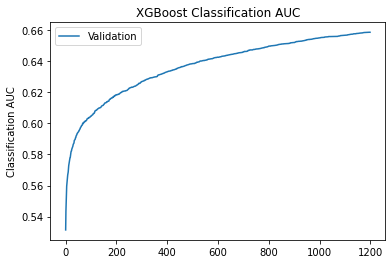

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Validation')
ax.legend()
plt.ylabel('Classification AUC')
plt.title('XGBoost Classification AUC')
plt.show()

We can use the classification report from sklearn to get better grasp on our result. We will later use this report and
compare with the reports generated by other models.

In [17]:
print(classification_report(Y_test, Y_prediction_xgb))
print("Accuracy: ", accuracy_score (Y_test, Y_prediction_xgb))

              precision    recall  f1-score   support

         0.0       0.61      0.58      0.59    245475
         1.0       0.60      0.63      0.62    249847

    accuracy                           0.60    495322
   macro avg       0.60      0.60      0.60    495322
weighted avg       0.60      0.60      0.60    495322

Accuracy:  0.6039445047867852


Confusion matrix:

In [27]:
cm_xgb = confusion_matrix(Y_test, Y_prediction_xgb)
print(cm_xgb)

[[141775 103700]
 [ 92475 157372]]


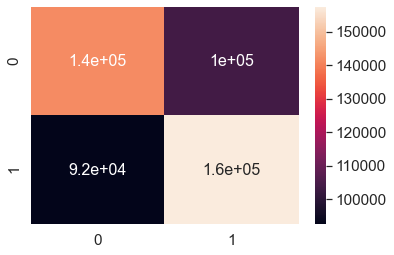

In [31]:
df_xgb = pd.DataFrame(cm_xgb)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_xgb, annot=True, annot_kws={"size": 16}) # font size

plt.show()